In [1]:
import subprocess
import sys

def install_packages():
    packages = [
        'tensorflow',
        'pandas', 
        'numpy',
        'scikit-learn',
        'PyPDF2',
        'pdfplumber',
        'PyMuPDF',
        'matplotlib',
        'seaborn'
    ]
    
    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"✅ {package} installed successfully")
        except Exception as e:
            print(f"❌ Failed to install {package}: {e}")

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pickle
import re
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, clear_output
import warnings
warnings.filterwarnings('ignore')

# PDF processing libraries
try:
    import PyPDF2
    import pdfplumber
    import fitz  # PyMuPDF
    PDF_SUPPORT = True
    print("✅ All libraries imported successfully!")
    print("✅ PDF processing libraries available")
except ImportError as e:
    print(f"❌ Missing PDF libraries: {e}")
    print("Run: !pip install PyPDF2 pdfplumber PyMuPDF")
    PDF_SUPPORT = False

print(f"🔥 TensorFlow version: {tf.__version__}")
print(f"🐼 Pandas version: {pd.__version__}")

✅ All libraries imported successfully!
✅ PDF processing libraries available
🔥 TensorFlow version: 2.19.0
🐼 Pandas version: 2.2.2


In [3]:
# Cell 3: PDF Text Extraction Functions
# =============================================================================

class PDFTextExtractor:
    """Extract text from PDF files using multiple methods"""
    
    @staticmethod
    def extract_with_pymupdf(pdf_path):
        """Extract text using PyMuPDF (usually the best method)"""
        try:
            doc = fitz.open(pdf_path)
            text = ""
            for page_num in range(doc.page_count):
                page = doc[page_num]
                text += page.get_text() + "\n"
            doc.close()
            return text.strip()
        except Exception as e:
            print(f"PyMuPDF failed: {e}")
            return None
    
    @staticmethod
    def extract_with_pdfplumber(pdf_path):
        """Extract text using pdfplumber (good for tables)"""
        try:
            with pdfplumber.open(pdf_path) as pdf:
                text = ""
                for page in pdf.pages:
                    page_text = page.extract_text()
                    if page_text:
                        text += page_text + "\n"
            return text.strip()
        except Exception as e:
            print(f"pdfplumber failed: {e}")
            return None
    
    @staticmethod
    def extract_with_pypdf2(pdf_path):
        """Extract text using PyPDF2 (fallback method)"""
        try:
            with open(pdf_path, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                text = ""
                for page in pdf_reader.pages:
                    text += page.extract_text() + "\n"
            return text.strip()
        except Exception as e:
            print(f"PyPDF2 failed: {e}")
            return None
    
    def extract_text(self, pdf_path):
        """Try all methods and return the best result"""
        print(f"📄 Processing: {os.path.basename(pdf_path)}")
        
        methods = [
            ("PyMuPDF", self.extract_with_pymupdf),
            ("pdfplumber", self.extract_with_pdfplumber),
            ("PyPDF2", self.extract_with_pypdf2)
        ]
        
        best_text = ""
        best_method = ""
        
        for method_name, method_func in methods:
            text = method_func(pdf_path)
            if text and len(text) > len(best_text):
                best_text = text
                best_method = method_name
        
        if best_text:
            print(f"  ✅ Success with {best_method}: {len(best_text)} characters")
            return best_text
        else:
            print(f"  ❌ All methods failed")
            return None

In [4]:
# Cell 4: Text Preprocessing Functions
# =============================================================================

def clean_resume_text(text):
    """Clean and preprocess resume text"""
    if not text:
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove excessive whitespace and newlines
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Remove special characters but keep important ones
    text = re.sub(r'[^a-zA-Z\s.,;:()\-@]', ' ', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def preview_text(text, max_length=300):
    """Get a preview of text"""
    if len(text) <= max_length:
        return text
    return text[:max_length] + "..."

In [5]:
# Cell 5: Process Your PDF Folder
# =============================================================================

# 🔧 CONFIGURATION: Set your PDF folder path here
PDF_FOLDER_PATH = r"C:\Users\ASUS\Desktop\Neural Network\data\data"  # 👈 YOUR ACTUAL PATH

def process_pdf_folder(folder_path):
    """Process all PDF files in a folder and its subfolders (recursive search)"""
    
    if not os.path.exists(folder_path):
        print(f"❌ Folder not found: {folder_path}")
        return []
    
    # Find all PDF files recursively in subfolders
    pdf_files = list(Path(folder_path).rglob("*.pdf"))  # rglob for recursive search
    print(f"📁 Searching in: {folder_path}")
    print(f"📁 Found {len(pdf_files)} PDF files (including subfolders)")
    
    if pdf_files:
        print("\n📋 PDF files found:")
        for i, pdf_file in enumerate(pdf_files[:10]):  # Show first 10
            relative_path = pdf_file.relative_to(Path(folder_path))
            print(f"  {i+1}. {relative_path}")
        if len(pdf_files) > 10:
            print(f"  ... and {len(pdf_files) - 10} more files")
    
    if not pdf_files:
        print("❌ No PDF files found!")
        # Show folder structure to help debug
        print("\n🔍 Folder structure:")
        for root, dirs, files in os.walk(folder_path):
            level = root.replace(folder_path, '').count(os.sep)
            indent = ' ' * 2 * level
            print(f"{indent}{os.path.basename(root)}/")
            subindent = ' ' * 2 * (level + 1)
            for file in files[:3]:  # Show first 3 files per folder
                print(f"{subindent}{file}")
            if len(files) > 3:
                print(f"{subindent}... and {len(files) - 3} more files")
        return []
    
    # Initialize extractor
    extractor = PDFTextExtractor()
    results = []
    
    print("\n" + "="*60)
    print("PROCESSING PDF FILES FROM ALL SUBFOLDERS")
    print("="*60)
    
    for i, pdf_file in enumerate(pdf_files, 1):
        # Get the subfolder name for potential category mapping
        relative_path = pdf_file.relative_to(Path(folder_path))
        subfolder_name = relative_path.parts[0] if len(relative_path.parts) > 1 else "root"
        
        print(f"\n[{i}/{len(pdf_files)}] 📁 {subfolder_name}/{pdf_file.name}")
        
        # Extract text
        raw_text = extractor.extract_text(str(pdf_file))
        
        if raw_text:
            # Clean text
            cleaned_text = clean_resume_text(raw_text)
            
            if len(cleaned_text) > 50:  # Minimum viable text length
                results.append({
                    'filename': pdf_file.name,
                    'filepath': str(pdf_file),
                    'subfolder': subfolder_name,
                    'relative_path': str(relative_path),
                    'raw_text': raw_text,
                    'cleaned_text': cleaned_text,
                    'text_length': len(cleaned_text)
                })
                print(f"    ✅ Extracted {len(cleaned_text)} characters")
            else:
                print(f"    ⚠️ Text too short: {len(cleaned_text)} chars - SKIPPED")
        else:
            print(f"    ❌ Text extraction failed - SKIPPED")
    
    print(f"\n✅ Successfully processed: {len(results)}/{len(pdf_files)} files")
    
    # Show distribution by subfolder
    if results:
        subfolder_counts = {}
        for result in results:
            subfolder = result['subfolder']
            subfolder_counts[subfolder] = subfolder_counts.get(subfolder, 0) + 1
        
        print(f"\n📊 Distribution by subfolder:")
        for subfolder, count in sorted(subfolder_counts.items()):
            print(f"  📁 {subfolder}: {count} files")
    
    return results

# Run the processing
pdf_results = process_pdf_folder(PDF_FOLDER_PATH)

# Display results summary
if pdf_results:
    print(f"\n📊 EXTRACTION SUMMARY:")
    print(f"📄 Total files processed: {len(pdf_results)}")
    print(f"📏 Average text length: {np.mean([r['text_length'] for r in pdf_results]):.0f} characters")
    print(f"📏 Text length range: {min(r['text_length'] for r in pdf_results)} - {max(r['text_length'] for r in pdf_results)}")
else:
    print("❌ No files were successfully processed!")

CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


📁 Searching in: C:\Users\ASUS\Desktop\Neural Network\data\data
📁 Found 2484 PDF files (including subfolders)

📋 PDF files found:
  1. ACCOUNTANT\10554236.pdf
  2. ACCOUNTANT\10674770.pdf
  3. ACCOUNTANT\11163645.pdf
  4. ACCOUNTANT\11759079.pdf
  5. ACCOUNTANT\12065211.pdf
  6. ACCOUNTANT\12202337.pdf
  7. ACCOUNTANT\12338274.pdf
  8. ACCOUNTANT\12442909.pdf
  9. ACCOUNTANT\12780508.pdf
  10. ACCOUNTANT\12802330.pdf
  ... and 2474 more files

PROCESSING PDF FILES FROM ALL SUBFOLDERS

[1/2484] 📁 ACCOUNTANT/10554236.pdf
📄 Processing: 10554236.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 24295 characters
    ✅ Extracted 23905 characters

[2/2484] 📁 ACCOUNTANT/10674770.pdf
📄 Processing: 10674770.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7567 characters
    ✅ Extracted 7367 characters

[3/2484] 📁 ACCOUNTANT/11163645.pdf
📄 Processing: 11163645.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4838 characters
    ✅ Extracted 4639 characters

[4/2484] 📁 ACCOUNTANT/11759079.pdf
📄 Processing: 11759079.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5986 characters
    ✅ Extracted 5787 characters

[5/2484] 📁 ACCOUNTANT/12065211.pdf
📄 Processing: 12065211.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5622 characters
    ✅ Extracted 5471 characters

[6/2484] 📁 ACCOUNTANT/12202337.pdf
📄 Processing: 12202337.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5301 characters
    ✅ Extracted 5132 characters

[7/2484] 📁 ACCOUNTANT/12338274.pdf
📄 Processing: 12338274.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5959 characters
    ✅ Extracted 5758 characters

[8/2484] 📁 ACCOUNTANT/12442909.pdf
📄 Processing: 12442909.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4884 characters
    ✅ Extracted 4712 characters

[9/2484] 📁 ACCOUNTANT/12780508.pdf
📄 Processing: 12780508.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7545 characters
    ✅ Extracted 7346 characters

[10/2484] 📁 ACCOUNTANT/12802330.pdf
📄 Processing: 12802330.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6464 characters
    ✅ Extracted 6356 characters

[11/2484] 📁 ACCOUNTANT/13072019.pdf
📄 Processing: 13072019.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6154 characters
    ✅ Extracted 5956 characters

[12/2484] 📁 ACCOUNTANT/13130984.pdf
📄 Processing: 13130984.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4104 characters
    ✅ Extracted 3966 characters

[13/2484] 📁 ACCOUNTANT/13294301.pdf
📄 Processing: 13294301.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4858 characters
    ✅ Extracted 4599 characters

[14/2484] 📁 ACCOUNTANT/13491889.pdf
📄 Processing: 13491889.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5145 characters
    ✅ Extracted 4821 characters

[15/2484] 📁 ACCOUNTANT/13701259.pdf
📄 Processing: 13701259.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6696 characters
    ✅ Extracted 6474 characters

[16/2484] 📁 ACCOUNTANT/14055988.pdf
📄 Processing: 14055988.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4792 characters
    ✅ Extracted 4615 characters

[17/2484] 📁 ACCOUNTANT/14126433.pdf
📄 Processing: 14126433.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6384 characters
    ✅ Extracted 6147 characters

[18/2484] 📁 ACCOUNTANT/14224370.pdf
📄 Processing: 14224370.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3174 characters
    ✅ Extracted 2981 characters

[19/2484] 📁 ACCOUNTANT/14449423.pdf
📄 Processing: 14449423.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7580 characters
    ✅ Extracted 7373 characters

[20/2484] 📁 ACCOUNTANT/14470533.pdf
📄 Processing: 14470533.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6416 characters
    ✅ Extracted 6222 characters

[21/2484] 📁 ACCOUNTANT/14491649.pdf
📄 Processing: 14491649.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5637 characters
    ✅ Extracted 5400 characters

[22/2484] 📁 ACCOUNTANT/14496667.pdf
📄 Processing: 14496667.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5097 characters
    ✅ Extracted 4995 characters

[23/2484] 📁 ACCOUNTANT/15289348.pdf
📄 Processing: 15289348.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8629 characters
    ✅ Extracted 8162 characters

[24/2484] 📁 ACCOUNTANT/15363277.pdf
📄 Processing: 15363277.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6743 characters
    ✅ Extracted 6578 characters

[25/2484] 📁 ACCOUNTANT/15592167.pdf
📄 Processing: 15592167.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5103 characters
    ✅ Extracted 4783 characters

[26/2484] 📁 ACCOUNTANT/15821633.pdf
📄 Processing: 15821633.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6474 characters
    ✅ Extracted 6283 characters

[27/2484] 📁 ACCOUNTANT/15906625.pdf
📄 Processing: 15906625.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5787 characters
    ✅ Extracted 5511 characters

[28/2484] 📁 ACCOUNTANT/16237710.pdf
📄 Processing: 16237710.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5891 characters
    ✅ Extracted 5691 characters

[29/2484] 📁 ACCOUNTANT/17306905.pdf
📄 Processing: 17306905.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 13287 characters
    ✅ Extracted 12640 characters

[30/2484] 📁 ACCOUNTANT/17407184.pdf
📄 Processing: 17407184.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5286 characters
    ✅ Extracted 5090 characters

[31/2484] 📁 ACCOUNTANT/17556527.pdf
📄 Processing: 17556527.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8216 characters
    ✅ Extracted 7999 characters

[32/2484] 📁 ACCOUNTANT/18132924.pdf
📄 Processing: 18132924.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6649 characters
    ✅ Extracted 6263 characters

[33/2484] 📁 ACCOUNTANT/18365791.pdf
📄 Processing: 18365791.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 1641 characters
    ✅ Extracted 1517 characters

[34/2484] 📁 ACCOUNTANT/18569929.pdf
📄 Processing: 18569929.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4210 characters
    ✅ Extracted 4002 characters

[35/2484] 📁 ACCOUNTANT/18635654.pdf
📄 Processing: 18635654.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3363 characters
    ✅ Extracted 3235 characters

[36/2484] 📁 ACCOUNTANT/18669563.pdf
📄 Processing: 18669563.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4357 characters
    ✅ Extracted 4241 characters

[37/2484] 📁 ACCOUNTANT/19446337.pdf
📄 Processing: 19446337.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5847 characters
    ✅ Extracted 5614 characters

[38/2484] 📁 ACCOUNTANT/19545827.pdf
📄 Processing: 19545827.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6919 characters
    ✅ Extracted 6565 characters

[39/2484] 📁 ACCOUNTANT/20082776.pdf
📄 Processing: 20082776.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5133 characters
    ✅ Extracted 4771 characters

[40/2484] 📁 ACCOUNTANT/20253563.pdf
📄 Processing: 20253563.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5023 characters
    ✅ Extracted 4823 characters

[41/2484] 📁 ACCOUNTANT/20345168.pdf
📄 Processing: 20345168.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3632 characters
    ✅ Extracted 3427 characters

[42/2484] 📁 ACCOUNTANT/20393721.pdf
📄 Processing: 20393721.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5644 characters
    ✅ Extracted 5445 characters

[43/2484] 📁 ACCOUNTANT/20624984.pdf
📄 Processing: 20624984.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4820 characters
    ✅ Extracted 4733 characters

[44/2484] 📁 ACCOUNTANT/21031285.pdf
📄 Processing: 21031285.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5680 characters
    ✅ Extracted 5537 characters

[45/2484] 📁 ACCOUNTANT/21338490.pdf
📄 Processing: 21338490.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5098 characters
    ✅ Extracted 4920 characters

[46/2484] 📁 ACCOUNTANT/21763056.pdf
📄 Processing: 21763056.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5695 characters
    ✅ Extracted 5484 characters

[47/2484] 📁 ACCOUNTANT/21794875.pdf
📄 Processing: 21794875.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6013 characters
    ✅ Extracted 5775 characters

[48/2484] 📁 ACCOUNTANT/21853199.pdf
📄 Processing: 21853199.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5537 characters
    ✅ Extracted 5373 characters

[49/2484] 📁 ACCOUNTANT/22465498.pdf
📄 Processing: 22465498.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7670 characters
    ✅ Extracted 7518 characters

[50/2484] 📁 ACCOUNTANT/22925443.pdf
📄 Processing: 22925443.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5145 characters
    ✅ Extracted 5025 characters

[51/2484] 📁 ACCOUNTANT/23139819.pdf
📄 Processing: 23139819.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6832 characters
    ✅ Extracted 6583 characters

[52/2484] 📁 ACCOUNTANT/23246831.pdf
📄 Processing: 23246831.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5636 characters
    ✅ Extracted 5459 characters

[53/2484] 📁 ACCOUNTANT/23387174.pdf
📄 Processing: 23387174.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5963 characters
    ✅ Extracted 5780 characters

[54/2484] 📁 ACCOUNTANT/23416654.pdf
📄 Processing: 23416654.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5312 characters
    ✅ Extracted 5121 characters

[55/2484] 📁 ACCOUNTANT/23438112.pdf
📄 Processing: 23438112.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4935 characters
    ✅ Extracted 4694 characters

[56/2484] 📁 ACCOUNTANT/23513618.pdf
📄 Processing: 23513618.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5839 characters
    ✅ Extracted 5662 characters

[57/2484] 📁 ACCOUNTANT/23636277.pdf
📄 Processing: 23636277.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6507 characters
    ✅ Extracted 6241 characters

[58/2484] 📁 ACCOUNTANT/23734441.pdf
📄 Processing: 23734441.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6277 characters
    ✅ Extracted 6073 characters

[59/2484] 📁 ACCOUNTANT/24103168.pdf
📄 Processing: 24103168.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5210 characters
    ✅ Extracted 4843 characters

[60/2484] 📁 ACCOUNTANT/24294778.pdf
📄 Processing: 24294778.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9104 characters
    ✅ Extracted 8854 characters

[61/2484] 📁 ACCOUNTANT/24703009.pdf
📄 Processing: 24703009.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6070 characters
    ✅ Extracted 5810 characters

[62/2484] 📁 ACCOUNTANT/24799301.pdf
📄 Processing: 24799301.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1077 characters
    ✅ Extracted 967 characters

[63/2484] 📁 ACCOUNTANT/24817041.pdf
📄 Processing: 24817041.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 1999 characters
    ✅ Extracted 1803 characters

[64/2484] 📁 ACCOUNTANT/25067742.pdf
📄 Processing: 25067742.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2696 characters
    ✅ Extracted 2556 characters

[65/2484] 📁 ACCOUNTANT/25127518.pdf
📄 Processing: 25127518.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3465 characters
    ✅ Extracted 3339 characters

[66/2484] 📁 ACCOUNTANT/25462793.pdf
📄 Processing: 25462793.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3502 characters
    ✅ Extracted 3363 characters

[67/2484] 📁 ACCOUNTANT/25547145.pdf
📄 Processing: 25547145.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6967 characters
    ✅ Extracted 6889 characters

[68/2484] 📁 ACCOUNTANT/25749150.pdf
📄 Processing: 25749150.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6175 characters
    ✅ Extracted 5948 characters

[69/2484] 📁 ACCOUNTANT/25846894.pdf
📄 Processing: 25846894.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6117 characters
    ✅ Extracted 5901 characters

[70/2484] 📁 ACCOUNTANT/25862026.pdf
📄 Processing: 25862026.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5822 characters
    ✅ Extracted 5691 characters

[71/2484] 📁 ACCOUNTANT/25867805.pdf
📄 Processing: 25867805.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4687 characters
    ✅ Extracted 4528 characters

[72/2484] 📁 ACCOUNTANT/25935030.pdf
📄 Processing: 25935030.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5583 characters
    ✅ Extracted 5446 characters

[73/2484] 📁 ACCOUNTANT/26065877.pdf
📄 Processing: 26065877.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5050 characters
    ✅ Extracted 4882 characters

[74/2484] 📁 ACCOUNTANT/26975573.pdf
📄 Processing: 26975573.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8580 characters
    ✅ Extracted 8460 characters

[75/2484] 📁 ACCOUNTANT/27558837.pdf
📄 Processing: 27558837.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4861 characters
    ✅ Extracted 4679 characters

[76/2484] 📁 ACCOUNTANT/27573855.pdf
📄 Processing: 27573855.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6851 characters
    ✅ Extracted 6603 characters

[77/2484] 📁 ACCOUNTANT/27637576.pdf
📄 Processing: 27637576.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9004 characters
    ✅ Extracted 8729 characters

[78/2484] 📁 ACCOUNTANT/27980446.pdf
📄 Processing: 27980446.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5362 characters
    ✅ Extracted 5215 characters

[79/2484] 📁 ACCOUNTANT/28298773.pdf
📄 Processing: 28298773.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4932 characters
    ✅ Extracted 4681 characters

[80/2484] 📁 ACCOUNTANT/28359817.pdf
📄 Processing: 28359817.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5983 characters
    ✅ Extracted 5743 characters

[81/2484] 📁 ACCOUNTANT/28614791.pdf
📄 Processing: 28614791.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5997 characters
    ✅ Extracted 5666 characters

[82/2484] 📁 ACCOUNTANT/28939941.pdf
📄 Processing: 28939941.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6814 characters
    ✅ Extracted 6663 characters

[83/2484] 📁 ACCOUNTANT/28969385.pdf
📄 Processing: 28969385.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5748 characters
    ✅ Extracted 5580 characters

[84/2484] 📁 ACCOUNTANT/29050809.pdf
📄 Processing: 29050809.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9078 characters
    ✅ Extracted 8710 characters

[85/2484] 📁 ACCOUNTANT/29456173.pdf
📄 Processing: 29456173.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5167 characters
    ✅ Extracted 5006 characters

[86/2484] 📁 ACCOUNTANT/29821051.pdf
📄 Processing: 29821051.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8251 characters
    ✅ Extracted 7936 characters

[87/2484] 📁 ACCOUNTANT/29999135.pdf
📄 Processing: 29999135.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10436 characters
    ✅ Extracted 10143 characters

[88/2484] 📁 ACCOUNTANT/30304575.pdf
📄 Processing: 30304575.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8067 characters
    ✅ Extracted 7734 characters

[89/2484] 📁 ACCOUNTANT/30361788.pdf
📄 Processing: 30361788.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2228 characters
    ✅ Extracted 2119 characters

[90/2484] 📁 ACCOUNTANT/30813919.pdf
📄 Processing: 30813919.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6455 characters
    ✅ Extracted 6099 characters

[91/2484] 📁 ACCOUNTANT/31602598.pdf
📄 Processing: 31602598.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5157 characters
    ✅ Extracted 4921 characters

[92/2484] 📁 ACCOUNTANT/33527446.pdf
📄 Processing: 33527446.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6168 characters
    ✅ Extracted 5891 characters

[93/2484] 📁 ACCOUNTANT/34198885.pdf
📄 Processing: 34198885.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5298 characters
    ✅ Extracted 4995 characters

[94/2484] 📁 ACCOUNTANT/34816637.pdf
📄 Processing: 34816637.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5137 characters
    ✅ Extracted 4975 characters

[95/2484] 📁 ACCOUNTANT/35554162.pdf
📄 Processing: 35554162.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5173 characters
    ✅ Extracted 5008 characters

[96/2484] 📁 ACCOUNTANT/36024962.pdf
📄 Processing: 36024962.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 1850 characters
    ✅ Extracted 1771 characters

[97/2484] 📁 ACCOUNTANT/36425270.pdf
📄 Processing: 36425270.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4874 characters
    ✅ Extracted 4684 characters

[98/2484] 📁 ACCOUNTANT/37370455.pdf
📄 Processing: 37370455.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5578 characters
    ✅ Extracted 5411 characters

[99/2484] 📁 ACCOUNTANT/37997506.pdf
📄 Processing: 37997506.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7828 characters
    ✅ Extracted 7708 characters

[100/2484] 📁 ACCOUNTANT/38847011.pdf
📄 Processing: 38847011.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6588 characters
    ✅ Extracted 6363 characters

[101/2484] 📁 ACCOUNTANT/39115899.pdf
📄 Processing: 39115899.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4873 characters
    ✅ Extracted 4703 characters

[102/2484] 📁 ACCOUNTANT/39674178.pdf
📄 Processing: 39674178.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5392 characters
    ✅ Extracted 5223 characters

[103/2484] 📁 ACCOUNTANT/42487883.pdf
📄 Processing: 42487883.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4929 characters
    ✅ Extracted 4730 characters

[104/2484] 📁 ACCOUNTANT/43685045.pdf
📄 Processing: 43685045.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5016 characters
    ✅ Extracted 4827 characters

[105/2484] 📁 ACCOUNTANT/49204385.pdf
📄 Processing: 49204385.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11493 characters
    ✅ Extracted 11328 characters

[106/2484] 📁 ACCOUNTANT/49997097.pdf
📄 Processing: 49997097.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5252 characters
    ✅ Extracted 5103 characters

[107/2484] 📁 ACCOUNTANT/50222417.pdf
📄 Processing: 50222417.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8688 characters
    ✅ Extracted 8427 characters

[108/2484] 📁 ACCOUNTANT/53640713.pdf
📄 Processing: 53640713.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11712 characters
    ✅ Extracted 11457 characters

[109/2484] 📁 ACCOUNTANT/59403481.pdf
📄 Processing: 59403481.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5839 characters
    ✅ Extracted 5592 characters

[110/2484] 📁 ACCOUNTANT/62809577.pdf
📄 Processing: 62809577.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3758 characters
    ✅ Extracted 3614 characters

[111/2484] 📁 ACCOUNTANT/63137898.pdf
📄 Processing: 63137898.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5398 characters
    ✅ Extracted 5095 characters

[112/2484] 📁 ACCOUNTANT/75286906.pdf
📄 Processing: 75286906.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5905 characters
    ✅ Extracted 5723 characters

[113/2484] 📁 ACCOUNTANT/78257294.pdf
📄 Processing: 78257294.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8591 characters
    ✅ Extracted 8393 characters

[114/2484] 📁 ACCOUNTANT/78403342.pdf
📄 Processing: 78403342.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6394 characters
    ✅ Extracted 6143 characters

[115/2484] 📁 ACCOUNTANT/80053367.pdf
📄 Processing: 80053367.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4725 characters
    ✅ Extracted 4545 characters

[116/2484] 📁 ACCOUNTANT/82649935.pdf
📄 Processing: 82649935.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5087 characters
    ✅ Extracted 4943 characters

[117/2484] 📁 ACCOUNTANT/87635012.pdf
📄 Processing: 87635012.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5561 characters
    ✅ Extracted 5329 characters

[118/2484] 📁 ACCOUNTANT/98559931.pdf
📄 Processing: 98559931.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5880 characters
    ✅ Extracted 5473 characters

[119/2484] 📁 ADVOCATE/10186968.pdf
📄 Processing: 10186968.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3991 characters
    ✅ Extracted 3845 characters

[120/2484] 📁 ADVOCATE/10344379.pdf
📄 Processing: 10344379.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5106 characters
    ✅ Extracted 4947 characters

[121/2484] 📁 ADVOCATE/10659182.pdf
📄 Processing: 10659182.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4935 characters
    ✅ Extracted 4744 characters

[122/2484] 📁 ADVOCATE/10818478.pdf
📄 Processing: 10818478.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2288 characters
    ✅ Extracted 2180 characters

[123/2484] 📁 ADVOCATE/11174187.pdf
📄 Processing: 11174187.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8044 characters
    ✅ Extracted 7787 characters

[124/2484] 📁 ADVOCATE/11188218.pdf
📄 Processing: 11188218.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6139 characters
    ✅ Extracted 5945 characters

[125/2484] 📁 ADVOCATE/11773767.pdf
📄 Processing: 11773767.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5065 characters
    ✅ Extracted 4954 characters

[126/2484] 📁 ADVOCATE/11963737.pdf
📄 Processing: 11963737.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4861 characters
    ✅ Extracted 4728 characters

[127/2484] 📁 ADVOCATE/12171093.pdf
📄 Processing: 12171093.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3361 characters
    ✅ Extracted 3063 characters

[128/2484] 📁 ADVOCATE/12544735.pdf
📄 Processing: 12544735.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3507 characters
    ✅ Extracted 3343 characters

[129/2484] 📁 ADVOCATE/13072354.pdf
📄 Processing: 13072354.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6103 characters
    ✅ Extracted 5900 characters

[130/2484] 📁 ADVOCATE/13115648.pdf
📄 Processing: 13115648.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5018 characters
    ✅ Extracted 4886 characters

[131/2484] 📁 ADVOCATE/13342150.pdf
📄 Processing: 13342150.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5697 characters
    ✅ Extracted 5477 characters

[132/2484] 📁 ADVOCATE/13593241.pdf
📄 Processing: 13593241.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7064 characters
    ✅ Extracted 6821 characters

[133/2484] 📁 ADVOCATE/13809698.pdf
📄 Processing: 13809698.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4853 characters
    ✅ Extracted 4622 characters

[134/2484] 📁 ADVOCATE/13909762.pdf
📄 Processing: 13909762.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7352 characters
    ✅ Extracted 7222 characters

[135/2484] 📁 ADVOCATE/13967854.pdf
📄 Processing: 13967854.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5483 characters
    ✅ Extracted 4829 characters

[136/2484] 📁 ADVOCATE/14064815.pdf
📄 Processing: 14064815.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5061 characters
    ✅ Extracted 4910 characters

[137/2484] 📁 ADVOCATE/14146106.pdf
📄 Processing: 14146106.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4963 characters
    ✅ Extracted 4870 characters

[138/2484] 📁 ADVOCATE/14176254.pdf
📄 Processing: 14176254.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5535 characters
    ✅ Extracted 5271 characters

[139/2484] 📁 ADVOCATE/14445309.pdf
📄 Processing: 14445309.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4791 characters
    ✅ Extracted 4619 characters

[140/2484] 📁 ADVOCATE/14708590.pdf
📄 Processing: 14708590.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5466 characters
    ✅ Extracted 5241 characters

[141/2484] 📁 ADVOCATE/15313140.pdf
📄 Processing: 15313140.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5287 characters
    ✅ Extracted 5098 characters

[142/2484] 📁 ADVOCATE/15337481.pdf
📄 Processing: 15337481.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6027 characters
    ✅ Extracted 5813 characters

[143/2484] 📁 ADVOCATE/15727656.pdf
📄 Processing: 15727656.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4929 characters
    ✅ Extracted 4712 characters

[144/2484] 📁 ADVOCATE/15958967.pdf
📄 Processing: 15958967.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7452 characters
    ✅ Extracted 7173 characters

[145/2484] 📁 ADVOCATE/16332348.pdf
📄 Processing: 16332348.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 12104 characters
    ✅ Extracted 11870 characters

[146/2484] 📁 ADVOCATE/17021141.pdf
📄 Processing: 17021141.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5972 characters
    ✅ Extracted 5680 characters

[147/2484] 📁 ADVOCATE/17165107.pdf
📄 Processing: 17165107.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4070 characters
    ✅ Extracted 3786 characters

[148/2484] 📁 ADVOCATE/17254634.pdf
📄 Processing: 17254634.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5777 characters
    ✅ Extracted 5583 characters

[149/2484] 📁 ADVOCATE/17847636.pdf
📄 Processing: 17847636.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4944 characters
    ✅ Extracted 4748 characters

[150/2484] 📁 ADVOCATE/17911230.pdf
📄 Processing: 17911230.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5913 characters
    ✅ Extracted 5599 characters

[151/2484] 📁 ADVOCATE/18090899.pdf
📄 Processing: 18090899.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6045 characters
    ✅ Extracted 5480 characters

[152/2484] 📁 ADVOCATE/18725071.pdf
📄 Processing: 18725071.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5579 characters
    ✅ Extracted 5344 characters

[153/2484] 📁 ADVOCATE/18997135.pdf
📄 Processing: 18997135.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4486 characters
    ✅ Extracted 4287 characters

[154/2484] 📁 ADVOCATE/19063156.pdf
📄 Processing: 19063156.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 16785 characters
    ✅ Extracted 15859 characters

[155/2484] 📁 ADVOCATE/19108760.pdf
📄 Processing: 19108760.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8483 characters
    ✅ Extracted 8168 characters

[156/2484] 📁 ADVOCATE/19234823.pdf
📄 Processing: 19234823.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7450 characters
    ✅ Extracted 7184 characters

[157/2484] 📁 ADVOCATE/19518606.pdf
📄 Processing: 19518606.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5172 characters
    ✅ Extracted 4990 characters

[158/2484] 📁 ADVOCATE/19926135.pdf
📄 Processing: 19926135.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5162 characters
    ✅ Extracted 5006 characters

[159/2484] 📁 ADVOCATE/20138606.pdf
📄 Processing: 20138606.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7349 characters
    ✅ Extracted 7175 characters

[160/2484] 📁 ADVOCATE/20272792.pdf
📄 Processing: 20272792.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2273 characters
    ✅ Extracted 2143 characters

[161/2484] 📁 ADVOCATE/20324037.pdf
📄 Processing: 20324037.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5544 characters
    ✅ Extracted 5238 characters

[162/2484] 📁 ADVOCATE/20400279.pdf
📄 Processing: 20400279.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7612 characters
    ✅ Extracted 7432 characters

[163/2484] 📁 ADVOCATE/20544228.pdf
📄 Processing: 20544228.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4881 characters
    ✅ Extracted 4748 characters

[164/2484] 📁 ADVOCATE/20604208.pdf
📄 Processing: 20604208.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7035 characters
    ✅ Extracted 6848 characters

[165/2484] 📁 ADVOCATE/20765795.pdf
📄 Processing: 20765795.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4961 characters
    ✅ Extracted 4666 characters

[166/2484] 📁 ADVOCATE/21614256.pdf
📄 Processing: 21614256.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5737 characters
    ✅ Extracted 5532 characters

[167/2484] 📁 ADVOCATE/22042181.pdf
📄 Processing: 22042181.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6408 characters
    ✅ Extracted 6195 characters

[168/2484] 📁 ADVOCATE/22259475.pdf
📄 Processing: 22259475.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4468 characters
    ✅ Extracted 4347 characters

[169/2484] 📁 ADVOCATE/22391901.pdf
📄 Processing: 22391901.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4913 characters
    ✅ Extracted 4713 characters

[170/2484] 📁 ADVOCATE/23427369.pdf
📄 Processing: 23427369.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5015 characters
    ✅ Extracted 4777 characters

[171/2484] 📁 ADVOCATE/23577836.pdf
📄 Processing: 23577836.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7817 characters
    ✅ Extracted 7576 characters

[172/2484] 📁 ADVOCATE/23804341.pdf
📄 Processing: 23804341.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4519 characters
    ✅ Extracted 4359 characters

[173/2484] 📁 ADVOCATE/24124250.pdf
📄 Processing: 24124250.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5318 characters
    ✅ Extracted 5146 characters

[174/2484] 📁 ADVOCATE/24410405.pdf
📄 Processing: 24410405.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5383 characters
    ✅ Extracted 5049 characters

[175/2484] 📁 ADVOCATE/24588864.pdf
📄 Processing: 24588864.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 13334 characters
    ✅ Extracted 12940 characters

[176/2484] 📁 ADVOCATE/24695561.pdf
📄 Processing: 24695561.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7925 characters
    ✅ Extracted 7632 characters

[177/2484] 📁 ADVOCATE/24754689.pdf
📄 Processing: 24754689.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6410 characters
    ✅ Extracted 6117 characters

[178/2484] 📁 ADVOCATE/24763208.pdf
📄 Processing: 24763208.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9179 characters
    ✅ Extracted 8817 characters

[179/2484] 📁 ADVOCATE/24946537.pdf
📄 Processing: 24946537.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11881 characters
    ✅ Extracted 11393 characters

[180/2484] 📁 ADVOCATE/25873425.pdf
📄 Processing: 25873425.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7175 characters
    ✅ Extracted 6839 characters

[181/2484] 📁 ADVOCATE/26071861.pdf
📄 Processing: 26071861.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5991 characters
    ✅ Extracted 5825 characters

[182/2484] 📁 ADVOCATE/26456474.pdf
📄 Processing: 26456474.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5062 characters
    ✅ Extracted 4881 characters

[183/2484] 📁 ADVOCATE/27182111.pdf
📄 Processing: 27182111.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7404 characters
    ✅ Extracted 7196 characters

[184/2484] 📁 ADVOCATE/28111403.pdf
📄 Processing: 28111403.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8595 characters
    ✅ Extracted 8065 characters

[185/2484] 📁 ADVOCATE/28206098.pdf
📄 Processing: 28206098.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5385 characters
    ✅ Extracted 5153 characters

[186/2484] 📁 ADVOCATE/28635795.pdf
📄 Processing: 28635795.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5627 characters
    ✅ Extracted 5398 characters

[187/2484] 📁 ADVOCATE/28871170.pdf
📄 Processing: 28871170.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5865 characters
    ✅ Extracted 5507 characters

[188/2484] 📁 ADVOCATE/28974459.pdf
📄 Processing: 28974459.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5438 characters
    ✅ Extracted 5160 characters

[189/2484] 📁 ADVOCATE/29173771.pdf
📄 Processing: 29173771.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5370 characters
    ✅ Extracted 5205 characters

[190/2484] 📁 ADVOCATE/29177904.pdf
📄 Processing: 29177904.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5418 characters
    ✅ Extracted 5199 characters

[191/2484] 📁 ADVOCATE/29415426.pdf
📄 Processing: 29415426.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2530 characters
    ✅ Extracted 2359 characters

[192/2484] 📁 ADVOCATE/29926588.pdf
📄 Processing: 29926588.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5078 characters
    ✅ Extracted 4957 characters

[193/2484] 📁 ADVOCATE/30741799.pdf
📄 Processing: 30741799.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5351 characters
    ✅ Extracted 5109 characters

[194/2484] 📁 ADVOCATE/31040875.pdf
📄 Processing: 31040875.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2782 characters
    ✅ Extracted 2653 characters

[195/2484] 📁 ADVOCATE/31242382.pdf
📄 Processing: 31242382.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6165 characters
    ✅ Extracted 5914 characters

[196/2484] 📁 ADVOCATE/32965335.pdf
📄 Processing: 32965335.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8035 characters
    ✅ Extracted 7853 characters

[197/2484] 📁 ADVOCATE/34327438.pdf
📄 Processing: 34327438.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7047 characters
    ✅ Extracted 6793 characters

[198/2484] 📁 ADVOCATE/34970271.pdf
📄 Processing: 34970271.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5354 characters
    ✅ Extracted 5174 characters

[199/2484] 📁 ADVOCATE/35344611.pdf
📄 Processing: 35344611.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6632 characters
    ✅ Extracted 6473 characters

[200/2484] 📁 ADVOCATE/35474904.pdf
📄 Processing: 35474904.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7323 characters
    ✅ Extracted 7122 characters

[201/2484] 📁 ADVOCATE/36392131.pdf
📄 Processing: 36392131.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7472 characters
    ✅ Extracted 7182 characters

[202/2484] 📁 ADVOCATE/36694627.pdf
📄 Processing: 36694627.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4832 characters
    ✅ Extracted 4716 characters

[203/2484] 📁 ADVOCATE/37333719.pdf
📄 Processing: 37333719.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1931 characters
    ✅ Extracted 1728 characters

[204/2484] 📁 ADVOCATE/37348041.pdf
📄 Processing: 37348041.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5058 characters
    ✅ Extracted 4841 characters

[205/2484] 📁 ADVOCATE/37560528.pdf
📄 Processing: 37560528.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8486 characters
    ✅ Extracted 8233 characters

[206/2484] 📁 ADVOCATE/37640804.pdf
📄 Processing: 37640804.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7119 characters
    ✅ Extracted 6897 characters

[207/2484] 📁 ADVOCATE/38059130.pdf
📄 Processing: 38059130.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6829 characters
    ✅ Extracted 6512 characters

[208/2484] 📁 ADVOCATE/38291889.pdf
📄 Processing: 38291889.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5491 characters
    ✅ Extracted 5287 characters

[209/2484] 📁 ADVOCATE/38698573.pdf
📄 Processing: 38698573.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5443 characters
    ✅ Extracted 5269 characters

[210/2484] 📁 ADVOCATE/38860712.pdf
📄 Processing: 38860712.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4712 characters
    ✅ Extracted 4608 characters

[211/2484] 📁 ADVOCATE/40088790.pdf
📄 Processing: 40088790.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6811 characters
    ✅ Extracted 6690 characters

[212/2484] 📁 ADVOCATE/42164460.pdf
📄 Processing: 42164460.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5733 characters
    ✅ Extracted 5382 characters

[213/2484] 📁 ADVOCATE/44115326.pdf
📄 Processing: 44115326.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 20715 characters
    ✅ Extracted 20189 characters

[214/2484] 📁 ADVOCATE/46772262.pdf
📄 Processing: 46772262.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4757 characters
    ✅ Extracted 4585 characters

[215/2484] 📁 ADVOCATE/47133747.pdf
📄 Processing: 47133747.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7363 characters
    ✅ Extracted 7068 characters

[216/2484] 📁 ADVOCATE/49475708.pdf
📄 Processing: 49475708.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5759 characters
    ✅ Extracted 5651 characters

[217/2484] 📁 ADVOCATE/49486820.pdf
📄 Processing: 49486820.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7683 characters
    ✅ Extracted 7550 characters

[218/2484] 📁 ADVOCATE/53169257.pdf
📄 Processing: 53169257.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4929 characters
    ✅ Extracted 4769 characters

[219/2484] 📁 ADVOCATE/54067174.pdf
📄 Processing: 54067174.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3867 characters
    ✅ Extracted 3705 characters

[220/2484] 📁 ADVOCATE/72652441.pdf
📄 Processing: 72652441.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7111 characters
    ✅ Extracted 6759 characters

[221/2484] 📁 ADVOCATE/73448369.pdf
📄 Processing: 73448369.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4948 characters
    ✅ Extracted 4783 characters

[222/2484] 📁 ADVOCATE/74126637.pdf
📄 Processing: 74126637.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5146 characters
    ✅ Extracted 4929 characters

[223/2484] 📁 ADVOCATE/74191424.pdf
📄 Processing: 74191424.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5495 characters
    ✅ Extracted 5234 characters

[224/2484] 📁 ADVOCATE/75057933.pdf
📄 Processing: 75057933.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5514 characters
    ✅ Extracted 5228 characters

[225/2484] 📁 ADVOCATE/75435017.pdf
📄 Processing: 75435017.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7992 characters
    ✅ Extracted 7513 characters

[226/2484] 📁 ADVOCATE/75950464.pdf
📄 Processing: 75950464.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11880 characters
    ✅ Extracted 11682 characters

[227/2484] 📁 ADVOCATE/77439230.pdf
📄 Processing: 77439230.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8345 characters
    ✅ Extracted 8085 characters

[228/2484] 📁 ADVOCATE/78538268.pdf
📄 Processing: 78538268.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5217 characters
    ✅ Extracted 5061 characters

[229/2484] 📁 ADVOCATE/80503242.pdf
📄 Processing: 80503242.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5402 characters
    ✅ Extracted 5192 characters

[230/2484] 📁 ADVOCATE/89508407.pdf
📄 Processing: 89508407.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5507 characters
    ✅ Extracted 5222 characters

[231/2484] 📁 ADVOCATE/90468982.pdf
📄 Processing: 90468982.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5021 characters
    ✅ Extracted 4804 characters

[232/2484] 📁 ADVOCATE/91051945.pdf
📄 Processing: 91051945.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 13953 characters
    ✅ Extracted 13476 characters

[233/2484] 📁 ADVOCATE/93512385.pdf
📄 Processing: 93512385.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2418 characters
    ✅ Extracted 2207 characters

[234/2484] 📁 ADVOCATE/95714702.pdf
📄 Processing: 95714702.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6803 characters
    ✅ Extracted 6513 characters

[235/2484] 📁 ADVOCATE/95970987.pdf
📄 Processing: 95970987.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 12460 characters
    ✅ Extracted 12210 characters

[236/2484] 📁 ADVOCATE/97405769.pdf
📄 Processing: 97405769.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7280 characters
    ✅ Extracted 7031 characters

[237/2484] 📁 AGRICULTURE/10953078.pdf
📄 Processing: 10953078.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5371 characters
    ✅ Extracted 5130 characters

[238/2484] 📁 AGRICULTURE/11197262.pdf
📄 Processing: 11197262.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5155 characters
    ✅ Extracted 4889 characters

[239/2484] 📁 AGRICULTURE/11676151.pdf
📄 Processing: 11676151.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4720 characters
    ✅ Extracted 4501 characters

[240/2484] 📁 AGRICULTURE/11813872.pdf
📄 Processing: 11813872.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8677 characters
    ✅ Extracted 8430 characters

[241/2484] 📁 AGRICULTURE/12341902.pdf
📄 Processing: 12341902.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5438 characters
    ✅ Extracted 5191 characters

[242/2484] 📁 AGRICULTURE/12674256.pdf
📄 Processing: 12674256.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5518 characters
    ✅ Extracted 5205 characters

[243/2484] 📁 AGRICULTURE/14140903.pdf
📄 Processing: 14140903.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6584 characters
    ✅ Extracted 6341 characters

[244/2484] 📁 AGRICULTURE/15053703.pdf
📄 Processing: 15053703.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5066 characters
    ✅ Extracted 4854 characters

[245/2484] 📁 AGRICULTURE/15546686.pdf
📄 Processing: 15546686.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3509 characters
    ✅ Extracted 3346 characters

[246/2484] 📁 AGRICULTURE/15603319.pdf
📄 Processing: 15603319.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4926 characters
    ✅ Extracted 4714 characters

[247/2484] 📁 AGRICULTURE/16172429.pdf
📄 Processing: 16172429.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5971 characters
    ✅ Extracted 5797 characters

[248/2484] 📁 AGRICULTURE/16507693.pdf
📄 Processing: 16507693.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11149 characters
    ✅ Extracted 10684 characters

[249/2484] 📁 AGRICULTURE/16653657.pdf
📄 Processing: 16653657.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5312 characters
    ✅ Extracted 5082 characters

[250/2484] 📁 AGRICULTURE/16661264.pdf
📄 Processing: 16661264.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11579 characters
    ✅ Extracted 11177 characters

[251/2484] 📁 AGRICULTURE/16849128.pdf
📄 Processing: 16849128.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2329 characters
    ✅ Extracted 2084 characters

[252/2484] 📁 AGRICULTURE/17312146.pdf
📄 Processing: 17312146.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4311 characters
    ✅ Extracted 4168 characters

[253/2484] 📁 AGRICULTURE/17499196.pdf
📄 Processing: 17499196.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6837 characters
    ✅ Extracted 6562 characters

[254/2484] 📁 AGRICULTURE/17640785.pdf
📄 Processing: 17640785.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6884 characters
    ✅ Extracted 6600 characters

[255/2484] 📁 AGRICULTURE/18242317.pdf
📄 Processing: 18242317.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5073 characters
    ✅ Extracted 4844 characters

[256/2484] 📁 AGRICULTURE/18264694.pdf
📄 Processing: 18264694.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10768 characters
    ✅ Extracted 10259 characters

[257/2484] 📁 AGRICULTURE/19532392.pdf
📄 Processing: 19532392.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5143 characters
    ✅ Extracted 4914 characters

[258/2484] 📁 AGRICULTURE/19851252.pdf
📄 Processing: 19851252.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1416 characters
    ✅ Extracted 1311 characters

[259/2484] 📁 AGRICULTURE/20006992.pdf
📄 Processing: 20006992.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5417 characters
    ✅ Extracted 5093 characters

[260/2484] 📁 AGRICULTURE/20969119.pdf
📄 Processing: 20969119.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9369 characters
    ✅ Extracted 8960 characters

[261/2484] 📁 AGRICULTURE/21134923.pdf
📄 Processing: 21134923.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5588 characters
    ✅ Extracted 5339 characters

[262/2484] 📁 AGRICULTURE/21868149.pdf
📄 Processing: 21868149.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6905 characters
    ✅ Extracted 6656 characters

[263/2484] 📁 AGRICULTURE/23631188.pdf
📄 Processing: 23631188.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8353 characters
    ✅ Extracted 8004 characters

[264/2484] 📁 AGRICULTURE/24001783.pdf
📄 Processing: 24001783.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4728 characters
    ✅ Extracted 4507 characters

[265/2484] 📁 AGRICULTURE/24068423.pdf
📄 Processing: 24068423.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5699 characters
    ✅ Extracted 5491 characters

[266/2484] 📁 AGRICULTURE/24397882.pdf
📄 Processing: 24397882.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6333 characters
    ✅ Extracted 6094 characters

[267/2484] 📁 AGRICULTURE/24416961.pdf
📄 Processing: 24416961.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7228 characters
    ✅ Extracted 6908 characters

[268/2484] 📁 AGRICULTURE/26070334.pdf
📄 Processing: 26070334.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10534 characters
    ✅ Extracted 10125 characters

[269/2484] 📁 AGRICULTURE/26835781.pdf
📄 Processing: 26835781.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7676 characters
    ✅ Extracted 7432 characters

[270/2484] 📁 AGRICULTURE/26921245.pdf
📄 Processing: 26921245.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4864 characters
    ✅ Extracted 4558 characters

[271/2484] 📁 AGRICULTURE/27689009.pdf
📄 Processing: 27689009.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5025 characters
    ✅ Extracted 4902 characters

[272/2484] 📁 AGRICULTURE/27888251.pdf
📄 Processing: 27888251.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5010 characters
    ✅ Extracted 4830 characters

[273/2484] 📁 AGRICULTURE/28165687.pdf
📄 Processing: 28165687.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6041 characters
    ✅ Extracted 5798 characters

[274/2484] 📁 AGRICULTURE/28247753.pdf
📄 Processing: 28247753.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7964 characters
    ✅ Extracted 7661 characters

[275/2484] 📁 AGRICULTURE/28733974.pdf
📄 Processing: 28733974.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6473 characters
    ✅ Extracted 6165 characters

[276/2484] 📁 AGRICULTURE/29142288.pdf
📄 Processing: 29142288.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11362 characters
    ✅ Extracted 10804 characters

[277/2484] 📁 AGRICULTURE/29510501.pdf
📄 Processing: 29510501.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5000 characters
    ✅ Extracted 4824 characters

[278/2484] 📁 AGRICULTURE/29746235.pdf
📄 Processing: 29746235.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5210 characters
    ✅ Extracted 4894 characters

[279/2484] 📁 AGRICULTURE/29897742.pdf
📄 Processing: 29897742.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4945 characters
    ✅ Extracted 4782 characters

[280/2484] 📁 AGRICULTURE/29968330.pdf
📄 Processing: 29968330.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5674 characters
    ✅ Extracted 5472 characters

[281/2484] 📁 AGRICULTURE/30437583.pdf
📄 Processing: 30437583.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5397 characters
    ✅ Extracted 5200 characters

[282/2484] 📁 AGRICULTURE/34141299.pdf
📄 Processing: 34141299.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5068 characters
    ✅ Extracted 4943 characters

[283/2484] 📁 AGRICULTURE/36102323.pdf
📄 Processing: 36102323.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8113 characters
    ✅ Extracted 7980 characters

[284/2484] 📁 AGRICULTURE/37201447.pdf
📄 Processing: 37201447.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5788 characters
    ✅ Extracted 5620 characters

[285/2484] 📁 AGRICULTURE/37292350.pdf
📄 Processing: 37292350.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 14351 characters
    ✅ Extracted 14006 characters

[286/2484] 📁 AGRICULTURE/38216888.pdf
📄 Processing: 38216888.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1464 characters
    ✅ Extracted 1339 characters

[287/2484] 📁 AGRICULTURE/40882926.pdf
📄 Processing: 40882926.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4788 characters
    ✅ Extracted 4686 characters

[288/2484] 📁 AGRICULTURE/54246169.pdf
📄 Processing: 54246169.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6740 characters
    ✅ Extracted 6630 characters

[289/2484] 📁 AGRICULTURE/55500538.pdf
📄 Processing: 55500538.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5741 characters
    ✅ Extracted 5346 characters

[290/2484] 📁 AGRICULTURE/55712978.pdf
📄 Processing: 55712978.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7813 characters
    ✅ Extracted 7498 characters

[291/2484] 📁 AGRICULTURE/56068028.pdf
📄 Processing: 56068028.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6550 characters
    ✅ Extracted 6339 characters

[292/2484] 📁 AGRICULTURE/62994611.pdf
📄 Processing: 62994611.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8035 characters
    ✅ Extracted 7754 characters

[293/2484] 📁 AGRICULTURE/69336473.pdf
📄 Processing: 69336473.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6318 characters
    ✅ Extracted 6151 characters

[294/2484] 📁 AGRICULTURE/69360287.pdf
📄 Processing: 69360287.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7512 characters
    ✅ Extracted 7240 characters

[295/2484] 📁 AGRICULTURE/69859102.pdf
📄 Processing: 69859102.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5749 characters
    ✅ Extracted 5479 characters

[296/2484] 📁 AGRICULTURE/79536879.pdf
📄 Processing: 79536879.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9578 characters
    ✅ Extracted 9200 characters

[297/2484] 📁 AGRICULTURE/81042872.pdf
📄 Processing: 81042872.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5787 characters
    ✅ Extracted 5540 characters

[298/2484] 📁 AGRICULTURE/84512719.pdf
📄 Processing: 84512719.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2498 characters
    ✅ Extracted 2352 characters

[299/2484] 📁 AGRICULTURE/89740812.pdf
📄 Processing: 89740812.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5570 characters
    ✅ Extracted 5402 characters

[300/2484] 📁 APPAREL/10182582.pdf
📄 Processing: 10182582.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2322 characters
    ✅ Extracted 2225 characters

[301/2484] 📁 APPAREL/10562768.pdf
📄 Processing: 10562768.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6446 characters
    ✅ Extracted 6165 characters

[302/2484] 📁 APPAREL/10738095.pdf
📄 Processing: 10738095.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8259 characters
    ✅ Extracted 7649 characters

[303/2484] 📁 APPAREL/10876132.pdf
📄 Processing: 10876132.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5556 characters
    ✅ Extracted 5366 characters

[304/2484] 📁 APPAREL/11232471.pdf
📄 Processing: 11232471.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2026 characters
    ✅ Extracted 1889 characters

[305/2484] 📁 APPAREL/11409460.pdf
📄 Processing: 11409460.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3099 characters
    ✅ Extracted 2994 characters

[306/2484] 📁 APPAREL/11677077.pdf
📄 Processing: 11677077.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7747 characters
    ✅ Extracted 7539 characters

[307/2484] 📁 APPAREL/12059610.pdf
📄 Processing: 12059610.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6608 characters
    ✅ Extracted 6426 characters

[308/2484] 📁 APPAREL/12122372.pdf
📄 Processing: 12122372.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2795 characters
    ✅ Extracted 2572 characters

[309/2484] 📁 APPAREL/12668625.pdf
📄 Processing: 12668625.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5347 characters
    ✅ Extracted 5231 characters

[310/2484] 📁 APPAREL/12669075.pdf
📄 Processing: 12669075.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4858 characters
    ✅ Extracted 4674 characters

[311/2484] 📁 APPAREL/12860543.pdf
📄 Processing: 12860543.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6369 characters
    ✅ Extracted 6069 characters

[312/2484] 📁 APPAREL/13386301.pdf
📄 Processing: 13386301.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6573 characters
    ✅ Extracted 6325 characters

[313/2484] 📁 APPAREL/13418452.pdf
📄 Processing: 13418452.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7618 characters
    ✅ Extracted 7433 characters

[314/2484] 📁 APPAREL/13764840.pdf
📄 Processing: 13764840.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2188 characters
    ✅ Extracted 2067 characters

[315/2484] 📁 APPAREL/13807808.pdf
📄 Processing: 13807808.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2475 characters
    ✅ Extracted 2230 characters

[316/2484] 📁 APPAREL/13858219.pdf
📄 Processing: 13858219.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2057 characters
    ✅ Extracted 1898 characters

[317/2484] 📁 APPAREL/14304010.pdf
📄 Processing: 14304010.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5101 characters
    ✅ Extracted 4789 characters

[318/2484] 📁 APPAREL/14413257.pdf
📄 Processing: 14413257.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5775 characters
    ✅ Extracted 5401 characters

[319/2484] 📁 APPAREL/14698557.pdf
📄 Processing: 14698557.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4906 characters
    ✅ Extracted 4691 characters

[320/2484] 📁 APPAREL/14937492.pdf
📄 Processing: 14937492.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6672 characters
    ✅ Extracted 6411 characters

[321/2484] 📁 APPAREL/15154822.pdf
📄 Processing: 15154822.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5000 characters
    ✅ Extracted 4753 characters

[322/2484] 📁 APPAREL/15479281.pdf
📄 Processing: 15479281.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4988 characters
    ✅ Extracted 4808 characters

[323/2484] 📁 APPAREL/15535408.pdf
📄 Processing: 15535408.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5266 characters
    ✅ Extracted 5083 characters

[324/2484] 📁 APPAREL/15746146.pdf
📄 Processing: 15746146.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4922 characters
    ✅ Extracted 4716 characters

[325/2484] 📁 APPAREL/16391949.pdf
📄 Processing: 16391949.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5000 characters
    ✅ Extracted 4801 characters

[326/2484] 📁 APPAREL/16500168.pdf
📄 Processing: 16500168.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5773 characters
    ✅ Extracted 5307 characters

[327/2484] 📁 APPAREL/16605640.pdf
📄 Processing: 16605640.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6241 characters
    ✅ Extracted 6037 characters

[328/2484] 📁 APPAREL/16723524.pdf
📄 Processing: 16723524.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6030 characters
    ✅ Extracted 5885 characters

[329/2484] 📁 APPAREL/16915389.pdf
📄 Processing: 16915389.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2464 characters
    ✅ Extracted 2325 characters

[330/2484] 📁 APPAREL/16985289.pdf
📄 Processing: 16985289.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5600 characters
    ✅ Extracted 5305 characters

[331/2484] 📁 APPAREL/17659053.pdf
📄 Processing: 17659053.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6801 characters
    ✅ Extracted 6556 characters

[332/2484] 📁 APPAREL/17714174.pdf
📄 Processing: 17714174.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 12901 characters
    ✅ Extracted 12460 characters

[333/2484] 📁 APPAREL/18509268.pdf
📄 Processing: 18509268.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4861 characters
    ✅ Extracted 4649 characters

[334/2484] 📁 APPAREL/19070271.pdf
📄 Processing: 19070271.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6247 characters
    ✅ Extracted 5838 characters

[335/2484] 📁 APPAREL/19402977.pdf
📄 Processing: 19402977.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2645 characters
    ✅ Extracted 2483 characters

[336/2484] 📁 APPAREL/19714635.pdf
📄 Processing: 19714635.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10849 characters
    ✅ Extracted 10562 characters

[337/2484] 📁 APPAREL/20504094.pdf
📄 Processing: 20504094.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7131 characters
    ✅ Extracted 6877 characters

[338/2484] 📁 APPAREL/20905088.pdf
📄 Processing: 20905088.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7670 characters
    ✅ Extracted 7425 characters

[339/2484] 📁 APPAREL/21007083.pdf
📄 Processing: 21007083.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1877 characters
    ✅ Extracted 1730 characters

[340/2484] 📁 APPAREL/21570485.pdf
📄 Processing: 21570485.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6212 characters
    ✅ Extracted 6052 characters

[341/2484] 📁 APPAREL/21807211.pdf
📄 Processing: 21807211.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5942 characters
    ✅ Extracted 5684 characters

[342/2484] 📁 APPAREL/22249155.pdf
📄 Processing: 22249155.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4826 characters
    ✅ Extracted 4500 characters

[343/2484] 📁 APPAREL/22852364.pdf
📄 Processing: 22852364.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6219 characters
    ✅ Extracted 5858 characters

[344/2484] 📁 APPAREL/23190306.pdf
📄 Processing: 23190306.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4881 characters
    ✅ Extracted 4720 characters

[345/2484] 📁 APPAREL/23719943.pdf
📄 Processing: 23719943.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5380 characters
    ✅ Extracted 5208 characters

[346/2484] 📁 APPAREL/24516163.pdf
📄 Processing: 24516163.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4792 characters
    ✅ Extracted 4576 characters

[347/2484] 📁 APPAREL/24533931.pdf
📄 Processing: 24533931.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1787 characters
    ✅ Extracted 1620 characters

[348/2484] 📁 APPAREL/24989856.pdf
📄 Processing: 24989856.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4869 characters
    ✅ Extracted 4572 characters

[349/2484] 📁 APPAREL/25142074.pdf
📄 Processing: 25142074.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3072 characters
    ✅ Extracted 2897 characters

[350/2484] 📁 APPAREL/25543217.pdf
📄 Processing: 25543217.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5947 characters
    ✅ Extracted 5506 characters

[351/2484] 📁 APPAREL/26046878.pdf
📄 Processing: 26046878.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4797 characters
    ✅ Extracted 4665 characters

[352/2484] 📁 APPAREL/26098594.pdf
📄 Processing: 26098594.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5572 characters
    ✅ Extracted 5320 characters

[353/2484] 📁 APPAREL/26586477.pdf
📄 Processing: 26586477.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4980 characters
    ✅ Extracted 4663 characters

[354/2484] 📁 APPAREL/26691587.pdf
📄 Processing: 26691587.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5385 characters
    ✅ Extracted 5224 characters

[355/2484] 📁 APPAREL/26829561.pdf
📄 Processing: 26829561.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3332 characters
    ✅ Extracted 3158 characters

[356/2484] 📁 APPAREL/27091280.pdf
📄 Processing: 27091280.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7839 characters
    ✅ Extracted 7678 characters

[357/2484] 📁 APPAREL/27099856.pdf
📄 Processing: 27099856.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6927 characters
    ✅ Extracted 6598 characters

[358/2484] 📁 APPAREL/27176039.pdf
📄 Processing: 27176039.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5778 characters
    ✅ Extracted 5520 characters

[359/2484] 📁 APPAREL/27549075.pdf
📄 Processing: 27549075.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4890 characters
    ✅ Extracted 4609 characters

[360/2484] 📁 APPAREL/27694040.pdf
📄 Processing: 27694040.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2060 characters
    ✅ Extracted 1963 characters

[361/2484] 📁 APPAREL/28998957.pdf
📄 Processing: 28998957.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6374 characters
    ✅ Extracted 6190 characters

[362/2484] 📁 APPAREL/29028935.pdf
📄 Processing: 29028935.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6724 characters
    ✅ Extracted 6550 characters

[363/2484] 📁 APPAREL/29521434.pdf
📄 Processing: 29521434.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2112 characters
    ✅ Extracted 2006 characters

[364/2484] 📁 APPAREL/29640922.pdf
📄 Processing: 29640922.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7300 characters
    ✅ Extracted 7062 characters

[365/2484] 📁 APPAREL/29764492.pdf
📄 Processing: 29764492.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11253 characters
    ✅ Extracted 10556 characters

[366/2484] 📁 APPAREL/30344127.pdf
📄 Processing: 30344127.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6757 characters
    ✅ Extracted 6501 characters

[367/2484] 📁 APPAREL/30430249.pdf
📄 Processing: 30430249.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6069 characters
    ✅ Extracted 5801 characters

[368/2484] 📁 APPAREL/31225895.pdf
📄 Processing: 31225895.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4965 characters
    ✅ Extracted 4851 characters

[369/2484] 📁 APPAREL/31362807.pdf
📄 Processing: 31362807.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5575 characters
    ✅ Extracted 5258 characters

[370/2484] 📁 APPAREL/31761591.pdf
📄 Processing: 31761591.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6301 characters
    ✅ Extracted 5940 characters

[371/2484] 📁 APPAREL/33665485.pdf
📄 Processing: 33665485.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5120 characters
    ✅ Extracted 4721 characters

[372/2484] 📁 APPAREL/35121930.pdf
📄 Processing: 35121930.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5392 characters
    ✅ Extracted 5191 characters

[373/2484] 📁 APPAREL/35571205.pdf
📄 Processing: 35571205.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8006 characters
    ✅ Extracted 7670 characters

[374/2484] 📁 APPAREL/35603950.pdf
📄 Processing: 35603950.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6879 characters
    ✅ Extracted 6488 characters

[375/2484] 📁 APPAREL/35985133.pdf
📄 Processing: 35985133.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8181 characters
    ✅ Extracted 7754 characters

[376/2484] 📁 APPAREL/36094883.pdf
📄 Processing: 36094883.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4814 characters
    ✅ Extracted 4479 characters

[377/2484] 📁 APPAREL/36136569.pdf
📄 Processing: 36136569.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6707 characters
    ✅ Extracted 6496 characters

[378/2484] 📁 APPAREL/37750854.pdf
📄 Processing: 37750854.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5916 characters
    ✅ Extracted 5711 characters

[379/2484] 📁 APPAREL/41586420.pdf
📄 Processing: 41586420.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7406 characters
    ✅ Extracted 7087 characters

[380/2484] 📁 APPAREL/43852883.pdf
📄 Processing: 43852883.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6437 characters
    ✅ Extracted 6105 characters

[381/2484] 📁 APPAREL/46514339.pdf
📄 Processing: 46514339.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5677 characters
    ✅ Extracted 5489 characters

[382/2484] 📁 APPAREL/50324968.pdf
📄 Processing: 50324968.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2780 characters
    ✅ Extracted 2632 characters

[383/2484] 📁 APPAREL/52252936.pdf
📄 Processing: 52252936.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5743 characters
    ✅ Extracted 5445 characters

[384/2484] 📁 APPAREL/54308684.pdf
📄 Processing: 54308684.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7684 characters
    ✅ Extracted 7252 characters

[385/2484] 📁 APPAREL/56025640.pdf
📄 Processing: 56025640.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6728 characters
    ✅ Extracted 6344 characters

[386/2484] 📁 APPAREL/56151548.pdf
📄 Processing: 56151548.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4833 characters
    ✅ Extracted 4673 characters

[387/2484] 📁 APPAREL/58208591.pdf
📄 Processing: 58208591.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 12182 characters
    ✅ Extracted 11841 characters

[388/2484] 📁 APPAREL/70750649.pdf
📄 Processing: 70750649.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8794 characters
    ✅ Extracted 8415 characters

[389/2484] 📁 APPAREL/71499299.pdf
📄 Processing: 71499299.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4765 characters
    ✅ Extracted 4633 characters

[390/2484] 📁 APPAREL/71767359.pdf
📄 Processing: 71767359.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8903 characters
    ✅ Extracted 8632 characters

[391/2484] 📁 APPAREL/72807293.pdf
📄 Processing: 72807293.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5134 characters
    ✅ Extracted 4873 characters

[392/2484] 📁 APPAREL/78273826.pdf
📄 Processing: 78273826.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8093 characters
    ✅ Extracted 7881 characters

[393/2484] 📁 APPAREL/83566455.pdf
📄 Processing: 83566455.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5059 characters
    ✅ Extracted 4669 characters

[394/2484] 📁 APPAREL/91026230.pdf
📄 Processing: 91026230.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6048 characters
    ✅ Extracted 5799 characters

[395/2484] 📁 APPAREL/91533580.pdf
📄 Processing: 91533580.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5013 characters
    ✅ Extracted 4789 characters

[396/2484] 📁 APPAREL/99806115.pdf
📄 Processing: 99806115.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6248 characters
    ✅ Extracted 6135 characters

[397/2484] 📁 ARTS/10830646.pdf
📄 Processing: 10830646.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9201 characters
    ✅ Extracted 8699 characters

[398/2484] 📁 ARTS/11187796.pdf
📄 Processing: 11187796.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1875 characters
    ✅ Extracted 1748 characters

[399/2484] 📁 ARTS/11360471.pdf
📄 Processing: 11360471.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5056 characters
    ✅ Extracted 4780 characters

[400/2484] 📁 ARTS/11555549.pdf
📄 Processing: 11555549.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4877 characters
    ✅ Extracted 4656 characters

[401/2484] 📁 ARTS/11995013.pdf
📄 Processing: 11995013.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5713 characters
    ✅ Extracted 5545 characters

[402/2484] 📁 ARTS/12334650.pdf
📄 Processing: 12334650.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8646 characters
    ✅ Extracted 8353 characters

[403/2484] 📁 ARTS/12386670.pdf
📄 Processing: 12386670.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6665 characters
    ✅ Extracted 6412 characters

[404/2484] 📁 ARTS/12413512.pdf
📄 Processing: 12413512.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6631 characters
    ✅ Extracted 6284 characters

[405/2484] 📁 ARTS/12777487.pdf
📄 Processing: 12777487.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5529 characters
    ✅ Extracted 5231 characters

[406/2484] 📁 ARTS/13272204.pdf
📄 Processing: 13272204.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5159 characters
    ✅ Extracted 4985 characters

[407/2484] 📁 ARTS/14150896.pdf
📄 Processing: 14150896.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2255 characters
    ✅ Extracted 2143 characters

[408/2484] 📁 ARTS/14248724.pdf
📄 Processing: 14248724.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2645 characters
    ✅ Extracted 2468 characters

[409/2484] 📁 ARTS/14879257.pdf
📄 Processing: 14879257.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5014 characters
    ✅ Extracted 4723 characters

[410/2484] 📁 ARTS/15265464.pdf
📄 Processing: 15265464.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4528 characters
    ✅ Extracted 4305 characters

[411/2484] 📁 ARTS/15306049.pdf
📄 Processing: 15306049.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1945 characters
    ✅ Extracted 1665 characters

[412/2484] 📁 ARTS/16244633.pdf
📄 Processing: 16244633.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11871 characters
    ✅ Extracted 11655 characters

[413/2484] 📁 ARTS/16887936.pdf
📄 Processing: 16887936.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7257 characters
    ✅ Extracted 7094 characters

[414/2484] 📁 ARTS/16962067.pdf
📄 Processing: 16962067.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5653 characters
    ✅ Extracted 5500 characters

[415/2484] 📁 ARTS/17033567.pdf
📄 Processing: 17033567.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1681 characters
    ✅ Extracted 1549 characters

[416/2484] 📁 ARTS/17325147.pdf
📄 Processing: 17325147.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5072 characters
    ✅ Extracted 4705 characters

[417/2484] 📁 ARTS/17694454.pdf
📄 Processing: 17694454.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9760 characters
    ✅ Extracted 9522 characters

[418/2484] 📁 ARTS/17857644.pdf
📄 Processing: 17857644.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5689 characters
    ✅ Extracted 5548 characters

[419/2484] 📁 ARTS/18029935.pdf
📄 Processing: 18029935.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4335 characters
    ✅ Extracted 4248 characters

[420/2484] 📁 ARTS/18106533.pdf
📄 Processing: 18106533.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8889 characters
    ✅ Extracted 8579 characters

[421/2484] 📁 ARTS/18319061.pdf
📄 Processing: 18319061.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5155 characters
    ✅ Extracted 4946 characters

[422/2484] 📁 ARTS/18586076.pdf
📄 Processing: 18586076.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7528 characters
    ✅ Extracted 7345 characters

[423/2484] 📁 ARTS/18885767.pdf
📄 Processing: 18885767.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6137 characters
    ✅ Extracted 5678 characters

[424/2484] 📁 ARTS/19508520.pdf
📄 Processing: 19508520.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6108 characters
    ✅ Extracted 5803 characters

[425/2484] 📁 ARTS/19671909.pdf
📄 Processing: 19671909.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8074 characters
    ✅ Extracted 7906 characters

[426/2484] 📁 ARTS/19724031.pdf
📄 Processing: 19724031.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8145 characters
    ✅ Extracted 7822 characters

[427/2484] 📁 ARTS/20148147.pdf
📄 Processing: 20148147.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4946 characters
    ✅ Extracted 4779 characters

[428/2484] 📁 ARTS/20149476.pdf
📄 Processing: 20149476.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5089 characters
    ✅ Extracted 4568 characters

[429/2484] 📁 ARTS/20356750.pdf
📄 Processing: 20356750.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2629 characters
    ✅ Extracted 2521 characters

[430/2484] 📁 ARTS/20488267.pdf
📄 Processing: 20488267.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3394 characters
    ✅ Extracted 3235 characters

[431/2484] 📁 ARTS/20698469.pdf
📄 Processing: 20698469.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3171 characters
    ✅ Extracted 3043 characters

[432/2484] 📁 ARTS/21060367.pdf
📄 Processing: 21060367.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5728 characters
    ✅ Extracted 5403 characters

[433/2484] 📁 ARTS/21809601.pdf
📄 Processing: 21809601.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3690 characters
    ✅ Extracted 3571 characters

[434/2484] 📁 ARTS/21867728.pdf
📄 Processing: 21867728.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6217 characters
    ✅ Extracted 6028 characters

[435/2484] 📁 ARTS/22182279.pdf
📄 Processing: 22182279.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6076 characters
    ✅ Extracted 5925 characters

[436/2484] 📁 ARTS/22593054.pdf
📄 Processing: 22593054.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3616 characters
    ✅ Extracted 3373 characters

[437/2484] 📁 ARTS/22800977.pdf
📄 Processing: 22800977.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6712 characters
    ✅ Extracted 6384 characters

[438/2484] 📁 ARTS/22848179.pdf
📄 Processing: 22848179.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4847 characters
    ✅ Extracted 4616 characters

[439/2484] 📁 ARTS/23139437.pdf
📄 Processing: 23139437.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1939 characters
    ✅ Extracted 1802 characters

[440/2484] 📁 ARTS/23752500.pdf
📄 Processing: 23752500.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7321 characters
    ✅ Extracted 7192 characters

[441/2484] 📁 ARTS/23917826.pdf
📄 Processing: 23917826.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7146 characters
    ✅ Extracted 6891 characters

[442/2484] 📁 ARTS/24061629.pdf
📄 Processing: 24061629.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7901 characters
    ✅ Extracted 7292 characters

[443/2484] 📁 ARTS/24349611.pdf
📄 Processing: 24349611.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9448 characters
    ✅ Extracted 9223 characters

[444/2484] 📁 ARTS/24983760.pdf
📄 Processing: 24983760.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5168 characters
    ✅ Extracted 4985 characters

[445/2484] 📁 ARTS/25157655.pdf
📄 Processing: 25157655.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1835 characters
    ✅ Extracted 1738 characters

[446/2484] 📁 ARTS/25561640.pdf
📄 Processing: 25561640.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5154 characters
    ✅ Extracted 5025 characters

[447/2484] 📁 ARTS/25923361.pdf
📄 Processing: 25923361.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7443 characters
    ✅ Extracted 7143 characters

[448/2484] 📁 ARTS/25926667.pdf
📄 Processing: 25926667.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6129 characters
    ✅ Extracted 5930 characters

[449/2484] 📁 ARTS/26069113.pdf
📄 Processing: 26069113.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4848 characters
    ✅ Extracted 4694 characters

[450/2484] 📁 ARTS/26079779.pdf
📄 Processing: 26079779.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4771 characters
    ✅ Extracted 4619 characters

[451/2484] 📁 ARTS/26410763.pdf
📄 Processing: 26410763.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2794 characters
    ✅ Extracted 2611 characters

[452/2484] 📁 ARTS/27024099.pdf
📄 Processing: 27024099.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4821 characters
    ✅ Extracted 4708 characters

[453/2484] 📁 ARTS/27096796.pdf
📄 Processing: 27096796.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1687 characters
    ✅ Extracted 1430 characters

[454/2484] 📁 ARTS/27164756.pdf
📄 Processing: 27164756.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10278 characters
    ✅ Extracted 9965 characters

[455/2484] 📁 ARTS/27715131.pdf
📄 Processing: 27715131.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5730 characters
    ✅ Extracted 5486 characters

[456/2484] 📁 ARTS/27936502.pdf
📄 Processing: 27936502.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7306 characters
    ✅ Extracted 7159 characters

[457/2484] 📁 ARTS/28325193.pdf
📄 Processing: 28325193.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5127 characters
    ✅ Extracted 4805 characters

[458/2484] 📁 ARTS/28471099.pdf
📄 Processing: 28471099.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8408 characters
    ✅ Extracted 8069 characters

[459/2484] 📁 ARTS/28629430.pdf
📄 Processing: 28629430.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7409 characters
    ✅ Extracted 7256 characters

[460/2484] 📁 ARTS/28711616.pdf
📄 Processing: 28711616.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4796 characters
    ✅ Extracted 4607 characters

[461/2484] 📁 ARTS/29148871.pdf
📄 Processing: 29148871.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9820 characters
    ✅ Extracted 9547 characters

[462/2484] 📁 ARTS/30594821.pdf
📄 Processing: 30594821.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1167 characters
    ✅ Extracted 1075 characters

[463/2484] 📁 ARTS/31114531.pdf
📄 Processing: 31114531.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6977 characters
    ✅ Extracted 6771 characters

[464/2484] 📁 ARTS/31273413.pdf
📄 Processing: 31273413.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4785 characters
    ✅ Extracted 4558 characters

[465/2484] 📁 ARTS/32318506.pdf
📄 Processing: 32318506.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3019 characters
    ✅ Extracted 2825 characters

[466/2484] 📁 ARTS/32794700.pdf
📄 Processing: 32794700.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3550 characters
    ✅ Extracted 3423 characters

[467/2484] 📁 ARTS/33344933.pdf
📄 Processing: 33344933.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6630 characters
    ✅ Extracted 6359 characters

[468/2484] 📁 ARTS/34146825.pdf
📄 Processing: 34146825.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4752 characters
    ✅ Extracted 4634 characters

[469/2484] 📁 ARTS/34304175.pdf
📄 Processing: 34304175.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4847 characters
    ✅ Extracted 4692 characters

[470/2484] 📁 ARTS/36019469.pdf
📄 Processing: 36019469.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8353 characters
    ✅ Extracted 8082 characters

[471/2484] 📁 ARTS/36379931.pdf
📄 Processing: 36379931.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5523 characters
    ✅ Extracted 5313 characters

[472/2484] 📁 ARTS/36758947.pdf
📄 Processing: 36758947.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7330 characters
    ✅ Extracted 7130 characters

[473/2484] 📁 ARTS/37220856.pdf
📄 Processing: 37220856.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6530 characters
    ✅ Extracted 6288 characters

[474/2484] 📁 ARTS/37472265.pdf
📄 Processing: 37472265.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5425 characters
    ✅ Extracted 5224 characters

[475/2484] 📁 ARTS/37751611.pdf
📄 Processing: 37751611.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6914 characters
    ✅ Extracted 6641 characters

[476/2484] 📁 ARTS/38115035.pdf
📄 Processing: 38115035.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5980 characters
    ✅ Extracted 5852 characters

[477/2484] 📁 ARTS/39064638.pdf
📄 Processing: 39064638.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5271 characters
    ✅ Extracted 5084 characters

[478/2484] 📁 ARTS/39470264.pdf
📄 Processing: 39470264.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8734 characters
    ✅ Extracted 8395 characters

[479/2484] 📁 ARTS/39608848.pdf
📄 Processing: 39608848.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5316 characters
    ✅ Extracted 4931 characters

[480/2484] 📁 ARTS/41950126.pdf
📄 Processing: 41950126.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6559 characters
    ✅ Extracted 6347 characters

[481/2484] 📁 ARTS/43622023.pdf
📄 Processing: 43622023.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5023 characters
    ✅ Extracted 4790 characters

[482/2484] 📁 ARTS/46055835.pdf
📄 Processing: 46055835.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4815 characters
    ✅ Extracted 4591 characters

[483/2484] 📁 ARTS/50432401.pdf
📄 Processing: 50432401.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4857 characters
    ✅ Extracted 4742 characters

[484/2484] 📁 ARTS/53227466.pdf
📄 Processing: 53227466.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5824 characters
    ✅ Extracted 5551 characters

[485/2484] 📁 ARTS/54100393.pdf
📄 Processing: 54100393.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3442 characters
    ✅ Extracted 3260 characters

[486/2484] 📁 ARTS/54180474.pdf
📄 Processing: 54180474.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5124 characters
    ✅ Extracted 4965 characters

[487/2484] 📁 ARTS/65325317.pdf
📄 Processing: 65325317.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11188 characters
    ✅ Extracted 10472 characters

[488/2484] 📁 ARTS/65352424.pdf
📄 Processing: 65352424.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4913 characters
    ✅ Extracted 4641 characters

[489/2484] 📁 ARTS/66226673.pdf
📄 Processing: 66226673.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2598 characters
    ✅ Extracted 2385 characters

[490/2484] 📁 ARTS/73030450.pdf
📄 Processing: 73030450.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5182 characters
    ✅ Extracted 4943 characters

[491/2484] 📁 ARTS/73497035.pdf
📄 Processing: 73497035.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4870 characters
    ✅ Extracted 4671 characters

[492/2484] 📁 ARTS/78107631.pdf
📄 Processing: 78107631.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7400 characters
    ✅ Extracted 7067 characters

[493/2484] 📁 ARTS/79432080.pdf
📄 Processing: 79432080.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7275 characters
    ✅ Extracted 6985 characters

[494/2484] 📁 ARTS/83206166.pdf
📄 Processing: 83206166.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4762 characters
    ✅ Extracted 4651 characters

[495/2484] 📁 ARTS/83338413.pdf
📄 Processing: 83338413.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5210 characters
    ✅ Extracted 5022 characters

[496/2484] 📁 ARTS/93576192.pdf
📄 Processing: 93576192.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3369 characters
    ✅ Extracted 3144 characters

[497/2484] 📁 ARTS/94230796.pdf
📄 Processing: 94230796.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7990 characters
    ✅ Extracted 7729 characters

[498/2484] 📁 ARTS/99033098.pdf
📄 Processing: 99033098.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6182 characters
    ✅ Extracted 6063 characters

[499/2484] 📁 ARTS/99561379.pdf
📄 Processing: 99561379.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10407 characters
    ✅ Extracted 10075 characters

[500/2484] 📁 AUTOMOBILE/11152490.pdf
📄 Processing: 11152490.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 13486 characters
    ✅ Extracted 13087 characters

[501/2484] 📁 AUTOMOBILE/11257723.pdf
📄 Processing: 11257723.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3416 characters
    ✅ Extracted 3271 characters

[502/2484] 📁 AUTOMOBILE/11797122.pdf
📄 Processing: 11797122.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7615 characters
    ✅ Extracted 7363 characters

[503/2484] 📁 AUTOMOBILE/11887930.pdf
📄 Processing: 11887930.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6370 characters
    ✅ Extracted 6144 characters

[504/2484] 📁 AUTOMOBILE/14455622.pdf
📄 Processing: 14455622.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6903 characters
    ✅ Extracted 6566 characters

[505/2484] 📁 AUTOMOBILE/14508237.pdf
📄 Processing: 14508237.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6039 characters
    ✅ Extracted 5818 characters

[506/2484] 📁 AUTOMOBILE/15100547.pdf
📄 Processing: 15100547.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4809 characters
    ✅ Extracted 4619 characters

[507/2484] 📁 AUTOMOBILE/15210069.pdf
📄 Processing: 15210069.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4800 characters
    ✅ Extracted 4684 characters

[508/2484] 📁 AUTOMOBILE/15484011.pdf
📄 Processing: 15484011.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5007 characters
    ✅ Extracted 4744 characters

[509/2484] 📁 AUTOMOBILE/15790602.pdf
📄 Processing: 15790602.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6811 characters
    ✅ Extracted 6471 characters

[510/2484] 📁 AUTOMOBILE/16332293.pdf
📄 Processing: 16332293.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 1631 characters
    ✅ Extracted 1531 characters

[511/2484] 📁 AUTOMOBILE/17510973.pdf
📄 Processing: 17510973.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4342 characters
    ✅ Extracted 4196 characters

[512/2484] 📁 AUTOMOBILE/17571262.pdf
📄 Processing: 17571262.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4787 characters
    ✅ Extracted 4559 characters

[513/2484] 📁 AUTOMOBILE/18448085.pdf
📄 Processing: 18448085.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3286 characters
    ✅ Extracted 3127 characters

[514/2484] 📁 AUTOMOBILE/18932512.pdf
📄 Processing: 18932512.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5488 characters
    ✅ Extracted 5223 characters

[515/2484] 📁 AUTOMOBILE/22452756.pdf
📄 Processing: 22452756.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5150 characters
    ✅ Extracted 4865 characters

[516/2484] 📁 AUTOMOBILE/22732234.pdf
📄 Processing: 22732234.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5983 characters
    ✅ Extracted 5829 characters

[517/2484] 📁 AUTOMOBILE/22946204.pdf
📄 Processing: 22946204.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5625 characters
    ✅ Extracted 5454 characters

[518/2484] 📁 AUTOMOBILE/23009962.pdf
📄 Processing: 23009962.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5227 characters
    ✅ Extracted 5053 characters

[519/2484] 📁 AUTOMOBILE/23522150.pdf
📄 Processing: 23522150.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4937 characters
    ✅ Extracted 4709 characters

[520/2484] 📁 AUTOMOBILE/24592627.pdf
📄 Processing: 24592627.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4829 characters
    ✅ Extracted 4485 characters

[521/2484] 📁 AUTOMOBILE/24703983.pdf
📄 Processing: 24703983.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2196 characters
    ✅ Extracted 2060 characters

[522/2484] 📁 AUTOMOBILE/25047127.pdf
📄 Processing: 25047127.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3360 characters
    ✅ Extracted 3206 characters

[523/2484] 📁 AUTOMOBILE/26341645.pdf
📄 Processing: 26341645.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7214 characters
    ✅ Extracted 6999 characters

[524/2484] 📁 AUTOMOBILE/28790806.pdf
📄 Processing: 28790806.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6754 characters
    ✅ Extracted 6509 characters

[525/2484] 📁 AUTOMOBILE/32069695.pdf
📄 Processing: 32069695.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7955 characters
    ✅ Extracted 7697 characters

[526/2484] 📁 AUTOMOBILE/32109048.pdf
📄 Processing: 32109048.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5194 characters
    ✅ Extracted 4877 characters

[527/2484] 📁 AUTOMOBILE/47487091.pdf
📄 Processing: 47487091.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6347 characters
    ✅ Extracted 6207 characters

[528/2484] 📁 AUTOMOBILE/51508889.pdf
📄 Processing: 51508889.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 21404 characters
    ✅ Extracted 20717 characters

[529/2484] 📁 AUTOMOBILE/63989974.pdf
📄 Processing: 63989974.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5201 characters
    ✅ Extracted 4906 characters

[530/2484] 📁 AUTOMOBILE/78357954.pdf
📄 Processing: 78357954.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5772 characters
    ✅ Extracted 5522 characters

[531/2484] 📁 AUTOMOBILE/82140102.pdf
📄 Processing: 82140102.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6907 characters
    ✅ Extracted 6635 characters

[532/2484] 📁 AUTOMOBILE/84295343.pdf
📄 Processing: 84295343.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2031 characters
    ✅ Extracted 1919 characters

[533/2484] 📁 AUTOMOBILE/91515108.pdf
📄 Processing: 91515108.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4781 characters
    ✅ Extracted 4478 characters

[534/2484] 📁 AUTOMOBILE/97449528.pdf
📄 Processing: 97449528.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6913 characters
    ✅ Extracted 6695 characters

[535/2484] 📁 AUTOMOBILE/99680385.pdf
📄 Processing: 99680385.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9429 characters
    ✅ Extracted 9123 characters

[536/2484] 📁 AVIATION/10176815.pdf
📄 Processing: 10176815.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5611 characters
    ✅ Extracted 5457 characters

[537/2484] 📁 AVIATION/10189110.pdf
📄 Processing: 10189110.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8846 characters
    ✅ Extracted 8660 characters

[538/2484] 📁 AVIATION/10395944.pdf
📄 Processing: 10395944.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3282 characters
    ✅ Extracted 3075 characters

[539/2484] 📁 AVIATION/10567764.pdf
📄 Processing: 10567764.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6822 characters
    ✅ Extracted 6640 characters

[540/2484] 📁 AVIATION/10945968.pdf
📄 Processing: 10945968.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4945 characters
    ✅ Extracted 4673 characters

[541/2484] 📁 AVIATION/11137306.pdf
📄 Processing: 11137306.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6194 characters
    ✅ Extracted 5948 characters

[542/2484] 📁 AVIATION/11169163.pdf
📄 Processing: 11169163.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6273 characters
    ✅ Extracted 6031 characters

[543/2484] 📁 AVIATION/11333001.pdf
📄 Processing: 11333001.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6000 characters
    ✅ Extracted 5769 characters

[544/2484] 📁 AVIATION/11614114.pdf
📄 Processing: 11614114.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4835 characters
    ✅ Extracted 4614 characters

[545/2484] 📁 AVIATION/11752500.pdf
📄 Processing: 11752500.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6338 characters
    ✅ Extracted 5971 characters

[546/2484] 📁 AVIATION/11804712.pdf
📄 Processing: 11804712.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8464 characters
    ✅ Extracted 8301 characters

[547/2484] 📁 AVIATION/11959428.pdf
📄 Processing: 11959428.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1497 characters
    ✅ Extracted 1359 characters

[548/2484] 📁 AVIATION/12043694.pdf
📄 Processing: 12043694.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7750 characters
    ✅ Extracted 7432 characters

[549/2484] 📁 AVIATION/12144825.pdf
📄 Processing: 12144825.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3970 characters
    ✅ Extracted 3749 characters

[550/2484] 📁 AVIATION/12192507.pdf
📄 Processing: 12192507.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 1827 characters
    ✅ Extracted 1696 characters

[551/2484] 📁 AVIATION/12239749.pdf
📄 Processing: 12239749.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4963 characters
    ✅ Extracted 4700 characters

[552/2484] 📁 AVIATION/12504278.pdf
📄 Processing: 12504278.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5274 characters
    ✅ Extracted 5144 characters

[553/2484] 📁 AVIATION/12904972.pdf
📄 Processing: 12904972.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7020 characters
    ✅ Extracted 6704 characters

[554/2484] 📁 AVIATION/13195436.pdf
📄 Processing: 13195436.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6466 characters
    ✅ Extracted 6259 characters

[555/2484] 📁 AVIATION/13234267.pdf
📄 Processing: 13234267.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8809 characters
    ✅ Extracted 8450 characters

[556/2484] 📁 AVIATION/13405229.pdf
📄 Processing: 13405229.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7483 characters
    ✅ Extracted 7266 characters

[557/2484] 📁 AVIATION/14589288.pdf
📄 Processing: 14589288.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2560 characters
    ✅ Extracted 2395 characters

[558/2484] 📁 AVIATION/14790629.pdf
📄 Processing: 14790629.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5526 characters
    ✅ Extracted 5346 characters

[559/2484] 📁 AVIATION/14874322.pdf
📄 Processing: 14874322.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5078 characters
    ✅ Extracted 4968 characters

[560/2484] 📁 AVIATION/15618327.pdf
📄 Processing: 15618327.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5252 characters
    ✅ Extracted 5049 characters

[561/2484] 📁 AVIATION/15684810.pdf
📄 Processing: 15684810.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10064 characters
    ✅ Extracted 9421 characters

[562/2484] 📁 AVIATION/15823995.pdf
📄 Processing: 15823995.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6985 characters
    ✅ Extracted 6776 characters

[563/2484] 📁 AVIATION/16279537.pdf
📄 Processing: 16279537.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5486 characters
    ✅ Extracted 5296 characters

[564/2484] 📁 AVIATION/16449694.pdf
📄 Processing: 16449694.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9469 characters
    ✅ Extracted 9224 characters

[565/2484] 📁 AVIATION/16833515.pdf
📄 Processing: 16833515.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10078 characters
    ✅ Extracted 9749 characters

[566/2484] 📁 AVIATION/16850314.pdf
📄 Processing: 16850314.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5032 characters
    ✅ Extracted 4940 characters

[567/2484] 📁 AVIATION/17008356.pdf
📄 Processing: 17008356.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7529 characters
    ✅ Extracted 6889 characters

[568/2484] 📁 AVIATION/17152392.pdf
📄 Processing: 17152392.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6426 characters
    ✅ Extracted 6294 characters

[569/2484] 📁 AVIATION/17274759.pdf
📄 Processing: 17274759.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4956 characters
    ✅ Extracted 4772 characters

[570/2484] 📁 AVIATION/17483843.pdf
📄 Processing: 17483843.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6501 characters
    ✅ Extracted 6249 characters

[571/2484] 📁 AVIATION/17655479.pdf
📄 Processing: 17655479.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5497 characters
    ✅ Extracted 5304 characters

[572/2484] 📁 AVIATION/17686472.pdf
📄 Processing: 17686472.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3168 characters
    ✅ Extracted 2974 characters

[573/2484] 📁 AVIATION/17694572.pdf
📄 Processing: 17694572.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2017 characters
    ✅ Extracted 1920 characters

[574/2484] 📁 AVIATION/17876954.pdf
📄 Processing: 17876954.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7038 characters
    ✅ Extracted 6834 characters

[575/2484] 📁 AVIATION/17983430.pdf
📄 Processing: 17983430.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5057 characters
    ✅ Extracted 4797 characters

[576/2484] 📁 AVIATION/18268860.pdf
📄 Processing: 18268860.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4248 characters
    ✅ Extracted 4062 characters

[577/2484] 📁 AVIATION/19284293.pdf
📄 Processing: 19284293.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9211 characters
    ✅ Extracted 8867 characters

[578/2484] 📁 AVIATION/19506295.pdf
📄 Processing: 19506295.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6102 characters
    ✅ Extracted 5865 characters

[579/2484] 📁 AVIATION/19818707.pdf
📄 Processing: 19818707.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5107 characters
    ✅ Extracted 4954 characters

[580/2484] 📁 AVIATION/20026169.pdf
📄 Processing: 20026169.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6965 characters
    ✅ Extracted 6665 characters

[581/2484] 📁 AVIATION/21190805.pdf
📄 Processing: 21190805.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4871 characters
    ✅ Extracted 4718 characters

[582/2484] 📁 AVIATION/21287405.pdf
📄 Processing: 21287405.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5872 characters
    ✅ Extracted 5702 characters

[583/2484] 📁 AVIATION/22168194.pdf
📄 Processing: 22168194.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5220 characters
    ✅ Extracted 4858 characters

[584/2484] 📁 AVIATION/22232367.pdf
📄 Processing: 22232367.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6522 characters
    ✅ Extracted 6317 characters

[585/2484] 📁 AVIATION/22442947.pdf
📄 Processing: 22442947.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4471 characters
    ✅ Extracted 4279 characters

[586/2484] 📁 AVIATION/22650051.pdf
📄 Processing: 22650051.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6143 characters
    ✅ Extracted 5972 characters

[587/2484] 📁 AVIATION/22990761.pdf
📄 Processing: 22990761.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6231 characters
    ✅ Extracted 6003 characters

[588/2484] 📁 AVIATION/23464505.pdf
📄 Processing: 23464505.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3254 characters
    ✅ Extracted 3060 characters

[589/2484] 📁 AVIATION/23761385.pdf
📄 Processing: 23761385.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7965 characters
    ✅ Extracted 7789 characters

[590/2484] 📁 AVIATION/23985183.pdf
📄 Processing: 23985183.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7202 characters
    ✅ Extracted 5918 characters

[591/2484] 📁 AVIATION/24154692.pdf
📄 Processing: 24154692.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5812 characters
    ✅ Extracted 5543 characters

[592/2484] 📁 AVIATION/24544244.pdf
📄 Processing: 24544244.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6280 characters
    ✅ Extracted 6014 characters

[593/2484] 📁 AVIATION/24589765.pdf
📄 Processing: 24589765.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6881 characters
    ✅ Extracted 6603 characters

[594/2484] 📁 AVIATION/24668861.pdf
📄 Processing: 24668861.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11381 characters
    ✅ Extracted 10973 characters

[595/2484] 📁 AVIATION/24773845.pdf
📄 Processing: 24773845.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8743 characters
    ✅ Extracted 8392 characters

[596/2484] 📁 AVIATION/25625173.pdf
📄 Processing: 25625173.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 13546 characters
    ✅ Extracted 13270 characters

[597/2484] 📁 AVIATION/25718772.pdf
📄 Processing: 25718772.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4887 characters
    ✅ Extracted 4687 characters

[598/2484] 📁 AVIATION/25719936.pdf
📄 Processing: 25719936.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6690 characters
    ✅ Extracted 6423 characters

[599/2484] 📁 AVIATION/26279402.pdf
📄 Processing: 26279402.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4281 characters
    ✅ Extracted 3994 characters

[600/2484] 📁 AVIATION/26819872.pdf
📄 Processing: 26819872.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9296 characters
    ✅ Extracted 9018 characters

[601/2484] 📁 AVIATION/26888302.pdf
📄 Processing: 26888302.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7591 characters
    ✅ Extracted 7389 characters

[602/2484] 📁 AVIATION/27502951.pdf
📄 Processing: 27502951.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4911 characters
    ✅ Extracted 4773 characters

[603/2484] 📁 AVIATION/27512470.pdf
📄 Processing: 27512470.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5856 characters
    ✅ Extracted 5707 characters

[604/2484] 📁 AVIATION/27902692.pdf
📄 Processing: 27902692.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4159 characters
    ✅ Extracted 4080 characters

[605/2484] 📁 AVIATION/28020046.pdf
📄 Processing: 28020046.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6994 characters
    ✅ Extracted 6851 characters

[606/2484] 📁 AVIATION/28186635.pdf
📄 Processing: 28186635.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4910 characters
    ✅ Extracted 4746 characters

[607/2484] 📁 AVIATION/28383893.pdf
📄 Processing: 28383893.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 13608 characters
    ✅ Extracted 13202 characters

[608/2484] 📁 AVIATION/29161565.pdf
📄 Processing: 29161565.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3335 characters
    ✅ Extracted 3201 characters

[609/2484] 📁 AVIATION/29167286.pdf
📄 Processing: 29167286.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6441 characters
    ✅ Extracted 6168 characters

[610/2484] 📁 AVIATION/29221006.pdf
📄 Processing: 29221006.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 13752 characters
    ✅ Extracted 13212 characters

[611/2484] 📁 AVIATION/29534737.pdf
📄 Processing: 29534737.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5334 characters
    ✅ Extracted 5091 characters

[612/2484] 📁 AVIATION/29595906.pdf
📄 Processing: 29595906.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 1393 characters
    ✅ Extracted 1225 characters

[613/2484] 📁 AVIATION/30148777.pdf
📄 Processing: 30148777.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5430 characters
    ✅ Extracted 5286 characters

[614/2484] 📁 AVIATION/31536294.pdf
📄 Processing: 31536294.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4948 characters
    ✅ Extracted 4660 characters

[615/2484] 📁 AVIATION/31605080.pdf
📄 Processing: 31605080.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1855 characters
    ✅ Extracted 1723 characters

[616/2484] 📁 AVIATION/32720816.pdf
📄 Processing: 32720816.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5223 characters
    ✅ Extracted 4981 characters

[617/2484] 📁 AVIATION/33627938.pdf
📄 Processing: 33627938.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9248 characters
    ✅ Extracted 9016 characters

[618/2484] 📁 AVIATION/34419403.pdf
📄 Processing: 34419403.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2948 characters
    ✅ Extracted 2836 characters

[619/2484] 📁 AVIATION/36252245.pdf
📄 Processing: 36252245.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7072 characters
    ✅ Extracted 7011 characters

[620/2484] 📁 AVIATION/36727173.pdf
📄 Processing: 36727173.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4964 characters
    ✅ Extracted 4808 characters

[621/2484] 📁 AVIATION/37473139.pdf
📄 Processing: 37473139.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5032 characters
    ✅ Extracted 4940 characters

[622/2484] 📁 AVIATION/38047274.pdf
📄 Processing: 38047274.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7124 characters
    ✅ Extracted 7015 characters

[623/2484] 📁 AVIATION/38154903.pdf
📄 Processing: 38154903.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2450 characters
    ✅ Extracted 2285 characters

[624/2484] 📁 AVIATION/38355831.pdf
📄 Processing: 38355831.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5033 characters
    ✅ Extracted 4645 characters

[625/2484] 📁 AVIATION/38663892.pdf
📄 Processing: 38663892.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7629 characters
    ✅ Extracted 7355 characters

[626/2484] 📁 AVIATION/38989376.pdf
📄 Processing: 38989376.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7570 characters
    ✅ Extracted 7312 characters

[627/2484] 📁 AVIATION/42427521.pdf
📄 Processing: 42427521.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9283 characters
    ✅ Extracted 9125 characters

[628/2484] 📁 AVIATION/42546558.pdf
📄 Processing: 42546558.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5602 characters
    ✅ Extracted 5465 characters

[629/2484] 📁 AVIATION/42641525.pdf
📄 Processing: 42641525.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8703 characters
    ✅ Extracted 8441 characters

[630/2484] 📁 AVIATION/43408471.pdf
📄 Processing: 43408471.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5161 characters
    ✅ Extracted 4983 characters

[631/2484] 📁 AVIATION/43720116.pdf
📄 Processing: 43720116.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3195 characters
    ✅ Extracted 3082 characters

[632/2484] 📁 AVIATION/49646155.pdf
📄 Processing: 49646155.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6662 characters
    ✅ Extracted 6490 characters

[633/2484] 📁 AVIATION/50775901.pdf
📄 Processing: 50775901.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6696 characters
    ✅ Extracted 6406 characters

[634/2484] 📁 AVIATION/54232810.pdf
📄 Processing: 54232810.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5132 characters
    ✅ Extracted 4849 characters

[635/2484] 📁 AVIATION/58048626.pdf
📄 Processing: 58048626.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5187 characters
    ✅ Extracted 5068 characters

[636/2484] 📁 AVIATION/61315605.pdf
📄 Processing: 61315605.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6031 characters
    ✅ Extracted 5864 characters

[637/2484] 📁 AVIATION/65219288.pdf
📄 Processing: 65219288.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5729 characters
    ✅ Extracted 5579 characters

[638/2484] 📁 AVIATION/67631413.pdf
📄 Processing: 67631413.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5349 characters
    ✅ Extracted 5184 characters

[639/2484] 📁 AVIATION/68216398.pdf
📄 Processing: 68216398.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4755 characters
    ✅ Extracted 4594 characters

[640/2484] 📁 AVIATION/69458502.pdf
📄 Processing: 69458502.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5929 characters
    ✅ Extracted 5731 characters

[641/2484] 📁 AVIATION/70198580.pdf
📄 Processing: 70198580.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5130 characters
    ✅ Extracted 4876 characters

[642/2484] 📁 AVIATION/77626587.pdf
📄 Processing: 77626587.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2351 characters
    ✅ Extracted 2304 characters

[643/2484] 📁 AVIATION/81588968.pdf
📄 Processing: 81588968.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7775 characters
    ✅ Extracted 7431 characters

[644/2484] 📁 AVIATION/82738323.pdf
📄 Processing: 82738323.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2899 characters
    ✅ Extracted 2798 characters

[645/2484] 📁 AVIATION/87826037.pdf
📄 Processing: 87826037.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6111 characters
    ✅ Extracted 5963 characters

[646/2484] 📁 AVIATION/90318913.pdf
📄 Processing: 90318913.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4882 characters
    ✅ Extracted 4750 characters

[647/2484] 📁 AVIATION/91431878.pdf
📄 Processing: 91431878.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5194 characters
    ✅ Extracted 4918 characters

[648/2484] 📁 AVIATION/92283635.pdf
📄 Processing: 92283635.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5083 characters
    ✅ Extracted 4904 characters

[649/2484] 📁 AVIATION/94137171.pdf
📄 Processing: 94137171.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3549 characters
    ✅ Extracted 3426 characters

[650/2484] 📁 AVIATION/96457008.pdf
📄 Processing: 96457008.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1454 characters
    ✅ Extracted 1350 characters

[651/2484] 📁 AVIATION/98389424.pdf
📄 Processing: 98389424.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4820 characters
    ✅ Extracted 4737 characters

[652/2484] 📁 AVIATION/99416532.pdf
📄 Processing: 99416532.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5360 characters
    ✅ Extracted 4944 characters

[653/2484] 📁 BANKING/10329506.pdf
📄 Processing: 10329506.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4646 characters
    ✅ Extracted 4464 characters

[654/2484] 📁 BANKING/10909673.pdf
📄 Processing: 10909673.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5681 characters
    ✅ Extracted 5435 characters

[655/2484] 📁 BANKING/11065180.pdf
📄 Processing: 11065180.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4797 characters
    ✅ Extracted 4662 characters

[656/2484] 📁 BANKING/11262933.pdf
📄 Processing: 11262933.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6477 characters
    ✅ Extracted 6239 characters

[657/2484] 📁 BANKING/11266906.pdf
📄 Processing: 11266906.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6863 characters
    ✅ Extracted 6359 characters

[658/2484] 📁 BANKING/11637468.pdf
📄 Processing: 11637468.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5467 characters
    ✅ Extracted 5178 characters

[659/2484] 📁 BANKING/11672279.pdf
📄 Processing: 11672279.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6244 characters
    ✅ Extracted 6060 characters

[660/2484] 📁 BANKING/11773925.pdf
📄 Processing: 11773925.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5748 characters
    ✅ Extracted 5452 characters

[661/2484] 📁 BANKING/11842348.pdf
📄 Processing: 11842348.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4889 characters
    ✅ Extracted 4613 characters

[662/2484] 📁 BANKING/12021752.pdf
📄 Processing: 12021752.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4941 characters
    ✅ Extracted 4670 characters

[663/2484] 📁 BANKING/13173522.pdf
📄 Processing: 13173522.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6995 characters
    ✅ Extracted 6633 characters

[664/2484] 📁 BANKING/13393401.pdf
📄 Processing: 13393401.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5293 characters
    ✅ Extracted 5097 characters

[665/2484] 📁 BANKING/13982572.pdf
📄 Processing: 13982572.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4699 characters
    ✅ Extracted 4547 characters

[666/2484] 📁 BANKING/14391434.pdf
📄 Processing: 14391434.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6530 characters
    ✅ Extracted 6299 characters

[667/2484] 📁 BANKING/14626780.pdf
📄 Processing: 14626780.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5675 characters
    ✅ Extracted 5466 characters

[668/2484] 📁 BANKING/15553584.pdf
📄 Processing: 15553584.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2808 characters
    ✅ Extracted 2677 characters

[669/2484] 📁 BANKING/15856762.pdf
📄 Processing: 15856762.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9116 characters
    ✅ Extracted 8740 characters

[670/2484] 📁 BANKING/16300459.pdf
📄 Processing: 16300459.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4965 characters
    ✅ Extracted 4623 characters

[671/2484] 📁 BANKING/16407619.pdf
📄 Processing: 16407619.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5194 characters
    ✅ Extracted 4889 characters

[672/2484] 📁 BANKING/17131084.pdf
📄 Processing: 17131084.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5371 characters
    ✅ Extracted 5138 characters

[673/2484] 📁 BANKING/17189156.pdf
📄 Processing: 17189156.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5599 characters
    ✅ Extracted 5497 characters

[674/2484] 📁 BANKING/17213671.pdf
📄 Processing: 17213671.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5133 characters
    ✅ Extracted 4922 characters

[675/2484] 📁 BANKING/17276884.pdf
📄 Processing: 17276884.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6236 characters
    ✅ Extracted 6074 characters

[676/2484] 📁 BANKING/17396388.pdf
📄 Processing: 17396388.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5425 characters
    ✅ Extracted 5340 characters

[677/2484] 📁 BANKING/17818707.pdf
📄 Processing: 17818707.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6094 characters
    ✅ Extracted 5918 characters

[678/2484] 📁 BANKING/17823436.pdf
📄 Processing: 17823436.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7730 characters
    ✅ Extracted 7540 characters

[679/2484] 📁 BANKING/18172739.pdf
📄 Processing: 18172739.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3198 characters
    ✅ Extracted 3092 characters

[680/2484] 📁 BANKING/18208580.pdf
📄 Processing: 18208580.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5934 characters
    ✅ Extracted 5823 characters

[681/2484] 📁 BANKING/18278509.pdf
📄 Processing: 18278509.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2362 characters
    ✅ Extracted 2234 characters

[682/2484] 📁 BANKING/18369400.pdf
📄 Processing: 18369400.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4725 characters
    ✅ Extracted 4392 characters

[683/2484] 📁 BANKING/18457785.pdf
📄 Processing: 18457785.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7499 characters
    ✅ Extracted 7354 characters

[684/2484] 📁 BANKING/18645964.pdf
📄 Processing: 18645964.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4718 characters
    ✅ Extracted 4601 characters

[685/2484] 📁 BANKING/18805506.pdf
📄 Processing: 18805506.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5015 characters
    ✅ Extracted 4763 characters

[686/2484] 📁 BANKING/18824120.pdf
📄 Processing: 18824120.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4885 characters
    ✅ Extracted 4655 characters

[687/2484] 📁 BANKING/19149865.pdf
📄 Processing: 19149865.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8832 characters
    ✅ Extracted 8569 characters

[688/2484] 📁 BANKING/19176318.pdf
📄 Processing: 19176318.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11476 characters
    ✅ Extracted 11311 characters

[689/2484] 📁 BANKING/19374660.pdf
📄 Processing: 19374660.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4445 characters
    ✅ Extracted 4266 characters

[690/2484] 📁 BANKING/19437318.pdf
📄 Processing: 19437318.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2862 characters
    ✅ Extracted 2751 characters

[691/2484] 📁 BANKING/19911786.pdf
📄 Processing: 19911786.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6171 characters
    ✅ Extracted 5944 characters

[692/2484] 📁 BANKING/19920687.pdf
📄 Processing: 19920687.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5478 characters
    ✅ Extracted 5229 characters

[693/2484] 📁 BANKING/20850529.pdf
📄 Processing: 20850529.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6147 characters
    ✅ Extracted 5946 characters

[694/2484] 📁 BANKING/20992320.pdf
📄 Processing: 20992320.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3466 characters
    ✅ Extracted 3284 characters

[695/2484] 📁 BANKING/21297521.pdf
📄 Processing: 21297521.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 15545 characters
    ✅ Extracted 15133 characters

[696/2484] 📁 BANKING/21645690.pdf
📄 Processing: 21645690.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4955 characters
    ✅ Extracted 4811 characters

[697/2484] 📁 BANKING/21756639.pdf
📄 Processing: 21756639.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5057 characters
    ✅ Extracted 4800 characters

[698/2484] 📁 BANKING/21796843.pdf
📄 Processing: 21796843.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9534 characters
    ✅ Extracted 9327 characters

[699/2484] 📁 BANKING/21856577.pdf
📄 Processing: 21856577.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8107 characters
    ✅ Extracted 7970 characters

[700/2484] 📁 BANKING/22615491.pdf
📄 Processing: 22615491.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1628 characters
    ✅ Extracted 1436 characters

[701/2484] 📁 BANKING/23323001.pdf
📄 Processing: 23323001.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6299 characters
    ✅ Extracted 6107 characters

[702/2484] 📁 BANKING/24580361.pdf
📄 Processing: 24580361.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1945 characters
    ✅ Extracted 1822 characters

[703/2484] 📁 BANKING/25080805.pdf
📄 Processing: 25080805.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6927 characters
    ✅ Extracted 6710 characters

[704/2484] 📁 BANKING/25162378.pdf
📄 Processing: 25162378.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5585 characters
    ✅ Extracted 5439 characters

[705/2484] 📁 BANKING/25200253.pdf
📄 Processing: 25200253.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7478 characters
    ✅ Extracted 6967 characters

[706/2484] 📁 BANKING/25624652.pdf
📄 Processing: 25624652.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5130 characters
    ✅ Extracted 4864 characters

[707/2484] 📁 BANKING/25780596.pdf
📄 Processing: 25780596.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7201 characters
    ✅ Extracted 7000 characters

[708/2484] 📁 BANKING/26579709.pdf
📄 Processing: 26579709.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5172 characters
    ✅ Extracted 4995 characters

[709/2484] 📁 BANKING/26673507.pdf
📄 Processing: 26673507.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5002 characters
    ✅ Extracted 4729 characters

[710/2484] 📁 BANKING/26987539.pdf
📄 Processing: 26987539.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7632 characters
    ✅ Extracted 7278 characters

[711/2484] 📁 BANKING/27120528.pdf
📄 Processing: 27120528.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5777 characters
    ✅ Extracted 5567 characters

[712/2484] 📁 BANKING/27606527.pdf
📄 Processing: 27606527.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10134 characters
    ✅ Extracted 9803 characters

[713/2484] 📁 BANKING/27884470.pdf
📄 Processing: 27884470.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7054 characters
    ✅ Extracted 6876 characters

[714/2484] 📁 BANKING/28051330.pdf
📄 Processing: 28051330.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5160 characters
    ✅ Extracted 4995 characters

[715/2484] 📁 BANKING/28419927.pdf
📄 Processing: 28419927.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4990 characters
    ✅ Extracted 4766 characters

[716/2484] 📁 BANKING/28895997.pdf
📄 Processing: 28895997.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2026 characters
    ✅ Extracted 1912 characters

[717/2484] 📁 BANKING/28989677.pdf
📄 Processing: 28989677.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5942 characters
    ✅ Extracted 5790 characters

[718/2484] 📁 BANKING/29093426.pdf
📄 Processing: 29093426.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8711 characters
    ✅ Extracted 8135 characters

[719/2484] 📁 BANKING/29406313.pdf
📄 Processing: 29406313.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8345 characters
    ✅ Extracted 8014 characters

[720/2484] 📁 BANKING/29552167.pdf
📄 Processing: 29552167.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4593 characters
    ✅ Extracted 4464 characters

[721/2484] 📁 BANKING/29839396.pdf
📄 Processing: 29839396.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5327 characters
    ✅ Extracted 5046 characters

[722/2484] 📁 BANKING/30127072.pdf
📄 Processing: 30127072.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5044 characters
    ✅ Extracted 4862 characters

[723/2484] 📁 BANKING/30713796.pdf
📄 Processing: 30713796.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5279 characters
    ✅ Extracted 5149 characters

[724/2484] 📁 BANKING/31025785.pdf
📄 Processing: 31025785.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4891 characters
    ✅ Extracted 4685 characters

[725/2484] 📁 BANKING/31710562.pdf
📄 Processing: 31710562.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6812 characters
    ✅ Extracted 6374 characters

[726/2484] 📁 BANKING/32980197.pdf
📄 Processing: 32980197.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5451 characters
    ✅ Extracted 5315 characters

[727/2484] 📁 BANKING/33135102.pdf
📄 Processing: 33135102.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4791 characters
    ✅ Extracted 4628 characters

[728/2484] 📁 BANKING/33286293.pdf
📄 Processing: 33286293.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4215 characters
    ✅ Extracted 3980 characters

[729/2484] 📁 BANKING/33370664.pdf
📄 Processing: 33370664.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6434 characters
    ✅ Extracted 6348 characters

[730/2484] 📁 BANKING/33872500.pdf
📄 Processing: 33872500.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6693 characters
    ✅ Extracted 6516 characters

[731/2484] 📁 BANKING/34185495.pdf
📄 Processing: 34185495.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5755 characters
    ✅ Extracted 5374 characters

[732/2484] 📁 BANKING/34758680.pdf
📄 Processing: 34758680.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4766 characters
    ✅ Extracted 4546 characters

[733/2484] 📁 BANKING/34783330.pdf
📄 Processing: 34783330.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6658 characters
    ✅ Extracted 6451 characters

[734/2484] 📁 BANKING/34953092.pdf
📄 Processing: 34953092.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3022 characters
    ✅ Extracted 2842 characters

[735/2484] 📁 BANKING/3547447.pdf
📄 Processing: 3547447.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5111 characters
    ✅ Extracted 4886 characters

[736/2484] 📁 BANKING/35483925.pdf
📄 Processing: 35483925.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4925 characters
    ✅ Extracted 4802 characters

[737/2484] 📁 BANKING/35492909.pdf
📄 Processing: 35492909.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5404 characters
    ✅ Extracted 5024 characters

[738/2484] 📁 BANKING/35564026.pdf
📄 Processing: 35564026.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4950 characters
    ✅ Extracted 4768 characters

[739/2484] 📁 BANKING/36302399.pdf
📄 Processing: 36302399.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7103 characters
    ✅ Extracted 6897 characters

[740/2484] 📁 BANKING/36905896.pdf
📄 Processing: 36905896.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6632 characters
    ✅ Extracted 6347 characters

[741/2484] 📁 BANKING/38897568.pdf
📄 Processing: 38897568.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5399 characters
    ✅ Extracted 5272 characters

[742/2484] 📁 BANKING/39142536.pdf
📄 Processing: 39142536.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5099 characters
    ✅ Extracted 4938 characters

[743/2484] 📁 BANKING/39247950.pdf
📄 Processing: 39247950.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5316 characters
    ✅ Extracted 5072 characters

[744/2484] 📁 BANKING/39569771.pdf
📄 Processing: 39569771.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5216 characters
    ✅ Extracted 5048 characters

[745/2484] 📁 BANKING/41651672.pdf
📄 Processing: 41651672.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3438 characters
    ✅ Extracted 3299 characters

[746/2484] 📁 BANKING/43375498.pdf
📄 Processing: 43375498.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6992 characters
    ✅ Extracted 6785 characters

[747/2484] 📁 BANKING/45167858.pdf
📄 Processing: 45167858.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2978 characters
    ✅ Extracted 2841 characters

[748/2484] 📁 BANKING/54421668.pdf
📄 Processing: 54421668.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11276 characters
    ✅ Extracted 11065 characters

[749/2484] 📁 BANKING/60182829.pdf
📄 Processing: 60182829.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6431 characters
    ✅ Extracted 6199 characters

[750/2484] 📁 BANKING/60489316.pdf
📄 Processing: 60489316.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7028 characters
    ✅ Extracted 6843 characters

[751/2484] 📁 BANKING/64589506.pdf
📄 Processing: 64589506.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5284 characters
    ✅ Extracted 5074 characters

[752/2484] 📁 BANKING/65864767.pdf
📄 Processing: 65864767.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5750 characters
    ✅ Extracted 5426 characters

[753/2484] 📁 BANKING/68781345.pdf
📄 Processing: 68781345.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7772 characters
    ✅ Extracted 7577 characters

[754/2484] 📁 BANKING/69243180.pdf
📄 Processing: 69243180.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4709 characters
    ✅ Extracted 4483 characters

[755/2484] 📁 BANKING/70667011.pdf
📄 Processing: 70667011.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6283 characters
    ✅ Extracted 6062 characters

[756/2484] 📁 BANKING/71422121.pdf
📄 Processing: 71422121.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9534 characters
    ✅ Extracted 9337 characters

[757/2484] 📁 BANKING/72876163.pdf
📄 Processing: 72876163.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6539 characters
    ✅ Extracted 6294 characters

[758/2484] 📁 BANKING/73157997.pdf
📄 Processing: 73157997.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6179 characters
    ✅ Extracted 6018 characters

[759/2484] 📁 BANKING/74552449.pdf
📄 Processing: 74552449.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3086 characters
    ✅ Extracted 2936 characters

[760/2484] 📁 BANKING/77156708.pdf
📄 Processing: 77156708.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7002 characters
    ✅ Extracted 6639 characters

[761/2484] 📁 BANKING/79041971.pdf
📄 Processing: 79041971.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1639 characters
    ✅ Extracted 1544 characters

[762/2484] 📁 BANKING/87867370.pdf
📄 Processing: 87867370.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9295 characters
    ✅ Extracted 8918 characters

[763/2484] 📁 BANKING/89049979.pdf
📄 Processing: 89049979.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8492 characters
    ✅ Extracted 8141 characters

[764/2484] 📁 BANKING/96493528.pdf
📄 Processing: 96493528.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8041 characters
    ✅ Extracted 7804 characters

[765/2484] 📁 BANKING/98348532.pdf
📄 Processing: 98348532.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7575 characters
    ✅ Extracted 7456 characters

[766/2484] 📁 BANKING/98965485.pdf
📄 Processing: 98965485.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5224 characters
    ✅ Extracted 5058 characters

[767/2484] 📁 BANKING/99124477.pdf
📄 Processing: 99124477.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11335 characters
    ✅ Extracted 11050 characters

[768/2484] 📁 BPO/11183737.pdf
📄 Processing: 11183737.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8287 characters
    ✅ Extracted 8063 characters

[769/2484] 📁 BPO/13964744.pdf
📄 Processing: 13964744.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7429 characters
    ✅ Extracted 7247 characters

[770/2484] 📁 BPO/15145575.pdf
📄 Processing: 15145575.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6117 characters
    ✅ Extracted 5904 characters

[771/2484] 📁 BPO/15573418.pdf
📄 Processing: 15573418.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8843 characters
    ✅ Extracted 8368 characters

[772/2484] 📁 BPO/16492045.pdf
📄 Processing: 16492045.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5959 characters
    ✅ Extracted 5642 characters

[773/2484] 📁 BPO/18589927.pdf
📄 Processing: 18589927.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3125 characters
    ✅ Extracted 2981 characters

[774/2484] 📁 BPO/19362586.pdf
📄 Processing: 19362586.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5444 characters
    ✅ Extracted 5212 characters

[775/2484] 📁 BPO/23933031.pdf
📄 Processing: 23933031.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8381 characters
    ✅ Extracted 7991 characters

[776/2484] 📁 BPO/24727739.pdf
📄 Processing: 24727739.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6979 characters
    ✅ Extracted 6764 characters

[777/2484] 📁 BPO/26829350.pdf
📄 Processing: 26829350.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7287 characters
    ✅ Extracted 7132 characters

[778/2484] 📁 BPO/27710853.pdf
📄 Processing: 27710853.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 15823 characters
    ✅ Extracted 15437 characters

[779/2484] 📁 BPO/30709029.pdf
📄 Processing: 30709029.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5111 characters
    ✅ Extracted 4867 characters

[780/2484] 📁 BPO/31064969.pdf
📄 Processing: 31064969.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5931 characters
    ✅ Extracted 5601 characters

[781/2484] 📁 BPO/38707449.pdf
📄 Processing: 38707449.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3749 characters
    ✅ Extracted 3539 characters

[782/2484] 📁 BPO/41152404.pdf
📄 Processing: 41152404.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8087 characters
    ✅ Extracted 7989 characters

[783/2484] 📁 BPO/45077654.pdf
📄 Processing: 45077654.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9495 characters
    ✅ Extracted 8698 characters

[784/2484] 📁 BPO/57706851.pdf
📄 Processing: 57706851.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9792 characters
    ✅ Extracted 9576 characters

[785/2484] 📁 BPO/63158213.pdf
📄 Processing: 63158213.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5974 characters
    ✅ Extracted 5605 characters

[786/2484] 📁 BPO/69097572.pdf
📄 Processing: 69097572.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5940 characters
    ✅ Extracted 5762 characters

[787/2484] 📁 BPO/79261033.pdf
📄 Processing: 79261033.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4433 characters
    ✅ Extracted 4182 characters

[788/2484] 📁 BPO/89512321.pdf
📄 Processing: 89512321.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7647 characters
    ✅ Extracted 7371 characters

[789/2484] 📁 BPO/95625660.pdf
📄 Processing: 95625660.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5076 characters
    ✅ Extracted 4892 characters

[790/2484] 📁 BUSINESS-DEVELOPMENT/10228751.pdf
📄 Processing: 10228751.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4779 characters
    ✅ Extracted 4617 characters

[791/2484] 📁 BUSINESS-DEVELOPMENT/10235211.pdf
📄 Processing: 10235211.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8305 characters
    ✅ Extracted 8014 characters

[792/2484] 📁 BUSINESS-DEVELOPMENT/10289113.pdf
📄 Processing: 10289113.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5470 characters
    ✅ Extracted 5270 characters

[793/2484] 📁 BUSINESS-DEVELOPMENT/10501991.pdf
📄 Processing: 10501991.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7856 characters
    ✅ Extracted 7404 characters

[794/2484] 📁 BUSINESS-DEVELOPMENT/10541358.pdf
📄 Processing: 10541358.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6151 characters
    ✅ Extracted 6041 characters

[795/2484] 📁 BUSINESS-DEVELOPMENT/10704573.pdf
📄 Processing: 10704573.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7539 characters
    ✅ Extracted 7065 characters

[796/2484] 📁 BUSINESS-DEVELOPMENT/11088337.pdf
📄 Processing: 11088337.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5255 characters
    ✅ Extracted 5048 characters

[797/2484] 📁 BUSINESS-DEVELOPMENT/11289482.pdf
📄 Processing: 11289482.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7773 characters
    ✅ Extracted 7577 characters

[798/2484] 📁 BUSINESS-DEVELOPMENT/11551946.pdf
📄 Processing: 11551946.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7633 characters
    ✅ Extracted 7407 characters

[799/2484] 📁 BUSINESS-DEVELOPMENT/12059198.pdf
📄 Processing: 12059198.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3138 characters
    ✅ Extracted 2949 characters

[800/2484] 📁 BUSINESS-DEVELOPMENT/12230301.pdf
📄 Processing: 12230301.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 12284 characters
    ✅ Extracted 11970 characters

[801/2484] 📁 BUSINESS-DEVELOPMENT/12377803.pdf
📄 Processing: 12377803.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5768 characters
    ✅ Extracted 5587 characters

[802/2484] 📁 BUSINESS-DEVELOPMENT/12546838.pdf
📄 Processing: 12546838.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7667 characters
    ✅ Extracted 7428 characters

[803/2484] 📁 BUSINESS-DEVELOPMENT/12632728.pdf
📄 Processing: 12632728.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ❌ All methods failed
    ❌ Text extraction failed - SKIPPED

[804/2484] 📁 BUSINESS-DEVELOPMENT/12814706.pdf
📄 Processing: 12814706.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5291 characters
    ✅ Extracted 4946 characters

[805/2484] 📁 BUSINESS-DEVELOPMENT/13080868.pdf
📄 Processing: 13080868.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4900 characters
    ✅ Extracted 4807 characters

[806/2484] 📁 BUSINESS-DEVELOPMENT/13199813.pdf
📄 Processing: 13199813.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7515 characters
    ✅ Extracted 7289 characters

[807/2484] 📁 BUSINESS-DEVELOPMENT/13574264.pdf
📄 Processing: 13574264.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5298 characters
    ✅ Extracted 5088 characters

[808/2484] 📁 BUSINESS-DEVELOPMENT/13888506.pdf
📄 Processing: 13888506.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3897 characters
    ✅ Extracted 3653 characters

[809/2484] 📁 BUSINESS-DEVELOPMENT/14055971.pdf
📄 Processing: 14055971.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6116 characters
    ✅ Extracted 5957 characters

[810/2484] 📁 BUSINESS-DEVELOPMENT/14070138.pdf
📄 Processing: 14070138.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7391 characters
    ✅ Extracted 7093 characters

[811/2484] 📁 BUSINESS-DEVELOPMENT/14241621.pdf
📄 Processing: 14241621.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6560 characters
    ✅ Extracted 6012 characters

[812/2484] 📁 BUSINESS-DEVELOPMENT/14287992.pdf
📄 Processing: 14287992.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5295 characters
    ✅ Extracted 5127 characters

[813/2484] 📁 BUSINESS-DEVELOPMENT/14726000.pdf
📄 Processing: 14726000.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5074 characters
    ✅ Extracted 4916 characters

[814/2484] 📁 BUSINESS-DEVELOPMENT/14752209.pdf
📄 Processing: 14752209.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5077 characters
    ✅ Extracted 4833 characters

[815/2484] 📁 BUSINESS-DEVELOPMENT/14825300.pdf
📄 Processing: 14825300.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7118 characters
    ✅ Extracted 6728 characters

[816/2484] 📁 BUSINESS-DEVELOPMENT/14861855.pdf
📄 Processing: 14861855.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5559 characters
    ✅ Extracted 5325 characters

[817/2484] 📁 BUSINESS-DEVELOPMENT/14871762.pdf
📄 Processing: 14871762.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3756 characters
    ✅ Extracted 3615 characters

[818/2484] 📁 BUSINESS-DEVELOPMENT/14990354.pdf
📄 Processing: 14990354.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4793 characters
    ✅ Extracted 4474 characters

[819/2484] 📁 BUSINESS-DEVELOPMENT/15233524.pdf
📄 Processing: 15233524.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5616 characters
    ✅ Extracted 5419 characters

[820/2484] 📁 BUSINESS-DEVELOPMENT/15423153.pdf
📄 Processing: 15423153.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7224 characters
    ✅ Extracted 6975 characters

[821/2484] 📁 BUSINESS-DEVELOPMENT/15811992.pdf
📄 Processing: 15811992.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7420 characters
    ✅ Extracted 7111 characters

[822/2484] 📁 BUSINESS-DEVELOPMENT/16091352.pdf
📄 Processing: 16091352.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5225 characters
    ✅ Extracted 4793 characters

[823/2484] 📁 BUSINESS-DEVELOPMENT/16519708.pdf
📄 Processing: 16519708.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6774 characters
    ✅ Extracted 6556 characters

[824/2484] 📁 BUSINESS-DEVELOPMENT/16694152.pdf
📄 Processing: 16694152.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5833 characters
    ✅ Extracted 5645 characters

[825/2484] 📁 BUSINESS-DEVELOPMENT/16846478.pdf
📄 Processing: 16846478.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8164 characters
    ✅ Extracted 7864 characters

[826/2484] 📁 BUSINESS-DEVELOPMENT/17095812.pdf
📄 Processing: 17095812.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7615 characters
    ✅ Extracted 7058 characters

[827/2484] 📁 BUSINESS-DEVELOPMENT/17115815.pdf
📄 Processing: 17115815.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3482 characters
    ✅ Extracted 3337 characters

[828/2484] 📁 BUSINESS-DEVELOPMENT/17421910.pdf
📄 Processing: 17421910.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3672 characters
    ✅ Extracted 3518 characters

[829/2484] 📁 BUSINESS-DEVELOPMENT/17597372.pdf
📄 Processing: 17597372.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2692 characters
    ✅ Extracted 2570 characters

[830/2484] 📁 BUSINESS-DEVELOPMENT/17602815.pdf
📄 Processing: 17602815.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4871 characters
    ✅ Extracted 4776 characters

[831/2484] 📁 BUSINESS-DEVELOPMENT/17730889.pdf
📄 Processing: 17730889.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5296 characters
    ✅ Extracted 5127 characters

[832/2484] 📁 BUSINESS-DEVELOPMENT/18236085.pdf
📄 Processing: 18236085.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5373 characters
    ✅ Extracted 5217 characters

[833/2484] 📁 BUSINESS-DEVELOPMENT/18293620.pdf
📄 Processing: 18293620.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6572 characters
    ✅ Extracted 6155 characters

[834/2484] 📁 BUSINESS-DEVELOPMENT/18311419.pdf
📄 Processing: 18311419.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4333 characters
    ✅ Extracted 4228 characters

[835/2484] 📁 BUSINESS-DEVELOPMENT/18757174.pdf
📄 Processing: 18757174.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2473 characters
    ✅ Extracted 2320 characters

[836/2484] 📁 BUSINESS-DEVELOPMENT/18937778.pdf
📄 Processing: 18937778.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5092 characters
    ✅ Extracted 4728 characters

[837/2484] 📁 BUSINESS-DEVELOPMENT/19557384.pdf
📄 Processing: 19557384.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4910 characters
    ✅ Extracted 4732 characters

[838/2484] 📁 BUSINESS-DEVELOPMENT/19738730.pdf
📄 Processing: 19738730.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2138 characters
    ✅ Extracted 1978 characters

[839/2484] 📁 BUSINESS-DEVELOPMENT/20317319.pdf
📄 Processing: 20317319.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5722 characters
    ✅ Extracted 5474 characters

[840/2484] 📁 BUSINESS-DEVELOPMENT/20357858.pdf
📄 Processing: 20357858.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5294 characters
    ✅ Extracted 4989 characters

[841/2484] 📁 BUSINESS-DEVELOPMENT/20427934.pdf
📄 Processing: 20427934.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5332 characters
    ✅ Extracted 5094 characters

[842/2484] 📁 BUSINESS-DEVELOPMENT/20553895.pdf
📄 Processing: 20553895.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2324 characters
    ✅ Extracted 2198 characters

[843/2484] 📁 BUSINESS-DEVELOPMENT/20633855.pdf
📄 Processing: 20633855.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3712 characters
    ✅ Extracted 3475 characters

[844/2484] 📁 BUSINESS-DEVELOPMENT/20748929.pdf
📄 Processing: 20748929.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7370 characters
    ✅ Extracted 7105 characters

[845/2484] 📁 BUSINESS-DEVELOPMENT/22025574.pdf
📄 Processing: 22025574.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6544 characters
    ✅ Extracted 6303 characters

[846/2484] 📁 BUSINESS-DEVELOPMENT/22423839.pdf
📄 Processing: 22423839.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3744 characters
    ✅ Extracted 3586 characters

[847/2484] 📁 BUSINESS-DEVELOPMENT/22765255.pdf
📄 Processing: 22765255.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9231 characters
    ✅ Extracted 8989 characters

[848/2484] 📁 BUSINESS-DEVELOPMENT/23396633.pdf
📄 Processing: 23396633.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7318 characters
    ✅ Extracted 6934 characters

[849/2484] 📁 BUSINESS-DEVELOPMENT/23568641.pdf
📄 Processing: 23568641.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2830 characters
    ✅ Extracted 2661 characters

[850/2484] 📁 BUSINESS-DEVELOPMENT/24412546.pdf
📄 Processing: 24412546.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8046 characters
    ✅ Extracted 7798 characters

[851/2484] 📁 BUSINESS-DEVELOPMENT/24647386.pdf
📄 Processing: 24647386.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7442 characters
    ✅ Extracted 7172 characters

[852/2484] 📁 BUSINESS-DEVELOPMENT/24964303.pdf
📄 Processing: 24964303.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5396 characters
    ✅ Extracted 5019 characters

[853/2484] 📁 BUSINESS-DEVELOPMENT/25370801.pdf
📄 Processing: 25370801.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1616 characters
    ✅ Extracted 1507 characters

[854/2484] 📁 BUSINESS-DEVELOPMENT/25397102.pdf
📄 Processing: 25397102.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3455 characters
    ✅ Extracted 3357 characters

[855/2484] 📁 BUSINESS-DEVELOPMENT/25813953.pdf
📄 Processing: 25813953.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3717 characters
    ✅ Extracted 3562 characters

[856/2484] 📁 BUSINESS-DEVELOPMENT/26278597.pdf
📄 Processing: 26278597.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8385 characters
    ✅ Extracted 7884 characters

[857/2484] 📁 BUSINESS-DEVELOPMENT/26581830.pdf
📄 Processing: 26581830.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5048 characters
    ✅ Extracted 4854 characters

[858/2484] 📁 BUSINESS-DEVELOPMENT/26896699.pdf
📄 Processing: 26896699.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4817 characters
    ✅ Extracted 4529 characters

[859/2484] 📁 BUSINESS-DEVELOPMENT/27004930.pdf
📄 Processing: 27004930.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5351 characters
    ✅ Extracted 5071 characters

[860/2484] 📁 BUSINESS-DEVELOPMENT/27139412.pdf
📄 Processing: 27139412.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2878 characters
    ✅ Extracted 2763 characters

[861/2484] 📁 BUSINESS-DEVELOPMENT/27213082.pdf
📄 Processing: 27213082.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6190 characters
    ✅ Extracted 5862 characters

[862/2484] 📁 BUSINESS-DEVELOPMENT/27219200.pdf
📄 Processing: 27219200.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5117 characters
    ✅ Extracted 4912 characters

[863/2484] 📁 BUSINESS-DEVELOPMENT/27375577.pdf
📄 Processing: 27375577.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6252 characters
    ✅ Extracted 6022 characters

[864/2484] 📁 BUSINESS-DEVELOPMENT/27796199.pdf
📄 Processing: 27796199.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3768 characters
    ✅ Extracted 3605 characters

[865/2484] 📁 BUSINESS-DEVELOPMENT/27850777.pdf
📄 Processing: 27850777.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6957 characters
    ✅ Extracted 6761 characters

[866/2484] 📁 BUSINESS-DEVELOPMENT/27937592.pdf
📄 Processing: 27937592.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4910 characters
    ✅ Extracted 4716 characters

[867/2484] 📁 BUSINESS-DEVELOPMENT/28337049.pdf
📄 Processing: 28337049.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6630 characters
    ✅ Extracted 6271 characters

[868/2484] 📁 BUSINESS-DEVELOPMENT/28916894.pdf
📄 Processing: 28916894.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6726 characters
    ✅ Extracted 6548 characters

[869/2484] 📁 BUSINESS-DEVELOPMENT/29014805.pdf
📄 Processing: 29014805.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8936 characters
    ✅ Extracted 8732 characters

[870/2484] 📁 BUSINESS-DEVELOPMENT/29208172.pdf
📄 Processing: 29208172.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7355 characters
    ✅ Extracted 7162 characters

[871/2484] 📁 BUSINESS-DEVELOPMENT/29825044.pdf
📄 Processing: 29825044.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5276 characters
    ✅ Extracted 5158 characters

[872/2484] 📁 BUSINESS-DEVELOPMENT/29908929.pdf
📄 Processing: 29908929.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5606 characters
    ✅ Extracted 5460 characters

[873/2484] 📁 BUSINESS-DEVELOPMENT/30938994.pdf
📄 Processing: 30938994.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5928 characters
    ✅ Extracted 5722 characters

[874/2484] 📁 BUSINESS-DEVELOPMENT/31273310.pdf
📄 Processing: 31273310.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5665 characters
    ✅ Extracted 5356 characters

[875/2484] 📁 BUSINESS-DEVELOPMENT/31638814.pdf
📄 Processing: 31638814.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2504 characters
    ✅ Extracted 2382 characters

[876/2484] 📁 BUSINESS-DEVELOPMENT/31813535.pdf
📄 Processing: 31813535.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6722 characters
    ✅ Extracted 6374 characters

[877/2484] 📁 BUSINESS-DEVELOPMENT/32042584.pdf
📄 Processing: 32042584.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3604 characters
    ✅ Extracted 3423 characters

[878/2484] 📁 BUSINESS-DEVELOPMENT/32385553.pdf
📄 Processing: 32385553.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7428 characters
    ✅ Extracted 7290 characters

[879/2484] 📁 BUSINESS-DEVELOPMENT/32531824.pdf
📄 Processing: 32531824.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2825 characters
    ✅ Extracted 2712 characters

[880/2484] 📁 BUSINESS-DEVELOPMENT/33424600.pdf
📄 Processing: 33424600.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9695 characters
    ✅ Extracted 9532 characters

[881/2484] 📁 BUSINESS-DEVELOPMENT/34046031.pdf
📄 Processing: 34046031.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6209 characters
    ✅ Extracted 5940 characters

[882/2484] 📁 BUSINESS-DEVELOPMENT/34797369.pdf
📄 Processing: 34797369.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6532 characters
    ✅ Extracted 6359 characters

[883/2484] 📁 BUSINESS-DEVELOPMENT/35673335.pdf
📄 Processing: 35673335.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5783 characters
    ✅ Extracted 5472 characters

[884/2484] 📁 BUSINESS-DEVELOPMENT/36170003.pdf
📄 Processing: 36170003.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5335 characters
    ✅ Extracted 5079 characters

[885/2484] 📁 BUSINESS-DEVELOPMENT/36574147.pdf
📄 Processing: 36574147.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6403 characters
    ✅ Extracted 6014 characters

[886/2484] 📁 BUSINESS-DEVELOPMENT/36805025.pdf
📄 Processing: 36805025.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10765 characters
    ✅ Extracted 10378 characters

[887/2484] 📁 BUSINESS-DEVELOPMENT/37391947.pdf
📄 Processing: 37391947.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6278 characters
    ✅ Extracted 5952 characters

[888/2484] 📁 BUSINESS-DEVELOPMENT/37521676.pdf
📄 Processing: 37521676.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10201 characters
    ✅ Extracted 9551 characters

[889/2484] 📁 BUSINESS-DEVELOPMENT/38007664.pdf
📄 Processing: 38007664.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6102 characters
    ✅ Extracted 5713 characters

[890/2484] 📁 BUSINESS-DEVELOPMENT/38688388.pdf
📄 Processing: 38688388.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6374 characters
    ✅ Extracted 6211 characters

[891/2484] 📁 BUSINESS-DEVELOPMENT/39237915.pdf
📄 Processing: 39237915.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5362 characters
    ✅ Extracted 5176 characters

[892/2484] 📁 BUSINESS-DEVELOPMENT/39875803.pdf
📄 Processing: 39875803.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5557 characters
    ✅ Extracted 5242 characters

[893/2484] 📁 BUSINESS-DEVELOPMENT/40792022.pdf
📄 Processing: 40792022.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4300 characters
    ✅ Extracted 4165 characters

[894/2484] 📁 BUSINESS-DEVELOPMENT/47067533.pdf
📄 Processing: 47067533.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5308 characters
    ✅ Extracted 5141 characters

[895/2484] 📁 BUSINESS-DEVELOPMENT/59696315.pdf
📄 Processing: 59696315.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10530 characters
    ✅ Extracted 10392 characters

[896/2484] 📁 BUSINESS-DEVELOPMENT/61677751.pdf
📄 Processing: 61677751.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5102 characters
    ✅ Extracted 4921 characters

[897/2484] 📁 BUSINESS-DEVELOPMENT/65708020.pdf
📄 Processing: 65708020.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6476 characters
    ✅ Extracted 6250 characters

[898/2484] 📁 BUSINESS-DEVELOPMENT/67501448.pdf
📄 Processing: 67501448.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5942 characters
    ✅ Extracted 5820 characters

[899/2484] 📁 BUSINESS-DEVELOPMENT/76916835.pdf
📄 Processing: 76916835.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3663 characters
    ✅ Extracted 3490 characters

[900/2484] 📁 BUSINESS-DEVELOPMENT/77576845.pdf
📄 Processing: 77576845.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7410 characters
    ✅ Extracted 7079 characters

[901/2484] 📁 BUSINESS-DEVELOPMENT/79759716.pdf
📄 Processing: 79759716.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5046 characters
    ✅ Extracted 4907 characters

[902/2484] 📁 BUSINESS-DEVELOPMENT/80275976.pdf
📄 Processing: 80275976.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7356 characters
    ✅ Extracted 6999 characters

[903/2484] 📁 BUSINESS-DEVELOPMENT/81310245.pdf
📄 Processing: 81310245.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5320 characters
    ✅ Extracted 5093 characters

[904/2484] 📁 BUSINESS-DEVELOPMENT/82118447.pdf
📄 Processing: 82118447.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9738 characters
    ✅ Extracted 9360 characters

[905/2484] 📁 BUSINESS-DEVELOPMENT/89197180.pdf
📄 Processing: 89197180.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6589 characters
    ✅ Extracted 6197 characters

[906/2484] 📁 BUSINESS-DEVELOPMENT/90629382.pdf
📄 Processing: 90629382.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4943 characters
    ✅ Extracted 4772 characters

[907/2484] 📁 BUSINESS-DEVELOPMENT/91467795.pdf
📄 Processing: 91467795.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6434 characters
    ✅ Extracted 6171 characters

[908/2484] 📁 BUSINESS-DEVELOPMENT/95382114.pdf
📄 Processing: 95382114.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5267 characters
    ✅ Extracted 5136 characters

[909/2484] 📁 BUSINESS-DEVELOPMENT/98379112.pdf
📄 Processing: 98379112.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4253 characters
    ✅ Extracted 4083 characters

[910/2484] 📁 CHEF/10001727.pdf
📄 Processing: 10001727.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4932 characters
    ✅ Extracted 4696 characters

[911/2484] 📁 CHEF/10276858.pdf
📄 Processing: 10276858.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5373 characters
    ✅ Extracted 5117 characters

[912/2484] 📁 CHEF/10333299.pdf
📄 Processing: 10333299.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5575 characters
    ✅ Extracted 5382 characters

[913/2484] 📁 CHEF/10588874.pdf
📄 Processing: 10588874.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6540 characters
    ✅ Extracted 6237 characters

[914/2484] 📁 CHEF/10653119.pdf
📄 Processing: 10653119.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8083 characters
    ✅ Extracted 7717 characters

[915/2484] 📁 CHEF/10889157.pdf
📄 Processing: 10889157.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7025 characters
    ✅ Extracted 6835 characters

[916/2484] 📁 CHEF/11121498.pdf
📄 Processing: 11121498.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6182 characters
    ✅ Extracted 5875 characters

[917/2484] 📁 CHEF/11209758.pdf
📄 Processing: 11209758.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6316 characters
    ✅ Extracted 6097 characters

[918/2484] 📁 CHEF/11432686.pdf
📄 Processing: 11432686.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10619 characters
    ✅ Extracted 10231 characters

[919/2484] 📁 CHEF/11444536.pdf
📄 Processing: 11444536.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4929 characters
    ✅ Extracted 4796 characters

[920/2484] 📁 CHEF/12155206.pdf
📄 Processing: 12155206.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5024 characters
    ✅ Extracted 4494 characters

[921/2484] 📁 CHEF/12254068.pdf
📄 Processing: 12254068.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6554 characters
    ✅ Extracted 6341 characters

[922/2484] 📁 CHEF/12420359.pdf
📄 Processing: 12420359.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5367 characters
    ✅ Extracted 5140 characters

[923/2484] 📁 CHEF/12717345.pdf
📄 Processing: 12717345.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4724 characters
    ✅ Extracted 4539 characters

[924/2484] 📁 CHEF/13095891.pdf
📄 Processing: 13095891.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6545 characters
    ✅ Extracted 6223 characters

[925/2484] 📁 CHEF/13212436.pdf
📄 Processing: 13212436.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6730 characters
    ✅ Extracted 6324 characters

[926/2484] 📁 CHEF/13264154.pdf
📄 Processing: 13264154.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6252 characters
    ✅ Extracted 5990 characters

[927/2484] 📁 CHEF/13411858.pdf
📄 Processing: 13411858.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7473 characters
    ✅ Extracted 7132 characters

[928/2484] 📁 CHEF/14569498.pdf
📄 Processing: 14569498.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3544 characters
    ✅ Extracted 3361 characters

[929/2484] 📁 CHEF/14663897.pdf
📄 Processing: 14663897.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10580 characters
    ✅ Extracted 10387 characters

[930/2484] 📁 CHEF/15180322.pdf
📄 Processing: 15180322.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7399 characters
    ✅ Extracted 7282 characters

[931/2484] 📁 CHEF/15261348.pdf
📄 Processing: 15261348.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4755 characters
    ✅ Extracted 4559 characters

[932/2484] 📁 CHEF/15354126.pdf
📄 Processing: 15354126.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4841 characters
    ✅ Extracted 4614 characters

[933/2484] 📁 CHEF/16066857.pdf
📄 Processing: 16066857.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6247 characters
    ✅ Extracted 6009 characters

[934/2484] 📁 CHEF/16248476.pdf
📄 Processing: 16248476.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1868 characters
    ✅ Extracted 1727 characters

[935/2484] 📁 CHEF/16594812.pdf
📄 Processing: 16594812.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 1828 characters
    ✅ Extracted 1700 characters

[936/2484] 📁 CHEF/16804396.pdf
📄 Processing: 16804396.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4787 characters
    ✅ Extracted 4747 characters

[937/2484] 📁 CHEF/16855929.pdf
📄 Processing: 16855929.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5351 characters
    ✅ Extracted 4974 characters

[938/2484] 📁 CHEF/16924102.pdf
📄 Processing: 16924102.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3408 characters
    ✅ Extracted 3254 characters

[939/2484] 📁 CHEF/18036030.pdf
📄 Processing: 18036030.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5104 characters
    ✅ Extracted 5000 characters

[940/2484] 📁 CHEF/18480859.pdf
📄 Processing: 18480859.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5605 characters
    ✅ Extracted 5371 characters

[941/2484] 📁 CHEF/18825446.pdf
📄 Processing: 18825446.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7543 characters
    ✅ Extracted 7455 characters

[942/2484] 📁 CHEF/19007667.pdf
📄 Processing: 19007667.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1358 characters
    ✅ Extracted 1271 characters

[943/2484] 📁 CHEF/19268120.pdf
📄 Processing: 19268120.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7085 characters
    ✅ Extracted 6889 characters

[944/2484] 📁 CHEF/19285236.pdf
📄 Processing: 19285236.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5799 characters
    ✅ Extracted 5606 characters

[945/2484] 📁 CHEF/19831366.pdf
📄 Processing: 19831366.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 1813 characters
    ✅ Extracted 1660 characters

[946/2484] 📁 CHEF/19951766.pdf
📄 Processing: 19951766.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5443 characters
    ✅ Extracted 5285 characters

[947/2484] 📁 CHEF/20033302.pdf
📄 Processing: 20033302.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5686 characters
    ✅ Extracted 5333 characters

[948/2484] 📁 CHEF/20321582.pdf
📄 Processing: 20321582.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6373 characters
    ✅ Extracted 6069 characters

[949/2484] 📁 CHEF/20691949.pdf
📄 Processing: 20691949.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3063 characters
    ✅ Extracted 2898 characters

[950/2484] 📁 CHEF/20817322.pdf
📄 Processing: 20817322.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4861 characters
    ✅ Extracted 4632 characters

[951/2484] 📁 CHEF/21101152.pdf
📄 Processing: 21101152.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8137 characters
    ✅ Extracted 7830 characters

[952/2484] 📁 CHEF/21334981.pdf
📄 Processing: 21334981.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5767 characters
    ✅ Extracted 5516 characters

[953/2484] 📁 CHEF/21511817.pdf
📄 Processing: 21511817.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5971 characters
    ✅ Extracted 5496 characters

[954/2484] 📁 CHEF/21611637.pdf
📄 Processing: 21611637.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7713 characters
    ✅ Extracted 7497 characters

[955/2484] 📁 CHEF/21622444.pdf
📄 Processing: 21622444.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5178 characters
    ✅ Extracted 5040 characters

[956/2484] 📁 CHEF/21869994.pdf
📄 Processing: 21869994.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5584 characters
    ✅ Extracted 5367 characters

[957/2484] 📁 CHEF/21904897.pdf
📄 Processing: 21904897.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2856 characters
    ✅ Extracted 2701 characters

[958/2484] 📁 CHEF/22349169.pdf
📄 Processing: 22349169.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4997 characters
    ✅ Extracted 4738 characters

[959/2484] 📁 CHEF/22561438.pdf
📄 Processing: 22561438.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1829 characters
    ✅ Extracted 1718 characters

[960/2484] 📁 CHEF/23032276.pdf
📄 Processing: 23032276.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 12058 characters
    ✅ Extracted 11512 characters

[961/2484] 📁 CHEF/23185829.pdf
📄 Processing: 23185829.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4701 characters
    ✅ Extracted 4476 characters

[962/2484] 📁 CHEF/23398733.pdf
📄 Processing: 23398733.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 1568 characters
    ✅ Extracted 1481 characters

[963/2484] 📁 CHEF/23568731.pdf
📄 Processing: 23568731.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8264 characters
    ✅ Extracted 8061 characters

[964/2484] 📁 CHEF/23591247.pdf
📄 Processing: 23591247.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2147 characters
    ✅ Extracted 2056 characters

[965/2484] 📁 CHEF/23807940.pdf
📄 Processing: 23807940.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7287 characters
    ✅ Extracted 6876 characters

[966/2484] 📁 CHEF/23841877.pdf
📄 Processing: 23841877.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5379 characters
    ✅ Extracted 5018 characters

[967/2484] 📁 CHEF/24221960.pdf
📄 Processing: 24221960.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3595 characters
    ✅ Extracted 3473 characters

[968/2484] 📁 CHEF/24673903.pdf
📄 Processing: 24673903.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1763 characters
    ✅ Extracted 1669 characters

[969/2484] 📁 CHEF/24709432.pdf
📄 Processing: 24709432.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4890 characters
    ✅ Extracted 4617 characters

[970/2484] 📁 CHEF/25128608.pdf
📄 Processing: 25128608.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4925 characters
    ✅ Extracted 4528 characters

[971/2484] 📁 CHEF/25452321.pdf
📄 Processing: 25452321.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7265 characters
    ✅ Extracted 7010 characters

[972/2484] 📁 CHEF/25924968.pdf
📄 Processing: 25924968.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5811 characters
    ✅ Extracted 5365 characters

[973/2484] 📁 CHEF/25953797.pdf
📄 Processing: 25953797.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1242 characters
    ✅ Extracted 1102 characters

[974/2484] 📁 CHEF/26189601.pdf
📄 Processing: 26189601.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5081 characters
    ✅ Extracted 4816 characters

[975/2484] 📁 CHEF/26718039.pdf
📄 Processing: 26718039.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1353 characters
    ✅ Extracted 1275 characters

[976/2484] 📁 CHEF/27298953.pdf
📄 Processing: 27298953.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6851 characters
    ✅ Extracted 6573 characters

[977/2484] 📁 CHEF/27662298.pdf
📄 Processing: 27662298.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6018 characters
    ✅ Extracted 5892 characters

[978/2484] 📁 CHEF/27820360.pdf
📄 Processing: 27820360.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6179 characters
    ✅ Extracted 5974 characters

[979/2484] 📁 CHEF/27831220.pdf
📄 Processing: 27831220.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4866 characters
    ✅ Extracted 4633 characters

[980/2484] 📁 CHEF/27909372.pdf
📄 Processing: 27909372.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4853 characters
    ✅ Extracted 4603 characters

[981/2484] 📁 CHEF/28092317.pdf
📄 Processing: 28092317.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2128 characters
    ✅ Extracted 1992 characters

[982/2484] 📁 CHEF/28176889.pdf
📄 Processing: 28176889.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2919 characters
    ✅ Extracted 2840 characters

[983/2484] 📁 CHEF/28230807.pdf
📄 Processing: 28230807.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6544 characters
    ✅ Extracted 6280 characters

[984/2484] 📁 CHEF/28396528.pdf
📄 Processing: 28396528.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8538 characters
    ✅ Extracted 8418 characters

[985/2484] 📁 CHEF/28424982.pdf
📄 Processing: 28424982.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4972 characters
    ✅ Extracted 4717 characters

[986/2484] 📁 CHEF/29072179.pdf
📄 Processing: 29072179.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6167 characters
    ✅ Extracted 5920 characters

[987/2484] 📁 CHEF/29211359.pdf
📄 Processing: 29211359.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5661 characters
    ✅ Extracted 5445 characters

[988/2484] 📁 CHEF/29449419.pdf
📄 Processing: 29449419.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5257 characters
    ✅ Extracted 4919 characters

[989/2484] 📁 CHEF/29772450.pdf
📄 Processing: 29772450.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3582 characters
    ✅ Extracted 3338 characters

[990/2484] 📁 CHEF/29775391.pdf
📄 Processing: 29775391.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9270 characters
    ✅ Extracted 9066 characters

[991/2484] 📁 CHEF/29784524.pdf
📄 Processing: 29784524.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5396 characters
    ✅ Extracted 5271 characters

[992/2484] 📁 CHEF/29990140.pdf
📄 Processing: 29990140.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6337 characters
    ✅ Extracted 6063 characters

[993/2484] 📁 CHEF/30128072.pdf
📄 Processing: 30128072.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1940 characters
    ✅ Extracted 1789 characters

[994/2484] 📁 CHEF/30311202.pdf
📄 Processing: 30311202.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6058 characters
    ✅ Extracted 5949 characters

[995/2484] 📁 CHEF/30337969.pdf
📄 Processing: 30337969.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5940 characters
    ✅ Extracted 5704 characters

[996/2484] 📁 CHEF/30826569.pdf
📄 Processing: 30826569.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5592 characters
    ✅ Extracted 5315 characters

[997/2484] 📁 CHEF/31547476.pdf
📄 Processing: 31547476.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5182 characters
    ✅ Extracted 4943 characters

[998/2484] 📁 CHEF/32518109.pdf
📄 Processing: 32518109.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1943 characters
    ✅ Extracted 1795 characters

[999/2484] 📁 CHEF/32605413.pdf
📄 Processing: 32605413.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5995 characters
    ✅ Extracted 5754 characters

[1000/2484] 📁 CHEF/33964275.pdf
📄 Processing: 33964275.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11044 characters
    ✅ Extracted 10815 characters

[1001/2484] 📁 CHEF/34252537.pdf
📄 Processing: 34252537.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9540 characters
    ✅ Extracted 9385 characters

[1002/2484] 📁 CHEF/34452806.pdf
📄 Processing: 34452806.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6037 characters
    ✅ Extracted 5890 characters

[1003/2484] 📁 CHEF/35157762.pdf
📄 Processing: 35157762.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5402 characters
    ✅ Extracted 5100 characters

[1004/2484] 📁 CHEF/35468363.pdf
📄 Processing: 35468363.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1024 characters
    ✅ Extracted 938 characters

[1005/2484] 📁 CHEF/36366044.pdf
📄 Processing: 36366044.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8741 characters
    ✅ Extracted 8368 characters

[1006/2484] 📁 CHEF/37231163.pdf
📄 Processing: 37231163.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3391 characters
    ✅ Extracted 3240 characters

[1007/2484] 📁 CHEF/38309905.pdf
📄 Processing: 38309905.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5407 characters
    ✅ Extracted 5170 characters

[1008/2484] 📁 CHEF/47317494.pdf
📄 Processing: 47317494.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1195 characters
    ✅ Extracted 1061 characters

[1009/2484] 📁 CHEF/47603843.pdf
📄 Processing: 47603843.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2259 characters
    ✅ Extracted 2112 characters

[1010/2484] 📁 CHEF/47729453.pdf
📄 Processing: 47729453.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4948 characters
    ✅ Extracted 4632 characters

[1011/2484] 📁 CHEF/48580330.pdf
📄 Processing: 48580330.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5667 characters
    ✅ Extracted 5308 characters

[1012/2484] 📁 CHEF/51554903.pdf
📄 Processing: 51554903.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5830 characters
    ✅ Extracted 5386 characters

[1013/2484] 📁 CHEF/53265899.pdf
📄 Processing: 53265899.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6303 characters
    ✅ Extracted 6173 characters

[1014/2484] 📁 CHEF/57262959.pdf
📄 Processing: 57262959.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5369 characters
    ✅ Extracted 5191 characters

[1015/2484] 📁 CHEF/61322296.pdf
📄 Processing: 61322296.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6076 characters
    ✅ Extracted 5865 characters

[1016/2484] 📁 CHEF/62555739.pdf
📄 Processing: 62555739.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7049 characters
    ✅ Extracted 6844 characters

[1017/2484] 📁 CHEF/65373280.pdf
📄 Processing: 65373280.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 14350 characters
    ✅ Extracted 13929 characters

[1018/2484] 📁 CHEF/68338341.pdf
📄 Processing: 68338341.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5243 characters
    ✅ Extracted 4917 characters

[1019/2484] 📁 CHEF/74522938.pdf
📄 Processing: 74522938.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8022 characters
    ✅ Extracted 7697 characters

[1020/2484] 📁 CHEF/81373857.pdf
📄 Processing: 81373857.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2795 characters
    ✅ Extracted 2657 characters

[1021/2484] 📁 CHEF/86551046.pdf
📄 Processing: 86551046.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2528 characters
    ✅ Extracted 2318 characters

[1022/2484] 📁 CHEF/91072502.pdf
📄 Processing: 91072502.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5104 characters
    ✅ Extracted 4867 characters

[1023/2484] 📁 CHEF/91268638.pdf
📄 Processing: 91268638.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6419 characters
    ✅ Extracted 6271 characters

[1024/2484] 📁 CHEF/91591026.pdf
📄 Processing: 91591026.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5938 characters
    ✅ Extracted 5690 characters

[1025/2484] 📁 CHEF/92122785.pdf
📄 Processing: 92122785.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5365 characters
    ✅ Extracted 5191 characters

[1026/2484] 📁 CHEF/92985983.pdf
📄 Processing: 92985983.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4623 characters
    ✅ Extracted 4410 characters

[1027/2484] 📁 CHEF/94047639.pdf
📄 Processing: 94047639.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10379 characters
    ✅ Extracted 10106 characters

[1028/2484] 📁 CONSTRUCTION/10041713.pdf
📄 Processing: 10041713.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6917 characters
    ✅ Extracted 6631 characters

[1029/2484] 📁 CONSTRUCTION/10100240.pdf
📄 Processing: 10100240.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5860 characters
    ✅ Extracted 5663 characters

[1030/2484] 📁 CONSTRUCTION/10149490.pdf
📄 Processing: 10149490.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9824 characters
    ✅ Extracted 9126 characters

[1031/2484] 📁 CONSTRUCTION/10176013.pdf
📄 Processing: 10176013.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9156 characters
    ✅ Extracted 8928 characters

[1032/2484] 📁 CONSTRUCTION/10281555.pdf
📄 Processing: 10281555.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5394 characters
    ✅ Extracted 5176 characters

[1033/2484] 📁 CONSTRUCTION/10734870.pdf
📄 Processing: 10734870.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5129 characters
    ✅ Extracted 4853 characters

[1034/2484] 📁 CONSTRUCTION/10820510.pdf
📄 Processing: 10820510.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2416 characters
    ✅ Extracted 2288 characters

[1035/2484] 📁 CONSTRUCTION/11393213.pdf
📄 Processing: 11393213.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5376 characters
    ✅ Extracted 5180 characters

[1036/2484] 📁 CONSTRUCTION/11650031.pdf
📄 Processing: 11650031.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2193 characters
    ✅ Extracted 2090 characters

[1037/2484] 📁 CONSTRUCTION/12212468.pdf
📄 Processing: 12212468.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8806 characters
    ✅ Extracted 8149 characters

[1038/2484] 📁 CONSTRUCTION/12491898.pdf
📄 Processing: 12491898.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 17774 characters
    ✅ Extracted 17093 characters

[1039/2484] 📁 CONSTRUCTION/12654876.pdf
📄 Processing: 12654876.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6919 characters
    ✅ Extracted 6493 characters

[1040/2484] 📁 CONSTRUCTION/12666174.pdf
📄 Processing: 12666174.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8113 characters
    ✅ Extracted 7642 characters

[1041/2484] 📁 CONSTRUCTION/12693146.pdf
📄 Processing: 12693146.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8053 characters
    ✅ Extracted 7859 characters

[1042/2484] 📁 CONSTRUCTION/12695537.pdf
📄 Processing: 12695537.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5642 characters
    ✅ Extracted 5566 characters

[1043/2484] 📁 CONSTRUCTION/12826414.pdf
📄 Processing: 12826414.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9802 characters
    ✅ Extracted 9600 characters

[1044/2484] 📁 CONSTRUCTION/12839152.pdf
📄 Processing: 12839152.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7481 characters
    ✅ Extracted 7360 characters

[1045/2484] 📁 CONSTRUCTION/12890045.pdf
📄 Processing: 12890045.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4735 characters
    ✅ Extracted 4575 characters

[1046/2484] 📁 CONSTRUCTION/13907230.pdf
📄 Processing: 13907230.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1960 characters
    ✅ Extracted 1875 characters

[1047/2484] 📁 CONSTRUCTION/14585273.pdf
📄 Processing: 14585273.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5497 characters
    ✅ Extracted 5242 characters

[1048/2484] 📁 CONSTRUCTION/14849103.pdf
📄 Processing: 14849103.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5982 characters
    ✅ Extracted 5805 characters

[1049/2484] 📁 CONSTRUCTION/14900898.pdf
📄 Processing: 14900898.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3866 characters
    ✅ Extracted 3654 characters

[1050/2484] 📁 CONSTRUCTION/15564893.pdf
📄 Processing: 15564893.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5212 characters
    ✅ Extracted 5064 characters

[1051/2484] 📁 CONSTRUCTION/15721849.pdf
📄 Processing: 15721849.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8246 characters
    ✅ Extracted 8014 characters

[1052/2484] 📁 CONSTRUCTION/16203589.pdf
📄 Processing: 16203589.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6858 characters
    ✅ Extracted 6632 characters

[1053/2484] 📁 CONSTRUCTION/16353584.pdf
📄 Processing: 16353584.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5282 characters
    ✅ Extracted 4989 characters

[1054/2484] 📁 CONSTRUCTION/16378091.pdf
📄 Processing: 16378091.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2717 characters
    ✅ Extracted 2608 characters

[1055/2484] 📁 CONSTRUCTION/16626724.pdf
📄 Processing: 16626724.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3574 characters
    ✅ Extracted 3511 characters

[1056/2484] 📁 CONSTRUCTION/16924279.pdf
📄 Processing: 16924279.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5328 characters
    ✅ Extracted 5108 characters

[1057/2484] 📁 CONSTRUCTION/17252448.pdf
📄 Processing: 17252448.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5226 characters
    ✅ Extracted 4981 characters

[1058/2484] 📁 CONSTRUCTION/17342969.pdf
📄 Processing: 17342969.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 21206 characters
    ✅ Extracted 20461 characters

[1059/2484] 📁 CONSTRUCTION/17570634.pdf
📄 Processing: 17570634.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6180 characters
    ✅ Extracted 6017 characters

[1060/2484] 📁 CONSTRUCTION/18472240.pdf
📄 Processing: 18472240.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1524 characters
    ✅ Extracted 1394 characters

[1061/2484] 📁 CONSTRUCTION/18882984.pdf
📄 Processing: 18882984.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6000 characters
    ✅ Extracted 5700 characters

[1062/2484] 📁 CONSTRUCTION/19364677.pdf
📄 Processing: 19364677.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6212 characters
    ✅ Extracted 6008 characters

[1063/2484] 📁 CONSTRUCTION/19471144.pdf
📄 Processing: 19471144.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7105 characters
    ✅ Extracted 6858 characters

[1064/2484] 📁 CONSTRUCTION/19928941.pdf
📄 Processing: 19928941.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1799 characters
    ✅ Extracted 1724 characters

[1065/2484] 📁 CONSTRUCTION/20565849.pdf
📄 Processing: 20565849.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3214 characters
    ✅ Extracted 3103 characters

[1066/2484] 📁 CONSTRUCTION/20681037.pdf
📄 Processing: 20681037.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1754 characters
    ✅ Extracted 1630 characters

[1067/2484] 📁 CONSTRUCTION/21363048.pdf
📄 Processing: 21363048.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7543 characters
    ✅ Extracted 7314 characters

[1068/2484] 📁 CONSTRUCTION/21567392.pdf
📄 Processing: 21567392.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7834 characters
    ✅ Extracted 7685 characters

[1069/2484] 📁 CONSTRUCTION/21586858.pdf
📄 Processing: 21586858.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6905 characters
    ✅ Extracted 6572 characters

[1070/2484] 📁 CONSTRUCTION/21782152.pdf
📄 Processing: 21782152.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5308 characters
    ✅ Extracted 5067 characters

[1071/2484] 📁 CONSTRUCTION/22019500.pdf
📄 Processing: 22019500.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8577 characters
    ✅ Extracted 8365 characters

[1072/2484] 📁 CONSTRUCTION/22546476.pdf
📄 Processing: 22546476.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4860 characters
    ✅ Extracted 4643 characters

[1073/2484] 📁 CONSTRUCTION/22718826.pdf
📄 Processing: 22718826.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5267 characters
    ✅ Extracted 5068 characters

[1074/2484] 📁 CONSTRUCTION/22894544.pdf
📄 Processing: 22894544.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4806 characters
    ✅ Extracted 4689 characters

[1075/2484] 📁 CONSTRUCTION/22965804.pdf
📄 Processing: 22965804.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 739 characters
    ✅ Extracted 653 characters

[1076/2484] 📁 CONSTRUCTION/22983516.pdf
📄 Processing: 22983516.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7401 characters
    ✅ Extracted 7116 characters

[1077/2484] 📁 CONSTRUCTION/23818675.pdf
📄 Processing: 23818675.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8540 characters
    ✅ Extracted 7900 characters

[1078/2484] 📁 CONSTRUCTION/24361598.pdf
📄 Processing: 24361598.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7176 characters
    ✅ Extracted 6933 characters

[1079/2484] 📁 CONSTRUCTION/24740005.pdf
📄 Processing: 24740005.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7963 characters
    ✅ Extracted 7525 characters

[1080/2484] 📁 CONSTRUCTION/24770846.pdf
📄 Processing: 24770846.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3567 characters
    ✅ Extracted 3315 characters

[1081/2484] 📁 CONSTRUCTION/24953126.pdf
📄 Processing: 24953126.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7221 characters
    ✅ Extracted 6873 characters

[1082/2484] 📁 CONSTRUCTION/25098739.pdf
📄 Processing: 25098739.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1597 characters
    ✅ Extracted 1461 characters

[1083/2484] 📁 CONSTRUCTION/25187733.pdf
📄 Processing: 25187733.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 12307 characters
    ✅ Extracted 11857 characters

[1084/2484] 📁 CONSTRUCTION/25224998.pdf
📄 Processing: 25224998.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4822 characters
    ✅ Extracted 4680 characters

[1085/2484] 📁 CONSTRUCTION/25656981.pdf
📄 Processing: 25656981.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5015 characters
    ✅ Extracted 4873 characters

[1086/2484] 📁 CONSTRUCTION/26091595.pdf
📄 Processing: 26091595.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5857 characters
    ✅ Extracted 5416 characters

[1087/2484] 📁 CONSTRUCTION/26509539.pdf
📄 Processing: 26509539.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5606 characters
    ✅ Extracted 5448 characters

[1088/2484] 📁 CONSTRUCTION/27066370.pdf
📄 Processing: 27066370.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3207 characters
    ✅ Extracted 3135 characters

[1089/2484] 📁 CONSTRUCTION/27187994.pdf
📄 Processing: 27187994.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1290 characters
    ✅ Extracted 1195 characters

[1090/2484] 📁 CONSTRUCTION/27243670.pdf
📄 Processing: 27243670.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9623 characters
    ✅ Extracted 9472 characters

[1091/2484] 📁 CONSTRUCTION/27246366.pdf
📄 Processing: 27246366.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5523 characters
    ✅ Extracted 5456 characters

[1092/2484] 📁 CONSTRUCTION/27835351.pdf
📄 Processing: 27835351.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6192 characters
    ✅ Extracted 6030 characters

[1093/2484] 📁 CONSTRUCTION/28756444.pdf
📄 Processing: 28756444.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7818 characters
    ✅ Extracted 7631 characters

[1094/2484] 📁 CONSTRUCTION/28803888.pdf
📄 Processing: 28803888.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5830 characters
    ✅ Extracted 5625 characters

[1095/2484] 📁 CONSTRUCTION/28815362.pdf
📄 Processing: 28815362.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7378 characters
    ✅ Extracted 7133 characters

[1096/2484] 📁 CONSTRUCTION/28942221.pdf
📄 Processing: 28942221.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5273 characters
    ✅ Extracted 5021 characters

[1097/2484] 📁 CONSTRUCTION/28949406.pdf
📄 Processing: 28949406.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5985 characters
    ✅ Extracted 5743 characters

[1098/2484] 📁 CONSTRUCTION/29061628.pdf
📄 Processing: 29061628.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2560 characters
    ✅ Extracted 2460 characters

[1099/2484] 📁 CONSTRUCTION/29087505.pdf
📄 Processing: 29087505.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4967 characters
    ✅ Extracted 4872 characters

[1100/2484] 📁 CONSTRUCTION/29193505.pdf
📄 Processing: 29193505.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5984 characters
    ✅ Extracted 5696 characters

[1101/2484] 📁 CONSTRUCTION/29483501.pdf
📄 Processing: 29483501.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5796 characters
    ✅ Extracted 5623 characters

[1102/2484] 📁 CONSTRUCTION/29574501.pdf
📄 Processing: 29574501.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4234 characters
    ✅ Extracted 4044 characters

[1103/2484] 📁 CONSTRUCTION/29878348.pdf
📄 Processing: 29878348.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1986 characters
    ✅ Extracted 1856 characters

[1104/2484] 📁 CONSTRUCTION/29894080.pdf
📄 Processing: 29894080.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8772 characters
    ✅ Extracted 8610 characters

[1105/2484] 📁 CONSTRUCTION/30311725.pdf
📄 Processing: 30311725.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5571 characters
    ✅ Extracted 5329 characters

[1106/2484] 📁 CONSTRUCTION/30397268.pdf
📄 Processing: 30397268.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10505 characters
    ✅ Extracted 10298 characters

[1107/2484] 📁 CONSTRUCTION/31850269.pdf
📄 Processing: 31850269.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4929 characters
    ✅ Extracted 4823 characters

[1108/2484] 📁 CONSTRUCTION/32025286.pdf
📄 Processing: 32025286.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7163 characters
    ✅ Extracted 6852 characters

[1109/2484] 📁 CONSTRUCTION/32265203.pdf
📄 Processing: 32265203.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5082 characters
    ✅ Extracted 4962 characters

[1110/2484] 📁 CONSTRUCTION/32773331.pdf
📄 Processing: 32773331.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6515 characters
    ✅ Extracted 6305 characters

[1111/2484] 📁 CONSTRUCTION/32799518.pdf
📄 Processing: 32799518.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11466 characters
    ✅ Extracted 11312 characters

[1112/2484] 📁 CONSTRUCTION/33023370.pdf
📄 Processing: 33023370.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5641 characters
    ✅ Extracted 5402 characters

[1113/2484] 📁 CONSTRUCTION/33141415.pdf
📄 Processing: 33141415.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3305 characters
    ✅ Extracted 3163 characters

[1114/2484] 📁 CONSTRUCTION/34544955.pdf
📄 Processing: 34544955.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6324 characters
    ✅ Extracted 5945 characters

[1115/2484] 📁 CONSTRUCTION/35971546.pdf
📄 Processing: 35971546.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7278 characters
    ✅ Extracted 7102 characters

[1116/2484] 📁 CONSTRUCTION/36331163.pdf
📄 Processing: 36331163.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2920 characters
    ✅ Extracted 2829 characters

[1117/2484] 📁 CONSTRUCTION/38946032.pdf
📄 Processing: 38946032.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5891 characters
    ✅ Extracted 5719 characters

[1118/2484] 📁 CONSTRUCTION/39027764.pdf
📄 Processing: 39027764.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6541 characters
    ✅ Extracted 6209 characters

[1119/2484] 📁 CONSTRUCTION/39566718.pdf
📄 Processing: 39566718.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7940 characters
    ✅ Extracted 7630 characters

[1120/2484] 📁 CONSTRUCTION/39674782.pdf
📄 Processing: 39674782.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5219 characters
    ✅ Extracted 4884 characters

[1121/2484] 📁 CONSTRUCTION/39908485.pdf
📄 Processing: 39908485.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 29496 characters
    ✅ Extracted 28214 characters

[1122/2484] 📁 CONSTRUCTION/44147689.pdf
📄 Processing: 44147689.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3430 characters
    ✅ Extracted 3243 characters

[1123/2484] 📁 CONSTRUCTION/45475027.pdf
📄 Processing: 45475027.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8732 characters
    ✅ Extracted 8448 characters

[1124/2484] 📁 CONSTRUCTION/48549972.pdf
📄 Processing: 48549972.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4002 characters
    ✅ Extracted 3807 characters

[1125/2484] 📁 CONSTRUCTION/49685006.pdf
📄 Processing: 49685006.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9805 characters
    ✅ Extracted 9476 characters

[1126/2484] 📁 CONSTRUCTION/51638201.pdf
📄 Processing: 51638201.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5000 characters
    ✅ Extracted 4864 characters

[1127/2484] 📁 CONSTRUCTION/56525735.pdf
📄 Processing: 56525735.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6681 characters
    ✅ Extracted 6519 characters

[1128/2484] 📁 CONSTRUCTION/61065616.pdf
📄 Processing: 61065616.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4919 characters
    ✅ Extracted 4789 characters

[1129/2484] 📁 CONSTRUCTION/63083944.pdf
📄 Processing: 63083944.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6746 characters
    ✅ Extracted 6455 characters

[1130/2484] 📁 CONSTRUCTION/63145386.pdf
📄 Processing: 63145386.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5534 characters
    ✅ Extracted 5408 characters

[1131/2484] 📁 CONSTRUCTION/69764348.pdf
📄 Processing: 69764348.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10954 characters
    ✅ Extracted 10354 characters

[1132/2484] 📁 CONSTRUCTION/71576860.pdf
📄 Processing: 71576860.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5150 characters
    ✅ Extracted 5005 characters

[1133/2484] 📁 CONSTRUCTION/78114950.pdf
📄 Processing: 78114950.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11668 characters
    ✅ Extracted 11061 characters

[1134/2484] 📁 CONSTRUCTION/78298706.pdf
📄 Processing: 78298706.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5396 characters
    ✅ Extracted 5269 characters

[1135/2484] 📁 CONSTRUCTION/88859947.pdf
📄 Processing: 88859947.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6013 characters
    ✅ Extracted 5843 characters

[1136/2484] 📁 CONSTRUCTION/90032884.pdf
📄 Processing: 90032884.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4953 characters
    ✅ Extracted 4805 characters

[1137/2484] 📁 CONSTRUCTION/93436805.pdf
📄 Processing: 93436805.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5134 characters
    ✅ Extracted 4943 characters

[1138/2484] 📁 CONSTRUCTION/94503308.pdf
📄 Processing: 94503308.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4820 characters
    ✅ Extracted 4683 characters

[1139/2484] 📁 CONSTRUCTION/99433371.pdf
📄 Processing: 99433371.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1649 characters
    ✅ Extracted 1492 characters

[1140/2484] 📁 CONSULTANT/10332998.pdf
📄 Processing: 10332998.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5580 characters
    ✅ Extracted 5301 characters

[1141/2484] 📁 CONSULTANT/10984392.pdf
📄 Processing: 10984392.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6274 characters
    ✅ Extracted 6086 characters

[1142/2484] 📁 CONSULTANT/11020140.pdf
📄 Processing: 11020140.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5468 characters
    ✅ Extracted 5332 characters

[1143/2484] 📁 CONSULTANT/11333660.pdf
📄 Processing: 11333660.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6324 characters
    ✅ Extracted 6141 characters

[1144/2484] 📁 CONSULTANT/11415967.pdf
📄 Processing: 11415967.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5728 characters
    ✅ Extracted 5581 characters

[1145/2484] 📁 CONSULTANT/11835339.pdf
📄 Processing: 11835339.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7989 characters
    ✅ Extracted 7783 characters

[1146/2484] 📁 CONSULTANT/12251115.pdf
📄 Processing: 12251115.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3042 characters
    ✅ Extracted 2837 characters

[1147/2484] 📁 CONSULTANT/12374933.pdf
📄 Processing: 12374933.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11467 characters
    ✅ Extracted 11112 characters

[1148/2484] 📁 CONSULTANT/12526702.pdf
📄 Processing: 12526702.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6869 characters
    ✅ Extracted 6555 characters

[1149/2484] 📁 CONSULTANT/12897903.pdf
📄 Processing: 12897903.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5839 characters
    ✅ Extracted 5534 characters

[1150/2484] 📁 CONSULTANT/12955994.pdf
📄 Processing: 12955994.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8589 characters
    ✅ Extracted 8445 characters

[1151/2484] 📁 CONSULTANT/13215696.pdf
📄 Processing: 13215696.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9539 characters
    ✅ Extracted 9283 characters

[1152/2484] 📁 CONSULTANT/13313917.pdf
📄 Processing: 13313917.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5519 characters
    ✅ Extracted 5316 characters

[1153/2484] 📁 CONSULTANT/13454871.pdf
📄 Processing: 13454871.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5353 characters
    ✅ Extracted 5121 characters

[1154/2484] 📁 CONSULTANT/13569152.pdf
📄 Processing: 13569152.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5327 characters
    ✅ Extracted 5065 characters

[1155/2484] 📁 CONSULTANT/13586069.pdf
📄 Processing: 13586069.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6108 characters
    ✅ Extracted 5881 characters

[1156/2484] 📁 CONSULTANT/14346702.pdf
📄 Processing: 14346702.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4899 characters
    ✅ Extracted 4691 characters

[1157/2484] 📁 CONSULTANT/14517953.pdf
📄 Processing: 14517953.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5582 characters
    ✅ Extracted 5356 characters

[1158/2484] 📁 CONSULTANT/14593060.pdf
📄 Processing: 14593060.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8902 characters
    ✅ Extracted 8658 characters

[1159/2484] 📁 CONSULTANT/15083600.pdf
📄 Processing: 15083600.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5747 characters
    ✅ Extracted 5554 characters

[1160/2484] 📁 CONSULTANT/15119529.pdf
📄 Processing: 15119529.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7592 characters
    ✅ Extracted 6904 characters

[1161/2484] 📁 CONSULTANT/15281412.pdf
📄 Processing: 15281412.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6722 characters
    ✅ Extracted 6611 characters

[1162/2484] 📁 CONSULTANT/15433732.pdf
📄 Processing: 15433732.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5402 characters
    ✅ Extracted 5131 characters

[1163/2484] 📁 CONSULTANT/15535920.pdf
📄 Processing: 15535920.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 12419 characters
    ✅ Extracted 12137 characters

[1164/2484] 📁 CONSULTANT/15602094.pdf
📄 Processing: 15602094.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6623 characters
    ✅ Extracted 6485 characters

[1165/2484] 📁 CONSULTANT/15699744.pdf
📄 Processing: 15699744.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6144 characters
    ✅ Extracted 5991 characters

[1166/2484] 📁 CONSULTANT/16964217.pdf
📄 Processing: 16964217.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5690 characters
    ✅ Extracted 5492 characters

[1167/2484] 📁 CONSULTANT/17025292.pdf
📄 Processing: 17025292.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5710 characters
    ✅ Extracted 5476 characters

[1168/2484] 📁 CONSULTANT/17307206.pdf
📄 Processing: 17307206.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5979 characters
    ✅ Extracted 5796 characters

[1169/2484] 📁 CONSULTANT/17983957.pdf
📄 Processing: 17983957.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5129 characters
    ✅ Extracted 4937 characters

[1170/2484] 📁 CONSULTANT/18079050.pdf
📄 Processing: 18079050.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4865 characters
    ✅ Extracted 4651 characters

[1171/2484] 📁 CONSULTANT/18227306.pdf
📄 Processing: 18227306.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5559 characters
    ✅ Extracted 5334 characters

[1172/2484] 📁 CONSULTANT/18856440.pdf
📄 Processing: 18856440.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8111 characters
    ✅ Extracted 7886 characters

[1173/2484] 📁 CONSULTANT/19161572.pdf
📄 Processing: 19161572.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1593 characters
    ✅ Extracted 1454 characters

[1174/2484] 📁 CONSULTANT/19936735.pdf
📄 Processing: 19936735.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2045 characters
    ✅ Extracted 1938 characters

[1175/2484] 📁 CONSULTANT/20176584.pdf
📄 Processing: 20176584.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11025 characters
    ✅ Extracted 10416 characters

[1176/2484] 📁 CONSULTANT/20314980.pdf
📄 Processing: 20314980.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 12726 characters
    ✅ Extracted 12335 characters

[1177/2484] 📁 CONSULTANT/20574232.pdf
📄 Processing: 20574232.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5575 characters
    ✅ Extracted 5350 characters

[1178/2484] 📁 CONSULTANT/21156767.pdf
📄 Processing: 21156767.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5262 characters
    ✅ Extracted 5091 characters

[1179/2484] 📁 CONSULTANT/21366189.pdf
📄 Processing: 21366189.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6046 characters
    ✅ Extracted 5913 characters

[1180/2484] 📁 CONSULTANT/21512769.pdf
📄 Processing: 21512769.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4647 characters
    ✅ Extracted 4576 characters

[1181/2484] 📁 CONSULTANT/21568833.pdf
📄 Processing: 21568833.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5151 characters
    ✅ Extracted 4981 characters

[1182/2484] 📁 CONSULTANT/22259768.pdf
📄 Processing: 22259768.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9839 characters
    ✅ Extracted 9631 characters

[1183/2484] 📁 CONSULTANT/22351830.pdf
📄 Processing: 22351830.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6600 characters
    ✅ Extracted 6478 characters

[1184/2484] 📁 CONSULTANT/22485475.pdf
📄 Processing: 22485475.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5103 characters
    ✅ Extracted 4956 characters

[1185/2484] 📁 CONSULTANT/22556198.pdf
📄 Processing: 22556198.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8399 characters
    ✅ Extracted 8112 characters

[1186/2484] 📁 CONSULTANT/22571461.pdf
📄 Processing: 22571461.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4525 characters
    ✅ Extracted 4366 characters

[1187/2484] 📁 CONSULTANT/23302948.pdf
📄 Processing: 23302948.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8297 characters
    ✅ Extracted 7926 characters

[1188/2484] 📁 CONSULTANT/24643412.pdf
📄 Processing: 24643412.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7362 characters
    ✅ Extracted 7002 characters

[1189/2484] 📁 CONSULTANT/24828381.pdf
📄 Processing: 24828381.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6410 characters
    ✅ Extracted 6196 characters

[1190/2484] 📁 CONSULTANT/25213006.pdf
📄 Processing: 25213006.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5097 characters
    ✅ Extracted 4871 characters

[1191/2484] 📁 CONSULTANT/25258040.pdf
📄 Processing: 25258040.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6194 characters
    ✅ Extracted 5998 characters

[1192/2484] 📁 CONSULTANT/25694422.pdf
📄 Processing: 25694422.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5291 characters
    ✅ Extracted 4994 characters

[1193/2484] 📁 CONSULTANT/26167298.pdf
📄 Processing: 26167298.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 15002 characters
    ✅ Extracted 14295 characters

[1194/2484] 📁 CONSULTANT/26234972.pdf
📄 Processing: 26234972.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7190 characters
    ✅ Extracted 6960 characters

[1195/2484] 📁 CONSULTANT/26291616.pdf
📄 Processing: 26291616.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6241 characters
    ✅ Extracted 5998 characters

[1196/2484] 📁 CONSULTANT/26919036.pdf
📄 Processing: 26919036.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5320 characters
    ✅ Extracted 5066 characters

[1197/2484] 📁 CONSULTANT/27096471.pdf
📄 Processing: 27096471.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5755 characters
    ✅ Extracted 5547 characters

[1198/2484] 📁 CONSULTANT/27726066.pdf
📄 Processing: 27726066.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8530 characters
    ✅ Extracted 8278 characters

[1199/2484] 📁 CONSULTANT/27788376.pdf
📄 Processing: 27788376.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2528 characters
    ✅ Extracted 2358 characters

[1200/2484] 📁 CONSULTANT/28243590.pdf
📄 Processing: 28243590.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2352 characters
    ✅ Extracted 2188 characters

[1201/2484] 📁 CONSULTANT/28951817.pdf
📄 Processing: 28951817.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6075 characters
    ✅ Extracted 5738 characters

[1202/2484] 📁 CONSULTANT/29076405.pdf
📄 Processing: 29076405.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7558 characters
    ✅ Extracted 6332 characters

[1203/2484] 📁 CONSULTANT/29196643.pdf
📄 Processing: 29196643.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7045 characters
    ✅ Extracted 6917 characters

[1204/2484] 📁 CONSULTANT/29297393.pdf
📄 Processing: 29297393.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 13217 characters
    ✅ Extracted 12866 characters

[1205/2484] 📁 CONSULTANT/29647215.pdf
📄 Processing: 29647215.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8323 characters
    ✅ Extracted 8163 characters

[1206/2484] 📁 CONSULTANT/29723311.pdf
📄 Processing: 29723311.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10391 characters
    ✅ Extracted 10177 characters

[1207/2484] 📁 CONSULTANT/29770086.pdf
📄 Processing: 29770086.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6579 characters
    ✅ Extracted 6249 characters

[1208/2484] 📁 CONSULTANT/30083884.pdf
📄 Processing: 30083884.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4541 characters
    ✅ Extracted 4334 characters

[1209/2484] 📁 CONSULTANT/30863060.pdf
📄 Processing: 30863060.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8204 characters
    ✅ Extracted 7933 characters

[1210/2484] 📁 CONSULTANT/31016926.pdf
📄 Processing: 31016926.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8505 characters
    ✅ Extracted 8246 characters

[1211/2484] 📁 CONSULTANT/31169070.pdf
📄 Processing: 31169070.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7394 characters
    ✅ Extracted 7167 characters

[1212/2484] 📁 CONSULTANT/31201660.pdf
📄 Processing: 31201660.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5057 characters
    ✅ Extracted 4828 characters

[1213/2484] 📁 CONSULTANT/31217840.pdf
📄 Processing: 31217840.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10699 characters
    ✅ Extracted 10365 characters

[1214/2484] 📁 CONSULTANT/31395742.pdf
📄 Processing: 31395742.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5327 characters
    ✅ Extracted 5107 characters

[1215/2484] 📁 CONSULTANT/32433431.pdf
📄 Processing: 32433431.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6516 characters
    ✅ Extracted 6223 characters

[1216/2484] 📁 CONSULTANT/32637306.pdf
📄 Processing: 32637306.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7397 characters
    ✅ Extracted 7073 characters

[1217/2484] 📁 CONSULTANT/33919379.pdf
📄 Processing: 33919379.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2547 characters
    ✅ Extracted 2356 characters

[1218/2484] 📁 CONSULTANT/34875813.pdf
📄 Processing: 34875813.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7602 characters
    ✅ Extracted 7396 characters

[1219/2484] 📁 CONSULTANT/37818861.pdf
📄 Processing: 37818861.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3048 characters
    ✅ Extracted 2924 characters

[1220/2484] 📁 CONSULTANT/38165833.pdf
📄 Processing: 38165833.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1486 characters
    ✅ Extracted 1437 characters

[1221/2484] 📁 CONSULTANT/38399177.pdf
📄 Processing: 38399177.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2255 characters
    ✅ Extracted 2125 characters

[1222/2484] 📁 CONSULTANT/38457612.pdf
📄 Processing: 38457612.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5915 characters
    ✅ Extracted 5728 characters

[1223/2484] 📁 CONSULTANT/38896303.pdf
📄 Processing: 38896303.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5966 characters
    ✅ Extracted 5738 characters

[1224/2484] 📁 CONSULTANT/39308779.pdf
📄 Processing: 39308779.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5993 characters
    ✅ Extracted 5703 characters

[1225/2484] 📁 CONSULTANT/39441617.pdf
📄 Processing: 39441617.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8945 characters
    ✅ Extracted 8713 characters

[1226/2484] 📁 CONSULTANT/43311839.pdf
📄 Processing: 43311839.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11902 characters
    ✅ Extracted 11543 characters

[1227/2484] 📁 CONSULTANT/43378989.pdf
📄 Processing: 43378989.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2387 characters
    ✅ Extracted 2217 characters

[1228/2484] 📁 CONSULTANT/48533663.pdf
📄 Processing: 48533663.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6574 characters
    ✅ Extracted 6335 characters

[1229/2484] 📁 CONSULTANT/49777184.pdf
📄 Processing: 49777184.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8051 characters
    ✅ Extracted 7775 characters

[1230/2484] 📁 CONSULTANT/51432451.pdf
📄 Processing: 51432451.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6036 characters
    ✅ Extracted 5865 characters

[1231/2484] 📁 CONSULTANT/51724595.pdf
📄 Processing: 51724595.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6870 characters
    ✅ Extracted 6724 characters

[1232/2484] 📁 CONSULTANT/56792999.pdf
📄 Processing: 56792999.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5029 characters
    ✅ Extracted 4850 characters

[1233/2484] 📁 CONSULTANT/57364820.pdf
📄 Processing: 57364820.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6697 characters
    ✅ Extracted 6541 characters

[1234/2484] 📁 CONSULTANT/57601040.pdf
📄 Processing: 57601040.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7765 characters
    ✅ Extracted 7602 characters

[1235/2484] 📁 CONSULTANT/63670997.pdf
📄 Processing: 63670997.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5136 characters
    ✅ Extracted 4957 characters

[1236/2484] 📁 CONSULTANT/65062795.pdf
📄 Processing: 65062795.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4806 characters
    ✅ Extracted 4616 characters

[1237/2484] 📁 CONSULTANT/67406885.pdf
📄 Processing: 67406885.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8010 characters
    ✅ Extracted 7808 characters

[1238/2484] 📁 CONSULTANT/69181350.pdf
📄 Processing: 69181350.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6704 characters
    ✅ Extracted 6544 characters

[1239/2484] 📁 CONSULTANT/71888547.pdf
📄 Processing: 71888547.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5477 characters
    ✅ Extracted 5213 characters

[1240/2484] 📁 CONSULTANT/73075521.pdf
📄 Processing: 73075521.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 12548 characters
    ✅ Extracted 12249 characters

[1241/2484] 📁 CONSULTANT/78016758.pdf
📄 Processing: 78016758.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5111 characters
    ✅ Extracted 4890 characters

[1242/2484] 📁 CONSULTANT/79570655.pdf
📄 Processing: 79570655.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 1624 characters
    ✅ Extracted 1476 characters

[1243/2484] 📁 CONSULTANT/80527194.pdf
📄 Processing: 80527194.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7127 characters
    ✅ Extracted 6955 characters

[1244/2484] 📁 CONSULTANT/88691367.pdf
📄 Processing: 88691367.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4908 characters
    ✅ Extracted 4724 characters

[1245/2484] 📁 CONSULTANT/88907739.pdf
📄 Processing: 88907739.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6490 characters
    ✅ Extracted 6309 characters

[1246/2484] 📁 CONSULTANT/91116867.pdf
📄 Processing: 91116867.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2344 characters
    ✅ Extracted 2276 characters

[1247/2484] 📁 CONSULTANT/91189201.pdf
📄 Processing: 91189201.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4891 characters
    ✅ Extracted 4617 characters

[1248/2484] 📁 CONSULTANT/92246939.pdf
📄 Processing: 92246939.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11257 characters
    ✅ Extracted 10864 characters

[1249/2484] 📁 CONSULTANT/93349646.pdf
📄 Processing: 93349646.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8093 characters
    ✅ Extracted 7891 characters

[1250/2484] 📁 CONSULTANT/93459677.pdf
📄 Processing: 93459677.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9203 characters
    ✅ Extracted 8972 characters

[1251/2484] 📁 CONSULTANT/95350373.pdf
📄 Processing: 95350373.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4833 characters
    ✅ Extracted 4603 characters

[1252/2484] 📁 CONSULTANT/95429627.pdf
📄 Processing: 95429627.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7851 characters
    ✅ Extracted 7442 characters

[1253/2484] 📁 CONSULTANT/95792386.pdf
📄 Processing: 95792386.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10494 characters
    ✅ Extracted 10200 characters

[1254/2484] 📁 CONSULTANT/99714410.pdf
📄 Processing: 99714410.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7608 characters
    ✅ Extracted 7291 characters

[1255/2484] 📁 DESIGNER/10466583.pdf
📄 Processing: 10466583.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 1740 characters
    ✅ Extracted 1659 characters

[1256/2484] 📁 DESIGNER/10748989.pdf
📄 Processing: 10748989.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5962 characters
    ✅ Extracted 5672 characters

[1257/2484] 📁 DESIGNER/10751444.pdf
📄 Processing: 10751444.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8293 characters
    ✅ Extracted 7702 characters

[1258/2484] 📁 DESIGNER/11155153.pdf
📄 Processing: 11155153.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 16687 characters
    ✅ Extracted 16237 characters

[1259/2484] 📁 DESIGNER/11722421.pdf
📄 Processing: 11722421.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4854 characters
    ✅ Extracted 4666 characters

[1260/2484] 📁 DESIGNER/11807040.pdf
📄 Processing: 11807040.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9857 characters
    ✅ Extracted 9406 characters

[1261/2484] 📁 DESIGNER/11919526.pdf
📄 Processing: 11919526.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6857 characters
    ✅ Extracted 6505 characters

[1262/2484] 📁 DESIGNER/11958994.pdf
📄 Processing: 11958994.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5698 characters
    ✅ Extracted 5505 characters

[1263/2484] 📁 DESIGNER/12415691.pdf
📄 Processing: 12415691.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5209 characters
    ✅ Extracted 4952 characters

[1264/2484] 📁 DESIGNER/12547982.pdf
📄 Processing: 12547982.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8161 characters
    ✅ Extracted 7783 characters

[1265/2484] 📁 DESIGNER/12674307.pdf
📄 Processing: 12674307.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3156 characters
    ✅ Extracted 2969 characters

[1266/2484] 📁 DESIGNER/13014900.pdf
📄 Processing: 13014900.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10643 characters
    ✅ Extracted 10433 characters

[1267/2484] 📁 DESIGNER/13518263.pdf
📄 Processing: 13518263.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2379 characters
    ✅ Extracted 2263 characters

[1268/2484] 📁 DESIGNER/13557622.pdf
📄 Processing: 13557622.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1342 characters
    ✅ Extracted 1262 characters

[1269/2484] 📁 DESIGNER/13774329.pdf
📄 Processing: 13774329.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6981 characters
    ✅ Extracted 6612 characters

[1270/2484] 📁 DESIGNER/13998435.pdf
📄 Processing: 13998435.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6963 characters
    ✅ Extracted 6552 characters

[1271/2484] 📁 DESIGNER/14014749.pdf
📄 Processing: 14014749.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5625 characters
    ✅ Extracted 5220 characters

[1272/2484] 📁 DESIGNER/14528265.pdf
📄 Processing: 14528265.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2430 characters
    ✅ Extracted 2275 characters

[1273/2484] 📁 DESIGNER/14724186.pdf
📄 Processing: 14724186.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2579 characters
    ✅ Extracted 2550 characters

[1274/2484] 📁 DESIGNER/14743911.pdf
📄 Processing: 14743911.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5554 characters
    ✅ Extracted 5289 characters

[1275/2484] 📁 DESIGNER/15425154.pdf
📄 Processing: 15425154.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7272 characters
    ✅ Extracted 6947 characters

[1276/2484] 📁 DESIGNER/15471999.pdf
📄 Processing: 15471999.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5687 characters
    ✅ Extracted 5489 characters

[1277/2484] 📁 DESIGNER/15936656.pdf
📄 Processing: 15936656.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2145 characters
    ✅ Extracted 1988 characters

[1278/2484] 📁 DESIGNER/16288901.pdf
📄 Processing: 16288901.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2393 characters
    ✅ Extracted 2271 characters

[1279/2484] 📁 DESIGNER/17199951.pdf
📄 Processing: 17199951.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3636 characters
    ✅ Extracted 3395 characters

[1280/2484] 📁 DESIGNER/17555081.pdf
📄 Processing: 17555081.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5714 characters
    ✅ Extracted 5455 characters

[1281/2484] 📁 DESIGNER/18198627.pdf
📄 Processing: 18198627.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7169 characters
    ✅ Extracted 7088 characters

[1282/2484] 📁 DESIGNER/18460045.pdf
📄 Processing: 18460045.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 1886 characters
    ✅ Extracted 1805 characters

[1283/2484] 📁 DESIGNER/18795567.pdf
📄 Processing: 18795567.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4972 characters
    ✅ Extracted 4864 characters

[1284/2484] 📁 DESIGNER/18835363.pdf
📄 Processing: 18835363.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6603 characters
    ✅ Extracted 6112 characters

[1285/2484] 📁 DESIGNER/18979238.pdf
📄 Processing: 18979238.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5975 characters
    ✅ Extracted 5850 characters

[1286/2484] 📁 DESIGNER/19164410.pdf
📄 Processing: 19164410.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5199 characters
    ✅ Extracted 4998 characters

[1287/2484] 📁 DESIGNER/19195747.pdf
📄 Processing: 19195747.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7601 characters
    ✅ Extracted 7289 characters

[1288/2484] 📁 DESIGNER/20390397.pdf
📄 Processing: 20390397.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3690 characters
    ✅ Extracted 3548 characters

[1289/2484] 📁 DESIGNER/20748926.pdf
📄 Processing: 20748926.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5975 characters
    ✅ Extracted 5799 characters

[1290/2484] 📁 DESIGNER/20932019.pdf
📄 Processing: 20932019.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2953 characters
    ✅ Extracted 2842 characters

[1291/2484] 📁 DESIGNER/20986595.pdf
📄 Processing: 20986595.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5293 characters
    ✅ Extracted 5155 characters

[1292/2484] 📁 DESIGNER/21283733.pdf
📄 Processing: 21283733.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6511 characters
    ✅ Extracted 6377 characters

[1293/2484] 📁 DESIGNER/21705160.pdf
📄 Processing: 21705160.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 855 characters
    ✅ Extracted 736 characters

[1294/2484] 📁 DESIGNER/21916744.pdf
📄 Processing: 21916744.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5357 characters
    ✅ Extracted 5174 characters

[1295/2484] 📁 DESIGNER/22496394.pdf
📄 Processing: 22496394.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5837 characters
    ✅ Extracted 5494 characters

[1296/2484] 📁 DESIGNER/22506245.pdf
📄 Processing: 22506245.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3824 characters
    ✅ Extracted 3687 characters

[1297/2484] 📁 DESIGNER/22567495.pdf
📄 Processing: 22567495.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6615 characters
    ✅ Extracted 6345 characters

[1298/2484] 📁 DESIGNER/22675694.pdf
📄 Processing: 22675694.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5439 characters
    ✅ Extracted 5327 characters

[1299/2484] 📁 DESIGNER/23951429.pdf
📄 Processing: 23951429.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2259 characters
    ✅ Extracted 2165 characters

[1300/2484] 📁 DESIGNER/24285142.pdf
📄 Processing: 24285142.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6604 characters
    ✅ Extracted 6294 characters

[1301/2484] 📁 DESIGNER/24455357.pdf
📄 Processing: 24455357.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4101 characters
    ✅ Extracted 3956 characters

[1302/2484] 📁 DESIGNER/24583187.pdf
📄 Processing: 24583187.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4986 characters
    ✅ Extracted 4887 characters

[1303/2484] 📁 DESIGNER/24655918.pdf
📄 Processing: 24655918.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3482 characters
    ✅ Extracted 3302 characters

[1304/2484] 📁 DESIGNER/25023614.pdf
📄 Processing: 25023614.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4797 characters
    ✅ Extracted 4704 characters

[1305/2484] 📁 DESIGNER/25061645.pdf
📄 Processing: 25061645.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2610 characters
    ✅ Extracted 2487 characters

[1306/2484] 📁 DESIGNER/25422388.pdf
📄 Processing: 25422388.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6201 characters
    ✅ Extracted 5909 characters

[1307/2484] 📁 DESIGNER/25949631.pdf
📄 Processing: 25949631.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6178 characters
    ✅ Extracted 5959 characters

[1308/2484] 📁 DESIGNER/26046064.pdf
📄 Processing: 26046064.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1784 characters
    ✅ Extracted 1679 characters

[1309/2484] 📁 DESIGNER/26496059.pdf
📄 Processing: 26496059.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9886 characters
    ✅ Extracted 9711 characters

[1310/2484] 📁 DESIGNER/26503829.pdf
📄 Processing: 26503829.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6110 characters
    ✅ Extracted 5958 characters

[1311/2484] 📁 DESIGNER/26622051.pdf
📄 Processing: 26622051.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3873 characters
    ✅ Extracted 3772 characters

[1312/2484] 📁 DESIGNER/26676567.pdf
📄 Processing: 26676567.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11686 characters
    ✅ Extracted 11115 characters

[1313/2484] 📁 DESIGNER/26790545.pdf
📄 Processing: 26790545.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5470 characters
    ✅ Extracted 5365 characters

[1314/2484] 📁 DESIGNER/26924514.pdf
📄 Processing: 26924514.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9013 characters
    ✅ Extracted 8584 characters

[1315/2484] 📁 DESIGNER/26942552.pdf
📄 Processing: 26942552.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5546 characters
    ✅ Extracted 5145 characters

[1316/2484] 📁 DESIGNER/27497542.pdf
📄 Processing: 27497542.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2968 characters
    ✅ Extracted 2780 characters

[1317/2484] 📁 DESIGNER/27529455.pdf
📄 Processing: 27529455.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8265 characters
    ✅ Extracted 7880 characters

[1318/2484] 📁 DESIGNER/28326441.pdf
📄 Processing: 28326441.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6072 characters
    ✅ Extracted 5886 characters

[1319/2484] 📁 DESIGNER/28663949.pdf
📄 Processing: 28663949.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2040 characters
    ✅ Extracted 1884 characters

[1320/2484] 📁 DESIGNER/29147100.pdf
📄 Processing: 29147100.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 1793 characters
    ✅ Extracted 1633 characters

[1321/2484] 📁 DESIGNER/29524570.pdf
📄 Processing: 29524570.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5029 characters
    ✅ Extracted 4901 characters

[1322/2484] 📁 DESIGNER/29865476.pdf
📄 Processing: 29865476.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5960 characters
    ✅ Extracted 5795 characters

[1323/2484] 📁 DESIGNER/30965258.pdf
📄 Processing: 30965258.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5277 characters
    ✅ Extracted 5155 characters

[1324/2484] 📁 DESIGNER/30968749.pdf
📄 Processing: 30968749.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6373 characters
    ✅ Extracted 6173 characters

[1325/2484] 📁 DESIGNER/32532982.pdf
📄 Processing: 32532982.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5627 characters
    ✅ Extracted 5196 characters

[1326/2484] 📁 DESIGNER/32954522.pdf
📄 Processing: 32954522.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3426 characters
    ✅ Extracted 3301 characters

[1327/2484] 📁 DESIGNER/34051710.pdf
📄 Processing: 34051710.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5990 characters
    ✅ Extracted 5746 characters

[1328/2484] 📁 DESIGNER/34317538.pdf
📄 Processing: 34317538.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 15591 characters
    ✅ Extracted 15146 characters

[1329/2484] 📁 DESIGNER/34349255.pdf
📄 Processing: 34349255.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2531 characters
    ✅ Extracted 2421 characters

[1330/2484] 📁 DESIGNER/34511655.pdf
📄 Processing: 34511655.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5484 characters
    ✅ Extracted 5273 characters

[1331/2484] 📁 DESIGNER/34657584.pdf
📄 Processing: 34657584.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5887 characters
    ✅ Extracted 5639 characters

[1332/2484] 📁 DESIGNER/35990852.pdf
📄 Processing: 35990852.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10303 characters
    ✅ Extracted 9883 characters

[1333/2484] 📁 DESIGNER/36269672.pdf
📄 Processing: 36269672.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2575 characters
    ✅ Extracted 2417 characters

[1334/2484] 📁 DESIGNER/37058472.pdf
📄 Processing: 37058472.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4397 characters
    ✅ Extracted 4271 characters

[1335/2484] 📁 DESIGNER/37263609.pdf
📄 Processing: 37263609.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4520 characters
    ✅ Extracted 4394 characters

[1336/2484] 📁 DESIGNER/37664296.pdf
📄 Processing: 37664296.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11119 characters
    ✅ Extracted 10115 characters

[1337/2484] 📁 DESIGNER/37695494.pdf
📄 Processing: 37695494.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3203 characters
    ✅ Extracted 2966 characters

[1338/2484] 📁 DESIGNER/38565119.pdf
📄 Processing: 38565119.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6577 characters
    ✅ Extracted 6226 characters

[1339/2484] 📁 DESIGNER/38744475.pdf
📄 Processing: 38744475.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3411 characters
    ✅ Extracted 3237 characters

[1340/2484] 📁 DESIGNER/39252859.pdf
📄 Processing: 39252859.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5026 characters
    ✅ Extracted 4773 characters

[1341/2484] 📁 DESIGNER/39434376.pdf
📄 Processing: 39434376.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 1765 characters
    ✅ Extracted 1566 characters

[1342/2484] 📁 DESIGNER/39776400.pdf
📄 Processing: 39776400.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6182 characters
    ✅ Extracted 5876 characters

[1343/2484] 📁 DESIGNER/41506705.pdf
📄 Processing: 41506705.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5235 characters
    ✅ Extracted 4885 characters

[1344/2484] 📁 DESIGNER/42384185.pdf
📄 Processing: 42384185.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5707 characters
    ✅ Extracted 5504 characters

[1345/2484] 📁 DESIGNER/44145704.pdf
📄 Processing: 44145704.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5423 characters
    ✅ Extracted 5228 characters

[1346/2484] 📁 DESIGNER/44185767.pdf
📄 Processing: 44185767.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8795 characters
    ✅ Extracted 8565 characters

[1347/2484] 📁 DESIGNER/51018476.pdf
📄 Processing: 51018476.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3341 characters
    ✅ Extracted 3016 characters

[1348/2484] 📁 DESIGNER/51681660.pdf
📄 Processing: 51681660.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6780 characters
    ✅ Extracted 6362 characters

[1349/2484] 📁 DESIGNER/54201930.pdf
📄 Processing: 54201930.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6897 characters
    ✅ Extracted 6754 characters

[1350/2484] 📁 DESIGNER/62312955.pdf
📄 Processing: 62312955.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2492 characters
    ✅ Extracted 2322 characters

[1351/2484] 📁 DESIGNER/67582956.pdf
📄 Processing: 67582956.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4719 characters
    ✅ Extracted 4544 characters

[1352/2484] 📁 DESIGNER/67645662.pdf
📄 Processing: 67645662.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8128 characters
    ✅ Extracted 7866 characters

[1353/2484] 📁 DESIGNER/68240723.pdf
📄 Processing: 68240723.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4045 characters
    ✅ Extracted 3874 characters

[1354/2484] 📁 DESIGNER/76010167.pdf
📄 Processing: 76010167.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1823 characters
    ✅ Extracted 1732 characters

[1355/2484] 📁 DESIGNER/78149576.pdf
📄 Processing: 78149576.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 975 characters
    ✅ Extracted 837 characters

[1356/2484] 📁 DESIGNER/81011612.pdf
📄 Processing: 81011612.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2285 characters
    ✅ Extracted 2146 characters

[1357/2484] 📁 DESIGNER/85101052.pdf
📄 Processing: 85101052.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5745 characters
    ✅ Extracted 5510 characters

[1358/2484] 📁 DESIGNER/90066849.pdf
📄 Processing: 90066849.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8106 characters
    ✅ Extracted 7837 characters

[1359/2484] 📁 DESIGNER/91153752.pdf
📄 Processing: 91153752.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2734 characters
    ✅ Extracted 2481 characters

[1360/2484] 📁 DESIGNER/93301686.pdf
📄 Processing: 93301686.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5784 characters
    ✅ Extracted 5498 characters

[1361/2484] 📁 DESIGNER/94417768.pdf
📄 Processing: 94417768.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5219 characters
    ✅ Extracted 5030 characters

[1362/2484] 📁 DIGITAL-MEDIA/10005171.pdf
📄 Processing: 10005171.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5699 characters
    ✅ Extracted 5447 characters

[1363/2484] 📁 DIGITAL-MEDIA/10515955.pdf
📄 Processing: 10515955.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5651 characters
    ✅ Extracted 5292 characters

[1364/2484] 📁 DIGITAL-MEDIA/11005406.pdf
📄 Processing: 11005406.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5778 characters
    ✅ Extracted 5404 characters

[1365/2484] 📁 DIGITAL-MEDIA/11270462.pdf
📄 Processing: 11270462.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5736 characters
    ✅ Extracted 5506 characters

[1366/2484] 📁 DIGITAL-MEDIA/11677012.pdf
📄 Processing: 11677012.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2535 characters
    ✅ Extracted 2394 characters

[1367/2484] 📁 DIGITAL-MEDIA/12085736.pdf
📄 Processing: 12085736.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5897 characters
    ✅ Extracted 5718 characters

[1368/2484] 📁 DIGITAL-MEDIA/13328680.pdf
📄 Processing: 13328680.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5747 characters
    ✅ Extracted 5400 characters

[1369/2484] 📁 DIGITAL-MEDIA/13343786.pdf
📄 Processing: 13343786.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6601 characters
    ✅ Extracted 6304 characters

[1370/2484] 📁 DIGITAL-MEDIA/13503650.pdf
📄 Processing: 13503650.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5166 characters
    ✅ Extracted 5002 characters

[1371/2484] 📁 DIGITAL-MEDIA/13837784.pdf
📄 Processing: 13837784.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2583 characters
    ✅ Extracted 2476 characters

[1372/2484] 📁 DIGITAL-MEDIA/14036515.pdf
📄 Processing: 14036515.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4933 characters
    ✅ Extracted 4788 characters

[1373/2484] 📁 DIGITAL-MEDIA/14209965.pdf
📄 Processing: 14209965.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7298 characters
    ✅ Extracted 6979 characters

[1374/2484] 📁 DIGITAL-MEDIA/14556869.pdf
📄 Processing: 14556869.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4619 characters
    ✅ Extracted 4271 characters

[1375/2484] 📁 DIGITAL-MEDIA/14761906.pdf
📄 Processing: 14761906.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4858 characters
    ✅ Extracted 4579 characters

[1376/2484] 📁 DIGITAL-MEDIA/14771530.pdf
📄 Processing: 14771530.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2490 characters
    ✅ Extracted 2306 characters

[1377/2484] 📁 DIGITAL-MEDIA/14945250.pdf
📄 Processing: 14945250.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7739 characters
    ✅ Extracted 7433 characters

[1378/2484] 📁 DIGITAL-MEDIA/15226699.pdf
📄 Processing: 15226699.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5026 characters
    ✅ Extracted 4852 characters

[1379/2484] 📁 DIGITAL-MEDIA/15353911.pdf
📄 Processing: 15353911.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1669 characters
    ✅ Extracted 1519 characters

[1380/2484] 📁 DIGITAL-MEDIA/15484097.pdf
📄 Processing: 15484097.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6870 characters
    ✅ Extracted 6630 characters

[1381/2484] 📁 DIGITAL-MEDIA/16276121.pdf
📄 Processing: 16276121.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3583 characters
    ✅ Extracted 3510 characters

[1382/2484] 📁 DIGITAL-MEDIA/16509761.pdf
📄 Processing: 16509761.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 1848 characters
    ✅ Extracted 1699 characters

[1383/2484] 📁 DIGITAL-MEDIA/16536141.pdf
📄 Processing: 16536141.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7584 characters
    ✅ Extracted 7215 characters

[1384/2484] 📁 DIGITAL-MEDIA/16893572.pdf
📄 Processing: 16893572.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6543 characters
    ✅ Extracted 6308 characters

[1385/2484] 📁 DIGITAL-MEDIA/17132168.pdf
📄 Processing: 17132168.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6117 characters
    ✅ Extracted 5899 characters

[1386/2484] 📁 DIGITAL-MEDIA/17432318.pdf
📄 Processing: 17432318.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4256 characters
    ✅ Extracted 4131 characters

[1387/2484] 📁 DIGITAL-MEDIA/17562754.pdf
📄 Processing: 17562754.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6206 characters
    ✅ Extracted 6070 characters

[1388/2484] 📁 DIGITAL-MEDIA/17584743.pdf
📄 Processing: 17584743.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5465 characters
    ✅ Extracted 5268 characters

[1389/2484] 📁 DIGITAL-MEDIA/18354623.pdf
📄 Processing: 18354623.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6504 characters
    ✅ Extracted 6392 characters

[1390/2484] 📁 DIGITAL-MEDIA/18442517.pdf
📄 Processing: 18442517.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8252 characters
    ✅ Extracted 7997 characters

[1391/2484] 📁 DIGITAL-MEDIA/18488289.pdf
📄 Processing: 18488289.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5664 characters
    ✅ Extracted 5421 characters

[1392/2484] 📁 DIGITAL-MEDIA/18501746.pdf
📄 Processing: 18501746.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2896 characters
    ✅ Extracted 2686 characters

[1393/2484] 📁 DIGITAL-MEDIA/18525641.pdf
📄 Processing: 18525641.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5661 characters
    ✅ Extracted 5366 characters

[1394/2484] 📁 DIGITAL-MEDIA/18900722.pdf
📄 Processing: 18900722.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6015 characters
    ✅ Extracted 5729 characters

[1395/2484] 📁 DIGITAL-MEDIA/18905648.pdf
📄 Processing: 18905648.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1742 characters
    ✅ Extracted 1624 characters

[1396/2484] 📁 DIGITAL-MEDIA/18927233.pdf
📄 Processing: 18927233.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2667 characters
    ✅ Extracted 2548 characters

[1397/2484] 📁 DIGITAL-MEDIA/19053815.pdf
📄 Processing: 19053815.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7357 characters
    ✅ Extracted 7172 characters

[1398/2484] 📁 DIGITAL-MEDIA/19444529.pdf
📄 Processing: 19444529.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5878 characters
    ✅ Extracted 5622 characters

[1399/2484] 📁 DIGITAL-MEDIA/19861776.pdf
📄 Processing: 19861776.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10519 characters
    ✅ Extracted 10100 characters

[1400/2484] 📁 DIGITAL-MEDIA/20210676.pdf
📄 Processing: 20210676.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3500 characters
    ✅ Extracted 3354 characters

[1401/2484] 📁 DIGITAL-MEDIA/20330739.pdf
📄 Processing: 20330739.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6333 characters
    ✅ Extracted 6118 characters

[1402/2484] 📁 DIGITAL-MEDIA/20490741.pdf
📄 Processing: 20490741.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 12836 characters
    ✅ Extracted 11960 characters

[1403/2484] 📁 DIGITAL-MEDIA/20628003.pdf
📄 Processing: 20628003.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2035 characters
    ✅ Extracted 1915 characters

[1404/2484] 📁 DIGITAL-MEDIA/21125113.pdf
📄 Processing: 21125113.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6151 characters
    ✅ Extracted 6009 characters

[1405/2484] 📁 DIGITAL-MEDIA/22380187.pdf
📄 Processing: 22380187.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2167 characters
    ✅ Extracted 1989 characters

[1406/2484] 📁 DIGITAL-MEDIA/22706174.pdf
📄 Processing: 22706174.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5359 characters
    ✅ Extracted 5204 characters

[1407/2484] 📁 DIGITAL-MEDIA/23085604.pdf
📄 Processing: 23085604.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 23981 characters
    ✅ Extracted 23383 characters

[1408/2484] 📁 DIGITAL-MEDIA/23810469.pdf
📄 Processing: 23810469.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6725 characters
    ✅ Extracted 6407 characters

[1409/2484] 📁 DIGITAL-MEDIA/23864858.pdf
📄 Processing: 23864858.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5169 characters
    ✅ Extracted 5008 characters

[1410/2484] 📁 DIGITAL-MEDIA/24574164.pdf
📄 Processing: 24574164.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10942 characters
    ✅ Extracted 10584 characters

[1411/2484] 📁 DIGITAL-MEDIA/24658786.pdf
📄 Processing: 24658786.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7282 characters
    ✅ Extracted 7098 characters

[1412/2484] 📁 DIGITAL-MEDIA/24679149.pdf
📄 Processing: 24679149.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5106 characters
    ✅ Extracted 4906 characters

[1413/2484] 📁 DIGITAL-MEDIA/24953921.pdf
📄 Processing: 24953921.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6317 characters
    ✅ Extracted 6138 characters

[1414/2484] 📁 DIGITAL-MEDIA/25038571.pdf
📄 Processing: 25038571.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5222 characters
    ✅ Extracted 5022 characters

[1415/2484] 📁 DIGITAL-MEDIA/25525152.pdf
📄 Processing: 25525152.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2443 characters
    ✅ Extracted 2241 characters

[1416/2484] 📁 DIGITAL-MEDIA/25706337.pdf
📄 Processing: 25706337.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2564 characters
    ✅ Extracted 2421 characters

[1417/2484] 📁 DIGITAL-MEDIA/25723793.pdf
📄 Processing: 25723793.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5152 characters
    ✅ Extracted 4934 characters

[1418/2484] 📁 DIGITAL-MEDIA/26160200.pdf
📄 Processing: 26160200.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6611 characters
    ✅ Extracted 6422 characters

[1419/2484] 📁 DIGITAL-MEDIA/26341987.pdf
📄 Processing: 26341987.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 14538 characters
    ✅ Extracted 14185 characters

[1420/2484] 📁 DIGITAL-MEDIA/27080812.pdf
📄 Processing: 27080812.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6309 characters
    ✅ Extracted 5889 characters

[1421/2484] 📁 DIGITAL-MEDIA/27419236.pdf
📄 Processing: 27419236.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9279 characters
    ✅ Extracted 9064 characters

[1422/2484] 📁 DIGITAL-MEDIA/27921561.pdf
📄 Processing: 27921561.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7638 characters
    ✅ Extracted 7490 characters

[1423/2484] 📁 DIGITAL-MEDIA/27981289.pdf
📄 Processing: 27981289.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3719 characters
    ✅ Extracted 3544 characters

[1424/2484] 📁 DIGITAL-MEDIA/28109594.pdf
📄 Processing: 28109594.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6104 characters
    ✅ Extracted 5846 characters

[1425/2484] 📁 DIGITAL-MEDIA/28609364.pdf
📄 Processing: 28609364.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5229 characters
    ✅ Extracted 4987 characters

[1426/2484] 📁 DIGITAL-MEDIA/28679359.pdf
📄 Processing: 28679359.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8711 characters
    ✅ Extracted 8442 characters

[1427/2484] 📁 DIGITAL-MEDIA/29002596.pdf
📄 Processing: 29002596.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8112 characters
    ✅ Extracted 7635 characters

[1428/2484] 📁 DIGITAL-MEDIA/29915354.pdf
📄 Processing: 29915354.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4707 characters
    ✅ Extracted 4490 characters

[1429/2484] 📁 DIGITAL-MEDIA/30504149.pdf
📄 Processing: 30504149.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4287 characters
    ✅ Extracted 4020 characters

[1430/2484] 📁 DIGITAL-MEDIA/30864828.pdf
📄 Processing: 30864828.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5006 characters
    ✅ Extracted 4767 characters

[1431/2484] 📁 DIGITAL-MEDIA/30999638.pdf
📄 Processing: 30999638.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4218 characters
    ✅ Extracted 4083 characters

[1432/2484] 📁 DIGITAL-MEDIA/31162167.pdf
📄 Processing: 31162167.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5193 characters
    ✅ Extracted 5002 characters

[1433/2484] 📁 DIGITAL-MEDIA/31909493.pdf
📄 Processing: 31909493.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7926 characters
    ✅ Extracted 7694 characters

[1434/2484] 📁 DIGITAL-MEDIA/31929166.pdf
📄 Processing: 31929166.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3384 characters
    ✅ Extracted 3155 characters

[1435/2484] 📁 DIGITAL-MEDIA/33542483.pdf
📄 Processing: 33542483.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5081 characters
    ✅ Extracted 4809 characters

[1436/2484] 📁 DIGITAL-MEDIA/33893326.pdf
📄 Processing: 33893326.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6898 characters
    ✅ Extracted 6709 characters

[1437/2484] 📁 DIGITAL-MEDIA/34319869.pdf
📄 Processing: 34319869.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4884 characters
    ✅ Extracted 4623 characters

[1438/2484] 📁 DIGITAL-MEDIA/34583750.pdf
📄 Processing: 34583750.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3062 characters
    ✅ Extracted 2851 characters

[1439/2484] 📁 DIGITAL-MEDIA/37739183.pdf
📄 Processing: 37739183.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 12780 characters
    ✅ Extracted 12220 characters

[1440/2484] 📁 DIGITAL-MEDIA/39166680.pdf
📄 Processing: 39166680.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6655 characters
    ✅ Extracted 6317 characters

[1441/2484] 📁 DIGITAL-MEDIA/40311088.pdf
📄 Processing: 40311088.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5049 characters
    ✅ Extracted 4807 characters

[1442/2484] 📁 DIGITAL-MEDIA/40883703.pdf
📄 Processing: 40883703.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3494 characters
    ✅ Extracted 3146 characters

[1443/2484] 📁 DIGITAL-MEDIA/42156237.pdf
📄 Processing: 42156237.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2854 characters
    ✅ Extracted 2726 characters

[1444/2484] 📁 DIGITAL-MEDIA/50219114.pdf
📄 Processing: 50219114.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6032 characters
    ✅ Extracted 5752 characters

[1445/2484] 📁 DIGITAL-MEDIA/56952849.pdf
📄 Processing: 56952849.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8511 characters
    ✅ Extracted 8146 characters

[1446/2484] 📁 DIGITAL-MEDIA/58915642.pdf
📄 Processing: 58915642.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5799 characters
    ✅ Extracted 5413 characters

[1447/2484] 📁 DIGITAL-MEDIA/59011090.pdf
📄 Processing: 59011090.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2882 characters
    ✅ Extracted 2713 characters

[1448/2484] 📁 DIGITAL-MEDIA/62700506.pdf
📄 Processing: 62700506.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7750 characters
    ✅ Extracted 7484 characters

[1449/2484] 📁 DIGITAL-MEDIA/70196518.pdf
📄 Processing: 70196518.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2820 characters
    ✅ Extracted 2667 characters

[1450/2484] 📁 DIGITAL-MEDIA/73282756.pdf
📄 Processing: 73282756.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9122 characters
    ✅ Extracted 8889 characters

[1451/2484] 📁 DIGITAL-MEDIA/80679862.pdf
📄 Processing: 80679862.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9763 characters
    ✅ Extracted 9650 characters

[1452/2484] 📁 DIGITAL-MEDIA/81508860.pdf
📄 Processing: 81508860.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7277 characters
    ✅ Extracted 7121 characters

[1453/2484] 📁 DIGITAL-MEDIA/82929064.pdf
📄 Processing: 82929064.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2240 characters
    ✅ Extracted 2077 characters

[1454/2484] 📁 DIGITAL-MEDIA/90685127.pdf
📄 Processing: 90685127.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3082 characters
    ✅ Extracted 2891 characters

[1455/2484] 📁 DIGITAL-MEDIA/91318828.pdf
📄 Processing: 91318828.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4759 characters
    ✅ Extracted 4599 characters

[1456/2484] 📁 DIGITAL-MEDIA/91539554.pdf
📄 Processing: 91539554.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4828 characters
    ✅ Extracted 4511 characters

[1457/2484] 📁 DIGITAL-MEDIA/94492380.pdf
📄 Processing: 94492380.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5339 characters
    ✅ Extracted 5110 characters

[1458/2484] 📁 ENGINEERING/10030015.pdf
📄 Processing: 10030015.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2764 characters
    ✅ Extracted 2598 characters

[1459/2484] 📁 ENGINEERING/10219099.pdf
📄 Processing: 10219099.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7852 characters
    ✅ Extracted 7554 characters

[1460/2484] 📁 ENGINEERING/10624813.pdf
📄 Processing: 10624813.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6849 characters
    ✅ Extracted 6319 characters

[1461/2484] 📁 ENGINEERING/10712803.pdf
📄 Processing: 10712803.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9452 characters
    ✅ Extracted 9083 characters

[1462/2484] 📁 ENGINEERING/10985403.pdf
📄 Processing: 10985403.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4728 characters
    ✅ Extracted 4535 characters

[1463/2484] 📁 ENGINEERING/11890896.pdf
📄 Processing: 11890896.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5738 characters
    ✅ Extracted 5402 characters

[1464/2484] 📁 ENGINEERING/11981094.pdf
📄 Processing: 11981094.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5824 characters
    ✅ Extracted 5566 characters

[1465/2484] 📁 ENGINEERING/12011623.pdf
📄 Processing: 12011623.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6767 characters
    ✅ Extracted 6593 characters

[1466/2484] 📁 ENGINEERING/12022566.pdf
📄 Processing: 12022566.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5491 characters
    ✅ Extracted 5318 characters

[1467/2484] 📁 ENGINEERING/12472574.pdf
📄 Processing: 12472574.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 17820 characters
    ✅ Extracted 17569 characters

[1468/2484] 📁 ENGINEERING/12488356.pdf
📄 Processing: 12488356.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7000 characters
    ✅ Extracted 6741 characters

[1469/2484] 📁 ENGINEERING/12518008.pdf
📄 Processing: 12518008.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6953 characters
    ✅ Extracted 6717 characters

[1470/2484] 📁 ENGINEERING/12748557.pdf
📄 Processing: 12748557.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5639 characters
    ✅ Extracted 5276 characters

[1471/2484] 📁 ENGINEERING/13149176.pdf
📄 Processing: 13149176.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6761 characters
    ✅ Extracted 6507 characters

[1472/2484] 📁 ENGINEERING/13264796.pdf
📄 Processing: 13264796.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 18981 characters
    ✅ Extracted 18001 characters

[1473/2484] 📁 ENGINEERING/14049846.pdf
📄 Processing: 14049846.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5715 characters
    ✅ Extracted 5653 characters

[1474/2484] 📁 ENGINEERING/14206561.pdf
📄 Processing: 14206561.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3459 characters
    ✅ Extracted 3348 characters

[1475/2484] 📁 ENGINEERING/14554542.pdf
📄 Processing: 14554542.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11611 characters
    ✅ Extracted 11280 characters

[1476/2484] 📁 ENGINEERING/15139979.pdf
📄 Processing: 15139979.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 12980 characters
    ✅ Extracted 12457 characters

[1477/2484] 📁 ENGINEERING/15601399.pdf
📄 Processing: 15601399.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2152 characters
    ✅ Extracted 2012 characters

[1478/2484] 📁 ENGINEERING/15858254.pdf
📄 Processing: 15858254.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5020 characters
    ✅ Extracted 4888 characters

[1479/2484] 📁 ENGINEERING/15941675.pdf
📄 Processing: 15941675.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5069 characters
    ✅ Extracted 4951 characters

[1480/2484] 📁 ENGINEERING/16803215.pdf
📄 Processing: 16803215.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4902 characters
    ✅ Extracted 4730 characters

[1481/2484] 📁 ENGINEERING/16911115.pdf
📄 Processing: 16911115.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4974 characters
    ✅ Extracted 4874 characters

[1482/2484] 📁 ENGINEERING/17043822.pdf
📄 Processing: 17043822.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6634 characters
    ✅ Extracted 6421 characters

[1483/2484] 📁 ENGINEERING/17103000.pdf
📄 Processing: 17103000.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5450 characters
    ✅ Extracted 5326 characters

[1484/2484] 📁 ENGINEERING/17108676.pdf
📄 Processing: 17108676.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5447 characters
    ✅ Extracted 5332 characters

[1485/2484] 📁 ENGINEERING/17488801.pdf
📄 Processing: 17488801.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4927 characters
    ✅ Extracted 4823 characters

[1486/2484] 📁 ENGINEERING/17926546.pdf
📄 Processing: 17926546.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6151 characters
    ✅ Extracted 5993 characters

[1487/2484] 📁 ENGINEERING/18753367.pdf
📄 Processing: 18753367.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7972 characters
    ✅ Extracted 7801 characters

[1488/2484] 📁 ENGINEERING/19124258.pdf
📄 Processing: 19124258.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5129 characters
    ✅ Extracted 4884 characters

[1489/2484] 📁 ENGINEERING/19396040.pdf
📄 Processing: 19396040.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5097 characters
    ✅ Extracted 4906 characters

[1490/2484] 📁 ENGINEERING/19397727.pdf
📄 Processing: 19397727.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4940 characters
    ✅ Extracted 4765 characters

[1491/2484] 📁 ENGINEERING/19553067.pdf
📄 Processing: 19553067.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4884 characters
    ✅ Extracted 4707 characters

[1492/2484] 📁 ENGINEERING/19612167.pdf
📄 Processing: 19612167.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3186 characters
    ✅ Extracted 3080 characters

[1493/2484] 📁 ENGINEERING/20566550.pdf
📄 Processing: 20566550.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7099 characters
    ✅ Extracted 6885 characters

[1494/2484] 📁 ENGINEERING/20882041.pdf
📄 Processing: 20882041.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6032 characters
    ✅ Extracted 5830 characters

[1495/2484] 📁 ENGINEERING/20981299.pdf
📄 Processing: 20981299.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5446 characters
    ✅ Extracted 5294 characters

[1496/2484] 📁 ENGINEERING/21038022.pdf
📄 Processing: 21038022.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8333 characters
    ✅ Extracted 8095 characters

[1497/2484] 📁 ENGINEERING/21298336.pdf
📄 Processing: 21298336.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1248 characters
    ✅ Extracted 1128 characters

[1498/2484] 📁 ENGINEERING/21629057.pdf
📄 Processing: 21629057.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7467 characters
    ✅ Extracted 7341 characters

[1499/2484] 📁 ENGINEERING/21807224.pdf
📄 Processing: 21807224.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2810 characters
    ✅ Extracted 2584 characters

[1500/2484] 📁 ENGINEERING/21847415.pdf
📄 Processing: 21847415.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6186 characters
    ✅ Extracted 5908 characters

[1501/2484] 📁 ENGINEERING/22605864.pdf
📄 Processing: 22605864.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7155 characters
    ✅ Extracted 7013 characters

[1502/2484] 📁 ENGINEERING/22890839.pdf
📄 Processing: 22890839.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5914 characters
    ✅ Extracted 5771 characters

[1503/2484] 📁 ENGINEERING/23234047.pdf
📄 Processing: 23234047.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5702 characters
    ✅ Extracted 5529 characters

[1504/2484] 📁 ENGINEERING/23438227.pdf
📄 Processing: 23438227.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5901 characters
    ✅ Extracted 5619 characters

[1505/2484] 📁 ENGINEERING/23497307.pdf
📄 Processing: 23497307.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6743 characters
    ✅ Extracted 6487 characters

[1506/2484] 📁 ENGINEERING/24322804.pdf
📄 Processing: 24322804.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5243 characters
    ✅ Extracted 5126 characters

[1507/2484] 📁 ENGINEERING/24647794.pdf
📄 Processing: 24647794.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4957 characters
    ✅ Extracted 4722 characters

[1508/2484] 📁 ENGINEERING/25425322.pdf
📄 Processing: 25425322.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7788 characters
    ✅ Extracted 7380 characters

[1509/2484] 📁 ENGINEERING/25608963.pdf
📄 Processing: 25608963.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6226 characters
    ✅ Extracted 6026 characters

[1510/2484] 📁 ENGINEERING/25797445.pdf
📄 Processing: 25797445.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4896 characters
    ✅ Extracted 4683 characters

[1511/2484] 📁 ENGINEERING/25919149.pdf
📄 Processing: 25919149.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4898 characters
    ✅ Extracted 4670 characters

[1512/2484] 📁 ENGINEERING/25930778.pdf
📄 Processing: 25930778.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2095 characters
    ✅ Extracted 1954 characters

[1513/2484] 📁 ENGINEERING/26456899.pdf
📄 Processing: 26456899.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4695 characters
    ✅ Extracted 4519 characters

[1514/2484] 📁 ENGINEERING/26834746.pdf
📄 Processing: 26834746.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7383 characters
    ✅ Extracted 7208 characters

[1515/2484] 📁 ENGINEERING/27040860.pdf
📄 Processing: 27040860.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3179 characters
    ✅ Extracted 3017 characters

[1516/2484] 📁 ENGINEERING/27152464.pdf
📄 Processing: 27152464.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5995 characters
    ✅ Extracted 5650 characters

[1517/2484] 📁 ENGINEERING/27756469.pdf
📄 Processing: 27756469.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5541 characters
    ✅ Extracted 5359 characters

[1518/2484] 📁 ENGINEERING/28005884.pdf
📄 Processing: 28005884.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4672 characters
    ✅ Extracted 4554 characters

[1519/2484] 📁 ENGINEERING/28078163.pdf
📄 Processing: 28078163.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6221 characters
    ✅ Extracted 6014 characters

[1520/2484] 📁 ENGINEERING/28320387.pdf
📄 Processing: 28320387.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5029 characters
    ✅ Extracted 4868 characters

[1521/2484] 📁 ENGINEERING/28505854.pdf
📄 Processing: 28505854.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8082 characters
    ✅ Extracted 7794 characters

[1522/2484] 📁 ENGINEERING/28628090.pdf
📄 Processing: 28628090.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11478 characters
    ✅ Extracted 11321 characters

[1523/2484] 📁 ENGINEERING/28630325.pdf
📄 Processing: 28630325.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2760 characters
    ✅ Extracted 2597 characters

[1524/2484] 📁 ENGINEERING/28631840.pdf
📄 Processing: 28631840.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5165 characters
    ✅ Extracted 4842 characters

[1525/2484] 📁 ENGINEERING/28762662.pdf
📄 Processing: 28762662.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6983 characters
    ✅ Extracted 6701 characters

[1526/2484] 📁 ENGINEERING/28831378.pdf
📄 Processing: 28831378.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5417 characters
    ✅ Extracted 5304 characters

[1527/2484] 📁 ENGINEERING/28923650.pdf
📄 Processing: 28923650.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5569 characters
    ✅ Extracted 5404 characters

[1528/2484] 📁 ENGINEERING/30097175.pdf
📄 Processing: 30097175.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4987 characters
    ✅ Extracted 4691 characters

[1529/2484] 📁 ENGINEERING/30288581.pdf
📄 Processing: 30288581.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3461 characters
    ✅ Extracted 3331 characters

[1530/2484] 📁 ENGINEERING/30542184.pdf
📄 Processing: 30542184.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8912 characters
    ✅ Extracted 8648 characters

[1531/2484] 📁 ENGINEERING/31677347.pdf
📄 Processing: 31677347.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6489 characters
    ✅ Extracted 6256 characters

[1532/2484] 📁 ENGINEERING/31684925.pdf
📄 Processing: 31684925.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6054 characters
    ✅ Extracted 5884 characters

[1533/2484] 📁 ENGINEERING/31694970.pdf
📄 Processing: 31694970.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8120 characters
    ✅ Extracted 7878 characters

[1534/2484] 📁 ENGINEERING/32081266.pdf
📄 Processing: 32081266.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10526 characters
    ✅ Extracted 10136 characters

[1535/2484] 📁 ENGINEERING/32802563.pdf
📄 Processing: 32802563.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5901 characters
    ✅ Extracted 5638 characters

[1536/2484] 📁 ENGINEERING/32985311.pdf
📄 Processing: 32985311.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3032 characters
    ✅ Extracted 2863 characters

[1537/2484] 📁 ENGINEERING/33685075.pdf
📄 Processing: 33685075.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6974 characters
    ✅ Extracted 6689 characters

[1538/2484] 📁 ENGINEERING/35172961.pdf
📄 Processing: 35172961.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5661 characters
    ✅ Extracted 5342 characters

[1539/2484] 📁 ENGINEERING/35389360.pdf
📄 Processing: 35389360.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10120 characters
    ✅ Extracted 9944 characters

[1540/2484] 📁 ENGINEERING/35651876.pdf
📄 Processing: 35651876.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 15216 characters
    ✅ Extracted 14897 characters

[1541/2484] 📁 ENGINEERING/35737840.pdf
📄 Processing: 35737840.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5504 characters
    ✅ Extracted 5299 characters

[1542/2484] 📁 ENGINEERING/36149549.pdf
📄 Processing: 36149549.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4774 characters
    ✅ Extracted 4569 characters

[1543/2484] 📁 ENGINEERING/36517781.pdf
📄 Processing: 36517781.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6377 characters
    ✅ Extracted 6161 characters

[1544/2484] 📁 ENGINEERING/37335325.pdf
📄 Processing: 37335325.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8977 characters
    ✅ Extracted 8759 characters

[1545/2484] 📁 ENGINEERING/38220146.pdf
📄 Processing: 38220146.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4964 characters
    ✅ Extracted 4764 characters

[1546/2484] 📁 ENGINEERING/38314236.pdf
📄 Processing: 38314236.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3372 characters
    ✅ Extracted 3251 characters

[1547/2484] 📁 ENGINEERING/38535335.pdf
📄 Processing: 38535335.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1495 characters
    ✅ Extracted 1322 characters

[1548/2484] 📁 ENGINEERING/39835894.pdf
📄 Processing: 39835894.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5673 characters
    ✅ Extracted 5487 characters

[1549/2484] 📁 ENGINEERING/39855211.pdf
📄 Processing: 39855211.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7339 characters
    ✅ Extracted 7213 characters

[1550/2484] 📁 ENGINEERING/43752620.pdf
📄 Processing: 43752620.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6964 characters
    ✅ Extracted 6783 characters

[1551/2484] 📁 ENGINEERING/44624796.pdf
📄 Processing: 44624796.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3532 characters
    ✅ Extracted 3384 characters

[1552/2484] 📁 ENGINEERING/47276718.pdf
📄 Processing: 47276718.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8158 characters
    ✅ Extracted 7716 characters

[1553/2484] 📁 ENGINEERING/47549345.pdf
📄 Processing: 47549345.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4056 characters
    ✅ Extracted 3786 characters

[1554/2484] 📁 ENGINEERING/47919212.pdf
📄 Processing: 47919212.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5587 characters
    ✅ Extracted 5334 characters

[1555/2484] 📁 ENGINEERING/49127329.pdf
📄 Processing: 49127329.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8557 characters
    ✅ Extracted 8282 characters

[1556/2484] 📁 ENGINEERING/50328713.pdf
📄 Processing: 50328713.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9136 characters
    ✅ Extracted 8451 characters

[1557/2484] 📁 ENGINEERING/51588273.pdf
📄 Processing: 51588273.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2882 characters
    ✅ Extracted 2775 characters

[1558/2484] 📁 ENGINEERING/54227873.pdf
📄 Processing: 54227873.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6046 characters
    ✅ Extracted 5792 characters

[1559/2484] 📁 ENGINEERING/55595908.pdf
📄 Processing: 55595908.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6488 characters
    ✅ Extracted 6273 characters

[1560/2484] 📁 ENGINEERING/55953734.pdf
📄 Processing: 55953734.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5152 characters
    ✅ Extracted 4890 characters

[1561/2484] 📁 ENGINEERING/56691064.pdf
📄 Processing: 56691064.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5912 characters
    ✅ Extracted 5699 characters

[1562/2484] 📁 ENGINEERING/60004873.pdf
📄 Processing: 60004873.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3011 characters
    ✅ Extracted 2831 characters

[1563/2484] 📁 ENGINEERING/61579998.pdf
📄 Processing: 61579998.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5315 characters
    ✅ Extracted 5092 characters

[1564/2484] 📁 ENGINEERING/62071407.pdf
📄 Processing: 62071407.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5759 characters
    ✅ Extracted 5490 characters

[1565/2484] 📁 ENGINEERING/64468610.pdf
📄 Processing: 64468610.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6189 characters
    ✅ Extracted 5920 characters

[1566/2484] 📁 ENGINEERING/64755882.pdf
📄 Processing: 64755882.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4692 characters
    ✅ Extracted 4383 characters

[1567/2484] 📁 ENGINEERING/74236636.pdf
📄 Processing: 74236636.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5568 characters
    ✅ Extracted 5291 characters

[1568/2484] 📁 ENGINEERING/77828437.pdf
📄 Processing: 77828437.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6033 characters
    ✅ Extracted 5775 characters

[1569/2484] 📁 ENGINEERING/81125166.pdf
📄 Processing: 81125166.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9319 characters
    ✅ Extracted 9081 characters

[1570/2484] 📁 ENGINEERING/82125182.pdf
📄 Processing: 82125182.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4199 characters
    ✅ Extracted 4059 characters

[1571/2484] 📁 ENGINEERING/82246962.pdf
📄 Processing: 82246962.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7591 characters
    ✅ Extracted 7331 characters

[1572/2484] 📁 ENGINEERING/86209934.pdf
📄 Processing: 86209934.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7002 characters
    ✅ Extracted 6839 characters

[1573/2484] 📁 ENGINEERING/86828820.pdf
📄 Processing: 86828820.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5195 characters
    ✅ Extracted 5083 characters

[1574/2484] 📁 ENGINEERING/90280583.pdf
📄 Processing: 90280583.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6680 characters
    ✅ Extracted 6265 characters

[1575/2484] 📁 ENGINEERING/96029688.pdf
📄 Processing: 96029688.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7900 characters
    ✅ Extracted 7533 characters

[1576/2484] 📁 FINANCE/10549585.pdf
📄 Processing: 10549585.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5776 characters
    ✅ Extracted 5639 characters

[1577/2484] 📁 FINANCE/11441764.pdf
📄 Processing: 11441764.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5975 characters
    ✅ Extracted 5703 characters

[1578/2484] 📁 FINANCE/11490673.pdf
📄 Processing: 11490673.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4955 characters
    ✅ Extracted 4829 characters

[1579/2484] 📁 FINANCE/11877150.pdf
📄 Processing: 11877150.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3356 characters
    ✅ Extracted 3184 characters

[1580/2484] 📁 FINANCE/12071138.pdf
📄 Processing: 12071138.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10602 characters
    ✅ Extracted 10425 characters

[1581/2484] 📁 FINANCE/12858898.pdf
📄 Processing: 12858898.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5464 characters
    ✅ Extracted 5257 characters

[1582/2484] 📁 FINANCE/14106638.pdf
📄 Processing: 14106638.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8494 characters
    ✅ Extracted 8059 characters

[1583/2484] 📁 FINANCE/14181049.pdf
📄 Processing: 14181049.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9029 characters
    ✅ Extracted 8797 characters

[1584/2484] 📁 FINANCE/14408510.pdf
📄 Processing: 14408510.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4859 characters
    ✅ Extracted 4684 characters

[1585/2484] 📁 FINANCE/14413148.pdf
📄 Processing: 14413148.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6024 characters
    ✅ Extracted 5803 characters

[1586/2484] 📁 FINANCE/14722634.pdf
📄 Processing: 14722634.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7119 characters
    ✅ Extracted 6950 characters

[1587/2484] 📁 FINANCE/15011085.pdf
📄 Processing: 15011085.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 20151 characters
    ✅ Extracted 19723 characters

[1588/2484] 📁 FINANCE/15224503.pdf
📄 Processing: 15224503.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5661 characters
    ✅ Extracted 5507 characters

[1589/2484] 📁 FINANCE/15717923.pdf
📄 Processing: 15717923.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5233 characters
    ✅ Extracted 5084 characters

[1590/2484] 📁 FINANCE/15792052.pdf
📄 Processing: 15792052.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5337 characters
    ✅ Extracted 5156 characters

[1591/2484] 📁 FINANCE/15891494.pdf
📄 Processing: 15891494.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5517 characters
    ✅ Extracted 5371 characters

[1592/2484] 📁 FINANCE/16426777.pdf
📄 Processing: 16426777.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8140 characters
    ✅ Extracted 7746 characters

[1593/2484] 📁 FINANCE/16449850.pdf
📄 Processing: 16449850.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4991 characters
    ✅ Extracted 4806 characters

[1594/2484] 📁 FINANCE/17392859.pdf
📄 Processing: 17392859.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6590 characters
    ✅ Extracted 6374 characters

[1595/2484] 📁 FINANCE/17775916.pdf
📄 Processing: 17775916.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6452 characters
    ✅ Extracted 6262 characters

[1596/2484] 📁 FINANCE/17880988.pdf
📄 Processing: 17880988.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7520 characters
    ✅ Extracted 7275 characters

[1597/2484] 📁 FINANCE/18024825.pdf
📄 Processing: 18024825.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5221 characters
    ✅ Extracted 4809 characters

[1598/2484] 📁 FINANCE/18072085.pdf
📄 Processing: 18072085.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6542 characters
    ✅ Extracted 6287 characters

[1599/2484] 📁 FINANCE/18636651.pdf
📄 Processing: 18636651.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6980 characters
    ✅ Extracted 6744 characters

[1600/2484] 📁 FINANCE/18640927.pdf
📄 Processing: 18640927.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6979 characters
    ✅ Extracted 6651 characters

[1601/2484] 📁 FINANCE/18975686.pdf
📄 Processing: 18975686.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5677 characters
    ✅ Extracted 5548 characters

[1602/2484] 📁 FINANCE/19147603.pdf
📄 Processing: 19147603.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4776 characters
    ✅ Extracted 4550 characters

[1603/2484] 📁 FINANCE/19243556.pdf
📄 Processing: 19243556.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5740 characters
    ✅ Extracted 5583 characters

[1604/2484] 📁 FINANCE/19405513.pdf
📄 Processing: 19405513.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4845 characters
    ✅ Extracted 4609 characters

[1605/2484] 📁 FINANCE/19540089.pdf
📄 Processing: 19540089.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8322 characters
    ✅ Extracted 8066 characters

[1606/2484] 📁 FINANCE/20275356.pdf
📄 Processing: 20275356.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4850 characters
    ✅ Extracted 4664 characters

[1607/2484] 📁 FINANCE/20705888.pdf
📄 Processing: 20705888.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5476 characters
    ✅ Extracted 4976 characters

[1608/2484] 📁 FINANCE/20836112.pdf
📄 Processing: 20836112.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3427 characters
    ✅ Extracted 3254 characters

[1609/2484] 📁 FINANCE/20880935.pdf
📄 Processing: 20880935.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5360 characters
    ✅ Extracted 5174 characters

[1610/2484] 📁 FINANCE/20918464.pdf
📄 Processing: 20918464.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6335 characters
    ✅ Extracted 6054 characters

[1611/2484] 📁 FINANCE/20969845.pdf
📄 Processing: 20969845.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3902 characters
    ✅ Extracted 3548 characters

[1612/2484] 📁 FINANCE/20977412.pdf
📄 Processing: 20977412.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7347 characters
    ✅ Extracted 7155 characters

[1613/2484] 📁 FINANCE/21912637.pdf
📄 Processing: 21912637.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5616 characters
    ✅ Extracted 5482 characters

[1614/2484] 📁 FINANCE/22492537.pdf
📄 Processing: 22492537.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6010 characters
    ✅ Extracted 5854 characters

[1615/2484] 📁 FINANCE/22622351.pdf
📄 Processing: 22622351.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5366 characters
    ✅ Extracted 4958 characters

[1616/2484] 📁 FINANCE/22720697.pdf
📄 Processing: 22720697.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5237 characters
    ✅ Extracted 5021 characters

[1617/2484] 📁 FINANCE/23354541.pdf
📄 Processing: 23354541.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2149 characters
    ✅ Extracted 1984 characters

[1618/2484] 📁 FINANCE/23573064.pdf
📄 Processing: 23573064.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5728 characters
    ✅ Extracted 5563 characters

[1619/2484] 📁 FINANCE/23955183.pdf
📄 Processing: 23955183.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5550 characters
    ✅ Extracted 5401 characters

[1620/2484] 📁 FINANCE/24411323.pdf
📄 Processing: 24411323.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3109 characters
    ✅ Extracted 2936 characters

[1621/2484] 📁 FINANCE/24530382.pdf
📄 Processing: 24530382.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7341 characters
    ✅ Extracted 6992 characters

[1622/2484] 📁 FINANCE/24553863.pdf
📄 Processing: 24553863.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5865 characters
    ✅ Extracted 5656 characters

[1623/2484] 📁 FINANCE/24611721.pdf
📄 Processing: 24611721.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4901 characters
    ✅ Extracted 4759 characters

[1624/2484] 📁 FINANCE/24670867.pdf
📄 Processing: 24670867.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9259 characters
    ✅ Extracted 9085 characters

[1625/2484] 📁 FINANCE/24833063.pdf
📄 Processing: 24833063.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10878 characters
    ✅ Extracted 10681 characters

[1626/2484] 📁 FINANCE/24854026.pdf
📄 Processing: 24854026.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3359 characters
    ✅ Extracted 3214 characters

[1627/2484] 📁 FINANCE/24967652.pdf
📄 Processing: 24967652.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8946 characters
    ✅ Extracted 8638 characters

[1628/2484] 📁 FINANCE/25101183.pdf
📄 Processing: 25101183.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7442 characters
    ✅ Extracted 7112 characters

[1629/2484] 📁 FINANCE/25330083.pdf
📄 Processing: 25330083.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5259 characters
    ✅ Extracted 5121 characters

[1630/2484] 📁 FINANCE/25497147.pdf
📄 Processing: 25497147.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5191 characters
    ✅ Extracted 5019 characters

[1631/2484] 📁 FINANCE/25678238.pdf
📄 Processing: 25678238.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6949 characters
    ✅ Extracted 6579 characters

[1632/2484] 📁 FINANCE/26013403.pdf
📄 Processing: 26013403.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5615 characters
    ✅ Extracted 5401 characters

[1633/2484] 📁 FINANCE/26231609.pdf
📄 Processing: 26231609.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5433 characters
    ✅ Extracted 5292 characters

[1634/2484] 📁 FINANCE/26530575.pdf
📄 Processing: 26530575.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10035 characters
    ✅ Extracted 9847 characters

[1635/2484] 📁 FINANCE/26750846.pdf
📄 Processing: 26750846.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5160 characters
    ✅ Extracted 4994 characters

[1636/2484] 📁 FINANCE/26767199.pdf
📄 Processing: 26767199.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5649 characters
    ✅ Extracted 5378 characters

[1637/2484] 📁 FINANCE/26961846.pdf
📄 Processing: 26961846.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6506 characters
    ✅ Extracted 6361 characters

[1638/2484] 📁 FINANCE/27018361.pdf
📄 Processing: 27018361.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5340 characters
    ✅ Extracted 5169 characters

[1639/2484] 📁 FINANCE/27330027.pdf
📄 Processing: 27330027.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4935 characters
    ✅ Extracted 4783 characters

[1640/2484] 📁 FINANCE/27409087.pdf
📄 Processing: 27409087.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9678 characters
    ✅ Extracted 9448 characters

[1641/2484] 📁 FINANCE/27789372.pdf
📄 Processing: 27789372.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1915 characters
    ✅ Extracted 1818 characters

[1642/2484] 📁 FINANCE/27914096.pdf
📄 Processing: 27914096.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5561 characters
    ✅ Extracted 5447 characters

[1643/2484] 📁 FINANCE/28396458.pdf
📄 Processing: 28396458.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8329 characters
    ✅ Extracted 8102 characters

[1644/2484] 📁 FINANCE/28398216.pdf
📄 Processing: 28398216.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4776 characters
    ✅ Extracted 4550 characters

[1645/2484] 📁 FINANCE/28522529.pdf
📄 Processing: 28522529.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5635 characters
    ✅ Extracted 5519 characters

[1646/2484] 📁 FINANCE/28623782.pdf
📄 Processing: 28623782.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7838 characters
    ✅ Extracted 7597 characters

[1647/2484] 📁 FINANCE/28724469.pdf
📄 Processing: 28724469.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7021 characters
    ✅ Extracted 6701 characters

[1648/2484] 📁 FINANCE/28758002.pdf
📄 Processing: 28758002.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5740 characters
    ✅ Extracted 5514 characters

[1649/2484] 📁 FINANCE/28973180.pdf
📄 Processing: 28973180.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8801 characters
    ✅ Extracted 8641 characters

[1650/2484] 📁 FINANCE/29494962.pdf
📄 Processing: 29494962.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5124 characters
    ✅ Extracted 4957 characters

[1651/2484] 📁 FINANCE/29612672.pdf
📄 Processing: 29612672.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5703 characters
    ✅ Extracted 5542 characters

[1652/2484] 📁 FINANCE/29648950.pdf
📄 Processing: 29648950.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5030 characters
    ✅ Extracted 4873 characters

[1653/2484] 📁 FINANCE/29998869.pdf
📄 Processing: 29998869.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6879 characters
    ✅ Extracted 6550 characters

[1654/2484] 📁 FINANCE/31948488.pdf
📄 Processing: 31948488.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5055 characters
    ✅ Extracted 4928 characters

[1655/2484] 📁 FINANCE/33685988.pdf
📄 Processing: 33685988.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4825 characters
    ✅ Extracted 4641 characters

[1656/2484] 📁 FINANCE/34250007.pdf
📄 Processing: 34250007.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5525 characters
    ✅ Extracted 5432 characters

[1657/2484] 📁 FINANCE/37931076.pdf
📄 Processing: 37931076.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3101 characters
    ✅ Extracted 2936 characters

[1658/2484] 📁 FINANCE/38225199.pdf
📄 Processing: 38225199.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6102 characters
    ✅ Extracted 5938 characters

[1659/2484] 📁 FINANCE/38441665.pdf
📄 Processing: 38441665.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5149 characters
    ✅ Extracted 5034 characters

[1660/2484] 📁 FINANCE/38907798.pdf
📄 Processing: 38907798.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5233 characters
    ✅ Extracted 5103 characters

[1661/2484] 📁 FINANCE/39295103.pdf
📄 Processing: 39295103.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5168 characters
    ✅ Extracted 4891 characters

[1662/2484] 📁 FINANCE/39675895.pdf
📄 Processing: 39675895.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5334 characters
    ✅ Extracted 5176 characters

[1663/2484] 📁 FINANCE/47410104.pdf
📄 Processing: 47410104.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4910 characters
    ✅ Extracted 4703 characters

[1664/2484] 📁 FINANCE/48285304.pdf
📄 Processing: 48285304.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4021 characters
    ✅ Extracted 3790 characters

[1665/2484] 📁 FINANCE/57088974.pdf
📄 Processing: 57088974.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5310 characters
    ✅ Extracted 5193 characters

[1666/2484] 📁 FINANCE/58165257.pdf
📄 Processing: 58165257.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5704 characters
    ✅ Extracted 5555 characters

[1667/2484] 📁 FINANCE/59450123.pdf
📄 Processing: 59450123.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6470 characters
    ✅ Extracted 6154 characters

[1668/2484] 📁 FINANCE/59777056.pdf
📄 Processing: 59777056.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5049 characters
    ✅ Extracted 4901 characters

[1669/2484] 📁 FINANCE/59818742.pdf
📄 Processing: 59818742.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6418 characters
    ✅ Extracted 6114 characters

[1670/2484] 📁 FINANCE/59938965.pdf
📄 Processing: 59938965.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2555 characters
    ✅ Extracted 2396 characters

[1671/2484] 📁 FINANCE/61634281.pdf
📄 Processing: 61634281.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4150 characters
    ✅ Extracted 3907 characters

[1672/2484] 📁 FINANCE/62850928.pdf
📄 Processing: 62850928.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5241 characters
    ✅ Extracted 5090 characters

[1673/2484] 📁 FINANCE/66741193.pdf
📄 Processing: 66741193.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7117 characters
    ✅ Extracted 6738 characters

[1674/2484] 📁 FINANCE/69487178.pdf
📄 Processing: 69487178.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4823 characters
    ✅ Extracted 4643 characters

[1675/2484] 📁 FINANCE/70541112.pdf
📄 Processing: 70541112.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8263 characters
    ✅ Extracted 7994 characters

[1676/2484] 📁 FINANCE/72136463.pdf
📄 Processing: 72136463.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7946 characters
    ✅ Extracted 7585 characters

[1677/2484] 📁 FINANCE/74512244.pdf
📄 Processing: 74512244.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5375 characters
    ✅ Extracted 5143 characters

[1678/2484] 📁 FINANCE/74849878.pdf
📄 Processing: 74849878.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2154 characters
    ✅ Extracted 1988 characters

[1679/2484] 📁 FINANCE/76454959.pdf
📄 Processing: 76454959.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5517 characters
    ✅ Extracted 5130 characters

[1680/2484] 📁 FINANCE/77638654.pdf
📄 Processing: 77638654.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5402 characters
    ✅ Extracted 5255 characters

[1681/2484] 📁 FINANCE/78229715.pdf
📄 Processing: 78229715.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6117 characters
    ✅ Extracted 5885 characters

[1682/2484] 📁 FINANCE/81217013.pdf
📄 Processing: 81217013.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8276 characters
    ✅ Extracted 7983 characters

[1683/2484] 📁 FINANCE/81677620.pdf
📄 Processing: 81677620.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9493 characters
    ✅ Extracted 9339 characters

[1684/2484] 📁 FINANCE/84356308.pdf
📄 Processing: 84356308.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9551 characters
    ✅ Extracted 9253 characters

[1685/2484] 📁 FINANCE/84373843.pdf
📄 Processing: 84373843.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5310 characters
    ✅ Extracted 5077 characters

[1686/2484] 📁 FINANCE/86549455.pdf
📄 Processing: 86549455.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2856 characters
    ✅ Extracted 2679 characters

[1687/2484] 📁 FINANCE/86595128.pdf
📄 Processing: 86595128.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4927 characters
    ✅ Extracted 4699 characters

[1688/2484] 📁 FINANCE/88038965.pdf
📄 Processing: 88038965.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6126 characters
    ✅ Extracted 5816 characters

[1689/2484] 📁 FINANCE/91564103.pdf
📄 Processing: 91564103.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5921 characters
    ✅ Extracted 5702 characters

[1690/2484] 📁 FINANCE/92524964.pdf
📄 Processing: 92524964.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5543 characters
    ✅ Extracted 5305 characters

[1691/2484] 📁 FINANCE/93653247.pdf
📄 Processing: 93653247.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7102 characters
    ✅ Extracted 6883 characters

[1692/2484] 📁 FINANCE/95519832.pdf
📄 Processing: 95519832.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2814 characters
    ✅ Extracted 2592 characters

[1693/2484] 📁 FINANCE/98513424.pdf
📄 Processing: 98513424.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7083 characters
    ✅ Extracted 6758 characters

[1694/2484] 📁 FITNESS/10235429.pdf
📄 Processing: 10235429.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6466 characters
    ✅ Extracted 6107 characters

[1695/2484] 📁 FITNESS/10268614.pdf
📄 Processing: 10268614.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5505 characters
    ✅ Extracted 5070 characters

[1696/2484] 📁 FITNESS/10333051.pdf
📄 Processing: 10333051.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8588 characters
    ✅ Extracted 8276 characters

[1697/2484] 📁 FITNESS/10428916.pdf
📄 Processing: 10428916.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3646 characters
    ✅ Extracted 3484 characters

[1698/2484] 📁 FITNESS/10568350.pdf
📄 Processing: 10568350.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4919 characters
    ✅ Extracted 4761 characters

[1699/2484] 📁 FITNESS/10816645.pdf
📄 Processing: 10816645.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2879 characters
    ✅ Extracted 2794 characters

[1700/2484] 📁 FITNESS/10969918.pdf
📄 Processing: 10969918.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4780 characters
    ✅ Extracted 4645 characters

[1701/2484] 📁 FITNESS/11130200.pdf
📄 Processing: 11130200.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5295 characters
    ✅ Extracted 5141 characters

[1702/2484] 📁 FITNESS/11332602.pdf
📄 Processing: 11332602.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5981 characters
    ✅ Extracted 5756 characters

[1703/2484] 📁 FITNESS/11522068.pdf
📄 Processing: 11522068.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1356 characters
    ✅ Extracted 1271 characters

[1704/2484] 📁 FITNESS/12019284.pdf
📄 Processing: 12019284.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5371 characters
    ✅ Extracted 5234 characters

[1705/2484] 📁 FITNESS/12092347.pdf
📄 Processing: 12092347.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5800 characters
    ✅ Extracted 5582 characters

[1706/2484] 📁 FITNESS/12695799.pdf
📄 Processing: 12695799.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4864 characters
    ✅ Extracted 4712 characters

[1707/2484] 📁 FITNESS/12791244.pdf
📄 Processing: 12791244.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4180 characters
    ✅ Extracted 3982 characters

[1708/2484] 📁 FITNESS/12923795.pdf
📄 Processing: 12923795.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8397 characters
    ✅ Extracted 8006 characters

[1709/2484] 📁 FITNESS/12938389.pdf
📄 Processing: 12938389.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6954 characters
    ✅ Extracted 6837 characters

[1710/2484] 📁 FITNESS/13037145.pdf
📄 Processing: 13037145.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2659 characters
    ✅ Extracted 2519 characters

[1711/2484] 📁 FITNESS/13367322.pdf
📄 Processing: 13367322.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8125 characters
    ✅ Extracted 8016 characters

[1712/2484] 📁 FITNESS/13675377.pdf
📄 Processing: 13675377.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5000 characters
    ✅ Extracted 4818 characters

[1713/2484] 📁 FITNESS/14107571.pdf
📄 Processing: 14107571.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6844 characters
    ✅ Extracted 6398 characters

[1714/2484] 📁 FITNESS/14515954.pdf
📄 Processing: 14515954.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6706 characters
    ✅ Extracted 6604 characters

[1715/2484] 📁 FITNESS/15293959.pdf
📄 Processing: 15293959.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4552 characters
    ✅ Extracted 4429 characters

[1716/2484] 📁 FITNESS/15932017.pdf
📄 Processing: 15932017.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2913 characters
    ✅ Extracted 2770 characters

[1717/2484] 📁 FITNESS/16038911.pdf
📄 Processing: 16038911.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7853 characters
    ✅ Extracted 7721 characters

[1718/2484] 📁 FITNESS/16474898.pdf
📄 Processing: 16474898.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5203 characters
    ✅ Extracted 4950 characters

[1719/2484] 📁 FITNESS/16605352.pdf
📄 Processing: 16605352.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6042 characters
    ✅ Extracted 5856 characters

[1720/2484] 📁 FITNESS/17163375.pdf
📄 Processing: 17163375.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2222 characters
    ✅ Extracted 2150 characters

[1721/2484] 📁 FITNESS/17166018.pdf
📄 Processing: 17166018.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2780 characters
    ✅ Extracted 2619 characters

[1722/2484] 📁 FITNESS/17286050.pdf
📄 Processing: 17286050.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2410 characters
    ✅ Extracted 2226 characters

[1723/2484] 📁 FITNESS/17431847.pdf
📄 Processing: 17431847.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4948 characters
    ✅ Extracted 4612 characters

[1724/2484] 📁 FITNESS/17576030.pdf
📄 Processing: 17576030.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2651 characters
    ✅ Extracted 2467 characters

[1725/2484] 📁 FITNESS/17658471.pdf
📄 Processing: 17658471.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4844 characters
    ✅ Extracted 4607 characters

[1726/2484] 📁 FITNESS/17660419.pdf
📄 Processing: 17660419.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 1807 characters
    ✅ Extracted 1679 characters

[1727/2484] 📁 FITNESS/17915015.pdf
📄 Processing: 17915015.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5552 characters
    ✅ Extracted 5209 characters

[1728/2484] 📁 FITNESS/18767449.pdf
📄 Processing: 18767449.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3069 characters
    ✅ Extracted 2837 characters

[1729/2484] 📁 FITNESS/19037403.pdf
📄 Processing: 19037403.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8458 characters
    ✅ Extracted 8197 characters

[1730/2484] 📁 FITNESS/19599699.pdf
📄 Processing: 19599699.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2318 characters
    ✅ Extracted 2222 characters

[1731/2484] 📁 FITNESS/19774173.pdf
📄 Processing: 19774173.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1988 characters
    ✅ Extracted 1836 characters

[1732/2484] 📁 FITNESS/19938081.pdf
📄 Processing: 19938081.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9284 characters
    ✅ Extracted 9131 characters

[1733/2484] 📁 FITNESS/19975121.pdf
📄 Processing: 19975121.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2296 characters
    ✅ Extracted 2166 characters

[1734/2484] 📁 FITNESS/20255404.pdf
📄 Processing: 20255404.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5752 characters
    ✅ Extracted 5477 characters

[1735/2484] 📁 FITNESS/20279756.pdf
📄 Processing: 20279756.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5016 characters
    ✅ Extracted 4863 characters

[1736/2484] 📁 FITNESS/20457611.pdf
📄 Processing: 20457611.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7386 characters
    ✅ Extracted 7137 characters

[1737/2484] 📁 FITNESS/20565486.pdf
📄 Processing: 20565486.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5326 characters
    ✅ Extracted 5094 characters

[1738/2484] 📁 FITNESS/21122155.pdf
📄 Processing: 21122155.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7543 characters
    ✅ Extracted 7197 characters

[1739/2484] 📁 FITNESS/21178545.pdf
📄 Processing: 21178545.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5891 characters
    ✅ Extracted 5430 characters

[1740/2484] 📁 FITNESS/21238396.pdf
📄 Processing: 21238396.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6807 characters
    ✅ Extracted 6477 characters

[1741/2484] 📁 FITNESS/22093368.pdf
📄 Processing: 22093368.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5939 characters
    ✅ Extracted 5833 characters

[1742/2484] 📁 FITNESS/22488036.pdf
📄 Processing: 22488036.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5327 characters
    ✅ Extracted 5158 characters

[1743/2484] 📁 FITNESS/22855060.pdf
📄 Processing: 22855060.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5820 characters
    ✅ Extracted 5691 characters

[1744/2484] 📁 FITNESS/23004695.pdf
📄 Processing: 23004695.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4930 characters
    ✅ Extracted 4752 characters

[1745/2484] 📁 FITNESS/23011221.pdf
📄 Processing: 23011221.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7428 characters
    ✅ Extracted 7022 characters

[1746/2484] 📁 FITNESS/23063986.pdf
📄 Processing: 23063986.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6709 characters
    ✅ Extracted 6476 characters

[1747/2484] 📁 FITNESS/23477199.pdf
📄 Processing: 23477199.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6966 characters
    ✅ Extracted 6720 characters

[1748/2484] 📁 FITNESS/24219583.pdf
📄 Processing: 24219583.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5312 characters
    ✅ Extracted 5083 characters

[1749/2484] 📁 FITNESS/24251588.pdf
📄 Processing: 24251588.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5744 characters
    ✅ Extracted 5551 characters

[1750/2484] 📁 FITNESS/24444525.pdf
📄 Processing: 24444525.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4793 characters
    ✅ Extracted 4631 characters

[1751/2484] 📁 FITNESS/24708621.pdf
📄 Processing: 24708621.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3891 characters
    ✅ Extracted 3753 characters

[1752/2484] 📁 FITNESS/24767027.pdf
📄 Processing: 24767027.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5967 characters
    ✅ Extracted 5722 characters

[1753/2484] 📁 FITNESS/24905947.pdf
📄 Processing: 24905947.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4962 characters
    ✅ Extracted 4737 characters

[1754/2484] 📁 FITNESS/24994145.pdf
📄 Processing: 24994145.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3678 characters
    ✅ Extracted 3528 characters

[1755/2484] 📁 FITNESS/25482567.pdf
📄 Processing: 25482567.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3123 characters
    ✅ Extracted 2966 characters

[1756/2484] 📁 FITNESS/25507648.pdf
📄 Processing: 25507648.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7607 characters
    ✅ Extracted 7354 characters

[1757/2484] 📁 FITNESS/25838512.pdf
📄 Processing: 25838512.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2552 characters
    ✅ Extracted 2392 characters

[1758/2484] 📁 FITNESS/26459032.pdf
📄 Processing: 26459032.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5419 characters
    ✅ Extracted 5246 characters

[1759/2484] 📁 FITNESS/27084878.pdf
📄 Processing: 27084878.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6248 characters
    ✅ Extracted 6023 characters

[1760/2484] 📁 FITNESS/27397245.pdf
📄 Processing: 27397245.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4864 characters
    ✅ Extracted 4640 characters

[1761/2484] 📁 FITNESS/27903191.pdf
📄 Processing: 27903191.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4901 characters
    ✅ Extracted 4586 characters

[1762/2484] 📁 FITNESS/27974588.pdf
📄 Processing: 27974588.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3912 characters
    ✅ Extracted 3549 characters

[1763/2484] 📁 FITNESS/28172023.pdf
📄 Processing: 28172023.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2496 characters
    ✅ Extracted 2324 characters

[1764/2484] 📁 FITNESS/28321954.pdf
📄 Processing: 28321954.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5550 characters
    ✅ Extracted 5284 characters

[1765/2484] 📁 FITNESS/28669770.pdf
📄 Processing: 28669770.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5853 characters
    ✅ Extracted 5664 characters

[1766/2484] 📁 FITNESS/29165698.pdf
📄 Processing: 29165698.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2627 characters
    ✅ Extracted 2511 characters

[1767/2484] 📁 FITNESS/29306433.pdf
📄 Processing: 29306433.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4915 characters
    ✅ Extracted 4787 characters

[1768/2484] 📁 FITNESS/29319314.pdf
📄 Processing: 29319314.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4881 characters
    ✅ Extracted 4642 characters

[1769/2484] 📁 FITNESS/29425788.pdf
📄 Processing: 29425788.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6904 characters
    ✅ Extracted 6651 characters

[1770/2484] 📁 FITNESS/29573698.pdf
📄 Processing: 29573698.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2503 characters
    ✅ Extracted 2378 characters

[1771/2484] 📁 FITNESS/29792535.pdf
📄 Processing: 29792535.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5320 characters
    ✅ Extracted 5027 characters

[1772/2484] 📁 FITNESS/30757456.pdf
📄 Processing: 30757456.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 13084 characters
    ✅ Extracted 12475 characters

[1773/2484] 📁 FITNESS/30990885.pdf
📄 Processing: 30990885.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3675 characters
    ✅ Extracted 3422 characters

[1774/2484] 📁 FITNESS/31042953.pdf
📄 Processing: 31042953.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5157 characters
    ✅ Extracted 4958 characters

[1775/2484] 📁 FITNESS/31556198.pdf
📄 Processing: 31556198.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5821 characters
    ✅ Extracted 5564 characters

[1776/2484] 📁 FITNESS/32517106.pdf
📄 Processing: 32517106.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7114 characters
    ✅ Extracted 6886 characters

[1777/2484] 📁 FITNESS/32636041.pdf
📄 Processing: 32636041.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6434 characters
    ✅ Extracted 6125 characters

[1778/2484] 📁 FITNESS/32651555.pdf
📄 Processing: 32651555.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6236 characters
    ✅ Extracted 5955 characters

[1779/2484] 📁 FITNESS/34151183.pdf
📄 Processing: 34151183.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5721 characters
    ✅ Extracted 5481 characters

[1780/2484] 📁 FITNESS/34792238.pdf
📄 Processing: 34792238.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 13871 characters
    ✅ Extracted 13647 characters

[1781/2484] 📁 FITNESS/35164503.pdf
📄 Processing: 35164503.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6017 characters
    ✅ Extracted 5748 characters

[1782/2484] 📁 FITNESS/35302620.pdf
📄 Processing: 35302620.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5384 characters
    ✅ Extracted 5220 characters

[1783/2484] 📁 FITNESS/36139251.pdf
📄 Processing: 36139251.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9877 characters
    ✅ Extracted 9548 characters

[1784/2484] 📁 FITNESS/37087824.pdf
📄 Processing: 37087824.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4560 characters
    ✅ Extracted 4331 characters

[1785/2484] 📁 FITNESS/38108845.pdf
📄 Processing: 38108845.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7365 characters
    ✅ Extracted 7050 characters

[1786/2484] 📁 FITNESS/38642923.pdf
📄 Processing: 38642923.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4859 characters
    ✅ Extracted 4704 characters

[1787/2484] 📁 FITNESS/38650096.pdf
📄 Processing: 38650096.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2205 characters
    ✅ Extracted 2090 characters

[1788/2484] 📁 FITNESS/39805617.pdf
📄 Processing: 39805617.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6396 characters
    ✅ Extracted 6040 characters

[1789/2484] 📁 FITNESS/45656814.pdf
📄 Processing: 45656814.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4547 characters
    ✅ Extracted 4356 characters

[1790/2484] 📁 FITNESS/52684666.pdf
📄 Processing: 52684666.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7188 characters
    ✅ Extracted 6715 characters

[1791/2484] 📁 FITNESS/54259150.pdf
📄 Processing: 54259150.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6625 characters
    ✅ Extracted 6319 characters

[1792/2484] 📁 FITNESS/55746506.pdf
📄 Processing: 55746506.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5105 characters
    ✅ Extracted 4833 characters

[1793/2484] 📁 FITNESS/56286525.pdf
📄 Processing: 56286525.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6889 characters
    ✅ Extracted 6649 characters

[1794/2484] 📁 FITNESS/57575888.pdf
📄 Processing: 57575888.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7996 characters
    ✅ Extracted 7622 characters

[1795/2484] 📁 FITNESS/59487170.pdf
📄 Processing: 59487170.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7388 characters
    ✅ Extracted 7175 characters

[1796/2484] 📁 FITNESS/62870550.pdf
📄 Processing: 62870550.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5796 characters
    ✅ Extracted 5678 characters

[1797/2484] 📁 FITNESS/63282405.pdf
📄 Processing: 63282405.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4948 characters
    ✅ Extracted 4748 characters

[1798/2484] 📁 FITNESS/67032711.pdf
📄 Processing: 67032711.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5304 characters
    ✅ Extracted 5051 characters

[1799/2484] 📁 FITNESS/69666645.pdf
📄 Processing: 69666645.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2935 characters
    ✅ Extracted 2778 characters

[1800/2484] 📁 FITNESS/70603826.pdf
📄 Processing: 70603826.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8336 characters
    ✅ Extracted 7987 characters

[1801/2484] 📁 FITNESS/75156649.pdf
📄 Processing: 75156649.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2363 characters
    ✅ Extracted 2214 characters

[1802/2484] 📁 FITNESS/76530505.pdf
📄 Processing: 76530505.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5443 characters
    ✅ Extracted 5198 characters

[1803/2484] 📁 FITNESS/77266989.pdf
📄 Processing: 77266989.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5157 characters
    ✅ Extracted 5023 characters

[1804/2484] 📁 FITNESS/80000092.pdf
📄 Processing: 80000092.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1527 characters
    ✅ Extracted 1413 characters

[1805/2484] 📁 FITNESS/89858892.pdf
📄 Processing: 89858892.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5694 characters
    ✅ Extracted 5554 characters

[1806/2484] 📁 FITNESS/90365216.pdf
📄 Processing: 90365216.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5532 characters
    ✅ Extracted 5348 characters

[1807/2484] 📁 FITNESS/95085510.pdf
📄 Processing: 95085510.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4997 characters
    ✅ Extracted 4842 characters

[1808/2484] 📁 FITNESS/95769832.pdf
📄 Processing: 95769832.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2816 characters
    ✅ Extracted 2711 characters

[1809/2484] 📁 FITNESS/96761538.pdf
📄 Processing: 96761538.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2071 characters
    ✅ Extracted 1874 characters

[1810/2484] 📁 FITNESS/97123005.pdf
📄 Processing: 97123005.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5006 characters
    ✅ Extracted 4834 characters

[1811/2484] 📁 HEALTHCARE/10062724.pdf
📄 Processing: 10062724.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11769 characters
    ✅ Extracted 11266 characters

[1812/2484] 📁 HEALTHCARE/10076271.pdf
📄 Processing: 10076271.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5588 characters
    ✅ Extracted 5317 characters

[1813/2484] 📁 HEALTHCARE/10251432.pdf
📄 Processing: 10251432.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5458 characters
    ✅ Extracted 5324 characters

[1814/2484] 📁 HEALTHCARE/10466208.pdf
📄 Processing: 10466208.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7306 characters
    ✅ Extracted 7190 characters

[1815/2484] 📁 HEALTHCARE/10480456.pdf
📄 Processing: 10480456.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 16184 characters
    ✅ Extracted 15692 characters

[1816/2484] 📁 HEALTHCARE/10568183.pdf
📄 Processing: 10568183.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7843 characters
    ✅ Extracted 7431 characters

[1817/2484] 📁 HEALTHCARE/11378657.pdf
📄 Processing: 11378657.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5329 characters
    ✅ Extracted 5199 characters

[1818/2484] 📁 HEALTHCARE/11605833.pdf
📄 Processing: 11605833.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5854 characters
    ✅ Extracted 5751 characters

[1819/2484] 📁 HEALTHCARE/11653906.pdf
📄 Processing: 11653906.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5680 characters
    ✅ Extracted 5434 characters

[1820/2484] 📁 HEALTHCARE/11704150.pdf
📄 Processing: 11704150.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4646 characters
    ✅ Extracted 4409 characters

[1821/2484] 📁 HEALTHCARE/12315079.pdf
📄 Processing: 12315079.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6246 characters
    ✅ Extracted 6032 characters

[1822/2484] 📁 HEALTHCARE/12333703.pdf
📄 Processing: 12333703.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5934 characters
    ✅ Extracted 5691 characters

[1823/2484] 📁 HEALTHCARE/12613221.pdf
📄 Processing: 12613221.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3424 characters
    ✅ Extracted 3265 characters

[1824/2484] 📁 HEALTHCARE/12938200.pdf
📄 Processing: 12938200.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5113 characters
    ✅ Extracted 4960 characters

[1825/2484] 📁 HEALTHCARE/13352113.pdf
📄 Processing: 13352113.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6123 characters
    ✅ Extracted 5892 characters

[1826/2484] 📁 HEALTHCARE/13565152.pdf
📄 Processing: 13565152.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 12204 characters
    ✅ Extracted 11942 characters

[1827/2484] 📁 HEALTHCARE/13575312.pdf
📄 Processing: 13575312.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7443 characters
    ✅ Extracted 7241 characters

[1828/2484] 📁 HEALTHCARE/14062078.pdf
📄 Processing: 14062078.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7393 characters
    ✅ Extracted 7216 characters

[1829/2484] 📁 HEALTHCARE/14667957.pdf
📄 Processing: 14667957.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7298 characters
    ✅ Extracted 7103 characters

[1830/2484] 📁 HEALTHCARE/15499825.pdf
📄 Processing: 15499825.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4986 characters
    ✅ Extracted 4875 characters

[1831/2484] 📁 HEALTHCARE/15636923.pdf
📄 Processing: 15636923.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6453 characters
    ✅ Extracted 6294 characters

[1832/2484] 📁 HEALTHCARE/15680735.pdf
📄 Processing: 15680735.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8103 characters
    ✅ Extracted 7510 characters

[1833/2484] 📁 HEALTHCARE/16121387.pdf
📄 Processing: 16121387.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9150 characters
    ✅ Extracted 8966 characters

[1834/2484] 📁 HEALTHCARE/16132195.pdf
📄 Processing: 16132195.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5555 characters
    ✅ Extracted 5337 characters

[1835/2484] 📁 HEALTHCARE/16356151.pdf
📄 Processing: 16356151.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9633 characters
    ✅ Extracted 9374 characters

[1836/2484] 📁 HEALTHCARE/16702198.pdf
📄 Processing: 16702198.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7241 characters
    ✅ Extracted 6946 characters

[1837/2484] 📁 HEALTHCARE/17539842.pdf
📄 Processing: 17539842.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7144 characters
    ✅ Extracted 6843 characters

[1838/2484] 📁 HEALTHCARE/17545780.pdf
📄 Processing: 17545780.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5432 characters
    ✅ Extracted 5224 characters

[1839/2484] 📁 HEALTHCARE/17624934.pdf
📄 Processing: 17624934.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4745 characters
    ✅ Extracted 4571 characters

[1840/2484] 📁 HEALTHCARE/17864043.pdf
📄 Processing: 17864043.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8096 characters
    ✅ Extracted 7897 characters

[1841/2484] 📁 HEALTHCARE/17960690.pdf
📄 Processing: 17960690.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4881 characters
    ✅ Extracted 4389 characters

[1842/2484] 📁 HEALTHCARE/17963031.pdf
📄 Processing: 17963031.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7850 characters
    ✅ Extracted 7610 characters

[1843/2484] 📁 HEALTHCARE/18129173.pdf
📄 Processing: 18129173.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5229 characters
    ✅ Extracted 4949 characters

[1844/2484] 📁 HEALTHCARE/18365443.pdf
📄 Processing: 18365443.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6263 characters
    ✅ Extracted 6134 characters

[1845/2484] 📁 HEALTHCARE/18484846.pdf
📄 Processing: 18484846.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5882 characters
    ✅ Extracted 5615 characters

[1846/2484] 📁 HEALTHCARE/18714571.pdf
📄 Processing: 18714571.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4837 characters
    ✅ Extracted 4541 characters

[1847/2484] 📁 HEALTHCARE/18784594.pdf
📄 Processing: 18784594.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5284 characters
    ✅ Extracted 5098 characters

[1848/2484] 📁 HEALTHCARE/18949843.pdf
📄 Processing: 18949843.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6982 characters
    ✅ Extracted 6780 characters

[1849/2484] 📁 HEALTHCARE/19090468.pdf
📄 Processing: 19090468.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6488 characters
    ✅ Extracted 6219 characters

[1850/2484] 📁 HEALTHCARE/20110597.pdf
📄 Processing: 20110597.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7439 characters
    ✅ Extracted 7140 characters

[1851/2484] 📁 HEALTHCARE/20172393.pdf
📄 Processing: 20172393.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4977 characters
    ✅ Extracted 4852 characters

[1852/2484] 📁 HEALTHCARE/20211577.pdf
📄 Processing: 20211577.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5559 characters
    ✅ Extracted 5266 characters

[1853/2484] 📁 HEALTHCARE/20736486.pdf
📄 Processing: 20736486.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7167 characters
    ✅ Extracted 7002 characters

[1854/2484] 📁 HEALTHCARE/20748468.pdf
📄 Processing: 20748468.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9976 characters
    ✅ Extracted 9672 characters

[1855/2484] 📁 HEALTHCARE/20835760.pdf
📄 Processing: 20835760.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5661 characters
    ✅ Extracted 5426 characters

[1856/2484] 📁 HEALTHCARE/21866029.pdf
📄 Processing: 21866029.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6548 characters
    ✅ Extracted 6320 characters

[1857/2484] 📁 HEALTHCARE/22008817.pdf
📄 Processing: 22008817.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8369 characters
    ✅ Extracted 8095 characters

[1858/2484] 📁 HEALTHCARE/23110214.pdf
📄 Processing: 23110214.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8396 characters
    ✅ Extracted 8142 characters

[1859/2484] 📁 HEALTHCARE/23138078.pdf
📄 Processing: 23138078.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5523 characters
    ✅ Extracted 5185 characters

[1860/2484] 📁 HEALTHCARE/23617240.pdf
📄 Processing: 23617240.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9812 characters
    ✅ Extracted 9654 characters

[1861/2484] 📁 HEALTHCARE/23814777.pdf
📄 Processing: 23814777.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5088 characters
    ✅ Extracted 4856 characters

[1862/2484] 📁 HEALTHCARE/23918545.pdf
📄 Processing: 23918545.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5802 characters
    ✅ Extracted 5640 characters

[1863/2484] 📁 HEALTHCARE/23944036.pdf
📄 Processing: 23944036.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5475 characters
    ✅ Extracted 5256 characters

[1864/2484] 📁 HEALTHCARE/24025053.pdf
📄 Processing: 24025053.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5105 characters
    ✅ Extracted 4968 characters

[1865/2484] 📁 HEALTHCARE/24548333.pdf
📄 Processing: 24548333.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4998 characters
    ✅ Extracted 4781 characters

[1866/2484] 📁 HEALTHCARE/24550866.pdf
📄 Processing: 24550866.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5321 characters
    ✅ Extracted 5167 characters

[1867/2484] 📁 HEALTHCARE/25328428.pdf
📄 Processing: 25328428.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5069 characters
    ✅ Extracted 4906 characters

[1868/2484] 📁 HEALTHCARE/25451319.pdf
📄 Processing: 25451319.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6685 characters
    ✅ Extracted 6471 characters

[1869/2484] 📁 HEALTHCARE/25834360.pdf
📄 Processing: 25834360.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5191 characters
    ✅ Extracted 4911 characters

[1870/2484] 📁 HEALTHCARE/25974844.pdf
📄 Processing: 25974844.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4988 characters
    ✅ Extracted 4783 characters

[1871/2484] 📁 HEALTHCARE/26125407.pdf
📄 Processing: 26125407.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8689 characters
    ✅ Extracted 8396 characters

[1872/2484] 📁 HEALTHCARE/26585242.pdf
📄 Processing: 26585242.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4951 characters
    ✅ Extracted 4719 characters

[1873/2484] 📁 HEALTHCARE/26695839.pdf
📄 Processing: 26695839.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5960 characters
    ✅ Extracted 5647 characters

[1874/2484] 📁 HEALTHCARE/26908066.pdf
📄 Processing: 26908066.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4774 characters
    ✅ Extracted 4514 characters

[1875/2484] 📁 HEALTHCARE/26958533.pdf
📄 Processing: 26958533.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4945 characters
    ✅ Extracted 4847 characters

[1876/2484] 📁 HEALTHCARE/27030979.pdf
📄 Processing: 27030979.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5322 characters
    ✅ Extracted 5225 characters

[1877/2484] 📁 HEALTHCARE/27090089.pdf
📄 Processing: 27090089.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6624 characters
    ✅ Extracted 6409 characters

[1878/2484] 📁 HEALTHCARE/27917969.pdf
📄 Processing: 27917969.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10948 characters
    ✅ Extracted 10624 characters

[1879/2484] 📁 HEALTHCARE/28423028.pdf
📄 Processing: 28423028.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8112 characters
    ✅ Extracted 7926 characters

[1880/2484] 📁 HEALTHCARE/28670024.pdf
📄 Processing: 28670024.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 20803 characters
    ✅ Extracted 20158 characters

[1881/2484] 📁 HEALTHCARE/28745844.pdf
📄 Processing: 28745844.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5038 characters
    ✅ Extracted 4875 characters

[1882/2484] 📁 HEALTHCARE/29134372.pdf
📄 Processing: 29134372.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5934 characters
    ✅ Extracted 5776 characters

[1883/2484] 📁 HEALTHCARE/29992154.pdf
📄 Processing: 29992154.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7201 characters
    ✅ Extracted 7020 characters

[1884/2484] 📁 HEALTHCARE/31395710.pdf
📄 Processing: 31395710.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7267 characters
    ✅ Extracted 7016 characters

[1885/2484] 📁 HEALTHCARE/31926950.pdf
📄 Processing: 31926950.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7793 characters
    ✅ Extracted 7611 characters

[1886/2484] 📁 HEALTHCARE/32219038.pdf
📄 Processing: 32219038.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5156 characters
    ✅ Extracted 4991 characters

[1887/2484] 📁 HEALTHCARE/32563518.pdf
📄 Processing: 32563518.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8954 characters
    ✅ Extracted 8754 characters

[1888/2484] 📁 HEALTHCARE/33750209.pdf
📄 Processing: 33750209.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6241 characters
    ✅ Extracted 6077 characters

[1889/2484] 📁 HEALTHCARE/33803142.pdf
📄 Processing: 33803142.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8399 characters
    ✅ Extracted 8089 characters

[1890/2484] 📁 HEALTHCARE/34594746.pdf
📄 Processing: 34594746.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5916 characters
    ✅ Extracted 5740 characters

[1891/2484] 📁 HEALTHCARE/34962725.pdf
📄 Processing: 34962725.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4196 characters
    ✅ Extracted 4075 characters

[1892/2484] 📁 HEALTHCARE/35422305.pdf
📄 Processing: 35422305.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6445 characters
    ✅ Extracted 6200 characters

[1893/2484] 📁 HEALTHCARE/35579812.pdf
📄 Processing: 35579812.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5367 characters
    ✅ Extracted 5219 characters

[1894/2484] 📁 HEALTHCARE/36625776.pdf
📄 Processing: 36625776.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8126 characters
    ✅ Extracted 7772 characters

[1895/2484] 📁 HEALTHCARE/36861863.pdf
📄 Processing: 36861863.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1809 characters
    ✅ Extracted 1679 characters

[1896/2484] 📁 HEALTHCARE/36868767.pdf
📄 Processing: 36868767.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4921 characters
    ✅ Extracted 4650 characters

[1897/2484] 📁 HEALTHCARE/37001381.pdf
📄 Processing: 37001381.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5875 characters
    ✅ Extracted 5683 characters

[1898/2484] 📁 HEALTHCARE/37374340.pdf
📄 Processing: 37374340.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4643 characters
    ✅ Extracted 4559 characters

[1899/2484] 📁 HEALTHCARE/39082090.pdf
📄 Processing: 39082090.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5917 characters
    ✅ Extracted 5732 characters

[1900/2484] 📁 HEALTHCARE/41910253.pdf
📄 Processing: 41910253.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3369 characters
    ✅ Extracted 3329 characters

[1901/2484] 📁 HEALTHCARE/43994605.pdf
📄 Processing: 43994605.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5671 characters
    ✅ Extracted 5518 characters

[1902/2484] 📁 HEALTHCARE/45907524.pdf
📄 Processing: 45907524.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9452 characters
    ✅ Extracted 9008 characters

[1903/2484] 📁 HEALTHCARE/46349752.pdf
📄 Processing: 46349752.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7639 characters
    ✅ Extracted 7509 characters

[1904/2484] 📁 HEALTHCARE/47996197.pdf
📄 Processing: 47996197.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5209 characters
    ✅ Extracted 5026 characters

[1905/2484] 📁 HEALTHCARE/49325370.pdf
📄 Processing: 49325370.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8045 characters
    ✅ Extracted 7818 characters

[1906/2484] 📁 HEALTHCARE/51777546.pdf
📄 Processing: 51777546.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5075 characters
    ✅ Extracted 4890 characters

[1907/2484] 📁 HEALTHCARE/54934269.pdf
📄 Processing: 54934269.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5422 characters
    ✅ Extracted 5124 characters

[1908/2484] 📁 HEALTHCARE/56520872.pdf
📄 Processing: 56520872.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5818 characters
    ✅ Extracted 5470 characters

[1909/2484] 📁 HEALTHCARE/58879993.pdf
📄 Processing: 58879993.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5491 characters
    ✅ Extracted 5184 characters

[1910/2484] 📁 HEALTHCARE/60624892.pdf
📄 Processing: 60624892.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6863 characters
    ✅ Extracted 6620 characters

[1911/2484] 📁 HEALTHCARE/64471954.pdf
📄 Processing: 64471954.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2308 characters
    ✅ Extracted 2242 characters

[1912/2484] 📁 HEALTHCARE/69199666.pdf
📄 Processing: 69199666.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5447 characters
    ✅ Extracted 5296 characters

[1913/2484] 📁 HEALTHCARE/75297735.pdf
📄 Processing: 75297735.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4839 characters
    ✅ Extracted 4625 characters

[1914/2484] 📁 HEALTHCARE/75744306.pdf
📄 Processing: 75744306.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6251 characters
    ✅ Extracted 5921 characters

[1915/2484] 📁 HEALTHCARE/80876647.pdf
📄 Processing: 80876647.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5892 characters
    ✅ Extracted 5754 characters

[1916/2484] 📁 HEALTHCARE/85417107.pdf
📄 Processing: 85417107.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8275 characters
    ✅ Extracted 8070 characters

[1917/2484] 📁 HEALTHCARE/85421438.pdf
📄 Processing: 85421438.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6575 characters
    ✅ Extracted 6420 characters

[1918/2484] 📁 HEALTHCARE/87520378.pdf
📄 Processing: 87520378.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5429 characters
    ✅ Extracted 5150 characters

[1919/2484] 📁 HEALTHCARE/91478356.pdf
📄 Processing: 91478356.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6478 characters
    ✅ Extracted 6160 characters

[1920/2484] 📁 HEALTHCARE/93988900.pdf
📄 Processing: 93988900.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 12080 characters
    ✅ Extracted 11741 characters

[1921/2484] 📁 HEALTHCARE/95011061.pdf
📄 Processing: 95011061.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3373 characters
    ✅ Extracted 3249 characters

[1922/2484] 📁 HEALTHCARE/96260484.pdf
📄 Processing: 96260484.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5677 characters
    ✅ Extracted 5441 characters

[1923/2484] 📁 HEALTHCARE/97169343.pdf
📄 Processing: 97169343.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11743 characters
    ✅ Extracted 11355 characters

[1924/2484] 📁 HEALTHCARE/98300955.pdf
📄 Processing: 98300955.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10612 characters
    ✅ Extracted 10202 characters

[1925/2484] 📁 HEALTHCARE/98309114.pdf
📄 Processing: 98309114.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 12051 characters
    ✅ Extracted 11769 characters

[1926/2484] 📁 HR/10399912.pdf
📄 Processing: 10399912.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5411 characters
    ✅ Extracted 5195 characters

[1927/2484] 📁 HR/10694288.pdf
📄 Processing: 10694288.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4858 characters
    ✅ Extracted 4755 characters

[1928/2484] 📁 HR/11480899.pdf
📄 Processing: 11480899.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8466 characters
    ✅ Extracted 8299 characters

[1929/2484] 📁 HR/11592605.pdf
📄 Processing: 11592605.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5242 characters
    ✅ Extracted 5020 characters

[1930/2484] 📁 HR/11698189.pdf
📄 Processing: 11698189.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3893 characters
    ✅ Extracted 3732 characters

[1931/2484] 📁 HR/11763983.pdf
📄 Processing: 11763983.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5356 characters
    ✅ Extracted 5163 characters

[1932/2484] 📁 HR/11847784.pdf
📄 Processing: 11847784.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6490 characters
    ✅ Extracted 6191 characters

[1933/2484] 📁 HR/12786012.pdf
📄 Processing: 12786012.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4977 characters
    ✅ Extracted 4832 characters

[1934/2484] 📁 HR/13376919.pdf
📄 Processing: 13376919.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4893 characters
    ✅ Extracted 4780 characters

[1935/2484] 📁 HR/13520837.pdf
📄 Processing: 13520837.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6415 characters
    ✅ Extracted 6213 characters

[1936/2484] 📁 HR/13879043.pdf
📄 Processing: 13879043.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6081 characters
    ✅ Extracted 5972 characters

[1937/2484] 📁 HR/14225422.pdf
📄 Processing: 14225422.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6122 characters
    ✅ Extracted 6014 characters

[1938/2484] 📁 HR/14256329.pdf
📄 Processing: 14256329.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4829 characters
    ✅ Extracted 4725 characters

[1939/2484] 📁 HR/14640322.pdf
📄 Processing: 14640322.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4997 characters
    ✅ Extracted 4820 characters

[1940/2484] 📁 HR/14886205.pdf
📄 Processing: 14886205.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5375 characters
    ✅ Extracted 5287 characters

[1941/2484] 📁 HR/15041689.pdf
📄 Processing: 15041689.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4956 characters
    ✅ Extracted 4800 characters

[1942/2484] 📁 HR/15375009.pdf
📄 Processing: 15375009.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8795 characters
    ✅ Extracted 8503 characters

[1943/2484] 📁 HR/15575117.pdf
📄 Processing: 15575117.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9139 characters
    ✅ Extracted 8918 characters

[1944/2484] 📁 HR/15576950.pdf
📄 Processing: 15576950.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5130 characters
    ✅ Extracted 4926 characters

[1945/2484] 📁 HR/16852973.pdf
📄 Processing: 16852973.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5179 characters
    ✅ Extracted 4921 characters

[1946/2484] 📁 HR/16861758.pdf
📄 Processing: 16861758.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5485 characters
    ✅ Extracted 5322 characters

[1947/2484] 📁 HR/16877897.pdf
📄 Processing: 16877897.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7810 characters
    ✅ Extracted 7550 characters

[1948/2484] 📁 HR/17150707.pdf
📄 Processing: 17150707.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4863 characters
    ✅ Extracted 4709 characters

[1949/2484] 📁 HR/17412079.pdf
📄 Processing: 17412079.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6375 characters
    ✅ Extracted 6252 characters

[1950/2484] 📁 HR/17422560.pdf
📄 Processing: 17422560.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5313 characters
    ✅ Extracted 5130 characters

[1951/2484] 📁 HR/17812897.pdf
📄 Processing: 17812897.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8955 characters
    ✅ Extracted 8777 characters

[1952/2484] 📁 HR/17855844.pdf
📄 Processing: 17855844.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6698 characters
    ✅ Extracted 6435 characters

[1953/2484] 📁 HR/18084150.pdf
📄 Processing: 18084150.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5699 characters
    ✅ Extracted 5545 characters

[1954/2484] 📁 HR/18155310.pdf
📄 Processing: 18155310.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6606 characters
    ✅ Extracted 6480 characters

[1955/2484] 📁 HR/18297650.pdf
📄 Processing: 18297650.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10221 characters
    ✅ Extracted 10001 characters

[1956/2484] 📁 HR/18316239.pdf
📄 Processing: 18316239.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6062 characters
    ✅ Extracted 5897 characters

[1957/2484] 📁 HR/18334783.pdf
📄 Processing: 18334783.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4885 characters
    ✅ Extracted 4740 characters

[1958/2484] 📁 HR/18422164.pdf
📄 Processing: 18422164.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6393 characters
    ✅ Extracted 6167 characters

[1959/2484] 📁 HR/18557164.pdf
📄 Processing: 18557164.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4999 characters
    ✅ Extracted 4872 characters

[1960/2484] 📁 HR/18731098.pdf
📄 Processing: 18731098.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7394 characters
    ✅ Extracted 7124 characters

[1961/2484] 📁 HR/18827609.pdf
📄 Processing: 18827609.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8258 characters
    ✅ Extracted 7893 characters

[1962/2484] 📁 HR/19179079.pdf
📄 Processing: 19179079.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 13476 characters
    ✅ Extracted 13181 characters

[1963/2484] 📁 HR/19336728.pdf
📄 Processing: 19336728.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1909 characters
    ✅ Extracted 1788 characters

[1964/2484] 📁 HR/19616406.pdf
📄 Processing: 19616406.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6091 characters
    ✅ Extracted 5737 characters

[1965/2484] 📁 HR/19717385.pdf
📄 Processing: 19717385.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6760 characters
    ✅ Extracted 6307 characters

[1966/2484] 📁 HR/19867922.pdf
📄 Processing: 19867922.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5094 characters
    ✅ Extracted 4899 characters

[1967/2484] 📁 HR/20417897.pdf
📄 Processing: 20417897.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5453 characters
    ✅ Extracted 5303 characters

[1968/2484] 📁 HR/20806155.pdf
📄 Processing: 20806155.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 24641 characters
    ✅ Extracted 24334 characters

[1969/2484] 📁 HR/20925036.pdf
📄 Processing: 20925036.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7692 characters
    ✅ Extracted 7476 characters

[1970/2484] 📁 HR/20993320.pdf
📄 Processing: 20993320.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5436 characters
    ✅ Extracted 5235 characters

[1971/2484] 📁 HR/21265194.pdf
📄 Processing: 21265194.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9085 characters
    ✅ Extracted 8832 characters

[1972/2484] 📁 HR/21830565.pdf
📄 Processing: 21830565.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8159 characters
    ✅ Extracted 7961 characters

[1973/2484] 📁 HR/22323967.pdf
📄 Processing: 22323967.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5323 characters
    ✅ Extracted 5069 characters

[1974/2484] 📁 HR/23155093.pdf
📄 Processing: 23155093.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5594 characters
    ✅ Extracted 5339 characters

[1975/2484] 📁 HR/23408537.pdf
📄 Processing: 23408537.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5205 characters
    ✅ Extracted 5022 characters

[1976/2484] 📁 HR/23510685.pdf
📄 Processing: 23510685.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6373 characters
    ✅ Extracted 6109 characters

[1977/2484] 📁 HR/23914451.pdf
📄 Processing: 23914451.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5136 characters
    ✅ Extracted 4991 characters

[1978/2484] 📁 HR/24184357.pdf
📄 Processing: 24184357.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8862 characters
    ✅ Extracted 8628 characters

[1979/2484] 📁 HR/24402267.pdf
📄 Processing: 24402267.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5864 characters
    ✅ Extracted 5621 characters

[1980/2484] 📁 HR/24508725.pdf
📄 Processing: 24508725.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 16946 characters
    ✅ Extracted 16342 characters

[1981/2484] 📁 HR/25150191.pdf
📄 Processing: 25150191.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5141 characters
    ✅ Extracted 4912 characters

[1982/2484] 📁 HR/25676643.pdf
📄 Processing: 25676643.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11089 characters
    ✅ Extracted 10861 characters

[1983/2484] 📁 HR/25724495.pdf
📄 Processing: 25724495.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6777 characters
    ✅ Extracted 6543 characters

[1984/2484] 📁 HR/25824789.pdf
📄 Processing: 25824789.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5064 characters
    ✅ Extracted 4951 characters

[1985/2484] 📁 HR/26048718.pdf
📄 Processing: 26048718.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 12744 characters
    ✅ Extracted 12364 characters

[1986/2484] 📁 HR/26202430.pdf
📄 Processing: 26202430.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8036 characters
    ✅ Extracted 7780 characters

[1987/2484] 📁 HR/26289308.pdf
📄 Processing: 26289308.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5217 characters
    ✅ Extracted 5067 characters

[1988/2484] 📁 HR/26671167.pdf
📄 Processing: 26671167.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5058 characters
    ✅ Extracted 4837 characters

[1989/2484] 📁 HR/26780935.pdf
📄 Processing: 26780935.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4367 characters
    ✅ Extracted 4201 characters

[1990/2484] 📁 HR/27018550.pdf
📄 Processing: 27018550.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2720 characters
    ✅ Extracted 2594 characters

[1991/2484] 📁 HR/27165830.pdf
📄 Processing: 27165830.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7692 characters
    ✅ Extracted 7338 characters

[1992/2484] 📁 HR/27490876.pdf
📄 Processing: 27490876.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5878 characters
    ✅ Extracted 5722 characters

[1993/2484] 📁 HR/27496514.pdf
📄 Processing: 27496514.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4756 characters
    ✅ Extracted 4588 characters

[1994/2484] 📁 HR/27523575.pdf
📄 Processing: 27523575.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5038 characters
    ✅ Extracted 4734 characters

[1995/2484] 📁 HR/27847081.pdf
📄 Processing: 27847081.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6004 characters
    ✅ Extracted 5850 characters

[1996/2484] 📁 HR/28175164.pdf
📄 Processing: 28175164.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6844 characters
    ✅ Extracted 6586 characters

[1997/2484] 📁 HR/28419173.pdf
📄 Processing: 28419173.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6191 characters
    ✅ Extracted 5944 characters

[1998/2484] 📁 HR/28640735.pdf
📄 Processing: 28640735.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8014 characters
    ✅ Extracted 7817 characters

[1999/2484] 📁 HR/28808263.pdf
📄 Processing: 28808263.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5454 characters
    ✅ Extracted 5310 characters

[2000/2484] 📁 HR/28828844.pdf
📄 Processing: 28828844.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6377 characters
    ✅ Extracted 6206 characters

[2001/2484] 📁 HR/29091445.pdf
📄 Processing: 29091445.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4994 characters
    ✅ Extracted 4777 characters

[2002/2484] 📁 HR/29149998.pdf
📄 Processing: 29149998.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5138 characters
    ✅ Extracted 4994 characters

[2003/2484] 📁 HR/29297973.pdf
📄 Processing: 29297973.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5431 characters
    ✅ Extracted 5095 characters

[2004/2484] 📁 HR/29564653.pdf
📄 Processing: 29564653.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5281 characters
    ✅ Extracted 5028 characters

[2005/2484] 📁 HR/30163002.pdf
📄 Processing: 30163002.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4766 characters
    ✅ Extracted 4658 characters

[2006/2484] 📁 HR/30563572.pdf
📄 Processing: 30563572.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5404 characters
    ✅ Extracted 5249 characters

[2007/2484] 📁 HR/30646367.pdf
📄 Processing: 30646367.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7085 characters
    ✅ Extracted 6614 characters

[2008/2484] 📁 HR/30862904.pdf
📄 Processing: 30862904.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6618 characters
    ✅ Extracted 6450 characters

[2009/2484] 📁 HR/32308556.pdf
📄 Processing: 32308556.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5289 characters
    ✅ Extracted 5219 characters

[2010/2484] 📁 HR/32896934.pdf
📄 Processing: 32896934.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5708 characters
    ✅ Extracted 5485 characters

[2011/2484] 📁 HR/32947778.pdf
📄 Processing: 32947778.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7883 characters
    ✅ Extracted 7683 characters

[2012/2484] 📁 HR/32977530.pdf
📄 Processing: 32977530.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5732 characters
    ✅ Extracted 5483 characters

[2013/2484] 📁 HR/33176873.pdf
📄 Processing: 33176873.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7443 characters
    ✅ Extracted 7224 characters

[2014/2484] 📁 HR/34554248.pdf
📄 Processing: 34554248.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6829 characters
    ✅ Extracted 6577 characters

[2015/2484] 📁 HR/34740556.pdf
📄 Processing: 34740556.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5268 characters
    ✅ Extracted 5135 characters

[2016/2484] 📁 HR/39081840.pdf
📄 Processing: 39081840.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7353 characters
    ✅ Extracted 6944 characters

[2017/2484] 📁 HR/39650734.pdf
📄 Processing: 39650734.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7080 characters
    ✅ Extracted 6757 characters

[2018/2484] 📁 HR/39970711.pdf
📄 Processing: 39970711.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4846 characters
    ✅ Extracted 4650 characters

[2019/2484] 📁 HR/41523474.pdf
📄 Processing: 41523474.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5228 characters
    ✅ Extracted 5070 characters

[2020/2484] 📁 HR/44476983.pdf
📄 Processing: 44476983.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5874 characters
    ✅ Extracted 5691 characters

[2021/2484] 📁 HR/46258701.pdf
📄 Processing: 46258701.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4373 characters
    ✅ Extracted 4171 characters

[2022/2484] 📁 HR/47470864.pdf
📄 Processing: 47470864.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6228 characters
    ✅ Extracted 6114 characters

[2023/2484] 📁 HR/49937469.pdf
📄 Processing: 49937469.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6100 characters
    ✅ Extracted 5898 characters

[2024/2484] 📁 HR/51769822.pdf
📄 Processing: 51769822.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4807 characters
    ✅ Extracted 4582 characters

[2025/2484] 📁 HR/52979663.pdf
📄 Processing: 52979663.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5724 characters
    ✅ Extracted 5445 characters

[2026/2484] 📁 HR/57667857.pdf
📄 Processing: 57667857.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 12404 characters
    ✅ Extracted 12179 characters

[2027/2484] 📁 HR/59962788.pdf
📄 Processing: 59962788.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5557 characters
    ✅ Extracted 5380 characters

[2028/2484] 📁 HR/72231872.pdf
📄 Processing: 72231872.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8893 characters
    ✅ Extracted 8638 characters

[2029/2484] 📁 HR/73077810.pdf
📄 Processing: 73077810.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5021 characters
    ✅ Extracted 4864 characters

[2030/2484] 📁 HR/80162314.pdf
📄 Processing: 80162314.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5328 characters
    ✅ Extracted 5139 characters

[2031/2484] 📁 HR/86184722.pdf
📄 Processing: 86184722.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6462 characters
    ✅ Extracted 6250 characters

[2032/2484] 📁 HR/87968870.pdf
📄 Processing: 87968870.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5926 characters
    ✅ Extracted 5733 characters

[2033/2484] 📁 HR/91930382.pdf
📄 Processing: 91930382.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3117 characters
    ✅ Extracted 2950 characters

[2034/2484] 📁 HR/93002334.pdf
📄 Processing: 93002334.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5266 characters
    ✅ Extracted 5155 characters

[2035/2484] 📁 HR/93112113.pdf
📄 Processing: 93112113.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6967 characters
    ✅ Extracted 6714 characters

[2036/2484] 📁 INFORMATION-TECHNOLOGY/10089434.pdf
📄 Processing: 10089434.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8319 characters
    ✅ Extracted 8132 characters

[2037/2484] 📁 INFORMATION-TECHNOLOGY/10247517.pdf
📄 Processing: 10247517.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7141 characters
    ✅ Extracted 6883 characters

[2038/2484] 📁 INFORMATION-TECHNOLOGY/10265057.pdf
📄 Processing: 10265057.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5192 characters
    ✅ Extracted 5037 characters

[2039/2484] 📁 INFORMATION-TECHNOLOGY/10553553.pdf
📄 Processing: 10553553.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5116 characters
    ✅ Extracted 4770 characters

[2040/2484] 📁 INFORMATION-TECHNOLOGY/10641230.pdf
📄 Processing: 10641230.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5377 characters
    ✅ Extracted 5092 characters

[2041/2484] 📁 INFORMATION-TECHNOLOGY/10839851.pdf
📄 Processing: 10839851.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4308 characters
    ✅ Extracted 4223 characters

[2042/2484] 📁 INFORMATION-TECHNOLOGY/10840430.pdf
📄 Processing: 10840430.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7456 characters
    ✅ Extracted 7250 characters

[2043/2484] 📁 INFORMATION-TECHNOLOGY/11580408.pdf
📄 Processing: 11580408.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5742 characters
    ✅ Extracted 5478 characters

[2044/2484] 📁 INFORMATION-TECHNOLOGY/11584809.pdf
📄 Processing: 11584809.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5152 characters
    ✅ Extracted 4950 characters

[2045/2484] 📁 INFORMATION-TECHNOLOGY/11957080.pdf
📄 Processing: 11957080.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9247 characters
    ✅ Extracted 8926 characters

[2046/2484] 📁 INFORMATION-TECHNOLOGY/12045067.pdf
📄 Processing: 12045067.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8938 characters
    ✅ Extracted 8754 characters

[2047/2484] 📁 INFORMATION-TECHNOLOGY/12334140.pdf
📄 Processing: 12334140.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 13139 characters
    ✅ Extracted 12949 characters

[2048/2484] 📁 INFORMATION-TECHNOLOGY/12635195.pdf
📄 Processing: 12635195.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2884 characters
    ✅ Extracted 2730 characters

[2049/2484] 📁 INFORMATION-TECHNOLOGY/12763627.pdf
📄 Processing: 12763627.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6120 characters
    ✅ Extracted 5980 characters

[2050/2484] 📁 INFORMATION-TECHNOLOGY/13385306.pdf
📄 Processing: 13385306.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5013 characters
    ✅ Extracted 4857 characters

[2051/2484] 📁 INFORMATION-TECHNOLOGY/13405733.pdf
📄 Processing: 13405733.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6332 characters
    ✅ Extracted 6070 characters

[2052/2484] 📁 INFORMATION-TECHNOLOGY/13477922.pdf
📄 Processing: 13477922.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5249 characters
    ✅ Extracted 5072 characters

[2053/2484] 📁 INFORMATION-TECHNOLOGY/13836471.pdf
📄 Processing: 13836471.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4807 characters
    ✅ Extracted 4552 characters

[2054/2484] 📁 INFORMATION-TECHNOLOGY/14789139.pdf
📄 Processing: 14789139.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8618 characters
    ✅ Extracted 8433 characters

[2055/2484] 📁 INFORMATION-TECHNOLOGY/15118506.pdf
📄 Processing: 15118506.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5315 characters
    ✅ Extracted 5093 characters

[2056/2484] 📁 INFORMATION-TECHNOLOGY/15297298.pdf
📄 Processing: 15297298.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6037 characters
    ✅ Extracted 5839 characters

[2057/2484] 📁 INFORMATION-TECHNOLOGY/15651486.pdf
📄 Processing: 15651486.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6684 characters
    ✅ Extracted 6424 characters

[2058/2484] 📁 INFORMATION-TECHNOLOGY/15791766.pdf
📄 Processing: 15791766.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4804 characters
    ✅ Extracted 4622 characters

[2059/2484] 📁 INFORMATION-TECHNOLOGY/15802627.pdf
📄 Processing: 15802627.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8178 characters
    ✅ Extracted 8016 characters

[2060/2484] 📁 INFORMATION-TECHNOLOGY/16186411.pdf
📄 Processing: 16186411.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9049 characters
    ✅ Extracted 8946 characters

[2061/2484] 📁 INFORMATION-TECHNOLOGY/16533554.pdf
📄 Processing: 16533554.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5383 characters
    ✅ Extracted 4859 characters

[2062/2484] 📁 INFORMATION-TECHNOLOGY/16899268.pdf
📄 Processing: 16899268.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4045 characters
    ✅ Extracted 3844 characters

[2063/2484] 📁 INFORMATION-TECHNOLOGY/17111768.pdf
📄 Processing: 17111768.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10698 characters
    ✅ Extracted 10489 characters

[2064/2484] 📁 INFORMATION-TECHNOLOGY/17641670.pdf
📄 Processing: 17641670.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 14058 characters
    ✅ Extracted 13835 characters

[2065/2484] 📁 INFORMATION-TECHNOLOGY/17681064.pdf
📄 Processing: 17681064.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5232 characters
    ✅ Extracted 5040 characters

[2066/2484] 📁 INFORMATION-TECHNOLOGY/17688766.pdf
📄 Processing: 17688766.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4374 characters
    ✅ Extracted 4240 characters

[2067/2484] 📁 INFORMATION-TECHNOLOGY/17987433.pdf
📄 Processing: 17987433.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5897 characters
    ✅ Extracted 5687 characters

[2068/2484] 📁 INFORMATION-TECHNOLOGY/18067556.pdf
📄 Processing: 18067556.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 20230 characters
    ✅ Extracted 19670 characters

[2069/2484] 📁 INFORMATION-TECHNOLOGY/18159866.pdf
📄 Processing: 18159866.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10452 characters
    ✅ Extracted 10128 characters

[2070/2484] 📁 INFORMATION-TECHNOLOGY/18176523.pdf
📄 Processing: 18176523.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4771 characters
    ✅ Extracted 4615 characters

[2071/2484] 📁 INFORMATION-TECHNOLOGY/18187364.pdf
📄 Processing: 18187364.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9360 characters
    ✅ Extracted 9071 characters

[2072/2484] 📁 INFORMATION-TECHNOLOGY/18301617.pdf
📄 Processing: 18301617.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5600 characters
    ✅ Extracted 5462 characters

[2073/2484] 📁 INFORMATION-TECHNOLOGY/18752129.pdf
📄 Processing: 18752129.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8657 characters
    ✅ Extracted 8517 characters

[2074/2484] 📁 INFORMATION-TECHNOLOGY/19201175.pdf
📄 Processing: 19201175.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5658 characters
    ✅ Extracted 5350 characters

[2075/2484] 📁 INFORMATION-TECHNOLOGY/19796840.pdf
📄 Processing: 19796840.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 15754 characters
    ✅ Extracted 15417 characters

[2076/2484] 📁 INFORMATION-TECHNOLOGY/19850482.pdf
📄 Processing: 19850482.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7156 characters
    ✅ Extracted 7001 characters

[2077/2484] 📁 INFORMATION-TECHNOLOGY/20001721.pdf
📄 Processing: 20001721.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3743 characters
    ✅ Extracted 3583 characters

[2078/2484] 📁 INFORMATION-TECHNOLOGY/20024870.pdf
📄 Processing: 20024870.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2820 characters
    ✅ Extracted 2650 characters

[2079/2484] 📁 INFORMATION-TECHNOLOGY/20237244.pdf
📄 Processing: 20237244.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3209 characters
    ✅ Extracted 2874 characters

[2080/2484] 📁 INFORMATION-TECHNOLOGY/20408458.pdf
📄 Processing: 20408458.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8436 characters
    ✅ Extracted 8211 characters

[2081/2484] 📁 INFORMATION-TECHNOLOGY/20674668.pdf
📄 Processing: 20674668.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5901 characters
    ✅ Extracted 5454 characters

[2082/2484] 📁 INFORMATION-TECHNOLOGY/20824105.pdf
📄 Processing: 20824105.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7062 characters
    ✅ Extracted 6753 characters

[2083/2484] 📁 INFORMATION-TECHNOLOGY/20879311.pdf
📄 Processing: 20879311.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8236 characters
    ✅ Extracted 8036 characters

[2084/2484] 📁 INFORMATION-TECHNOLOGY/21283365.pdf
📄 Processing: 21283365.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6023 characters
    ✅ Extracted 5852 characters

[2085/2484] 📁 INFORMATION-TECHNOLOGY/21780877.pdf
📄 Processing: 21780877.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6303 characters
    ✅ Extracted 6071 characters

[2086/2484] 📁 INFORMATION-TECHNOLOGY/22450718.pdf
📄 Processing: 22450718.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7800 characters
    ✅ Extracted 7609 characters

[2087/2484] 📁 INFORMATION-TECHNOLOGY/22776912.pdf
📄 Processing: 22776912.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9336 characters
    ✅ Extracted 9224 characters

[2088/2484] 📁 INFORMATION-TECHNOLOGY/23527321.pdf
📄 Processing: 23527321.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5828 characters
    ✅ Extracted 5529 characters

[2089/2484] 📁 INFORMATION-TECHNOLOGY/23666211.pdf
📄 Processing: 23666211.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6002 characters
    ✅ Extracted 5826 characters

[2090/2484] 📁 INFORMATION-TECHNOLOGY/23864648.pdf
📄 Processing: 23864648.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6031 characters
    ✅ Extracted 5752 characters

[2091/2484] 📁 INFORMATION-TECHNOLOGY/24020470.pdf
📄 Processing: 24020470.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8015 characters
    ✅ Extracted 7695 characters

[2092/2484] 📁 INFORMATION-TECHNOLOGY/24038620.pdf
📄 Processing: 24038620.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6240 characters
    ✅ Extracted 6156 characters

[2093/2484] 📁 INFORMATION-TECHNOLOGY/24083609.pdf
📄 Processing: 24083609.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1901 characters
    ✅ Extracted 1806 characters

[2094/2484] 📁 INFORMATION-TECHNOLOGY/24230851.pdf
📄 Processing: 24230851.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4874 characters
    ✅ Extracted 4705 characters

[2095/2484] 📁 INFORMATION-TECHNOLOGY/24889109.pdf
📄 Processing: 24889109.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4752 characters
    ✅ Extracted 4518 characters

[2096/2484] 📁 INFORMATION-TECHNOLOGY/24913648.pdf
📄 Processing: 24913648.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7083 characters
    ✅ Extracted 6886 characters

[2097/2484] 📁 INFORMATION-TECHNOLOGY/25207620.pdf
📄 Processing: 25207620.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6372 characters
    ✅ Extracted 6024 characters

[2098/2484] 📁 INFORMATION-TECHNOLOGY/25857360.pdf
📄 Processing: 25857360.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6469 characters
    ✅ Extracted 6299 characters

[2099/2484] 📁 INFORMATION-TECHNOLOGY/25905275.pdf
📄 Processing: 25905275.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7362 characters
    ✅ Extracted 7138 characters

[2100/2484] 📁 INFORMATION-TECHNOLOGY/25959103.pdf
📄 Processing: 25959103.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5406 characters
    ✅ Extracted 5271 characters

[2101/2484] 📁 INFORMATION-TECHNOLOGY/25990239.pdf
📄 Processing: 25990239.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5959 characters
    ✅ Extracted 5593 characters

[2102/2484] 📁 INFORMATION-TECHNOLOGY/26480367.pdf
📄 Processing: 26480367.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5088 characters
    ✅ Extracted 4866 characters

[2103/2484] 📁 INFORMATION-TECHNOLOGY/26746496.pdf
📄 Processing: 26746496.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8332 characters
    ✅ Extracted 8173 characters

[2104/2484] 📁 INFORMATION-TECHNOLOGY/26768723.pdf
📄 Processing: 26768723.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5069 characters
    ✅ Extracted 4885 characters

[2105/2484] 📁 INFORMATION-TECHNOLOGY/26801767.pdf
📄 Processing: 26801767.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9514 characters
    ✅ Extracted 9367 characters

[2106/2484] 📁 INFORMATION-TECHNOLOGY/27058381.pdf
📄 Processing: 27058381.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11555 characters
    ✅ Extracted 10335 characters

[2107/2484] 📁 INFORMATION-TECHNOLOGY/27295996.pdf
📄 Processing: 27295996.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7255 characters
    ✅ Extracted 6935 characters

[2108/2484] 📁 INFORMATION-TECHNOLOGY/27372171.pdf
📄 Processing: 27372171.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11967 characters
    ✅ Extracted 11778 characters

[2109/2484] 📁 INFORMATION-TECHNOLOGY/27485716.pdf
📄 Processing: 27485716.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6019 characters
    ✅ Extracted 5865 characters

[2110/2484] 📁 INFORMATION-TECHNOLOGY/27536013.pdf
📄 Processing: 27536013.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5908 characters
    ✅ Extracted 5739 characters

[2111/2484] 📁 INFORMATION-TECHNOLOGY/27770859.pdf
📄 Processing: 27770859.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5480 characters
    ✅ Extracted 5275 characters

[2112/2484] 📁 INFORMATION-TECHNOLOGY/28035460.pdf
📄 Processing: 28035460.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6401 characters
    ✅ Extracted 6063 characters

[2113/2484] 📁 INFORMATION-TECHNOLOGY/28126340.pdf
📄 Processing: 28126340.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8726 characters
    ✅ Extracted 8517 characters

[2114/2484] 📁 INFORMATION-TECHNOLOGY/28672970.pdf
📄 Processing: 28672970.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6647 characters
    ✅ Extracted 6442 characters

[2115/2484] 📁 INFORMATION-TECHNOLOGY/28697203.pdf
📄 Processing: 28697203.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5355 characters
    ✅ Extracted 5159 characters

[2116/2484] 📁 INFORMATION-TECHNOLOGY/28897981.pdf
📄 Processing: 28897981.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6605 characters
    ✅ Extracted 6248 characters

[2117/2484] 📁 INFORMATION-TECHNOLOGY/29051656.pdf
📄 Processing: 29051656.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6968 characters
    ✅ Extracted 6745 characters

[2118/2484] 📁 INFORMATION-TECHNOLOGY/29075857.pdf
📄 Processing: 29075857.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9362 characters
    ✅ Extracted 9141 characters

[2119/2484] 📁 INFORMATION-TECHNOLOGY/29975124.pdf
📄 Processing: 29975124.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6166 characters
    ✅ Extracted 5830 characters

[2120/2484] 📁 INFORMATION-TECHNOLOGY/30223363.pdf
📄 Processing: 30223363.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10885 characters
    ✅ Extracted 10748 characters

[2121/2484] 📁 INFORMATION-TECHNOLOGY/31111279.pdf
📄 Processing: 31111279.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8126 characters
    ✅ Extracted 7875 characters

[2122/2484] 📁 INFORMATION-TECHNOLOGY/31243710.pdf
📄 Processing: 31243710.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7882 characters
    ✅ Extracted 7524 characters

[2123/2484] 📁 INFORMATION-TECHNOLOGY/32959732.pdf
📄 Processing: 32959732.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11737 characters
    ✅ Extracted 11321 characters

[2124/2484] 📁 INFORMATION-TECHNOLOGY/33241454.pdf
📄 Processing: 33241454.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4144 characters
    ✅ Extracted 3924 characters

[2125/2484] 📁 INFORMATION-TECHNOLOGY/33381211.pdf
📄 Processing: 33381211.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11047 characters
    ✅ Extracted 10387 characters

[2126/2484] 📁 INFORMATION-TECHNOLOGY/35325329.pdf
📄 Processing: 35325329.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6649 characters
    ✅ Extracted 6525 characters

[2127/2484] 📁 INFORMATION-TECHNOLOGY/36434348.pdf
📄 Processing: 36434348.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5690 characters
    ✅ Extracted 5486 characters

[2128/2484] 📁 INFORMATION-TECHNOLOGY/36856210.pdf
📄 Processing: 36856210.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4711 characters
    ✅ Extracted 4534 characters

[2129/2484] 📁 INFORMATION-TECHNOLOGY/37242217.pdf
📄 Processing: 37242217.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7278 characters
    ✅ Extracted 7157 characters

[2130/2484] 📁 INFORMATION-TECHNOLOGY/37764298.pdf
📄 Processing: 37764298.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6758 characters
    ✅ Extracted 6479 characters

[2131/2484] 📁 INFORMATION-TECHNOLOGY/38753827.pdf
📄 Processing: 38753827.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9851 characters
    ✅ Extracted 9455 characters

[2132/2484] 📁 INFORMATION-TECHNOLOGY/39413067.pdf
📄 Processing: 39413067.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5443 characters
    ✅ Extracted 5251 characters

[2133/2484] 📁 INFORMATION-TECHNOLOGY/39718499.pdf
📄 Processing: 39718499.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2368 characters
    ✅ Extracted 2270 characters

[2134/2484] 📁 INFORMATION-TECHNOLOGY/40018190.pdf
📄 Processing: 40018190.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3026 characters
    ✅ Extracted 2884 characters

[2135/2484] 📁 INFORMATION-TECHNOLOGY/41344156.pdf
📄 Processing: 41344156.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6588 characters
    ✅ Extracted 6271 characters

[2136/2484] 📁 INFORMATION-TECHNOLOGY/46260230.pdf
📄 Processing: 46260230.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10301 characters
    ✅ Extracted 10097 characters

[2137/2484] 📁 INFORMATION-TECHNOLOGY/48037995.pdf
📄 Processing: 48037995.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5812 characters
    ✅ Extracted 5608 characters

[2138/2484] 📁 INFORMATION-TECHNOLOGY/51363762.pdf
📄 Processing: 51363762.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8368 characters
    ✅ Extracted 7931 characters

[2139/2484] 📁 INFORMATION-TECHNOLOGY/51639418.pdf
📄 Processing: 51639418.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5093 characters
    ✅ Extracted 4827 characters

[2140/2484] 📁 INFORMATION-TECHNOLOGY/52246737.pdf
📄 Processing: 52246737.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7813 characters
    ✅ Extracted 7567 characters

[2141/2484] 📁 INFORMATION-TECHNOLOGY/52618188.pdf
📄 Processing: 52618188.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7632 characters
    ✅ Extracted 7482 characters

[2142/2484] 📁 INFORMATION-TECHNOLOGY/57002858.pdf
📄 Processing: 57002858.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5257 characters
    ✅ Extracted 4905 characters

[2143/2484] 📁 INFORMATION-TECHNOLOGY/64017585.pdf
📄 Processing: 64017585.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3171 characters
    ✅ Extracted 3027 characters

[2144/2484] 📁 INFORMATION-TECHNOLOGY/66832845.pdf
📄 Processing: 66832845.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5103 characters
    ✅ Extracted 4914 characters

[2145/2484] 📁 INFORMATION-TECHNOLOGY/68460556.pdf
📄 Processing: 68460556.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2451 characters
    ✅ Extracted 2270 characters

[2146/2484] 📁 INFORMATION-TECHNOLOGY/70089206.pdf
📄 Processing: 70089206.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6711 characters
    ✅ Extracted 6606 characters

[2147/2484] 📁 INFORMATION-TECHNOLOGY/79541391.pdf
📄 Processing: 79541391.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 12988 characters
    ✅ Extracted 12632 characters

[2148/2484] 📁 INFORMATION-TECHNOLOGY/81761658.pdf
📄 Processing: 81761658.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6669 characters
    ✅ Extracted 6456 characters

[2149/2484] 📁 INFORMATION-TECHNOLOGY/83816738.pdf
📄 Processing: 83816738.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9240 characters
    ✅ Extracted 8986 characters

[2150/2484] 📁 INFORMATION-TECHNOLOGY/89413122.pdf
📄 Processing: 89413122.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4777 characters
    ✅ Extracted 4651 characters

[2151/2484] 📁 INFORMATION-TECHNOLOGY/90867631.pdf
📄 Processing: 90867631.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 12673 characters
    ✅ Extracted 12006 characters

[2152/2484] 📁 INFORMATION-TECHNOLOGY/91121135.pdf
📄 Processing: 91121135.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6719 characters
    ✅ Extracted 6453 characters

[2153/2484] 📁 INFORMATION-TECHNOLOGY/91635250.pdf
📄 Processing: 91635250.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7419 characters
    ✅ Extracted 7329 characters

[2154/2484] 📁 INFORMATION-TECHNOLOGY/91697974.pdf
📄 Processing: 91697974.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5860 characters
    ✅ Extracted 5677 characters

[2155/2484] 📁 INFORMATION-TECHNOLOGY/92069209.pdf
📄 Processing: 92069209.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5584 characters
    ✅ Extracted 5361 characters

[2156/2484] 📁 PUBLIC-RELATIONS/10070224.pdf
📄 Processing: 10070224.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7262 characters
    ✅ Extracted 6855 characters

[2157/2484] 📁 PUBLIC-RELATIONS/10554045.pdf
📄 Processing: 10554045.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6806 characters
    ✅ Extracted 6681 characters

[2158/2484] 📁 PUBLIC-RELATIONS/10873344.pdf
📄 Processing: 10873344.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6010 characters
    ✅ Extracted 5736 characters

[2159/2484] 📁 PUBLIC-RELATIONS/10926726.pdf
📄 Processing: 10926726.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5722 characters
    ✅ Extracted 5491 characters

[2160/2484] 📁 PUBLIC-RELATIONS/11160414.pdf
📄 Processing: 11160414.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6594 characters
    ✅ Extracted 6303 characters

[2161/2484] 📁 PUBLIC-RELATIONS/11624880.pdf
📄 Processing: 11624880.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6260 characters
    ✅ Extracted 5884 characters

[2162/2484] 📁 PUBLIC-RELATIONS/11635137.pdf
📄 Processing: 11635137.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5036 characters
    ✅ Extracted 4853 characters

[2163/2484] 📁 PUBLIC-RELATIONS/11842274.pdf
📄 Processing: 11842274.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 35217 characters
    ✅ Extracted 34789 characters

[2164/2484] 📁 PUBLIC-RELATIONS/11850315.pdf
📄 Processing: 11850315.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7099 characters
    ✅ Extracted 6984 characters

[2165/2484] 📁 PUBLIC-RELATIONS/11902276.pdf
📄 Processing: 11902276.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5751 characters
    ✅ Extracted 5550 characters

[2166/2484] 📁 PUBLIC-RELATIONS/12191094.pdf
📄 Processing: 12191094.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5954 characters
    ✅ Extracted 5666 characters

[2167/2484] 📁 PUBLIC-RELATIONS/12237267.pdf
📄 Processing: 12237267.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5648 characters
    ✅ Extracted 5407 characters

[2168/2484] 📁 PUBLIC-RELATIONS/12545844.pdf
📄 Processing: 12545844.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2534 characters
    ✅ Extracted 2430 characters

[2169/2484] 📁 PUBLIC-RELATIONS/12567516.pdf
📄 Processing: 12567516.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5024 characters
    ✅ Extracted 4901 characters

[2170/2484] 📁 PUBLIC-RELATIONS/12920612.pdf
📄 Processing: 12920612.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6295 characters
    ✅ Extracted 6075 characters

[2171/2484] 📁 PUBLIC-RELATIONS/13129275.pdf
📄 Processing: 13129275.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5067 characters
    ✅ Extracted 4954 characters

[2172/2484] 📁 PUBLIC-RELATIONS/13727873.pdf
📄 Processing: 13727873.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9714 characters
    ✅ Extracted 9528 characters

[2173/2484] 📁 PUBLIC-RELATIONS/13915715.pdf
📄 Processing: 13915715.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4218 characters
    ✅ Extracted 3902 characters

[2174/2484] 📁 PUBLIC-RELATIONS/14009087.pdf
📄 Processing: 14009087.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6229 characters
    ✅ Extracted 6110 characters

[2175/2484] 📁 PUBLIC-RELATIONS/14128006.pdf
📄 Processing: 14128006.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4814 characters
    ✅ Extracted 4579 characters

[2176/2484] 📁 PUBLIC-RELATIONS/14278888.pdf
📄 Processing: 14278888.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5623 characters
    ✅ Extracted 5512 characters

[2177/2484] 📁 PUBLIC-RELATIONS/14364597.pdf
📄 Processing: 14364597.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4865 characters
    ✅ Extracted 4641 characters

[2178/2484] 📁 PUBLIC-RELATIONS/14536764.pdf
📄 Processing: 14536764.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5188 characters
    ✅ Extracted 4912 characters

[2179/2484] 📁 PUBLIC-RELATIONS/14611516.pdf
📄 Processing: 14611516.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7409 characters
    ✅ Extracted 7109 characters

[2180/2484] 📁 PUBLIC-RELATIONS/14667659.pdf
📄 Processing: 14667659.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4852 characters
    ✅ Extracted 4647 characters

[2181/2484] 📁 PUBLIC-RELATIONS/14910300.pdf
📄 Processing: 14910300.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5296 characters
    ✅ Extracted 5069 characters

[2182/2484] 📁 PUBLIC-RELATIONS/14966165.pdf
📄 Processing: 14966165.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7115 characters
    ✅ Extracted 6914 characters

[2183/2484] 📁 PUBLIC-RELATIONS/15917885.pdf
📄 Processing: 15917885.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3069 characters
    ✅ Extracted 2906 characters

[2184/2484] 📁 PUBLIC-RELATIONS/16103783.pdf
📄 Processing: 16103783.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5769 characters
    ✅ Extracted 5600 characters

[2185/2484] 📁 PUBLIC-RELATIONS/16226743.pdf
📄 Processing: 16226743.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9761 characters
    ✅ Extracted 9495 characters

[2186/2484] 📁 PUBLIC-RELATIONS/16620172.pdf
📄 Processing: 16620172.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6535 characters
    ✅ Extracted 6090 characters

[2187/2484] 📁 PUBLIC-RELATIONS/18133495.pdf
📄 Processing: 18133495.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9515 characters
    ✅ Extracted 9298 characters

[2188/2484] 📁 PUBLIC-RELATIONS/18436190.pdf
📄 Processing: 18436190.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5002 characters
    ✅ Extracted 4900 characters

[2189/2484] 📁 PUBLIC-RELATIONS/19072267.pdf
📄 Processing: 19072267.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 19652 characters
    ✅ Extracted 19039 characters

[2190/2484] 📁 PUBLIC-RELATIONS/19497420.pdf
📄 Processing: 19497420.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9368 characters
    ✅ Extracted 9096 characters

[2191/2484] 📁 PUBLIC-RELATIONS/19503224.pdf
📄 Processing: 19503224.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8450 characters
    ✅ Extracted 8014 characters

[2192/2484] 📁 PUBLIC-RELATIONS/19558834.pdf
📄 Processing: 19558834.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4744 characters
    ✅ Extracted 4516 characters

[2193/2484] 📁 PUBLIC-RELATIONS/19929506.pdf
📄 Processing: 19929506.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4929 characters
    ✅ Extracted 4779 characters

[2194/2484] 📁 PUBLIC-RELATIONS/20470943.pdf
📄 Processing: 20470943.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5913 characters
    ✅ Extracted 5788 characters

[2195/2484] 📁 PUBLIC-RELATIONS/20966771.pdf
📄 Processing: 20966771.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4946 characters
    ✅ Extracted 4792 characters

[2196/2484] 📁 PUBLIC-RELATIONS/21297828.pdf
📄 Processing: 21297828.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1945 characters
    ✅ Extracted 1848 characters

[2197/2484] 📁 PUBLIC-RELATIONS/21321598.pdf
📄 Processing: 21321598.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3643 characters
    ✅ Extracted 3465 characters

[2198/2484] 📁 PUBLIC-RELATIONS/21386255.pdf
📄 Processing: 21386255.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5345 characters
    ✅ Extracted 4997 characters

[2199/2484] 📁 PUBLIC-RELATIONS/21478007.pdf
📄 Processing: 21478007.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5043 characters
    ✅ Extracted 4884 characters

[2200/2484] 📁 PUBLIC-RELATIONS/21549195.pdf
📄 Processing: 21549195.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6241 characters
    ✅ Extracted 5948 characters

[2201/2484] 📁 PUBLIC-RELATIONS/21663616.pdf
📄 Processing: 21663616.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6508 characters
    ✅ Extracted 6301 characters

[2202/2484] 📁 PUBLIC-RELATIONS/21669215.pdf
📄 Processing: 21669215.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3721 characters
    ✅ Extracted 3601 characters

[2203/2484] 📁 PUBLIC-RELATIONS/22455205.pdf
📄 Processing: 22455205.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4929 characters
    ✅ Extracted 4658 characters

[2204/2484] 📁 PUBLIC-RELATIONS/22560013.pdf
📄 Processing: 22560013.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5794 characters
    ✅ Extracted 5718 characters

[2205/2484] 📁 PUBLIC-RELATIONS/22754014.pdf
📄 Processing: 22754014.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5370 characters
    ✅ Extracted 5165 characters

[2206/2484] 📁 PUBLIC-RELATIONS/22861181.pdf
📄 Processing: 22861181.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4715 characters
    ✅ Extracted 4567 characters

[2207/2484] 📁 PUBLIC-RELATIONS/23015611.pdf
📄 Processing: 23015611.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6261 characters
    ✅ Extracted 6122 characters

[2208/2484] 📁 PUBLIC-RELATIONS/23048999.pdf
📄 Processing: 23048999.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4981 characters
    ✅ Extracted 4738 characters

[2209/2484] 📁 PUBLIC-RELATIONS/23143731.pdf
📄 Processing: 23143731.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5133 characters
    ✅ Extracted 5006 characters

[2210/2484] 📁 PUBLIC-RELATIONS/23602130.pdf
📄 Processing: 23602130.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2631 characters
    ✅ Extracted 2447 characters

[2211/2484] 📁 PUBLIC-RELATIONS/23631724.pdf
📄 Processing: 23631724.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5905 characters
    ✅ Extracted 5526 characters

[2212/2484] 📁 PUBLIC-RELATIONS/23673025.pdf
📄 Processing: 23673025.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7848 characters
    ✅ Extracted 7641 characters

[2213/2484] 📁 PUBLIC-RELATIONS/23771896.pdf
📄 Processing: 23771896.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5329 characters
    ✅ Extracted 5124 characters

[2214/2484] 📁 PUBLIC-RELATIONS/24491862.pdf
📄 Processing: 24491862.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4759 characters
    ✅ Extracted 4600 characters

[2215/2484] 📁 PUBLIC-RELATIONS/24559558.pdf
📄 Processing: 24559558.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5566 characters
    ✅ Extracted 5349 characters

[2216/2484] 📁 PUBLIC-RELATIONS/24590489.pdf
📄 Processing: 24590489.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7541 characters
    ✅ Extracted 7370 characters

[2217/2484] 📁 PUBLIC-RELATIONS/24677466.pdf
📄 Processing: 24677466.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5787 characters
    ✅ Extracted 5526 characters

[2218/2484] 📁 PUBLIC-RELATIONS/24710433.pdf
📄 Processing: 24710433.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10268 characters
    ✅ Extracted 9848 characters

[2219/2484] 📁 PUBLIC-RELATIONS/24977396.pdf
📄 Processing: 24977396.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6405 characters
    ✅ Extracted 6154 characters

[2220/2484] 📁 PUBLIC-RELATIONS/25001005.pdf
📄 Processing: 25001005.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5685 characters
    ✅ Extracted 5416 characters

[2221/2484] 📁 PUBLIC-RELATIONS/25070914.pdf
📄 Processing: 25070914.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8007 characters
    ✅ Extracted 7418 characters

[2222/2484] 📁 PUBLIC-RELATIONS/25413261.pdf
📄 Processing: 25413261.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11565 characters
    ✅ Extracted 11259 characters

[2223/2484] 📁 PUBLIC-RELATIONS/26127853.pdf
📄 Processing: 26127853.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8843 characters
    ✅ Extracted 8701 characters

[2224/2484] 📁 PUBLIC-RELATIONS/26130673.pdf
📄 Processing: 26130673.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3698 characters
    ✅ Extracted 3539 characters

[2225/2484] 📁 PUBLIC-RELATIONS/26173524.pdf
📄 Processing: 26173524.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5103 characters
    ✅ Extracted 4930 characters

[2226/2484] 📁 PUBLIC-RELATIONS/26330995.pdf
📄 Processing: 26330995.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6351 characters
    ✅ Extracted 6155 characters

[2227/2484] 📁 PUBLIC-RELATIONS/27000192.pdf
📄 Processing: 27000192.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7911 characters
    ✅ Extracted 7646 characters

[2228/2484] 📁 PUBLIC-RELATIONS/27257013.pdf
📄 Processing: 27257013.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9540 characters
    ✅ Extracted 9208 characters

[2229/2484] 📁 PUBLIC-RELATIONS/28290448.pdf
📄 Processing: 28290448.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8622 characters
    ✅ Extracted 8433 characters

[2230/2484] 📁 PUBLIC-RELATIONS/28531493.pdf
📄 Processing: 28531493.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8199 characters
    ✅ Extracted 7967 characters

[2231/2484] 📁 PUBLIC-RELATIONS/28831442.pdf
📄 Processing: 28831442.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7725 characters
    ✅ Extracted 7526 characters

[2232/2484] 📁 PUBLIC-RELATIONS/28862054.pdf
📄 Processing: 28862054.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8484 characters
    ✅ Extracted 8120 characters

[2233/2484] 📁 PUBLIC-RELATIONS/28975482.pdf
📄 Processing: 28975482.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5694 characters
    ✅ Extracted 5524 characters

[2234/2484] 📁 PUBLIC-RELATIONS/29329075.pdf
📄 Processing: 29329075.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5568 characters
    ✅ Extracted 5368 characters

[2235/2484] 📁 PUBLIC-RELATIONS/29525715.pdf
📄 Processing: 29525715.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8614 characters
    ✅ Extracted 8235 characters

[2236/2484] 📁 PUBLIC-RELATIONS/30642458.pdf
📄 Processing: 30642458.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5585 characters
    ✅ Extracted 5421 characters

[2237/2484] 📁 PUBLIC-RELATIONS/31211074.pdf
📄 Processing: 31211074.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4894 characters
    ✅ Extracted 4702 characters

[2238/2484] 📁 PUBLIC-RELATIONS/31220062.pdf
📄 Processing: 31220062.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10731 characters
    ✅ Extracted 10450 characters

[2239/2484] 📁 PUBLIC-RELATIONS/31292364.pdf
📄 Processing: 31292364.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6270 characters
    ✅ Extracted 5959 characters

[2240/2484] 📁 PUBLIC-RELATIONS/31392754.pdf
📄 Processing: 31392754.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6300 characters
    ✅ Extracted 6181 characters

[2241/2484] 📁 PUBLIC-RELATIONS/32441790.pdf
📄 Processing: 32441790.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3970 characters
    ✅ Extracted 3850 characters

[2242/2484] 📁 PUBLIC-RELATIONS/33072201.pdf
📄 Processing: 33072201.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 15052 characters
    ✅ Extracted 14478 characters

[2243/2484] 📁 PUBLIC-RELATIONS/34712719.pdf
📄 Processing: 34712719.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5264 characters
    ✅ Extracted 5167 characters

[2244/2484] 📁 PUBLIC-RELATIONS/36107065.pdf
📄 Processing: 36107065.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 11189 characters
    ✅ Extracted 10545 characters

[2245/2484] 📁 PUBLIC-RELATIONS/36671891.pdf
📄 Processing: 36671891.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9820 characters
    ✅ Extracted 9600 characters

[2246/2484] 📁 PUBLIC-RELATIONS/37087371.pdf
📄 Processing: 37087371.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5231 characters
    ✅ Extracted 4962 characters

[2247/2484] 📁 PUBLIC-RELATIONS/37375999.pdf
📄 Processing: 37375999.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5672 characters
    ✅ Extracted 5497 characters

[2248/2484] 📁 PUBLIC-RELATIONS/37913536.pdf
📄 Processing: 37913536.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5596 characters
    ✅ Extracted 5412 characters

[2249/2484] 📁 PUBLIC-RELATIONS/38056161.pdf
📄 Processing: 38056161.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5181 characters
    ✅ Extracted 5084 characters

[2250/2484] 📁 PUBLIC-RELATIONS/41590605.pdf
📄 Processing: 41590605.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9809 characters
    ✅ Extracted 9236 characters

[2251/2484] 📁 PUBLIC-RELATIONS/42332765.pdf
📄 Processing: 42332765.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4228 characters
    ✅ Extracted 4047 characters

[2252/2484] 📁 PUBLIC-RELATIONS/45462344.pdf
📄 Processing: 45462344.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6112 characters
    ✅ Extracted 5820 characters

[2253/2484] 📁 PUBLIC-RELATIONS/45900271.pdf
📄 Processing: 45900271.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5396 characters
    ✅ Extracted 5226 characters

[2254/2484] 📁 PUBLIC-RELATIONS/49119887.pdf
📄 Processing: 49119887.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4523 characters
    ✅ Extracted 4265 characters

[2255/2484] 📁 PUBLIC-RELATIONS/51415089.pdf
📄 Processing: 51415089.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6321 characters
    ✅ Extracted 6136 characters

[2256/2484] 📁 PUBLIC-RELATIONS/53701275.pdf
📄 Processing: 53701275.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5927 characters
    ✅ Extracted 5688 characters

[2257/2484] 📁 PUBLIC-RELATIONS/59346975.pdf
📄 Processing: 59346975.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6197 characters
    ✅ Extracted 5883 characters

[2258/2484] 📁 PUBLIC-RELATIONS/61319162.pdf
📄 Processing: 61319162.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7475 characters
    ✅ Extracted 7260 characters

[2259/2484] 📁 PUBLIC-RELATIONS/65237556.pdf
📄 Processing: 65237556.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6652 characters
    ✅ Extracted 6193 characters

[2260/2484] 📁 PUBLIC-RELATIONS/75329822.pdf
📄 Processing: 75329822.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5492 characters
    ✅ Extracted 5354 characters

[2261/2484] 📁 PUBLIC-RELATIONS/85766635.pdf
📄 Processing: 85766635.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5643 characters
    ✅ Extracted 5196 characters

[2262/2484] 📁 PUBLIC-RELATIONS/85973397.pdf
📄 Processing: 85973397.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4846 characters
    ✅ Extracted 4593 characters

[2263/2484] 📁 PUBLIC-RELATIONS/88651471.pdf
📄 Processing: 88651471.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6053 characters
    ✅ Extracted 5717 characters

[2264/2484] 📁 PUBLIC-RELATIONS/91197243.pdf
📄 Processing: 91197243.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6079 characters
    ✅ Extracted 5970 characters

[2265/2484] 📁 PUBLIC-RELATIONS/93828034.pdf
📄 Processing: 93828034.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5406 characters
    ✅ Extracted 5136 characters

[2266/2484] 📁 PUBLIC-RELATIONS/98086373.pdf
📄 Processing: 98086373.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5559 characters
    ✅ Extracted 5235 characters

[2267/2484] 📁 SALES/10138632.pdf
📄 Processing: 10138632.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5601 characters
    ✅ Extracted 5134 characters

[2268/2484] 📁 SALES/10464113.pdf
📄 Processing: 10464113.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6223 characters
    ✅ Extracted 6044 characters

[2269/2484] 📁 SALES/10603337.pdf
📄 Processing: 10603337.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2226 characters
    ✅ Extracted 2075 characters

[2270/2484] 📁 SALES/10724818.pdf
📄 Processing: 10724818.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5581 characters
    ✅ Extracted 5265 characters

[2271/2484] 📁 SALES/10898339.pdf
📄 Processing: 10898339.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 1991 characters
    ✅ Extracted 1800 characters

[2272/2484] 📁 SALES/12082377.pdf
📄 Processing: 12082377.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4710 characters
    ✅ Extracted 4498 characters

[2273/2484] 📁 SALES/12351749.pdf
📄 Processing: 12351749.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3383 characters
    ✅ Extracted 3183 characters

[2274/2484] 📁 SALES/12696104.pdf
📄 Processing: 12696104.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 893 characters
    ✅ Extracted 772 characters

[2275/2484] 📁 SALES/12820557.pdf
📄 Processing: 12820557.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6714 characters
    ✅ Extracted 6565 characters

[2276/2484] 📁 SALES/13178604.pdf
📄 Processing: 13178604.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9845 characters
    ✅ Extracted 9314 characters

[2277/2484] 📁 SALES/13348915.pdf
📄 Processing: 13348915.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4900 characters
    ✅ Extracted 4784 characters

[2278/2484] 📁 SALES/13637605.pdf
📄 Processing: 13637605.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3181 characters
    ✅ Extracted 3039 characters

[2279/2484] 📁 SALES/13812481.pdf
📄 Processing: 13812481.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5157 characters
    ✅ Extracted 4892 characters

[2280/2484] 📁 SALES/14267489.pdf
📄 Processing: 14267489.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6394 characters
    ✅ Extracted 6297 characters

[2281/2484] 📁 SALES/14358578.pdf
📄 Processing: 14358578.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6172 characters
    ✅ Extracted 6062 characters

[2282/2484] 📁 SALES/14381464.pdf
📄 Processing: 14381464.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 888 characters
    ✅ Extracted 772 characters

[2283/2484] 📁 SALES/15273850.pdf
📄 Processing: 15273850.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1232 characters
    ✅ Extracted 1138 characters

[2284/2484] 📁 SALES/15581242.pdf
📄 Processing: 15581242.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2382 characters
    ✅ Extracted 2251 characters

[2285/2484] 📁 SALES/15620421.pdf
📄 Processing: 15620421.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7944 characters
    ✅ Extracted 7594 characters

[2286/2484] 📁 SALES/15765660.pdf
📄 Processing: 15765660.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7195 characters
    ✅ Extracted 6793 characters

[2287/2484] 📁 SALES/15918496.pdf
📄 Processing: 15918496.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5067 characters
    ✅ Extracted 4748 characters

[2288/2484] 📁 SALES/15973307.pdf
📄 Processing: 15973307.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2587 characters
    ✅ Extracted 2443 characters

[2289/2484] 📁 SALES/16121015.pdf
📄 Processing: 16121015.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6123 characters
    ✅ Extracted 5984 characters

[2290/2484] 📁 SALES/16223371.pdf
📄 Processing: 16223371.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2508 characters
    ✅ Extracted 2369 characters

[2291/2484] 📁 SALES/16280971.pdf
📄 Processing: 16280971.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5623 characters
    ✅ Extracted 5368 characters

[2292/2484] 📁 SALES/16511249.pdf
📄 Processing: 16511249.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6271 characters
    ✅ Extracted 5697 characters

[2293/2484] 📁 SALES/17378327.pdf
📄 Processing: 17378327.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2901 characters
    ✅ Extracted 2751 characters

[2294/2484] 📁 SALES/17410700.pdf
📄 Processing: 17410700.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3679 characters
    ✅ Extracted 3526 characters

[2295/2484] 📁 SALES/17509935.pdf
📄 Processing: 17509935.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2429 characters
    ✅ Extracted 2230 characters

[2296/2484] 📁 SALES/17704246.pdf
📄 Processing: 17704246.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 18177 characters
    ✅ Extracted 17736 characters

[2297/2484] 📁 SALES/17781039.pdf
📄 Processing: 17781039.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6413 characters
    ✅ Extracted 6200 characters

[2298/2484] 📁 SALES/18062906.pdf
📄 Processing: 18062906.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5024 characters
    ✅ Extracted 4825 characters

[2299/2484] 📁 SALES/18171955.pdf
📄 Processing: 18171955.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5099 characters
    ✅ Extracted 4962 characters

[2300/2484] 📁 SALES/18328743.pdf
📄 Processing: 18328743.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1773 characters
    ✅ Extracted 1668 characters

[2301/2484] 📁 SALES/18368613.pdf
📄 Processing: 18368613.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2485 characters
    ✅ Extracted 2346 characters

[2302/2484] 📁 SALES/18885231.pdf
📄 Processing: 18885231.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 1821 characters
    ✅ Extracted 1687 characters

[2303/2484] 📁 SALES/19147494.pdf
📄 Processing: 19147494.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5746 characters
    ✅ Extracted 5574 characters

[2304/2484] 📁 SALES/19147947.pdf
📄 Processing: 19147947.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6284 characters
    ✅ Extracted 6094 characters

[2305/2484] 📁 SALES/19156751.pdf
📄 Processing: 19156751.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6646 characters
    ✅ Extracted 6437 characters

[2306/2484] 📁 SALES/19473948.pdf
📄 Processing: 19473948.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6340 characters
    ✅ Extracted 6210 characters

[2307/2484] 📁 SALES/19582792.pdf
📄 Processing: 19582792.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6835 characters
    ✅ Extracted 6712 characters

[2308/2484] 📁 SALES/20141807.pdf
📄 Processing: 20141807.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4953 characters
    ✅ Extracted 4815 characters

[2309/2484] 📁 SALES/20423658.pdf
📄 Processing: 20423658.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5435 characters
    ✅ Extracted 5294 characters

[2310/2484] 📁 SALES/20552814.pdf
📄 Processing: 20552814.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7565 characters
    ✅ Extracted 7287 characters

[2311/2484] 📁 SALES/20819838.pdf
📄 Processing: 20819838.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6561 characters
    ✅ Extracted 6274 characters

[2312/2484] 📁 SALES/21595057.pdf
📄 Processing: 21595057.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5179 characters
    ✅ Extracted 5026 characters

[2313/2484] 📁 SALES/22047665.pdf
📄 Processing: 22047665.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2209 characters
    ✅ Extracted 2084 characters

[2314/2484] 📁 SALES/22319662.pdf
📄 Processing: 22319662.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2047 characters
    ✅ Extracted 1931 characters

[2315/2484] 📁 SALES/23032182.pdf
📄 Processing: 23032182.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9117 characters
    ✅ Extracted 8744 characters

[2316/2484] 📁 SALES/23296286.pdf
📄 Processing: 23296286.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2801 characters
    ✅ Extracted 2671 characters

[2317/2484] 📁 SALES/23760084.pdf
📄 Processing: 23760084.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5883 characters
    ✅ Extracted 5825 characters

[2318/2484] 📁 SALES/23782450.pdf
📄 Processing: 23782450.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5186 characters
    ✅ Extracted 5045 characters

[2319/2484] 📁 SALES/23929500.pdf
📄 Processing: 23929500.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5116 characters
    ✅ Extracted 4894 characters

[2320/2484] 📁 SALES/24610685.pdf
📄 Processing: 24610685.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5933 characters
    ✅ Extracted 5720 characters

[2321/2484] 📁 SALES/25315791.pdf
📄 Processing: 25315791.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3351 characters
    ✅ Extracted 3255 characters

[2322/2484] 📁 SALES/25810233.pdf
📄 Processing: 25810233.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5189 characters
    ✅ Extracted 4846 characters

[2323/2484] 📁 SALES/25839123.pdf
📄 Processing: 25839123.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1869 characters
    ✅ Extracted 1756 characters

[2324/2484] 📁 SALES/26425074.pdf
📄 Processing: 26425074.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5726 characters
    ✅ Extracted 5554 characters

[2325/2484] 📁 SALES/26530696.pdf
📄 Processing: 26530696.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5179 characters
    ✅ Extracted 4927 characters

[2326/2484] 📁 SALES/26932091.pdf
📄 Processing: 26932091.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8327 characters
    ✅ Extracted 8074 characters

[2327/2484] 📁 SALES/26994282.pdf
📄 Processing: 26994282.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5219 characters
    ✅ Extracted 5072 characters

[2328/2484] 📁 SALES/27233183.pdf
📄 Processing: 27233183.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3080 characters
    ✅ Extracted 2936 characters

[2329/2484] 📁 SALES/27607632.pdf
📄 Processing: 27607632.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3405 characters
    ✅ Extracted 3224 characters

[2330/2484] 📁 SALES/27624540.pdf
📄 Processing: 27624540.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7469 characters
    ✅ Extracted 7117 characters

[2331/2484] 📁 SALES/28139742.pdf
📄 Processing: 28139742.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7869 characters
    ✅ Extracted 7485 characters

[2332/2484] 📁 SALES/28198029.pdf
📄 Processing: 28198029.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 1660 characters
    ✅ Extracted 1502 characters

[2333/2484] 📁 SALES/28377361.pdf
📄 Processing: 28377361.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5363 characters
    ✅ Extracted 5199 characters

[2334/2484] 📁 SALES/28867567.pdf
📄 Processing: 28867567.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5697 characters
    ✅ Extracted 5549 characters

[2335/2484] 📁 SALES/29134721.pdf
📄 Processing: 29134721.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 12288 characters
    ✅ Extracted 12025 characters

[2336/2484] 📁 SALES/29184740.pdf
📄 Processing: 29184740.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3053 characters
    ✅ Extracted 2926 characters

[2337/2484] 📁 SALES/29211919.pdf
📄 Processing: 29211919.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3417 characters
    ✅ Extracted 3266 characters

[2338/2484] 📁 SALES/29332616.pdf
📄 Processing: 29332616.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4991 characters
    ✅ Extracted 4881 characters

[2339/2484] 📁 SALES/29399491.pdf
📄 Processing: 29399491.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4733 characters
    ✅ Extracted 4527 characters

[2340/2484] 📁 SALES/29805310.pdf
📄 Processing: 29805310.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5284 characters
    ✅ Extracted 5131 characters

[2341/2484] 📁 SALES/29815762.pdf
📄 Processing: 29815762.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6422 characters
    ✅ Extracted 6065 characters

[2342/2484] 📁 SALES/29928796.pdf
📄 Processing: 29928796.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3272 characters
    ✅ Extracted 3108 characters

[2343/2484] 📁 SALES/30083943.pdf
📄 Processing: 30083943.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5110 characters
    ✅ Extracted 4773 characters

[2344/2484] 📁 SALES/30529547.pdf
📄 Processing: 30529547.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2577 characters
    ✅ Extracted 2375 characters

[2345/2484] 📁 SALES/30608780.pdf
📄 Processing: 30608780.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7013 characters
    ✅ Extracted 6878 characters

[2346/2484] 📁 SALES/31199035.pdf
📄 Processing: 31199035.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5349 characters
    ✅ Extracted 4785 characters

[2347/2484] 📁 SALES/31454430.pdf
📄 Processing: 31454430.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3299 characters
    ✅ Extracted 3144 characters

[2348/2484] 📁 SALES/32140087.pdf
📄 Processing: 32140087.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6720 characters
    ✅ Extracted 6334 characters

[2349/2484] 📁 SALES/33236701.pdf
📄 Processing: 33236701.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4531 characters
    ✅ Extracted 4345 characters

[2350/2484] 📁 SALES/33578873.pdf
📄 Processing: 33578873.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 1904 characters
    ✅ Extracted 1754 characters

[2351/2484] 📁 SALES/34131484.pdf
📄 Processing: 34131484.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3070 characters
    ✅ Extracted 2887 characters

[2352/2484] 📁 SALES/34303500.pdf
📄 Processing: 34303500.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5630 characters
    ✅ Extracted 5405 characters

[2353/2484] 📁 SALES/36074301.pdf
📄 Processing: 36074301.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5046 characters
    ✅ Extracted 4702 characters

[2354/2484] 📁 SALES/36621169.pdf
📄 Processing: 36621169.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 2781 characters
    ✅ Extracted 2668 characters

[2355/2484] 📁 SALES/36904300.pdf
📄 Processing: 36904300.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9325 characters
    ✅ Extracted 9096 characters

[2356/2484] 📁 SALES/36970996.pdf
📄 Processing: 36970996.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8817 characters
    ✅ Extracted 8633 characters

[2357/2484] 📁 SALES/37360517.pdf
📄 Processing: 37360517.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4811 characters
    ✅ Extracted 4684 characters

[2358/2484] 📁 SALES/37540732.pdf
📄 Processing: 37540732.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4684 characters
    ✅ Extracted 4526 characters

[2359/2484] 📁 SALES/37735467.pdf
📄 Processing: 37735467.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5363 characters
    ✅ Extracted 5151 characters

[2360/2484] 📁 SALES/37792474.pdf
📄 Processing: 37792474.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5403 characters
    ✅ Extracted 5170 characters

[2361/2484] 📁 SALES/38087844.pdf
📄 Processing: 38087844.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6353 characters
    ✅ Extracted 6029 characters

[2362/2484] 📁 SALES/39581020.pdf
📄 Processing: 39581020.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2366 characters
    ✅ Extracted 2236 characters

[2363/2484] 📁 SALES/40987524.pdf
📄 Processing: 40987524.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7026 characters
    ✅ Extracted 6721 characters

[2364/2484] 📁 SALES/42304307.pdf
📄 Processing: 42304307.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6035 characters
    ✅ Extracted 5782 characters

[2365/2484] 📁 SALES/51349448.pdf
📄 Processing: 51349448.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2427 characters
    ✅ Extracted 2294 characters

[2366/2484] 📁 SALES/54101961.pdf
📄 Processing: 54101961.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2256 characters
    ✅ Extracted 2106 characters

[2367/2484] 📁 SALES/55097118.pdf
📄 Processing: 55097118.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5536 characters
    ✅ Extracted 5339 characters

[2368/2484] 📁 SALES/55104715.pdf
📄 Processing: 55104715.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3343 characters
    ✅ Extracted 3143 characters

[2369/2484] 📁 SALES/55477468.pdf
📄 Processing: 55477468.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4505 characters
    ✅ Extracted 4300 characters

[2370/2484] 📁 SALES/58428843.pdf
📄 Processing: 58428843.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4909 characters
    ✅ Extracted 4791 characters

[2371/2484] 📁 SALES/59422148.pdf
📄 Processing: 59422148.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5079 characters
    ✅ Extracted 4920 characters

[2372/2484] 📁 SALES/65456466.pdf
📄 Processing: 65456466.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8467 characters
    ✅ Extracted 7865 characters

[2373/2484] 📁 SALES/69155584.pdf
📄 Processing: 69155584.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2826 characters
    ✅ Extracted 2508 characters

[2374/2484] 📁 SALES/70528646.pdf
📄 Processing: 70528646.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9327 characters
    ✅ Extracted 9060 characters

[2375/2484] 📁 SALES/71772815.pdf
📄 Processing: 71772815.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6372 characters
    ✅ Extracted 6241 characters

[2376/2484] 📁 SALES/79376680.pdf
📄 Processing: 79376680.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5370 characters
    ✅ Extracted 5201 characters

[2377/2484] 📁 SALES/85918100.pdf
📄 Processing: 85918100.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6645 characters
    ✅ Extracted 6409 characters

[2378/2484] 📁 SALES/87118391.pdf
📄 Processing: 87118391.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5257 characters
    ✅ Extracted 5066 characters

[2379/2484] 📁 SALES/90682785.pdf
📄 Processing: 90682785.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1517 characters
    ✅ Extracted 1431 characters

[2380/2484] 📁 SALES/92200491.pdf
📄 Processing: 92200491.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5688 characters
    ✅ Extracted 5549 characters

[2381/2484] 📁 SALES/98108571.pdf
📄 Processing: 98108571.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1085 characters
    ✅ Extracted 980 characters

[2382/2484] 📁 SALES/98509238.pdf
📄 Processing: 98509238.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5481 characters
    ✅ Extracted 5153 characters

[2383/2484] 📁 TEACHER/10504237.pdf
📄 Processing: 10504237.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6369 characters
    ✅ Extracted 6092 characters

[2384/2484] 📁 TEACHER/10527994.pdf
📄 Processing: 10527994.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1685 characters
    ✅ Extracted 1578 characters

[2385/2484] 📁 TEACHER/10909720.pdf
📄 Processing: 10909720.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5926 characters
    ✅ Extracted 5792 characters

[2386/2484] 📁 TEACHER/11336022.pdf
📄 Processing: 11336022.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2897 characters
    ✅ Extracted 2735 characters

[2387/2484] 📁 TEACHER/11616482.pdf
📄 Processing: 11616482.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3698 characters
    ✅ Extracted 3538 characters

[2388/2484] 📁 TEACHER/11943065.pdf
📄 Processing: 11943065.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4977 characters
    ✅ Extracted 4748 characters

[2389/2484] 📁 TEACHER/12467531.pdf
📄 Processing: 12467531.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6905 characters
    ✅ Extracted 6648 characters

[2390/2484] 📁 TEACHER/12587973.pdf
📄 Processing: 12587973.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5339 characters
    ✅ Extracted 5163 characters

[2391/2484] 📁 TEACHER/13087952.pdf
📄 Processing: 13087952.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4662 characters
    ✅ Extracted 4456 characters

[2392/2484] 📁 TEACHER/13296856.pdf
📄 Processing: 13296856.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4584 characters
    ✅ Extracted 4377 characters

[2393/2484] 📁 TEACHER/13330982.pdf
📄 Processing: 13330982.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4930 characters
    ✅ Extracted 4713 characters

[2394/2484] 📁 TEACHER/13583538.pdf
📄 Processing: 13583538.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5971 characters
    ✅ Extracted 5764 characters

[2395/2484] 📁 TEACHER/13855004.pdf
📄 Processing: 13855004.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5941 characters
    ✅ Extracted 5732 characters

[2396/2484] 📁 TEACHER/14958913.pdf
📄 Processing: 14958913.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5049 characters
    ✅ Extracted 4814 characters

[2397/2484] 📁 TEACHER/15850434.pdf
📄 Processing: 15850434.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5063 characters
    ✅ Extracted 4840 characters

[2398/2484] 📁 TEACHER/15899269.pdf
📄 Processing: 15899269.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2752 characters
    ✅ Extracted 2561 characters

[2399/2484] 📁 TEACHER/16210888.pdf
📄 Processing: 16210888.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5831 characters
    ✅ Extracted 5683 characters

[2400/2484] 📁 TEACHER/16270906.pdf
📄 Processing: 16270906.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10951 characters
    ✅ Extracted 10764 characters

[2401/2484] 📁 TEACHER/16820422.pdf
📄 Processing: 16820422.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5902 characters
    ✅ Extracted 5696 characters

[2402/2484] 📁 TEACHER/17311685.pdf
📄 Processing: 17311685.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2057 characters
    ✅ Extracted 1903 characters

[2403/2484] 📁 TEACHER/17481570.pdf
📄 Processing: 17481570.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2579 characters
    ✅ Extracted 2395 characters

[2404/2484] 📁 TEACHER/18001081.pdf
📄 Processing: 18001081.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6609 characters
    ✅ Extracted 6498 characters

[2405/2484] 📁 TEACHER/19302310.pdf
📄 Processing: 19302310.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5000 characters
    ✅ Extracted 4861 characters

[2406/2484] 📁 TEACHER/19464810.pdf
📄 Processing: 19464810.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7087 characters
    ✅ Extracted 6637 characters

[2407/2484] 📁 TEACHER/19556300.pdf
📄 Processing: 19556300.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6117 characters
    ✅ Extracted 5827 characters

[2408/2484] 📁 TEACHER/19786924.pdf
📄 Processing: 19786924.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6287 characters
    ✅ Extracted 6091 characters

[2409/2484] 📁 TEACHER/19918523.pdf
📄 Processing: 19918523.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2629 characters
    ✅ Extracted 2410 characters

[2410/2484] 📁 TEACHER/20230207.pdf
📄 Processing: 20230207.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5127 characters
    ✅ Extracted 4857 characters

[2411/2484] 📁 TEACHER/20399718.pdf
📄 Processing: 20399718.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5795 characters
    ✅ Extracted 5600 characters

[2412/2484] 📁 TEACHER/20478831.pdf
📄 Processing: 20478831.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5307 characters
    ✅ Extracted 5080 characters

[2413/2484] 📁 TEACHER/20626794.pdf
📄 Processing: 20626794.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1769 characters
    ✅ Extracted 1631 characters

[2414/2484] 📁 TEACHER/21531811.pdf
📄 Processing: 21531811.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2274 characters
    ✅ Extracted 2200 characters

[2415/2484] 📁 TEACHER/21550454.pdf
📄 Processing: 21550454.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5102 characters
    ✅ Extracted 4811 characters

[2416/2484] 📁 TEACHER/21611212.pdf
📄 Processing: 21611212.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3354 characters
    ✅ Extracted 3248 characters

[2417/2484] 📁 TEACHER/21773106.pdf
📄 Processing: 21773106.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6808 characters
    ✅ Extracted 6487 characters

[2418/2484] 📁 TEACHER/22056333.pdf
📄 Processing: 22056333.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2183 characters
    ✅ Extracted 2069 characters

[2419/2484] 📁 TEACHER/22408666.pdf
📄 Processing: 22408666.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5575 characters
    ✅ Extracted 5352 characters

[2420/2484] 📁 TEACHER/22510753.pdf
📄 Processing: 22510753.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4723 characters
    ✅ Extracted 4588 characters

[2421/2484] 📁 TEACHER/22551979.pdf
📄 Processing: 22551979.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5660 characters
    ✅ Extracted 5506 characters

[2422/2484] 📁 TEACHER/22632070.pdf
📄 Processing: 22632070.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3273 characters
    ✅ Extracted 3083 characters

[2423/2484] 📁 TEACHER/22807104.pdf
📄 Processing: 22807104.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7525 characters
    ✅ Extracted 7376 characters

[2424/2484] 📁 TEACHER/22884757.pdf
📄 Processing: 22884757.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2569 characters
    ✅ Extracted 2447 characters

[2425/2484] 📁 TEACHER/22968380.pdf
📄 Processing: 22968380.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5972 characters
    ✅ Extracted 5634 characters

[2426/2484] 📁 TEACHER/23398843.pdf
📄 Processing: 23398843.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5037 characters
    ✅ Extracted 4875 characters

[2427/2484] 📁 TEACHER/23628651.pdf
📄 Processing: 23628651.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5062 characters
    ✅ Extracted 4777 characters

[2428/2484] 📁 TEACHER/23939133.pdf
📄 Processing: 23939133.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6000 characters
    ✅ Extracted 5839 characters

[2429/2484] 📁 TEACHER/24240349.pdf
📄 Processing: 24240349.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5401 characters
    ✅ Extracted 5112 characters

[2430/2484] 📁 TEACHER/24791126.pdf
📄 Processing: 24791126.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5967 characters
    ✅ Extracted 5658 characters

[2431/2484] 📁 TEACHER/25588694.pdf
📄 Processing: 25588694.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3112 characters
    ✅ Extracted 2920 characters

[2432/2484] 📁 TEACHER/25729119.pdf
📄 Processing: 25729119.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4859 characters
    ✅ Extracted 4537 characters

[2433/2484] 📁 TEACHER/27126818.pdf
📄 Processing: 27126818.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 13714 characters
    ✅ Extracted 13265 characters

[2434/2484] 📁 TEACHER/27524018.pdf
📄 Processing: 27524018.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8952 characters
    ✅ Extracted 8600 characters

[2435/2484] 📁 TEACHER/27531694.pdf
📄 Processing: 27531694.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8572 characters
    ✅ Extracted 8222 characters

[2436/2484] 📁 TEACHER/27798860.pdf
📄 Processing: 27798860.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 10530 characters
    ✅ Extracted 10187 characters

[2437/2484] 📁 TEACHER/28013287.pdf
📄 Processing: 28013287.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5553 characters
    ✅ Extracted 5313 characters

[2438/2484] 📁 TEACHER/28063132.pdf
📄 Processing: 28063132.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2682 characters
    ✅ Extracted 2514 characters

[2439/2484] 📁 TEACHER/28086303.pdf
📄 Processing: 28086303.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4245 characters
    ✅ Extracted 4144 characters

[2440/2484] 📁 TEACHER/28642819.pdf
📄 Processing: 28642819.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5584 characters
    ✅ Extracted 5354 characters

[2441/2484] 📁 TEACHER/28772892.pdf
📄 Processing: 28772892.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7021 characters
    ✅ Extracted 6728 characters

[2442/2484] 📁 TEACHER/28933005.pdf
📄 Processing: 28933005.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 8368 characters
    ✅ Extracted 8178 characters

[2443/2484] 📁 TEACHER/29267293.pdf
📄 Processing: 29267293.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2862 characters
    ✅ Extracted 2718 characters

[2444/2484] 📁 TEACHER/29486525.pdf
📄 Processing: 29486525.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5011 characters
    ✅ Extracted 4864 characters

[2445/2484] 📁 TEACHER/29639533.pdf
📄 Processing: 29639533.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6037 characters
    ✅ Extracted 5704 characters

[2446/2484] 📁 TEACHER/29797594.pdf
📄 Processing: 29797594.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5383 characters
    ✅ Extracted 5310 characters

[2447/2484] 📁 TEACHER/29930479.pdf
📄 Processing: 29930479.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2429 characters
    ✅ Extracted 2201 characters

[2448/2484] 📁 TEACHER/31552617.pdf
📄 Processing: 31552617.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2659 characters
    ✅ Extracted 2529 characters

[2449/2484] 📁 TEACHER/32067700.pdf
📄 Processing: 32067700.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3623 characters
    ✅ Extracted 3351 characters

[2450/2484] 📁 TEACHER/33704389.pdf
📄 Processing: 33704389.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5457 characters
    ✅ Extracted 5296 characters

[2451/2484] 📁 TEACHER/34033933.pdf
📄 Processing: 34033933.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4828 characters
    ✅ Extracted 4612 characters

[2452/2484] 📁 TEACHER/34465087.pdf
📄 Processing: 34465087.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6643 characters
    ✅ Extracted 6479 characters

[2453/2484] 📁 TEACHER/34689720.pdf
📄 Processing: 34689720.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4843 characters
    ✅ Extracted 4513 characters

[2454/2484] 📁 TEACHER/34745915.pdf
📄 Processing: 34745915.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7174 characters
    ✅ Extracted 6869 characters

[2455/2484] 📁 TEACHER/35421497.pdf
📄 Processing: 35421497.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 3644 characters
    ✅ Extracted 3522 characters

[2456/2484] 📁 TEACHER/36206485.pdf
📄 Processing: 36206485.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6471 characters
    ✅ Extracted 6313 characters

[2457/2484] 📁 TEACHER/36569713.pdf
📄 Processing: 36569713.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2304 characters
    ✅ Extracted 2113 characters

[2458/2484] 📁 TEACHER/37402097.pdf
📄 Processing: 37402097.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2653 characters
    ✅ Extracted 2527 characters

[2459/2484] 📁 TEACHER/37660306.pdf
📄 Processing: 37660306.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 17841 characters
    ✅ Extracted 17570 characters

[2460/2484] 📁 TEACHER/38750659.pdf
📄 Processing: 38750659.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4924 characters
    ✅ Extracted 4657 characters

[2461/2484] 📁 TEACHER/45286020.pdf
📄 Processing: 45286020.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6513 characters
    ✅ Extracted 6175 characters

[2462/2484] 📁 TEACHER/45987048.pdf
📄 Processing: 45987048.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6063 characters
    ✅ Extracted 5925 characters

[2463/2484] 📁 TEACHER/48547319.pdf
📄 Processing: 48547319.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5483 characters
    ✅ Extracted 5324 characters

[2464/2484] 📁 TEACHER/49285644.pdf
📄 Processing: 49285644.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6012 characters
    ✅ Extracted 5790 characters

[2465/2484] 📁 TEACHER/51209395.pdf
📄 Processing: 51209395.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'
  ✅ Success with PyPDF2: 1437 characters
    ✅ Extracted 1317 characters

[2466/2484] 📁 TEACHER/53129155.pdf
📄 Processing: 53129155.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5159 characters
    ✅ Extracted 5009 characters

[2467/2484] 📁 TEACHER/58105060.pdf
📄 Processing: 58105060.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5279 characters
    ✅ Extracted 4967 characters

[2468/2484] 📁 TEACHER/58665241.pdf
📄 Processing: 58665241.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5409 characters
    ✅ Extracted 5215 characters

[2469/2484] 📁 TEACHER/58708773.pdf
📄 Processing: 58708773.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 1877 characters
    ✅ Extracted 1715 characters

[2470/2484] 📁 TEACHER/62184086.pdf
📄 Processing: 62184086.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2730 characters
    ✅ Extracted 2559 characters

[2471/2484] 📁 TEACHER/63391085.pdf
📄 Processing: 63391085.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5711 characters
    ✅ Extracted 5499 characters

[2472/2484] 📁 TEACHER/66683238.pdf
📄 Processing: 66683238.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4859 characters
    ✅ Extracted 4750 characters

[2473/2484] 📁 TEACHER/66906212.pdf
📄 Processing: 66906212.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 7212 characters
    ✅ Extracted 7046 characters

[2474/2484] 📁 TEACHER/69005326.pdf
📄 Processing: 69005326.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5263 characters
    ✅ Extracted 5043 characters

[2475/2484] 📁 TEACHER/69532425.pdf
📄 Processing: 69532425.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 2052 characters
    ✅ Extracted 1884 characters

[2476/2484] 📁 TEACHER/70892619.pdf
📄 Processing: 70892619.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5300 characters
    ✅ Extracted 5053 characters

[2477/2484] 📁 TEACHER/74816727.pdf
📄 Processing: 74816727.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 4714 characters
    ✅ Extracted 4559 characters

[2478/2484] 📁 TEACHER/76196367.pdf
📄 Processing: 76196367.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5896 characters
    ✅ Extracted 5741 characters

[2479/2484] 📁 TEACHER/79663360.pdf
📄 Processing: 79663360.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5095 characters
    ✅ Extracted 4962 characters

[2480/2484] 📁 TEACHER/86322251.pdf
📄 Processing: 86322251.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6186 characters
    ✅ Extracted 5902 characters

[2481/2484] 📁 TEACHER/86597425.pdf
📄 Processing: 86597425.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 9312 characters
    ✅ Extracted 9063 characters

[2482/2484] 📁 TEACHER/90363254.pdf
📄 Processing: 90363254.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 6674 characters
    ✅ Extracted 6435 characters

[2483/2484] 📁 TEACHER/96547039.pdf
📄 Processing: 96547039.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5236 characters
    ✅ Extracted 5036 characters

[2484/2484] 📁 TEACHER/99244405.pdf
📄 Processing: 99244405.pdf
PyMuPDF failed: module 'fitz' has no attribute 'open'


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


  ✅ Success with PyPDF2: 5344 characters
    ✅ Extracted 5218 characters

✅ Successfully processed: 2483/2484 files

📊 Distribution by subfolder:
  📁 ACCOUNTANT: 118 files
  📁 ADVOCATE: 118 files
  📁 AGRICULTURE: 63 files
  📁 APPAREL: 97 files
  📁 ARTS: 103 files
  📁 AUTOMOBILE: 36 files
  📁 AVIATION: 117 files
  📁 BANKING: 115 files
  📁 BPO: 22 files
  📁 BUSINESS-DEVELOPMENT: 119 files
  📁 CHEF: 118 files
  📁 CONSTRUCTION: 112 files
  📁 CONSULTANT: 115 files
  📁 DESIGNER: 107 files
  📁 DIGITAL-MEDIA: 96 files
  📁 ENGINEERING: 118 files
  📁 FINANCE: 118 files
  📁 FITNESS: 117 files
  📁 HEALTHCARE: 115 files
  📁 HR: 110 files
  📁 INFORMATION-TECHNOLOGY: 120 files
  📁 PUBLIC-RELATIONS: 111 files
  📁 SALES: 116 files
  📁 TEACHER: 102 files

📊 EXTRACTION SUMMARY:
📄 Total files processed: 2483
📏 Average text length: 5794 characters
📏 Text length range: 653 - 34789


In [6]:
# Cell 6: Preview Extracted Text
# =============================================================================

def display_resume_previews(results, num_previews=5):
    """Display previews of extracted resume text"""
    
    if not results:
        print("❌ No results to preview")
        return
    
    print("📖 RESUME TEXT PREVIEWS")
    print("="*80)
    
    for i, result in enumerate(results[:num_previews]):
        print(f"\n📄 RESUME {i+1}: {result['filename']}")
        print(f"📏 Length: {result['text_length']} characters")
        print("-" * 60)
        print(preview_text(result['cleaned_text'], 400))
        print("-" * 60)

# Show previews of first 3 resumes
if pdf_results:
    display_resume_previews(pdf_results, 3)

📖 RESUME TEXT PREVIEWS

📄 RESUME 1: 10554236.pdf
📏 Length: 23905 characters
------------------------------------------------------------
accountant summary financial accountant specializing in financial planning, reporting and analysis within the department of defense. highlights account reconciliations results-oriented financial reporting critical thinking accounting operations professional analysis of financial systems erp (enterprise resource planning) software. excellent facilitator accomplishments served on a tiger team which ...
------------------------------------------------------------

📄 RESUME 2: 10674770.pdf
📏 Length: 7367 characters
------------------------------------------------------------
staff accountant summary highly analytical and detail-oriented professional; possessing extensive financial statement background in quality assurance, compliance, auditing, customer service and regulatory requirements. thorough knowledge of: financial reporting, cash and accrual basis

In [7]:
# Cell 7: Professional Categories
# =============================================================================

PROFESSIONAL_CATEGORIES = [
    "HR", "Designer", "Information-Technology", "Teacher", "Advocate",
    "Business-Development", "Healthcare", "Fitness", "Agriculture",
    "BPO", "Sales", "Consultant", "Digital-Media", "Automobile",
    "Chef", "Finance", "Apparel", "Engineering", "Accountant",
    "Construction", "Public-Relations", "Banking", "Arts", "Aviation"
]

print("🏷️ AVAILABLE PROFESSIONAL CATEGORIES:")
print("="*50)
for i, category in enumerate(PROFESSIONAL_CATEGORIES, 1):
    print(f"{i:2d}. {category}")

# Keyword mapping for automatic categorization
CATEGORY_KEYWORDS = {
    "Information-Technology": ["python", "java", "software", "developer", "programming", "code", "web", "app", "database", "algorithm", "computer", "tech", "it", "system"],
    "Healthcare": ["nurse", "doctor", "medical", "patient", "hospital", "clinical", "therapy", "healthcare", "medicine", "health"],
    "Finance": ["finance", "accounting", "investment", "banking", "financial", "audit", "tax", "budget", "money", "economic"],
    "Engineering": ["engineer", "mechanical", "electrical", "civil", "design", "manufacturing", "technical", "construction", "project"],
    "Sales": ["sales", "selling", "customer", "client", "revenue", "target", "business development", "marketing", "sell"],
    "Marketing": ["marketing", "advertising", "campaign", "brand", "social media", "seo", "digital", "promotion", "market"],
    "HR": ["human resources", "recruitment", "hiring", "employee", "hr", "talent", "staffing", "people", "workforce"],
    "Teacher": ["teacher", "education", "teaching", "student", "curriculum", "classroom", "school", "academic", "professor"],
    "Business-Development": ["business", "development", "strategy", "growth", "management", "corporate", "executive", "leadership"],
    "Designer": ["design", "designer", "creative", "graphic", "ui", "ux", "visual", "art", "aesthetic"]
}

def auto_categorize_resume(text, subfolder_name="", categories=PROFESSIONAL_CATEGORIES):
    """Automatically categorize resume based on subfolder name first, then text keywords"""
    
    # First priority: Use subfolder name if it matches a category
    if subfolder_name and subfolder_name != "root":
        # Direct exact match
        if subfolder_name in categories:
            return subfolder_name, 100  # Perfect confidence for exact subfolder match
        
        # Case-insensitive match
        for category in categories:
            if subfolder_name.lower() == category.lower():
                return category, 100  # Perfect confidence
        
        # Handle variations and common naming differences
        subfolder_mappings = {
            "bpo": "BPO",
            "hr": "HR", 
            "it": "Information-Technology",
            "information-technology": "Information-Technology",
            "business-development": "Business-Development",
            "digital-media": "Digital-Media",
            "public-relations": "Public-Relations"
        }
        
        subfolder_lower = subfolder_name.lower()
        if subfolder_lower in subfolder_mappings:
            mapped_category = subfolder_mappings[subfolder_lower]
            if mapped_category in categories:
                return mapped_category, 95  # Very high confidence for mapped subfolder
    
    # If subfolder doesn't match, fall back to text analysis
    text_lower = text.lower()
    
    # Enhanced keyword mapping for text-based classification
    keyword_mapping = {
        "Information-Technology": [
            "python", "java", "javascript", "software", "developer", "programming", "code", "coding",
            "web", "app", "application", "database", "algorithm", "computer", "tech", "technology",
            "it", "system", "html", "css", "react", "angular", "node", "sql", "git", "github"
        ],
        "Healthcare": [
            "nurse", "nursing", "doctor", "physician", "medical", "patient", "hospital", "clinical",
            "therapy", "healthcare", "medicine", "health", "care", "treatment", "diagnosis"
        ],
        "Finance": [
            "finance", "financial", "accounting", "investment", "banking", "bank",
            "audit", "tax", "budget", "money", "economic", "analyst", "portfolio"
        ],
        "Engineering": [
            "engineer", "engineering", "mechanical", "electrical", "civil", "design", "manufacturing",
            "technical", "construction", "project", "cad", "autocad"
        ],
        "Sales": [
            "sales", "selling", "customer", "client", "revenue", "target", "quota",
            "business development", "account", "relationship", "crm"
        ],
        "Marketing": [
            "marketing", "advertising", "campaign", "brand", "social media", "seo",
            "digital marketing", "promotion", "content", "email marketing"
        ],
        "HR": [
            "human resources", "hr", "recruitment", "hiring", "employee", "talent",
            "staffing", "people", "workforce", "compensation", "benefits"
        ],
        "Teacher": [
            "teacher", "teaching", "education", "student", "curriculum", "classroom",
            "school", "academic", "professor", "instructor"
        ],
        "Accountant": [
            "accountant", "accounting", "bookkeeping", "cpa", "quickbooks",
            "accounts payable", "accounts receivable", "tax preparation"
        ],
        "Designer": [
            "design", "designer", "graphic", "ui", "ux", "visual", "creative",
            "photoshop", "illustrator", "figma", "logo"
        ]
    }
    
    # Count keyword matches for each category
    scores = {}
    for category, keywords in keyword_mapping.items():
        if category in categories:
            score = 0
            for keyword in keywords:
                score += text_lower.count(keyword.lower())
            scores[category] = score
    
    # Return category with highest score
    if scores and max(scores.values()) > 0:
        best_category = max(scores, key=scores.get)
        return best_category, scores[best_category]
    
    # If no keywords found and we have a subfolder, try to use it anyway
    if subfolder_name and subfolder_name != "root":
        print(f"    ⚠️ Using subfolder '{subfolder_name}' as fallback")
        return subfolder_name, 1  # Low confidence fallback
    
     # More honest default - we genuinely don't know
    print(f"    ❓ Could not classify - marking as Unknown")
    return "Unknown", 0  # Transparent default


🏷️ AVAILABLE PROFESSIONAL CATEGORIES:
 1. HR
 2. Designer
 3. Information-Technology
 4. Teacher
 5. Advocate
 6. Business-Development
 7. Healthcare
 8. Fitness
 9. Agriculture
10. BPO
11. Sales
12. Consultant
13. Digital-Media
14. Automobile
15. Chef
16. Finance
17. Apparel
18. Engineering
19. Accountant
20. Construction
21. Public-Relations
22. Banking
23. Arts
24. Aviation


In [8]:
# Cell 8: Interactive Resume Labeling
# =============================================================================

def interactive_resume_labeling(results):
    """Interactively label resumes with categories"""
    
    if not results:
        print("❌ No resumes to label")
        return []
    
    print("🏷️ INTERACTIVE RESUME LABELING")
    print("="*60)
    print("Instructions:")
    print("• Enter a number (1-24) to assign a category")
    print("• Type 'auto' for automatic keyword-based suggestion")
    print("• Type 'skip' to skip this resume")
    print("• Type 'quit' to stop labeling")
    print("="*60)
    
    labeled_data = []
    
    for i, result in enumerate(results):
        print(f"\n📄 RESUME {i+1}/{len(results)}: {result['filename']}")
        print(f"📏 Length: {result['text_length']} characters")
        print("📝 Preview:")
        print("-" * 40)
        print(preview_text(result['cleaned_text'], 300))
        print("-" * 40)
        
        # Try auto-categorization first
        auto_category, auto_score = auto_categorize_resume(result['cleaned_text'])
        if auto_score > 0:
            print(f"🤖 Auto-suggestion: {auto_category} (score: {auto_score})")
        
        while True:
            choice = input(f"\nChoice (1-24, 'auto', 'skip', 'quit'): ").strip().lower()
            
            if choice == 'quit':
                print("🛑 Labeling stopped by user")
                return labeled_data
            elif choice == 'skip':
                print("⏭️ Skipping this resume")
                break
            elif choice == 'auto':
                if auto_score > 0:
                    labeled_data.append({
                        'text': result['cleaned_text'],
                        'category': auto_category,
                        'filename': result['filename']
                    })
                    print(f"✅ Auto-assigned: {auto_category}")
                    break
                else:
                    print("❌ No clear auto-category found. Please choose manually.")
            elif choice.isdigit() and 1 <= int(choice) <= 24:
                category = PROFESSIONAL_CATEGORIES[int(choice) - 1]
                labeled_data.append({
                    'text': result['cleaned_text'],
                    'category': category,
                    'filename': result['filename']
                })
                print(f"✅ Assigned: {category}")
                break
            else:
                print("❌ Invalid input. Please try again.")
    
    print(f"\n✅ Labeling completed! Total labeled: {len(labeled_data)}")
    return labeled_data

In [9]:
# Cell 9: Quick Auto-Labeling (Alternative to Interactive)
# =============================================================================

def quick_auto_label_all(results):
    """Quickly auto-label all resumes using subfolder names as primary source"""
    
    print("🎯 AUTO-LABELING ALL RESUMES (Subfolder-based + text analysis)")
    print("="*70)
    
    labeled_data = []
    category_counts = {}
    confidence_levels = {"Perfect (100)": 0, "High (10+)": 0, "Medium (2-9)": 0, "Low (1)": 0, "Fallback": 0}
    subfolder_stats = {}
    
    for result in results:
        subfolder = result.get('subfolder', 'root')
        category, score = auto_categorize_resume(result['cleaned_text'], subfolder)
        
        labeled_data.append({
            'text': result['cleaned_text'],
            'category': category,
            'filename': result['filename'],
            'subfolder': subfolder,
            'confidence_score': score
        })
        
        category_counts[category] = category_counts.get(category, 0) + 1
        
        # Track subfolder statistics
        if subfolder not in subfolder_stats:
            subfolder_stats[subfolder] = {'total': 0, 'categories': {}}
        subfolder_stats[subfolder]['total'] += 1
        subfolder_stats[subfolder]['categories'][category] = subfolder_stats[subfolder]['categories'].get(category, 0) + 1
        
        # Determine confidence level and indicator
        if score == 100:
            confidence_levels["Perfect (100)"] += 1
            confidence_indicator = "🎯"
            confidence_text = "SUBFOLDER"
        elif score >= 10:
            confidence_levels["High (10+)"] += 1
            confidence_indicator = "✅"
            confidence_text = f"TEXT({score})"
        elif score >= 2:
            confidence_levels["Medium (2-9)"] += 1
            confidence_indicator = "⚠️"
            confidence_text = f"TEXT({score})"
        elif score >= 1:
            confidence_levels["Low (1)"] += 1
            confidence_indicator = "❓"
            confidence_text = "FALLBACK"
        else:
            confidence_levels["Fallback"] += 1
            confidence_indicator = "🤷"
            confidence_text = "DEFAULT"
        
        # Display classification
        print(f"{confidence_indicator} {result['filename'][:25]:<25} 📁{subfolder:<20} → {category:<20} ({confidence_text})")
    
    print(f"\n✅ Auto-labeled {len(labeled_data)} resumes")
    
    # Show category distribution
    print(f"\n📊 Final category distribution:")
    for category, count in sorted(category_counts.items()):
        percentage = (count / len(labeled_data)) * 100
        print(f"  {category:<25}: {count:2d} ({percentage:4.1f}%)")
    
    # Show confidence levels
    print(f"\n🎯 Confidence level distribution:")
    for confidence, count in confidence_levels.items():
        percentage = (count / len(labeled_data)) * 100
        print(f"  {confidence:<15}: {count:2d} ({percentage:4.1f}%)")
    
    # Show subfolder analysis
    print(f"\n📁 Subfolder analysis:")
    for subfolder, stats in sorted(subfolder_stats.items()):
        if subfolder != 'root':
            main_category = max(stats['categories'], key=stats['categories'].get)
            consistency = stats['categories'][main_category] / stats['total'] * 100
            print(f"  📁 {subfolder:<20} → {main_category:<20} ({stats['total']} files, {consistency:4.1f}% consistency)")
    
    # Quality assessment
    perfect_count = confidence_levels["Perfect (100)"]
    total_high_confidence = perfect_count + confidence_levels["High (10+)"]
    
    print(f"\n📈 QUALITY ASSESSMENT:")
    perfect_pct = (perfect_count / len(labeled_data)) * 100
    high_confidence_pct = (total_high_confidence / len(labeled_data)) * 100
    
    print(f"  🎯 Perfect classifications (subfolder match): {perfect_pct:.1f}%")
    print(f"  ✅ High confidence total: {high_confidence_pct:.1f}%")
    
    if perfect_pct >= 80:
        print(f"  🌟 EXCELLENT: Most resumes matched their subfolder perfectly!")
    elif high_confidence_pct >= 70:
        print(f"  👍 GOOD: Most classifications have high confidence")
    else:
        print(f"  ⚠️ REVIEW NEEDED: Consider manual verification of low-confidence items")
    
    return labeled_data

# Choose labeling method:
# Option 1: Interactive labeling (recommended)
# labeled_resumes = interactive_resume_labeling(pdf_results)

# Option 2: Quick auto-labeling (for testing)
if pdf_results:
    labeled_resumes = quick_auto_label_all(pdf_results)
else:
    labeled_resumes = []

🎯 AUTO-LABELING ALL RESUMES (Subfolder-based + text analysis)
🎯 10554236.pdf              📁ACCOUNTANT           → Accountant           (SUBFOLDER)
🎯 10674770.pdf              📁ACCOUNTANT           → Accountant           (SUBFOLDER)
🎯 11163645.pdf              📁ACCOUNTANT           → Accountant           (SUBFOLDER)
🎯 11759079.pdf              📁ACCOUNTANT           → Accountant           (SUBFOLDER)
🎯 12065211.pdf              📁ACCOUNTANT           → Accountant           (SUBFOLDER)
🎯 12202337.pdf              📁ACCOUNTANT           → Accountant           (SUBFOLDER)
🎯 12338274.pdf              📁ACCOUNTANT           → Accountant           (SUBFOLDER)
🎯 12442909.pdf              📁ACCOUNTANT           → Accountant           (SUBFOLDER)
🎯 12780508.pdf              📁ACCOUNTANT           → Accountant           (SUBFOLDER)
🎯 12802330.pdf              📁ACCOUNTANT           → Accountant           (SUBFOLDER)
🎯 13072019.pdf              📁ACCOUNTANT           → Accountant           (SUBFOLDER)
🎯 1

In [41]:
# Cell 10: Create Neural Network Model
# =============================================================================

class ResumeNeuralNetwork:
    """Neural Network for Resume Classification"""
    
    def __init__(self, max_features=8000):
        self.max_features = max_features
        self.model = None
        self.tfidf_vectorizer = None
        self.label_encoder = None
        self.history = None
    
    def create_model(self, input_shape, num_classes):
        """Create the neural network architecture"""
        
        model = keras.Sequential([
            # Input layer
            layers.Dense(512, activation='relu', input_shape=(input_shape,)),
            layers.Dropout(0.3),
            
            # Hidden layers
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.4),
            
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(), 
            layers.Dropout(0.3),
            
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.2),
            
            # Output layer
            layers.Dense(num_classes, activation='softmax')
        ])
        
        # Compile model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def prepare_data(self, labeled_data):
        """Prepare data for training"""
        
        if len(labeled_data) < 5:
            raise ValueError("Need at least 5 labeled samples to train")
        
        # Convert to DataFrame
        df = pd.DataFrame(labeled_data)
        print(f"📊 Dataset shape: {df.shape}")
        
        # Show category distribution
        print("\n📊 Category distribution:")
        category_counts = df['category'].value_counts()
        print(category_counts)
        
        # Create TF-IDF features
        print(f"\n🔢 Creating TF-IDF features (max_features={self.max_features})...")
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=self.max_features,
            stop_words='english',
            ngram_range=(1, 2),
            min_df=1,
            max_df=0.95
        )
        
        X = self.tfidf_vectorizer.fit_transform(df['text']).toarray()
        print(f"📊 Feature matrix shape: {X.shape}")
        
        # Encode labels
        self.label_encoder = LabelEncoder()
        y = self.label_encoder.fit_transform(df['category'])
        print(f"📊 Number of classes: {len(self.label_encoder.classes_)}")
        print(f"📊 Classes: {list(self.label_encoder.classes_)}")
        
        return X, y, df
    
    def train(self, labeled_data, test_size=0.2, epochs=50):
        """Train the neural network"""
        
        print("🚀 TRAINING NEURAL NETWORK")
        print("="*50)
        
        # Prepare data
        X, y, df = self.prepare_data(labeled_data)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        
        print(f"\n📊 Training samples: {X_train.shape[0]}")
        print(f"📊 Test samples: {X_test.shape[0]}")
        
        # Create model
        self.model = self.create_model(X.shape[1], len(self.label_encoder.classes_))
        
        print(f"\n🏗️ Model Architecture:")
        self.model.summary()
        
        # Training callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss', 
                patience=10, 
                restore_best_weights=True,
                verbose=1
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', 
                factor=0.5, 
                patience=5,
                verbose=1
            )
        ]
        
        # Train model
        print(f"\n🎯 Training for up to {epochs} epochs...")
        self.history = self.model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=epochs,
            batch_size=min(16, len(X_train) // 4),  # Adaptive batch size
            callbacks=callbacks,
            verbose=1
        )
        
        # Evaluate on test set
        print(f"\n📊 EVALUATION ON TEST SET")
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        print(f"🎯 Test Accuracy: {test_accuracy:.4f}")
        print(f"📉 Test Loss: {test_loss:.4f}")
        
        # Detailed classification report
        y_pred = self.model.predict(X_test, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        
        print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
        report = classification_report(
            y_test, 
            y_pred_classes, 
            target_names=self.label_encoder.classes_,
            zero_division=0
        )
        print(report)
        
        return self.history
    
    def predict(self, resume_text, top_k=5):
        """Predict category for a resume"""
        if self.model is None:
            raise ValueError("Model not trained yet")
        
        # Clean text
        cleaned_text = clean_resume_text(resume_text)
        
        # Transform to TF-IDF
        tfidf_features = self.tfidf_vectorizer.transform([cleaned_text])
        
        # Predict
        predictions = self.model.predict(tfidf_features.toarray(), verbose=0)
        
        # Get top predictions
        top_indices = np.argsort(predictions[0])[::-1][:top_k]
        
        results = []
        for idx in top_indices:
            category = self.label_encoder.classes_[idx]
            confidence = float(predictions[0][idx])
            results.append({
                'category': category,
                'confidence': confidence
            })
        
        return results
    
    def save_model(self, filepath="resume_classifier_nn"):
        """Save the trained model"""
        if self.model is None:
            print("❌ No model to save")
            return
        
        # Save model
        model_path = f"{filepath}_model.h5"
        self.model.save(model_path)
        
        # Save preprocessors
        preprocessor_path = f"{filepath}_preprocessors.pkl"
        with open(preprocessor_path, 'wb') as f:
            pickle.dump({
                'tfidf_vectorizer': self.tfidf_vectorizer,
                'label_encoder': self.label_encoder,
                'max_features': self.max_features
            }, f)
        
        print(f"✅ Model saved: {model_path}")
        print(f"✅ Preprocessors saved: {preprocessor_path}")

# Initialize the neural network
resume_classifier = ResumeNeuralNetwork(max_features=10000)

In [43]:
# Cell 11: Train the Model
# =============================================================================

if labeled_resumes and len(labeled_resumes) >= 5:
    print("🚀 Starting model training...")
    
    # Train the model
    training_history = resume_classifier.train(
        labeled_data=labeled_resumes,
        test_size=0.2,
        epochs=50  # Reduced for faster training in notebook
    )
    
    print("\n✅ Model training completed!")
    
else:
    print("❌ Not enough labeled data to train model")
    print(f"Need at least 5 samples, have {len(labeled_resumes) if labeled_resumes else 0}")

🚀 Starting model training...
🚀 TRAINING NEURAL NETWORK
📊 Dataset shape: (2483, 5)

📊 Category distribution:
category
Information-Technology    120
Business-Development      119
Accountant                118
Advocate                  118
Finance                   118
Engineering               118
Chef                      118
Fitness                   117
Aviation                  117
Sales                     116
Healthcare                115
Consultant                115
Banking                   115
Construction              112
Public-Relations          111
HR                        110
Designer                  107
Arts                      103
Teacher                   102
Apparel                    97
Digital-Media              96
Agriculture                63
Automobile                 36
BPO                        22
Name: count, dtype: int64

🔢 Creating TF-IDF features (max_features=10000)...
📊 Feature matrix shape: (2483, 10000)
📊 Number of classes: 24
📊 Classes: ['Accountant

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 512)            │     5,120,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,296,088 (20.20 MB)

 Trainable params: 5,295,320 (20.20 MB)

 Non-trainable params: 768 (3.00 KB)


🎯 Training for up to 50 epochs...
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.0930 - loss: 3.4205 - val_accuracy: 0.1030 - val_loss: 3.1054 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4158 - loss: 2.0992 - val_accuracy: 0.2186 - val_loss: 2.9264 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5910 - loss: 1.5062 - val_accuracy: 0.3693 - val_loss: 2.5781 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6763 - loss: 1.1398 - val_accuracy: 0.5151 - val_loss: 2.0013 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7699 - loss: 0.8103 - val_accuracy: 0.5176 - val_loss: 1.7180 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8525 - loss: 0.5732 - val_accuracy: 0.5503 - val_loss: 1.6811 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms

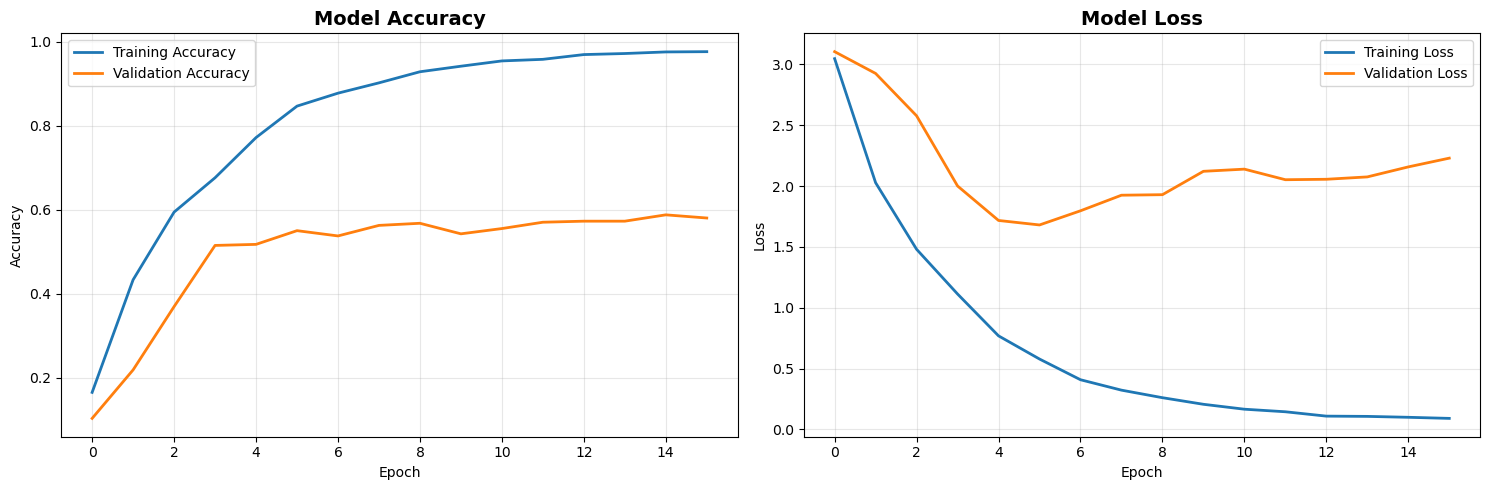

In [44]:
# Cell 12: Visualize Training Results
# =============================================================================

def plot_training_history(history):
    """Plot training history"""
    if history is None:
        print("❌ No training history to plot")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot training results
if 'training_history' in locals() and training_history:
    plot_training_history(training_history)

In [51]:
# =============================================================================
# Cell 13: Test the Trained Model
# =============================================================================

def test_model_predictions():
    """Test the model with sample resume texts"""
    
    if resume_classifier.model is None:
        print("❌ Model not trained yet")
        return
    
    test_cases = [
        "Experienced software engineer with 5 years in Python, Java, and machine learning. Built scalable web applications and managed databases.",
        "Registered nurse with 8 years experience in emergency care, patient management, and medical procedures. CPR certified.",
        "Financial analyst with expertise in investment portfolio management, risk assessment, and financial modeling.",
        "Marketing manager with digital campaign experience, social media strategy, and brand development.",
        "Mechanical engineer with CAD design experience, manufacturing processes, and project management skills."
    ]
    
    print("🔍 TESTING MODEL PREDICTIONS")
    print("="*60)
    
    for i, test_text in enumerate(test_cases, 1):
        print(f"\n📝 TEST CASE {i}:")
        print(f"Text: {test_text[:80]}...")
        print("-" * 40)
        
        predictions = resume_classifier.predict(test_text, top_k=3)
        
        for j, pred in enumerate(predictions, 1):
            confidence_pct = pred['confidence'] * 100
            print(f"  {j}. {pred['category']:<25} ({confidence_pct:.1f}%)")

# Test the model
test_model_predictions()

🔍 TESTING MODEL PREDICTIONS

📝 TEST CASE 1:
Text: Experienced software engineer with 5 years in Python, Java, and machine learning...
----------------------------------------
  1. Engineering               (16.8%)
  2. Agriculture               (15.1%)
  3. Consultant                (13.1%)

📝 TEST CASE 2:
Text: Registered nurse with 8 years experience in emergency care, patient management, ...
----------------------------------------
  1. Healthcare                (76.2%)
  2. Fitness                   (7.7%)
  3. Advocate                  (2.8%)

📝 TEST CASE 3:
Text: Financial analyst with expertise in investment portfolio management, risk assess...
----------------------------------------
  1. Banking                   (50.3%)
  2. Finance                   (20.8%)
  3. Arts                      (7.0%)

📝 TEST CASE 4:
Text: Marketing manager with digital campaign experience, social media strategy, and b...
----------------------------------------
  1. Digital-Media             (89.1

In [13]:
# Cell 14: Model Summary and Statistics
# =============================================================================

def display_final_summary():
    """Display final summary of the training process"""
    
    if not labeled_resumes:
        print("❌ No training data available")
        return
    
    print("📊 FINAL TRAINING SUMMARY")
    print("="*50)
    
    # Data statistics
    df_summary = pd.DataFrame(labeled_resumes)
    print(f"📄 Total resumes processed: {len(df_summary)}")
    print(f"📏 Average text length: {df_summary['text'].str.len().mean():.0f} characters")
    
    # Category distribution
    print(f"\n🏷️ Category distribution:")
    category_counts = df_summary['category'].value_counts()
    for category, count in category_counts.items():
        print(f"  {category:<25}: {count}")
    
    # Model performance
    if resume_classifier.model is not None:
        print(f"\n🎯 Model Performance:")
        print(f"  ✅ Training completed successfully")
        print(f"  🧠 Architecture: Multi-layer Neural Network")
        print(f"  🔢 Features: TF-IDF vectorization")
        print(f"  📊 Classes: {len(resume_classifier.label_encoder.classes_)}")
        
        # Test on a sample
        if labeled_resumes:
            sample_text = labeled_resumes[0]['text'][:200]
            predictions = resume_classifier.predict(sample_text, top_k=1)
            print(f"  🔍 Sample prediction: {predictions[0]['category']} ({predictions[0]['confidence']:.3f})")
    
    print(f"\n🎉 Neural Network Resume Classifier is ready for use!")

# Display final summary
display_final_summary()


📊 FINAL TRAINING SUMMARY
📄 Total resumes processed: 2483
📏 Average text length: 5794 characters

🏷️ Category distribution:
  Information-Technology   : 120
  Business-Development     : 119
  Accountant               : 118
  Advocate                 : 118
  Finance                  : 118
  Engineering              : 118
  Chef                     : 118
  Fitness                  : 117
  Aviation                 : 117
  Sales                    : 116
  Healthcare               : 115
  Consultant               : 115
  Banking                  : 115
  Construction             : 112
  Public-Relations         : 111
  HR                       : 110
  Designer                 : 107
  Arts                     : 103
  Teacher                  : 102
  Apparel                  : 97
  Digital-Media            : 96
  Agriculture              : 63
  Automobile               : 36
  BPO                      : 22

🎯 Model Performance:
  ✅ Training completed successfully
  🧠 Architecture: Multi-layer Ne

In [53]:
if resume_classifier.model is not None:
    print("💾 SAVING TRAINED MODEL")
    print("="*30)
    
    # Save the model
    resume_classifier.save_model("resume_classifier_nn")
    
    print("\n🎉 MODEL TRAINING COMPLETE!")
    print("="*40)
    print("✅ Your neural network model is ready!")
    print("✅ Model files saved successfully")
    print("\n📁 Generated files:")
    print("  • resume_classifier_nn_model.h5")
    print("  • resume_classifier_nn_preprocessors.pkl")
    print("\n🚀 You can now use this model for resume classification!")
    
else:
    print("❌ No trained model to save")

💾 SAVING TRAINED MODEL
✅ Model saved: resume_classifier_nn_model.h5
✅ Preprocessors saved: resume_classifier_nn_preprocessors.pkl

🎉 MODEL TRAINING COMPLETE!
✅ Your neural network model is ready!
✅ Model files saved successfully

📁 Generated files:
  • resume_classifier_nn_model.h5
  • resume_classifier_nn_preprocessors.pkl

🚀 You can now use this model for resume classification!
